In [69]:
"""
==========================================
EJEMPLO COMPLETO - FLUJO END-TO-END
==========================================

Este ejemplo muestra el flujo completo desde la creación del sistema
hasta el consumo de la API en producción.

NOTA: Este código está comentado. Descomenta las secciones según necesites.
"""

# ============================================
# PASO 1: PREPARACIÓN INICIAL (Una sola vez)
# ============================================

'''
# Asumiendo que ya tienes todos los componentes calculados:
# - G (grafo con riesgo_compuesto)
# - df_stats_tramos
# - df_clusters
# - grid_gi, grid_lisa
# - modelo_ml (entrenado)
# - df_accidentes
# - scaler, feature_names

# Guardar sistema completo
print("Guardando sistema completo...")
metadata = guardar_sistema_completo(
    G=G,
    df_stats_tramos=df_stats_tramos,
    df_clusters=df_clusters,
    grid_gi=grid_gi,
    grid_lisa=grid_lisa,
    modelo_ml=mejor_modelo,  # Tu modelo ML entrenado
    df_accidentes=df_accidentes,
    scaler=scaler,
    feature_names=feature_names,
    pesos_riesgo={'historico': 0.6, 'clustering': 0.1, 'ml': 0.3},
    filepath='sistema_ruteo.pkl'
)

print(f"Sistema guardado: {metadata['filepath']}")
print(f"Tamaño: {metadata['size_mb']} MB")

# Opcional: Comprimir para backup
info_compresion = comprimir_sistema(
    'sistema_ruteo.pkl',
    'sistema_ruteo.pkl.gz'
)
print(f"Comprimido: {info_compresion['size_comprimido_mb']} MB")
'''

# ============================================
# PASO 2: CARGA DEL SISTEMA (Al iniciar API)
# ============================================

'''
print("Cargando sistema desde archivo...")
sistema_data = cargar_sistema_completo('sistema_ruteo.pkl', validar=True)

# Inicializar sistema global para la API
sistema = inicializar_sistema_api(
    G=sistema_data['G'],
    df_stats_tramos=sistema_data['df_stats_tramos'],
    df_clusters=sistema_data['df_clusters'],
    grid_gi=sistema_data['grid_gi'],
    grid_lisa=sistema_data['grid_lisa'],
    modelo_ml=sistema_data['modelo_ml'],
    df_accidentes=sistema_data['df_accidentes'],
    scaler=sistema_data['scaler'],
    feature_names=sistema_data['feature_names'],
    pesos_riesgo=sistema_data['pesos_riesgo']
)

print("Sistema inicializado y listo para usar")
'''

# ============================================
# PASO 3: USO DE LA API (Ejemplos)
# ============================================

'''
# Ejemplo 1: Ruta simple
print("\n" + "="*60)
print("EJEMPLO 1: Ruta balanceada simple")
print("="*60)

resultado = api_calcular_ruta_v2(
    origen_lat=19.4326,
    origen_lon=-99.1332,
    destino_lat=19.3910,
    destino_lon=-99.1719,
    modo='balanceado'
)

if resultado['status'] == 'success':
    metricas = resultado['ruta_principal']['metricas_basicas']
    print(f"Distancia: {metricas['distancia_km']} km")
    print(f"Tiempo: {metricas['tiempo_min']} min")
    print(f"Riesgo: {metricas['riesgo_promedio']:.3f}")
    
    # Mostrar recomendación
    rec = resultado['recomendacion']
    print(f"\nRecomendación: {rec['mensaje']}")
    print(f"Score: {rec['score']:.3f}")
else:
    print(f"Error: {resultado['error_code']} - {resultado['message']}")


# Ejemplo 2: Ruta con alternativas y comparación
print("\n" + "="*60)
print("EJEMPLO 2: Ruta con alternativas")
print("="*60)

resultado = api_calcular_ruta_v2(
    origen_lat=19.4326,
    origen_lon=-99.1332,
    destino_lat=19.3910,
    destino_lon=-99.1719,
    modo='balanceado',
    opciones={
        'incluir_alternativas': True,
        'incluir_comparacion': True,
        'incluir_instrucciones': True,
        'incluir_advertencias': True
    }
)

if resultado['status'] == 'success':
    print("\nRuta principal:")
    metricas = resultado['ruta_principal']['metricas_basicas']
    print(f"  - Distancia: {metricas['distancia_km']} km")
    print(f"  - Tiempo: {metricas['tiempo_min']} min")
    print(f"  - Riesgo: {metricas['riesgo_promedio']:.3f}")
    
    if 'rutas_alternativas' in resultado:
        print(f"\nRutas alternativas: {len(resultado['rutas_alternativas'])}")
        for alt in resultado['rutas_alternativas']:
            print(f"  - {alt['nombre']}: "
                  f"{alt['metricas_basicas']['distancia_km']} km, "
                  f"{alt['metricas_basicas']['tiempo_min']} min")
    
    if 'comparacion' in resultado:
        print("\nComparación:")
        for key, comp in resultado['comparacion'].items():
            print(f"  {key}:")
            print(f"    Tiempo extra: {comp['tiempo_extra_min']} min")
            print(f"    Reducción riesgo: {comp['reduccion_riesgo_pct']:.1f}%")


# Ejemplo 3: Ruta personalizada con alpha custom
print("\n" + "="*60)
print("EJEMPLO 3: Ruta personalizada (alpha=0.75)")
print("="*60)

resultado = api_calcular_ruta_v2(
    origen_lat=19.4326,
    origen_lon=-99.1332,
    destino_lat=19.3910,
    destino_lon=-99.1719,
    modo='custom',
    opciones={
        'alpha': 0.75,  # Más seguridad que balanceado
        'incluir_instrucciones': True
    }
)

if resultado['status'] == 'success':
    metricas = resultado['ruta_principal']['metricas_basicas']
    print(f"Alpha: {resultado['request']['alpha']}")
    print(f"Distancia: {metricas['distancia_km']} km")
    print(f"Tiempo: {metricas['tiempo_min']} min")
    print(f"Riesgo: {metricas['riesgo_promedio']:.3f}")
    
    # Mostrar primeras instrucciones
    instrucciones = resultado['ruta_principal']['instrucciones']
    print(f"\nPrimeros pasos ({len(instrucciones)} total):")
    for instr in instrucciones[:3]:
        print(f"  {instr['paso']}. {instr['descripcion']}")


# Ejemplo 4: Exportar a JSON
print("\n" + "="*60)
print("EJEMPLO 4: Exportar resultado a JSON")
print("="*60)

resultado = api_calcular_ruta_v2(
    origen_lat=19.4326,
    origen_lon=-99.1332,
    destino_lat=19.3910,
    destino_lon=-99.1719,
    modo='seguro'
)

# Guardar JSON
json_str = json.dumps(resultado, ensure_ascii=False, indent=2)
with open('ruta_ejemplo.json', 'w', encoding='utf-8') as f:
    f.write(json_str)

print(f"Resultado guardado en: ruta_ejemplo.json")
print(f"Tamaño: {len(json_str) / 1024:.2f} KB")
'''

# ============================================
# PASO 4: CLIENTE HTTP (Ejemplos de consumo)
# ============================================

EJEMPLO_CLIENTE_PYTHON = '''
"""
Cliente Python usando requests
"""
import requests
import json

# URL de la API (ajustar según deployment)
API_URL = "http://localhost:5000/api/v1/ruta"  # Flask
# API_URL = "http://localhost:8000/api/v1/ruta"  # FastAPI

# Request
payload = {
    "origen": {"lat": 19.4326, "lon": -99.1332},
    "destino": {"lat": 19.3910, "lon": -99.1719},
    "modo": "balanceado",
    "opciones": {
        "incluir_alternativas": True,
        "incluir_comparacion": True
    }
}

# Hacer request
response = requests.post(API_URL, json=payload)

# Procesar respuesta
if response.status_code == 200:
    resultado = response.json()
    
    if resultado['status'] == 'success':
        metricas = resultado['ruta_principal']['metricas_basicas']
        print(f"Ruta calculada:")
        print(f"  Distancia: {metricas['distancia_km']} km")
        print(f"  Tiempo: {metricas['tiempo_min']} min")
        print(f"  Riesgo: {metricas['riesgo_promedio']:.3f}")
    else:
        print(f"Error: {resultado['error_code']}")
        print(f"Mensaje: {resultado['message']}")
else:
    print(f"HTTP Error: {response.status_code}")
    print(response.text)
'''

EJEMPLO_CLIENTE_CURL = '''
# Cliente usando curl (terminal)

# Ruta simple
curl -X POST http://localhost:5000/api/v1/ruta \\
     -H "Content-Type: application/json" \\
     -d '{
       "origen": {"lat": 19.4326, "lon": -99.1332},
       "destino": {"lat": 19.3910, "lon": -99.1719},
       "modo": "balanceado"
     }'

# Ruta con opciones
curl -X POST http://localhost:5000/api/v1/ruta \\
     -H "Content-Type: application/json" \\
     -d '{
       "origen": {"lat": 19.4326, "lon": -99.1332},
       "destino": {"lat": 19.3910, "lon": -99.1719},
       "modo": "seguro",
       "opciones": {
         "incluir_alternativas": true,
         "incluir_comparacion": true
       }
     }' | jq '.'

# Health check
curl http://localhost:5000/health
'''

EJEMPLO_CLIENTE_JAVASCRIPT = '''
/**
 * Cliente JavaScript (fetch API)
 */

async function calcularRuta(origen, destino, modo = 'balanceado') {
    const API_URL = 'http://localhost:5000/api/v1/ruta';
    
    const payload = {
        origen: origen,
        destino: destino,
        modo: modo,
        opciones: {
            incluir_alternativas: true,
            incluir_comparacion: true
        }
    };
    
    try {
        const response = await fetch(API_URL, {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json'
            },
            body: JSON.stringify(payload)
        });
        
        const resultado = await response.json();
        
        if (resultado.status === 'success') {
            const metricas = resultado.ruta_principal.metricas_basicas;
            console.log('Ruta calculada:');
            console.log(`  Distancia: ${metricas.distancia_km} km`);
            console.log(`  Tiempo: ${metricas.tiempo_min} min`);
            console.log(`  Riesgo: ${metricas.riesgo_promedio.toFixed(3)}`);
            
            return resultado;
        } else {
            console.error('Error:', resultado.error_code);
            console.error('Mensaje:', resultado.message);
            return null;
        }
    } catch (error) {
        console.error('Error de red:', error);
        return null;
    }
}

// Uso
const origen = {lat: 19.4326, lon: -99.1332};
const destino = {lat: 19.3910, lon: -99.1719};
calcularRuta(origen, destino, 'balanceado');
'''

print("=" * 70)
print("EJEMPLOS DE USO COMPLETO - API DE RUTEO SEGURO v2.0")
print("=" * 70)
print()
print("Ejemplos de clientes HTTP disponibles en las variables:")
print("  - EJEMPLO_CLIENTE_PYTHON: Cliente con requests")
print("  - EJEMPLO_CLIENTE_CURL: Comandos curl")
print("  - EJEMPLO_CLIENTE_JAVASCRIPT: Cliente con fetch API")
print()
print("Para ver un ejemplo:")
print("  print(EJEMPLO_CLIENTE_PYTHON)")
print()
print("Para usar la API:")
print("  1. Ejecutar servidor Flask o FastAPI")
print("  2. Hacer requests HTTP POST a /api/v1/ruta")
print("  3. Procesar respuesta JSON")
print()
print("Documentación completa:")
print("  - Flask: http://localhost:5000/api/v1/docs")
print("  - FastAPI: http://localhost:8000/docs (Swagger UI)")
print("  - FastAPI: http://localhost:8000/redoc (ReDoc)")
print("=" * 70)

EJEMPLOS DE USO COMPLETO - API DE RUTEO SEGURO v2.0

Ejemplos de clientes HTTP disponibles en las variables:
  - EJEMPLO_CLIENTE_PYTHON: Cliente con requests
  - EJEMPLO_CLIENTE_CURL: Comandos curl
  - EJEMPLO_CLIENTE_JAVASCRIPT: Cliente con fetch API

Para ver un ejemplo:
  print(EJEMPLO_CLIENTE_PYTHON)

Para usar la API:
  1. Ejecutar servidor Flask o FastAPI
  2. Hacer requests HTTP POST a /api/v1/ruta
  3. Procesar respuesta JSON

Documentación completa:
  - Flask: http://localhost:5000/api/v1/docs
  - FastAPI: http://localhost:8000/docs (Swagger UI)
  - FastAPI: http://localhost:8000/redoc (ReDoc)


### 3.8.6 Ejemplo de Uso Completo - Flujo End-to-End

Esta sección muestra el flujo completo desde la inicialización del sistema hasta el consumo de la API.

**Flujo completo:**
1. Cargar/crear componentes del sistema
2. Guardar sistema completo
3. Cargar sistema desde archivo
4. Inicializar API
5. Hacer requests
6. Consumir respuestas

**Incluye:**
- Ejemplo de inicialización
- Ejemplo de request/response
- Ejemplo de integración con Flask/FastAPI
- Ejemplo de cliente HTTP (curl, Python requests)
- Ejemplo de deployment

In [70]:
"""
SUITE COMPLETA DE TESTS Y VALIDACIÓN
=====================================

NOTA: Este código está comentado para evitar errores si no se han
inicializado todos los componentes. Para ejecutar los tests:

1. Asegúrate de haber ejecutado todas las secciones anteriores
2. Inicializa el sistema con inicializar_sistema_api()
3. Descomenta y ejecuta los tests

"""

def test_ruta_valida():
    """
    Test 1: Calcular ruta válida entre dos puntos.
    
    Expected: Status 'success' con ruta calculada.
    """
    print("=" * 60)
    print("TEST 1: Ruta válida")
    print("=" * 60)
    
    # Coordenadas válidas en CDMX
    # Centro histórico -> Coyoacán
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon,
        modo='balanceado'
    )
    
    # Validaciones
    assert resultado['status'] == 'success', "Debería ser exitoso"
    assert 'ruta_principal' in resultado, "Debe contener ruta_principal"
    assert 'metricas_basicas' in resultado['ruta_principal'], "Debe contener métricas"
    
    # Mostrar resultados
    metricas = resultado['ruta_principal']['metricas_basicas']
    print(f"✓ Test exitoso")
    print(f"  - Distancia: {metricas['distancia_km']} km")
    print(f"  - Tiempo: {metricas['tiempo_min']} min")
    print(f"  - Riesgo promedio: {metricas['riesgo_promedio']:.3f}")
    print(f"  - Segmentos: {metricas['num_segmentos']}")
    print()
    
    return resultado


def test_coordenadas_invalidas():
    """
    Test 2: Coordenadas fuera de CDMX.
    
    Expected: Status 'error' con código 'INVALID_COORDINATES'.
    """
    print("=" * 60)
    print("TEST 2: Coordenadas inválidas (fuera de CDMX)")
    print("=" * 60)
    
    # Coordenadas en Monterrey
    origen_lat, origen_lon = 25.6866, -100.3161
    destino_lat, destino_lon = 25.6488, -100.2891
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon
    )
    
    # Validaciones
    assert resultado['status'] == 'error', "Debería ser error"
    assert resultado['error_code'] == 'INVALID_COORDINATES', "Código de error correcto"
    
    print(f"✓ Test exitoso - Error manejado correctamente")
    print(f"  - Código: {resultado['error_code']}")
    print(f"  - Mensaje: {resultado['message']}")
    print()
    
    return resultado


def test_modo_invalido():
    """
    Test 3: Modo de ruteo inválido.
    
    Expected: Status 'error' con código 'INVALID_MODE'.
    """
    print("=" * 60)
    print("TEST 3: Modo de ruteo inválido")
    print("=" * 60)
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon,
        modo='super_rapido'  # Modo inexistente
    )
    
    # Validaciones
    assert resultado['status'] == 'error', "Debería ser error"
    assert resultado['error_code'] == 'INVALID_MODE', "Código de error correcto"
    
    print(f"✓ Test exitoso - Error manejado correctamente")
    print(f"  - Código: {resultado['error_code']}")
    print(f"  - Mensaje: {resultado['message']}")
    print()
    
    return resultado


def test_alpha_invalido():
    """
    Test 4: Valor de alpha fuera de rango.
    
    Expected: Status 'error' con código 'INVALID_MODE' o 'INVALID_ALPHA'.
    """
    print("=" * 60)
    print("TEST 4: Alpha fuera de rango")
    print("=" * 60)
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon,
        modo='custom',
        opciones={'alpha': 1.5}  # Alpha > 1.0
    )
    
    # Validaciones
    assert resultado['status'] == 'error', "Debería ser error"
    
    print(f"✓ Test exitoso - Error manejado correctamente")
    print(f"  - Código: {resultado['error_code']}")
    print(f"  - Mensaje: {resultado['message']}")
    print()
    
    return resultado


def test_rutas_alternativas():
    """
    Test 5: Cálculo de rutas alternativas.
    
    Expected: Status 'success' con rutas_alternativas incluidas.
    """
    print("=" * 60)
    print("TEST 5: Rutas alternativas")
    print("=" * 60)
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon,
        modo='balanceado',
        opciones={
            'incluir_alternativas': True,
            'incluir_comparacion': True
        }
    )
    
    # Validaciones
    assert resultado['status'] == 'success', "Debería ser exitoso"
    assert 'rutas_alternativas' in resultado, "Debe incluir rutas alternativas"
    assert 'comparacion' in resultado, "Debe incluir comparación"
    
    print(f"✓ Test exitoso")
    print(f"  - Rutas alternativas: {len(resultado.get('rutas_alternativas', []))}")
    
    # Mostrar comparación
    if 'comparacion' in resultado:
        print("  - Comparación:")
        for key, comp in resultado['comparacion'].items():
            print(f"    {key}:")
            print(f"      Tiempo extra: {comp['tiempo_extra_min']} min")
            print(f"      Reducción riesgo: {comp['reduccion_riesgo_pct']:.1f}%")
    print()
    
    return resultado


def test_todos_los_modos():
    """
    Test 6: Probar todos los modos de ruteo.
    
    Expected: Todos los modos funcionan correctamente.
    """
    print("=" * 60)
    print("TEST 6: Todos los modos de ruteo")
    print("=" * 60)
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    modos = ['rapido', 'balanceado', 'seguro', 'economico', 'familiar']
    resultados = {}
    
    for modo in modos:
        resultado = api_calcular_ruta_v2(
            origen_lat, origen_lon,
            destino_lat, destino_lon,
            modo=modo
        )
        
        assert resultado['status'] == 'success', f"Modo {modo} debería ser exitoso"
        resultados[modo] = resultado
        
        metricas = resultado['ruta_principal']['metricas_basicas']
        print(f"  {modo:12s}: {metricas['distancia_km']:5.2f} km, "
              f"{metricas['tiempo_min']:5.2f} min, "
              f"riesgo {metricas['riesgo_promedio']:.3f}")
    
    print(f"\n✓ Test exitoso - Todos los modos funcionan correctamente")
    print()
    
    return resultados


def test_performance():
    """
    Test 7: Medición de performance.
    
    Expected: Tiempo de cálculo < 2 segundos.
    """
    print("=" * 60)
    print("TEST 7: Performance")
    print("=" * 60)
    
    import time
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    # Calcular 10 rutas y medir tiempo
    tiempos = []
    
    for i in range(10):
        start = time.time()
        resultado = api_calcular_ruta_v2(
            origen_lat, origen_lon,
            destino_lat, destino_lon,
            modo='balanceado'
        )
        elapsed = time.time() - start
        tiempos.append(elapsed)
    
    # Estadísticas
    tiempo_promedio = sum(tiempos) / len(tiempos)
    tiempo_min = min(tiempos)
    tiempo_max = max(tiempos)
    
    print(f"  - Tiempos de {len(tiempos)} cálculos:")
    print(f"    Promedio: {tiempo_promedio:.3f}s")
    print(f"    Mínimo: {tiempo_min:.3f}s")
    print(f"    Máximo: {tiempo_max:.3f}s")
    
    # Validación
    assert tiempo_promedio < 2.0, "Tiempo promedio debe ser < 2 segundos"
    
    print(f"\n✓ Test exitoso - Performance dentro de límites")
    print()
    
    return {
        'tiempos': tiempos,
        'promedio': tiempo_promedio,
        'min': tiempo_min,
        'max': tiempo_max
    }


def test_json_serializable():
    """
    Test 8: Validar que la respuesta es JSON serializable.
    
    Expected: json.dumps() funciona sin errores.
    """
    print("=" * 60)
    print("TEST 8: JSON Serializable")
    print("=" * 60)
    
    origen_lat, origen_lon = 19.4326, -99.1332
    destino_lat, destino_lon = 19.3910, -99.1719
    
    resultado = api_calcular_ruta_v2(
        origen_lat, origen_lon,
        destino_lat, destino_lon,
        modo='balanceado',
        opciones={'incluir_alternativas': True}
    )
    
    # Intentar serializar a JSON
    try:
        json_str = json.dumps(resultado, ensure_ascii=False, indent=2)
        json_size = len(json_str)
        
        # También validar que se puede parsear de vuelta
        parsed = json.loads(json_str)
        
        print(f"✓ Test exitoso - Respuesta es JSON serializable")
        print(f"  - Tamaño JSON: {json_size:,} caracteres")
        print(f"  - Tamaño JSON: {json_size / 1024:.2f} KB")
        print()
        
        return True
        
    except Exception as e:
        print(f"✗ Test fallido: {e}")
        return False


def ejecutar_suite_completa():
    """
    Ejecuta todos los tests de la suite.
    
    Returns:
        dict: Resultados de todos los tests
    """
    print("\n")
    print("╔" + "=" * 58 + "╗")
    print("║" + " " * 10 + "SUITE COMPLETA DE TESTS - API v2.0" + " " * 13 + "║")
    print("╚" + "=" * 58 + "╝")
    print()
    
    resultados = {}
    tests = [
        ('Ruta válida', test_ruta_valida),
        ('Coordenadas inválidas', test_coordenadas_invalidas),
        ('Modo inválido', test_modo_invalido),
        ('Alpha inválido', test_alpha_invalido),
        ('Rutas alternativas', test_rutas_alternativas),
        ('Todos los modos', test_todos_los_modos),
        ('Performance', test_performance),
        ('JSON serializable', test_json_serializable)
    ]
    
    tests_exitosos = 0
    tests_fallidos = 0
    
    for nombre, test_func in tests:
        try:
            resultado = test_func()
            resultados[nombre] = {'status': 'success', 'resultado': resultado}
            tests_exitosos += 1
        except AssertionError as e:
            resultados[nombre] = {'status': 'failed', 'error': str(e)}
            tests_fallidos += 1
            print(f"✗ Test fallido: {e}\n")
        except Exception as e:
            resultados[nombre] = {'status': 'error', 'error': str(e)}
            tests_fallidos += 1
            print(f"✗ Error en test: {e}\n")
    
    # Resumen final
    print("=" * 60)
    print("RESUMEN DE TESTS")
    print("=" * 60)
    print(f"Total tests: {len(tests)}")
    print(f"Exitosos: {tests_exitosos}")
    print(f"Fallidos: {tests_fallidos}")
    print(f"Tasa de éxito: {tests_exitosos/len(tests)*100:.1f}%")
    print("=" * 60)
    
    return resultados


# Ejemplo de uso comentado
'''
# Para ejecutar los tests:

# 1. Asegúrate de haber inicializado el sistema
# sistema_data = cargar_sistema_completo('sistema_ruteo.pkl')
# inicializar_sistema_api(**sistema_data)

# 2. Ejecutar un test individual
# test_ruta_valida()

# 3. Ejecutar suite completa
# resultados = ejecutar_suite_completa()

# 4. Ver resultados
# for nombre, resultado in resultados.items():
#     print(f"{nombre}: {resultado['status']}")
'''

print("✓ Suite de tests implementada correctamente")
print("")
print("Para ejecutar los tests:")
print("  1. Inicializa el sistema: inicializar_sistema_api(...)")
print("  2. Ejecuta: ejecutar_suite_completa()")
print("  3. O ejecuta tests individuales: test_ruta_valida(), etc.")

✓ Suite de tests implementada correctamente

Para ejecutar los tests:
  1. Inicializa el sistema: inicializar_sistema_api(...)
  2. Ejecuta: ejecutar_suite_completa()
  3. O ejecuta tests individuales: test_ruta_valida(), etc.


### 3.8.5 Tests y Validación Completa

Suite de tests para validar el funcionamiento del sistema API.

**Tipos de tests implementados:**
1. **Tests unitarios**: Validación de funciones individuales
2. **Tests de integración**: Validación del sistema completo
3. **Tests de manejo de errores**: Validación de casos edge
4. **Tests de performance**: Medición de tiempos de respuesta
5. **Tests de serialización**: Validación de guardado/carga

**Casos de prueba:**
- Ruta válida (caso exitoso)
- Coordenadas fuera de CDMX (error esperado)
- Modo inválido (error esperado)
- Alpha fuera de rango (error esperado)
- Sin path entre origen/destino (error esperado)
- Comparación de rutas alternativas
- Serialización y carga del sistema
- Performance bajo carga

In [71]:
import pickle
import json
import os
from datetime import datetime
from pathlib import Path

def guardar_sistema_completo(G, df_stats_tramos, df_clusters, grid_gi, grid_lisa, 
                             modelo_ml, df_accidentes, scaler, feature_names,
                             pesos_riesgo=None, filepath='sistema_ruteo.pkl',
                             incluir_metadata=True):
    """
    Serializa el sistema completo de ruteo en un archivo pickle.
    
    Esta función guarda todos los componentes necesarios para que el sistema
    pueda ser cargado rápidamente en producción sin necesidad de recomputar.
    
    Args:
        G: Grafo de NetworkX con atributos de riesgo
        df_stats_tramos: DataFrame con estadísticas por tramo
        df_clusters: DataFrame con información de clustering
        grid_gi: GeoDataFrame con análisis Getis-Ord
        grid_lisa: GeoDataFrame con análisis LISA
        modelo_ml: Modelo de ML entrenado
        df_accidentes: DataFrame de accidentes históricos
        scaler: Scaler para normalización
        feature_names: Lista de nombres de features
        pesos_riesgo: Dict con pesos de componentes de riesgo
        filepath: Ruta del archivo de salida
        incluir_metadata: Si True, guarda archivo de metadatos
    
    Returns:
        dict: Información sobre el archivo guardado
    
    Example:
        >>> info = guardar_sistema_completo(
        ...     G, df_stats, df_clusters, grid_gi, grid_lisa,
        ...     modelo_ml, df_accidentes, scaler, feature_names
        ... )
        >>> print(f"Sistema guardado: {info['filepath']}")
        >>> print(f"Tamaño: {info['size_mb']:.2f} MB")
    """
    print(f"Guardando sistema completo en: {filepath}")
    
    # Preparar pesos por defecto
    if pesos_riesgo is None:
        pesos_riesgo = {'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
    
    # Crear diccionario con todos los componentes
    sistema_data = {
        'G': G,
        'df_stats_tramos': df_stats_tramos,
        'df_clusters': df_clusters,
        'grid_gi': grid_gi,
        'grid_lisa': grid_lisa,
        'modelo_ml': modelo_ml,
        'df_accidentes': df_accidentes,
        'scaler': scaler,
        'feature_names': feature_names,
        'pesos_riesgo': pesos_riesgo,
        'version': '2.0',
        'timestamp': datetime.now().isoformat()
    }
    
    # Guardar con pickle
    with open(filepath, 'wb') as f:
        pickle.dump(sistema_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Obtener tamaño del archivo
    file_size = os.path.getsize(filepath)
    size_mb = file_size / (1024 * 1024)
    
    print(f"✓ Sistema guardado exitosamente")
    print(f"  - Tamaño: {size_mb:.2f} MB")
    print(f"  - Nodos en grafo: {G.number_of_nodes():,}")
    print(f"  - Aristas en grafo: {G.number_of_edges():,}")
    print(f"  - Registros en df_stats_tramos: {len(df_stats_tramos):,}")
    
    # Crear metadata si se solicitó
    metadata = {
        'version': '2.0',
        'timestamp': datetime.now().isoformat(),
        'filepath': str(filepath),
        'size_bytes': file_size,
        'size_mb': round(size_mb, 2),
        'componentes': {
            'grafo': {
                'nodos': G.number_of_nodes(),
                'aristas': G.number_of_edges(),
                'tipo': str(type(G))
            },
            'df_stats_tramos': {
                'registros': len(df_stats_tramos),
                'columnas': list(df_stats_tramos.columns)
            },
            'df_clusters': {
                'registros': len(df_clusters) if df_clusters is not None else 0
            },
            'modelo_ml': {
                'tipo': str(type(modelo_ml)),
                'features': len(feature_names)
            },
            'df_accidentes': {
                'registros': len(df_accidentes) if df_accidentes is not None else 0
            }
        },
        'pesos_riesgo': pesos_riesgo
    }
    
    if incluir_metadata:
        metadata_filepath = filepath.replace('.pkl', '_metadata.json')
        with open(metadata_filepath, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        print(f"  - Metadata guardada en: {metadata_filepath}")
    
    return metadata


def cargar_sistema_completo(filepath='sistema_ruteo.pkl', validar=True):
    """
    Carga el sistema completo desde un archivo pickle.
    
    Args:
        filepath: Ruta del archivo pickle
        validar: Si True, valida la integridad de los componentes
    
    Returns:
        dict: Diccionario con todos los componentes del sistema
    
    Raises:
        FileNotFoundError: Si el archivo no existe
        ValueError: Si faltan componentes o la validación falla
    
    Example:
        >>> sistema_data = cargar_sistema_completo('sistema_ruteo.pkl')
        >>> sistema = inicializar_sistema_api(
        ...     G=sistema_data['G'],
        ...     df_stats_tramos=sistema_data['df_stats_tramos'],
        ...     # ... resto de componentes
        ... )
    """
    print(f"Cargando sistema desde: {filepath}")
    
    # Verificar que el archivo existe
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Archivo no encontrado: {filepath}")
    
    # Cargar con pickle
    start_time = datetime.now()
    with open(filepath, 'rb') as f:
        sistema_data = pickle.load(f)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"✓ Sistema cargado en {elapsed:.2f} segundos")
    
    # Validar componentes si se solicitó
    if validar:
        validar_integridad_sistema(sistema_data)
    
    # Mostrar información
    print(f"  - Versión: {sistema_data.get('version', 'unknown')}")
    print(f"  - Timestamp: {sistema_data.get('timestamp', 'unknown')}")
    print(f"  - Nodos en grafo: {sistema_data['G'].number_of_nodes():,}")
    print(f"  - Aristas en grafo: {sistema_data['G'].number_of_edges():,}")
    
    return sistema_data


def validar_integridad_sistema(sistema_data):
    """
    Valida que el sistema tenga todos los componentes necesarios.
    
    Args:
        sistema_data: Dict con componentes del sistema
    
    Raises:
        ValueError: Si falta algún componente o hay inconsistencias
    
    Returns:
        bool: True si todo está correcto
    """
    componentes_requeridos = [
        'G', 'df_stats_tramos', 'modelo_ml', 'scaler', 'feature_names'
    ]
    
    componentes_faltantes = []
    for comp in componentes_requeridos:
        if comp not in sistema_data or sistema_data[comp] is None:
            componentes_faltantes.append(comp)
    
    if componentes_faltantes:
        raise ValueError(
            f"Componentes faltantes en el sistema: {', '.join(componentes_faltantes)}"
        )
    
    # Validar que el grafo tenga aristas
    if sistema_data['G'].number_of_edges() == 0:
        raise ValueError("El grafo no tiene aristas")
    
    # Validar que el grafo tenga atributos de riesgo
    edge_sample = list(sistema_data['G'].edges(data=True))[0]
    if 'riesgo_compuesto' not in edge_sample[2]:
        raise ValueError("El grafo no tiene atributo 'riesgo_compuesto'")
    
    # Validar que df_stats_tramos no esté vacío
    if len(sistema_data['df_stats_tramos']) == 0:
        raise ValueError("df_stats_tramos está vacío")
    
    print("✓ Validación de integridad exitosa")
    return True


def exportar_configuracion(sistema_data, filepath='config_sistema.json'):
    """
    Exporta la configuración del sistema a JSON (sin los datos pesados).
    
    Útil para documentación y versionado.
    
    Args:
        sistema_data: Dict con componentes del sistema
        filepath: Ruta del archivo JSON de salida
    
    Returns:
        dict: Configuración exportada
    """
    config = {
        'version': sistema_data.get('version', 'unknown'),
        'timestamp': sistema_data.get('timestamp', 'unknown'),
        'pesos_riesgo': sistema_data.get('pesos_riesgo', {}),
        'feature_names': sistema_data.get('feature_names', []),
        'estadisticas': {
            'nodos_grafo': sistema_data['G'].number_of_nodes(),
            'aristas_grafo': sistema_data['G'].number_of_edges(),
            'registros_stats': len(sistema_data['df_stats_tramos']),
            'registros_accidentes': len(sistema_data.get('df_accidentes', [])),
            'num_features_ml': len(sistema_data.get('feature_names', []))
        },
        'modelo_ml': {
            'tipo': str(type(sistema_data['modelo_ml'])),
            'parametros': getattr(sistema_data['modelo_ml'], 'get_params', lambda: {})()
        }
    }
    
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Configuración exportada a: {filepath}")
    return config


def comprimir_sistema(filepath_entrada='sistema_ruteo.pkl', 
                     filepath_salida='sistema_ruteo.pkl.gz'):
    """
    Comprime el archivo pickle para reducir espacio de almacenamiento.
    
    Útil para backups y distribución.
    
    Args:
        filepath_entrada: Archivo pickle original
        filepath_salida: Archivo comprimido de salida
    
    Returns:
        dict: Información sobre la compresión
    """
    import gzip
    import shutil
    
    print(f"Comprimiendo sistema...")
    
    # Obtener tamaño original
    size_original = os.path.getsize(filepath_entrada)
    
    # Comprimir
    with open(filepath_entrada, 'rb') as f_in:
        with gzip.open(filepath_salida, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # Obtener tamaño comprimido
    size_comprimido = os.path.getsize(filepath_salida)
    
    ratio = (1 - size_comprimido / size_original) * 100
    
    print(f"✓ Compresión exitosa")
    print(f"  - Tamaño original: {size_original / (1024*1024):.2f} MB")
    print(f"  - Tamaño comprimido: {size_comprimido / (1024*1024):.2f} MB")
    print(f"  - Ratio de compresión: {ratio:.1f}%")
    
    return {
        'filepath_original': filepath_entrada,
        'filepath_comprimido': filepath_salida,
        'size_original_mb': round(size_original / (1024*1024), 2),
        'size_comprimido_mb': round(size_comprimido / (1024*1024), 2),
        'ratio_compresion_pct': round(ratio, 1)
    }


def descomprimir_sistema(filepath_comprimido='sistema_ruteo.pkl.gz',
                        filepath_salida='sistema_ruteo.pkl'):
    """
    Descomprime un archivo pickle comprimido.
    
    Args:
        filepath_comprimido: Archivo .pkl.gz
        filepath_salida: Archivo .pkl de salida
    
    Returns:
        str: Ruta del archivo descomprimido
    """
    import gzip
    import shutil
    
    print(f"Descomprimiendo sistema...")
    
    with gzip.open(filepath_comprimido, 'rb') as f_in:
        with open(filepath_salida, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print(f"✓ Sistema descomprimido en: {filepath_salida}")
    return filepath_salida


print("✓ Funciones de serialización y caching implementadas correctamente")
print("")
print("Funciones disponibles:")
print("  - guardar_sistema_completo(): Guardar sistema en pickle")
print("  - cargar_sistema_completo(): Cargar sistema desde pickle")
print("  - validar_integridad_sistema(): Validar componentes")
print("  - exportar_configuracion(): Exportar config a JSON")
print("  - comprimir_sistema(): Comprimir con gzip")
print("  - descomprimir_sistema(): Descomprimir archivo")

✓ Funciones de serialización y caching implementadas correctamente

Funciones disponibles:
  - guardar_sistema_completo(): Guardar sistema en pickle
  - cargar_sistema_completo(): Cargar sistema desde pickle
  - validar_integridad_sistema(): Validar componentes
  - exportar_configuracion(): Exportar config a JSON
  - comprimir_sistema(): Comprimir con gzip
  - descomprimir_sistema(): Descomprimir archivo


### 3.8.4 Serialización y Caching del Sistema

Sistema de persistencia para guardar y cargar el sistema completo de ruteo.

**Funciones implementadas:**
1. **`guardar_sistema_completo()`**: Serializa todos los componentes
2. **`cargar_sistema_completo()`**: Carga el sistema desde archivo
3. **`exportar_configuracion()`**: Exporta configuración en JSON
4. **`validar_integridad()`**: Valida que todos los componentes estén presentes

**Formatos soportados:**
- **Pickle**: Para serialización completa de Python (por defecto)
- **JSON**: Para configuraciones y metadatos
- **Parquet**: Para DataFrames grandes (opcional)

**Ventajas:**
- Carga rápida al iniciar la API (< 10 segundos)
- Evita recomputar componentes costosos
- Versionado del sistema
- Backup y recuperación

In [72]:
"""
===========================================
IMPLEMENTACIÓN FASTAPI - API REST
===========================================

Archivo: app_fastapi.py

Para ejecutar:
    uvicorn app_fastapi:app --reload --host 0.0.0.0 --port 8000

Para probar:
    curl -X POST http://localhost:8000/api/v1/ruta \\
         -H "Content-Type: application/json" \\
         -d '{"origen": {"lat": 19.4326, "lon": -99.1332}, "destino": {"lat": 19.3910, "lon": -99.1719}}'

Documentación interactiva:
    http://localhost:8000/docs
    http://localhost:8000/redoc

"""

FASTAPI_IMPLEMENTATION = '''
from fastapi import FastAPI, HTTPException, Request
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field, validator
from typing import Optional, Dict, Any, List
import pickle
import logging
from datetime import datetime
import time

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Crear aplicación FastAPI
app = FastAPI(
    title="API de Ruteo Seguro CDMX",
    description="Sistema inteligente de ruteo que integra análisis histórico, clustering y Machine Learning para calcular rutas seguras en la Ciudad de México",
    version="2.0",
    docs_url="/docs",
    redoc_url="/redoc"
)

# Configurar CORS
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # En producción, especificar orígenes permitidos
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# ============= MODELOS PYDANTIC =============

class Coordenadas(BaseModel):
    """Modelo para coordenadas geográficas."""
    lat: float = Field(..., ge=19.05, le=19.60, description="Latitud (rango CDMX: 19.05 - 19.60)")
    lon: float = Field(..., ge=-99.35, le=-98.95, description="Longitud (rango CDMX: -99.35 - -98.95)")
    
    class Config:
        schema_extra = {
            "example": {
                "lat": 19.4326,
                "lon": -99.1332
            }
        }

class OpcionesRuta(BaseModel):
    """Opciones adicionales para el cálculo de rutas."""
    alpha: Optional[float] = Field(None, ge=0.0, le=1.0, description="Parámetro alpha para modo custom (0=rápido, 1=seguro)")
    incluir_alternativas: bool = Field(False, description="Incluir rutas alternativas")
    incluir_metricas_detalladas: bool = Field(True, description="Incluir métricas detalladas")
    incluir_comparacion: bool = Field(False, description="Incluir comparación con alternativas")
    incluir_instrucciones: bool = Field(True, description="Incluir instrucciones paso a paso")
    incluir_advertencias: bool = Field(True, description="Incluir advertencias de seguridad")
    
    class Config:
        schema_extra = {
            "example": {
                "alpha": 0.5,
                "incluir_alternativas": True,
                "incluir_comparacion": True
            }
        }

class RutaRequest(BaseModel):
    """Request para cálculo de ruta."""
    origen: Coordenadas = Field(..., description="Coordenadas de origen")
    destino: Coordenadas = Field(..., description="Coordenadas de destino")
    modo: str = Field('balanceado', description="Modo de ruteo")
    opciones: Optional[OpcionesRuta] = Field(None, description="Opciones adicionales")
    formato: str = Field('json', description="Formato de salida (json, geojson, both)")
    
    @validator('modo')
    def validar_modo(cls, v):
        """Validar que el modo sea válido."""
        modos_validos = ['rapido', 'balanceado', 'seguro', 'economico', 'familiar', 'custom']
        if v not in modos_validos:
            raise ValueError(f'Modo debe ser uno de: {", ".join(modos_validos)}')
        return v
    
    @validator('formato')
    def validar_formato(cls, v):
        """Validar que el formato sea válido."""
        formatos_validos = ['json', 'geojson', 'both']
        if v not in formatos_validos:
            raise ValueError(f'Formato debe ser uno de: {", ".join(formatos_validos)}')
        return v
    
    class Config:
        schema_extra = {
            "example": {
                "origen": {"lat": 19.4326, "lon": -99.1332},
                "destino": {"lat": 19.3910, "lon": -99.1719},
                "modo": "balanceado",
                "opciones": {
                    "incluir_alternativas": True,
                    "incluir_comparacion": True
                },
                "formato": "json"
            }
        }

class HealthResponse(BaseModel):
    """Respuesta del health check."""
    status: str
    timestamp: str
    sistema_cargado: bool
    version: str

# ============= INICIALIZACIÓN =============

@app.on_event("startup")
async def startup_event():
    """Cargar sistema al iniciar la aplicación."""
    global _sistema_cargado
    try:
        logger.info("Iniciando carga del sistema de ruteo...")
        
        # Cargar desde pickle
        with open('sistema_ruteo.pkl', 'rb') as f:
            sistema_data = pickle.load(f)
        
        # Inicializar sistema global
        inicializar_sistema_api(
            G=sistema_data['G'],
            df_stats_tramos=sistema_data['df_stats_tramos'],
            df_clusters=sistema_data['df_clusters'],
            grid_gi=sistema_data['grid_gi'],
            grid_lisa=sistema_data['grid_lisa'],
            modelo_ml=sistema_data['modelo_ml'],
            df_accidentes=sistema_data['df_accidentes'],
            scaler=sistema_data['scaler'],
            feature_names=sistema_data['feature_names']
        )
        
        _sistema_cargado = True
        logger.info("Sistema de ruteo cargado exitosamente")
        
    except Exception as e:
        logger.error(f"Error al cargar sistema: {e}")
        _sistema_cargado = False

# ============= ENDPOINTS =============

@app.get("/", tags=["General"])
async def root():
    """Endpoint raíz."""
    return {
        "message": "API de Ruteo Seguro CDMX v2.0",
        "docs": "/docs",
        "health": "/health",
        "endpoints": {
            "calcular_ruta": "/api/v1/ruta"
        }
    }

@app.get("/health", response_model=HealthResponse, tags=["General"])
async def health_check():
    """
    Verificar estado del servidor.
    
    Returns:
        Estado del servidor y sistema de ruteo
    """
    return {
        "status": "healthy",
        "timestamp": datetime.now().isoformat(),
        "sistema_cargado": _sistema_cargado,
        "version": "v2.0"
    }

@app.post("/api/v1/ruta", tags=["Ruteo"])
async def calcular_ruta_endpoint(request: RutaRequest):
    """
    Calcular ruta segura entre dos puntos.
    
    Este endpoint utiliza un sistema híbrido que integra:
    - Análisis histórico de accidentes
    - Clustering espacial (DBSCAN, Getis-Ord, LISA)
    - Modelos de Machine Learning (XGBoost, Random Forest, etc.)
    
    Args:
        request: Request con origen, destino, modo y opciones
    
    Returns:
        Ruta calculada con métricas detalladas
    
    Raises:
        HTTPException: Si hay errores en el cálculo
    
    Example:
        ```json
        {
          "origen": {"lat": 19.4326, "lon": -99.1332},
          "destino": {"lat": 19.3910, "lon": -99.1719},
          "modo": "balanceado"
        }
        ```
    """
    start_time = time.time()
    
    try:
        # Logging del request
        logger.info(
            f"Request: {request.origen.lat},{request.origen.lon} → "
            f"{request.destino.lat},{request.destino.lon} (modo: {request.modo})"
        )
        
        # Convertir opciones a dict
        opciones_dict = request.opciones.dict() if request.opciones else {}
        
        # Llamar a la función API
        resultado = api_calcular_ruta_v2(
            origen_lat=request.origen.lat,
            origen_lon=request.origen.lon,
            destino_lat=request.destino.lat,
            destino_lon=request.destino.lon,
            modo=request.modo,
            opciones=opciones_dict,
            formato=request.formato
        )
        
        # Logging de resultado
        elapsed = time.time() - start_time
        
        if resultado['status'] == 'success':
            logger.info(f"Ruta calculada exitosamente en {elapsed:.2f}s")
            return resultado
        else:
            # Error en el cálculo
            error_code = resultado.get('error_code', 'UNKNOWN')
            logger.warning(f"Error en cálculo: {error_code}")
            
            # Mapear códigos de error a HTTP status codes
            status_code_map = {
                'INVALID_COORDINATES': 400,
                'INVALID_MODE': 400,
                'INVALID_ALPHA': 400,
                'INVALID_OPTIONS': 400,
                'NO_PATH_FOUND': 404,
                'SYSTEM_NOT_INITIALIZED': 503,
                'INTERNAL_ERROR': 500
            }
            
            status_code = status_code_map.get(error_code, 500)
            
            raise HTTPException(
                status_code=status_code,
                detail=resultado
            )
        
    except HTTPException:
        raise
    
    except Exception as e:
        logger.error(f"Error interno: {e}", exc_info=True)
        raise HTTPException(
            status_code=500,
            detail={
                'status': 'error',
                'error_code': 'INTERNAL_ERROR',
                'message': 'Error interno del servidor',
                'details': str(e)
            }
        )

@app.get("/api/v1/modos", tags=["Información"])
async def listar_modos():
    """
    Listar todos los modos de ruteo disponibles.
    
    Returns:
        Diccionario con modos y descripciones
    """
    return {
        "modos_disponibles": {
            "rapido": {
                "alpha": 0.0,
                "descripcion": "Ruta más rápida, sin considerar seguridad",
                "recomendado_para": "Viajes urgentes en horarios de bajo riesgo"
            },
            "balanceado": {
                "alpha": 0.5,
                "descripcion": "Balance óptimo entre tiempo y seguridad",
                "recomendado_para": "Uso general, mejor compromiso"
            },
            "seguro": {
                "alpha": 1.0,
                "descripcion": "Ruta más segura, minimiza riesgo",
                "recomendado_para": "Viajes nocturnos, familias, zonas desconocidas"
            },
            "economico": {
                "alpha": 0.3,
                "descripcion": "Optimiza distancia y combustible",
                "recomendado_para": "Taxis, delivery, optimización de costos"
            },
            "familiar": {
                "alpha": 0.8,
                "descripcion": "Prioriza seguridad para familias",
                "recomendado_para": "Viajes con niños, adultos mayores"
            },
            "custom": {
                "alpha": "personalizado",
                "descripcion": "Permite especificar alpha personalizado (0-1)",
                "recomendado_para": "Casos específicos, experimentación"
            }
        }
    }

# Middleware para logging de requests
@app.middleware("http")
async def log_requests(request: Request, call_next):
    """Middleware para logging de todas las requests."""
    start_time = time.time()
    
    response = await call_next(request)
    
    process_time = time.time() - start_time
    logger.info(
        f"{request.method} {request.url.path} - "
        f"Status: {response.status_code} - "
        f"Time: {process_time:.2f}s"
    )
    
    return response

# Ejecutar con: uvicorn app_fastapi:app --reload --host 0.0.0.0 --port 8000
'''

print("Implementación FastAPI guardada en variable FASTAPI_IMPLEMENTATION")
print("Para crear el archivo: ")
print("  with open('app_fastapi.py', 'w') as f: f.write(FASTAPI_IMPLEMENTATION)")
print("")
print("Ventajas de FastAPI:")
print("  - Documentación automática (Swagger UI y ReDoc)")
print("  - Validación automática con Pydantic")
print("  - Alto performance (basado en Starlette y Pydantic)")
print("  - Type hints nativos de Python")
print("  - Async/await support")

Implementación FastAPI guardada en variable FASTAPI_IMPLEMENTATION
Para crear el archivo: 
  with open('app_fastapi.py', 'w') as f: f.write(FASTAPI_IMPLEMENTATION)

Ventajas de FastAPI:
  - Documentación automática (Swagger UI y ReDoc)
  - Validación automática con Pydantic
  - Alto performance (basado en Starlette y Pydantic)
  - Type hints nativos de Python
  - Async/await support


In [73]:
"""
===========================================
IMPLEMENTACIÓN FLASK - API REST
===========================================

Archivo: app_flask.py

Para ejecutar:
    python app_flask.py

Para probar:
    curl -X POST http://localhost:5000/api/v1/ruta \\
         -H "Content-Type: application/json" \\
         -d '{"origen": {"lat": 19.4326, "lon": -99.1332}, "destino": {"lat": 19.3910, "lon": -99.1719}}'

"""

FLASK_IMPLEMENTATION = '''
from flask import Flask, request, jsonify
from flask_cors import CORS
import pickle
import logging
from datetime import datetime
import time

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Crear aplicación Flask
app = Flask(__name__)
CORS(app)  # Habilitar CORS para todas las rutas

# Cargar sistema al inicio (solo una vez)
@app.before_first_request
def inicializar_sistema():
    """Cargar el sistema de ruteo al iniciar la aplicación."""
    global _sistema_cargado
    try:
        logger.info("Iniciando carga del sistema de ruteo...")
        
        # Opción 1: Cargar desde pickle
        with open('sistema_ruteo.pkl', 'rb') as f:
            sistema_data = pickle.load(f)
        
        # Inicializar sistema global
        inicializar_sistema_api(
            G=sistema_data['G'],
            df_stats_tramos=sistema_data['df_stats_tramos'],
            df_clusters=sistema_data['df_clusters'],
            grid_gi=sistema_data['grid_gi'],
            grid_lisa=sistema_data['grid_lisa'],
            modelo_ml=sistema_data['modelo_ml'],
            df_accidentes=sistema_data['df_accidentes'],
            scaler=sistema_data['scaler'],
            feature_names=sistema_data['feature_names']
        )
        
        _sistema_cargado = True
        logger.info("Sistema de ruteo cargado exitosamente")
        
    except Exception as e:
        logger.error(f"Error al cargar sistema: {e}")
        _sistema_cargado = False

# Health check endpoint
@app.route('/health', methods=['GET'])
def health_check():
    """Verificar estado del servidor."""
    return jsonify({
        'status': 'healthy',
        'timestamp': datetime.now().isoformat(),
        'sistema_cargado': _sistema_cargado,
        'version': 'v2.0'
    })

# Endpoint principal
@app.route('/api/v1/ruta', methods=['POST'])
def calcular_ruta_endpoint():
    """
    Endpoint principal para cálculo de rutas.
    
    Request Body (JSON):
    {
        "origen": {"lat": 19.4326, "lon": -99.1332},
        "destino": {"lat": 19.3910, "lon": -99.1719},
        "modo": "balanceado",  // opcional
        "opciones": {...},     // opcional
        "formato": "json"      // opcional
    }
    
    Returns:
        JSON con la ruta calculada o error
    """
    start_time = time.time()
    
    try:
        # Validar Content-Type
        if not request.is_json:
            return jsonify({
                'status': 'error',
                'error_code': 'INVALID_CONTENT_TYPE',
                'message': 'Content-Type debe ser application/json'
            }), 400
        
        # Obtener datos del request
        data = request.get_json()
        
        # Validar campos requeridos
        if 'origen' not in data or 'destino' not in data:
            return jsonify({
                'status': 'error',
                'error_code': 'MISSING_FIELDS',
                'message': 'Se requieren campos "origen" y "destino"'
            }), 400
        
        # Validar estructura de origen y destino
        for campo in ['origen', 'destino']:
            if 'lat' not in data[campo] or 'lon' not in data[campo]:
                return jsonify({
                    'status': 'error',
                    'error_code': 'INVALID_COORDINATES',
                    'message': f'Campo "{campo}" debe contener "lat" y "lon"'
                }), 400
        
        # Extraer parámetros
        origen_lat = float(data['origen']['lat'])
        origen_lon = float(data['origen']['lon'])
        destino_lat = float(data['destino']['lat'])
        destino_lon = float(data['destino']['lon'])
        modo = data.get('modo', 'balanceado')
        opciones = data.get('opciones', {})
        formato = data.get('formato', 'json')
        
        # Logging
        logger.info(f"Request: {origen_lat},{origen_lon} → {destino_lat},{destino_lon} (modo: {modo})")
        
        # Llamar a la función API
        resultado = api_calcular_ruta_v2(
            origen_lat=origen_lat,
            origen_lon=origen_lon,
            destino_lat=destino_lat,
            destino_lon=destino_lon,
            modo=modo,
            opciones=opciones,
            formato=formato
        )
        
        # Logging de resultado
        elapsed = time.time() - start_time
        if resultado['status'] == 'success':
            logger.info(f"Ruta calculada exitosamente en {elapsed:.2f}s")
            return jsonify(resultado), 200
        else:
            logger.warning(f"Error en cálculo: {resultado.get('error_code', 'UNKNOWN')}")
            return jsonify(resultado), 400
        
    except ValueError as e:
        logger.error(f"Error de validación: {e}")
        return jsonify({
            'status': 'error',
            'error_code': 'VALIDATION_ERROR',
            'message': str(e)
        }), 400
    
    except Exception as e:
        logger.error(f"Error interno: {e}", exc_info=True)
        return jsonify({
            'status': 'error',
            'error_code': 'INTERNAL_ERROR',
            'message': 'Error interno del servidor',
            'details': str(e)
        }), 500

# Endpoint de documentación
@app.route('/api/v1/docs', methods=['GET'])
def documentacion():
    """Retorna documentación de la API."""
    return jsonify({
        'version': 'v2.0',
        'endpoints': {
            '/health': {
                'method': 'GET',
                'description': 'Verificar estado del servidor'
            },
            '/api/v1/ruta': {
                'method': 'POST',
                'description': 'Calcular ruta segura entre dos puntos',
                'parametros': {
                    'origen': {'type': 'object', 'required': True, 'props': {'lat': 'float', 'lon': 'float'}},
                    'destino': {'type': 'object', 'required': True, 'props': {'lat': 'float', 'lon': 'float'}},
                    'modo': {'type': 'string', 'required': False, 'default': 'balanceado', 
                            'opciones': ['rapido', 'balanceado', 'seguro', 'economico', 'familiar', 'custom']},
                    'opciones': {'type': 'object', 'required': False},
                    'formato': {'type': 'string', 'required': False, 'default': 'json'}
                }
            }
        },
        'modos_disponibles': {
            'rapido': 'Ruta más rápida (alpha=0.0)',
            'balanceado': 'Balance tiempo/seguridad (alpha=0.5)',
            'seguro': 'Ruta más segura (alpha=1.0)',
            'economico': 'Optimiza distancia (alpha=0.3)',
            'familiar': 'Prioriza seguridad (alpha=0.8)',
            'custom': 'Alpha personalizado (especificar en opciones)'
        }
    })

# Ejecutar servidor
if __name__ == '__main__':
    app.run(
        host='0.0.0.0',
        port=5000,
        debug=False  # Cambiar a False en producción
    )
'''

print("Implementación Flask guardada en variable FLASK_IMPLEMENTATION")
print("Para crear el archivo: ")
print("  with open('app_flask.py', 'w') as f: f.write(FLASK_IMPLEMENTATION)")

Implementación Flask guardada en variable FLASK_IMPLEMENTATION
Para crear el archivo: 
  with open('app_flask.py', 'w') as f: f.write(FLASK_IMPLEMENTATION)


### 3.8.3 Endpoint Wrappers para Flask/FastAPI

Código **listo para producción** que expone la función API como endpoints REST.

**Incluye:**
- Implementación completa para Flask
- Implementación completa para FastAPI
- Validación de requests con Pydantic (FastAPI)
- Manejo de CORS
- Logging y monitoreo
- Rate limiting básico
- Documentación automática (FastAPI)
- Health check endpoints

**Arquitectura:**
```
Cliente HTTP → Framework Web → api_calcular_ruta_v2() → SistemaRuteoSeguro → Respuesta JSON
```

In [74]:
# Variable global para almacenar el sistema (se cargaría al inicio de la aplicación)
_sistema_global = None

def inicializar_sistema_api(G, df_stats_tramos, df_clusters, grid_gi, grid_lisa, 
                            modelo_ml, df_accidentes, scaler, feature_names, 
                            pesos_riesgo=None):
    """
    Inicializar el sistema global para la API.
    Esta función se llamaría una sola vez al inicio de la aplicación.
    
    Args:
        G, df_stats_tramos, etc.: Componentes del sistema
        
    Returns:
        SistemaRuteoSeguro: Sistema inicializado
    """
    global _sistema_global
    _sistema_global = SistemaRuteoSeguro(
        G=G,
        df_stats_tramos=df_stats_tramos,
        df_clusters=df_clusters,
        grid_gi=grid_gi,
        grid_lisa=grid_lisa,
        modelo_ml=modelo_ml,
        df_accidentes=df_accidentes,
        scaler=scaler,
        feature_names=feature_names,
        pesos_riesgo=pesos_riesgo
    )
    return _sistema_global


def api_calcular_ruta_v2(origen_lat, origen_lon, destino_lat, destino_lon, 
                        modo='balanceado', opciones=None, formato='json'):
    """
    Función API principal para cálculo de rutas seguras.
    
    Esta función es el punto de entrada principal para la API REST.
    Utiliza el sistema global pre-inicializado para máxima eficiencia.
    
    Args:
        origen_lat (float): Latitud del punto de origen
        origen_lon (float): Longitud del punto de origen
        destino_lat (float): Latitud del punto de destino
        destino_lon (float): Longitud del punto de destino
        modo (str): Modo de ruteo. Opciones:
            - 'rapido': Ruta más rápida (alpha=0.0)
            - 'balanceado': Balance tiempo/seguridad (alpha=0.5) [DEFAULT]
            - 'seguro': Ruta más segura (alpha=1.0)
            - 'economico': Optimiza distancia (alpha=0.3)
            - 'familiar': Prioriza seguridad para familias (alpha=0.8)
            - 'custom': Permite especificar alpha personalizado
        opciones (dict, optional): Configuraciones adicionales:
            - alpha (float): Valor de alpha [0,1] para modo='custom'
            - incluir_alternativas (bool): Si True, calcula 3 rutas (rápida, balanceada, segura)
            - incluir_metricas_detalladas (bool): Si True, incluye todas las métricas
            - incluir_comparacion (bool): Si True, incluye comparación con rutas alternativas
            - incluir_instrucciones (bool): Si True, incluye instrucciones paso a paso
            - incluir_advertencias (bool): Si True, incluye advertencias de seguridad
            - pesos_riesgo (dict): Pesos personalizados {'historico': float, 'clustering': float, 'ml': float}
        formato (str): Formato de salida:
            - 'json': Retorna diccionario Python/JSON estándar [DEFAULT]
            - 'geojson': Retorna GeoJSON Feature
            - 'both': Retorna ambos formatos
    
    Returns:
        dict: Respuesta en formato JSON con la siguiente estructura:
        
        CASO EXITOSO:
        {
            "status": "success",
            "timestamp": "2024-11-16T10:30:45.123456",
            "request": {
                "origen": {"lat": 19.4326, "lon": -99.1332},
                "destino": {"lat": 19.3910, "lon": -99.1719},
                "modo": "balanceado",
                "alpha": 0.5,
                "descripcion": "Balance óptimo entre tiempo y seguridad"
            },
            "ruta_principal": {
                "geometria": {
                    "type": "LineString",
                    "coordinates": [[lon1, lat1], [lon2, lat2], ...]
                },
                "metricas_basicas": {
                    "distancia_km": 9.2,
                    "tiempo_min": 17.8,
                    "riesgo_promedio": 0.312,
                    "num_segmentos": 45
                },
                "metricas_riesgo": {
                    "promedio": 0.312,
                    "maximo": 0.678,
                    "minimo": 0.045,
                    "std": 0.145,
                    "componentes": {
                        "historico": 0.234,
                        "clustering": 0.032,
                        "ml": 0.046
                    }
                },
                "metricas_espaciales": {
                    "pct_en_hotspots": 18.3,
                    "pct_en_clusters": 12.5,
                    "pct_en_lisa_hh": 8.7
                },
                "metricas_vialidad": {
                    "pct_oneway": 45.2,
                    "pct_vias_primarias": 32.1,
                    "pct_vias_secundarias": 48.7,
                    "pct_vias_terciarias": 19.2,
                    "velocidad_promedio_kmh": 31.5
                },
                "metricas_exposicion": {
                    "accidentes_esperados": 2.3,
                    "severidad_acumulada": 145.6,
                    "puntos_criticos": 3
                },
                "instrucciones": [...],  # Si incluir_instrucciones=True
                "advertencias": [...]    # Si incluir_advertencias=True
            },
            "rutas_alternativas": [...],  # Si incluir_alternativas=True
            "comparacion": {...},          # Si incluir_comparacion=True
            "recomendacion": {...}         # Recomendación inteligente
        }
        
        CASO ERROR:
        {
            "status": "error",
            "timestamp": "2024-11-16T10:30:45.123456",
            "error_code": "INVALID_COORDINATES",
            "message": "Las coordenadas de origen no están en el área de cobertura",
            "details": {...}
        }
    
    Códigos de error posibles:
        - INVALID_COORDINATES: Coordenadas fuera del área de cobertura (CDMX)
        - INVALID_MODE: Modo de ruteo no válido
        - INVALID_ALPHA: Valor de alpha fuera del rango [0,1]
        - NO_PATH_FOUND: No existe ruta entre origen y destino
        - MISSING_COMPONENTS: Faltan componentes del sistema
        - INTERNAL_ERROR: Error interno del servidor
        - INVALID_OPTIONS: Opciones de configuración incorrectas
        - SYSTEM_NOT_INITIALIZED: Sistema no ha sido inicializado
    
    Examples:
        >>> # Ruta balanceada simple
        >>> resultado = api_calcular_ruta_v2(19.4326, -99.1332, 19.3910, -99.1719)
        >>> print(resultado['ruta_principal']['metricas_basicas']['distancia_km'])
        9.2
        
        >>> # Ruta segura con alternativas
        >>> resultado = api_calcular_ruta_v2(
        ...     19.4326, -99.1332, 19.3910, -99.1719,
        ...     modo='seguro',
        ...     opciones={'incluir_alternativas': True}
        ... )
        
        >>> # Ruta personalizada
        >>> resultado = api_calcular_ruta_v2(
        ...     19.4326, -99.1332, 19.3910, -99.1719,
        ...     modo='custom',
        ...     opciones={
        ...         'alpha': 0.75,
        ...         'incluir_instrucciones': True,
        ...         'incluir_advertencias': True
        ...     }
        ... )
    """
    import time
    start_time = time.time()
    
    # Verificar que el sistema esté inicializado
    if _sistema_global is None:
        return {
            'status': 'error',
            'timestamp': datetime.now().isoformat(),
            'error_code': 'SYSTEM_NOT_INITIALIZED',
            'message': 'El sistema de ruteo no ha sido inicializado. '
                      'Llame a inicializar_sistema_api() primero.'
        }
    
    # Opciones por defecto
    if opciones is None:
        opciones = {}
    
    opciones_default = {
        'incluir_alternativas': False,
        'incluir_metricas_detalladas': True,
        'incluir_comparacion': False,
        'incluir_instrucciones': True,
        'incluir_advertencias': True
    }
    opciones_final = {**opciones_default, **opciones}
    
    try:
        # Calcular ruta principal
        resultado_principal = _sistema_global.calcular_ruta(
            origen_lat, origen_lon, destino_lat, destino_lon,
            modo=modo, opciones=opciones
        )
        
        # Si hubo error, retornarlo directamente
        if resultado_principal['status'] == 'error':
            return resultado_principal
        
        # Construir respuesta completa
        respuesta = {
            'status': 'success',
            'timestamp': resultado_principal['timestamp'],
            'request': resultado_principal['request'],
            'ruta_principal': resultado_principal['ruta']
        }
        
        # Agregar alternativas si se solicitó
        if opciones_final['incluir_alternativas']:
            alphas_alternativas = [0.0, 0.5, 1.0]
            if modo == 'custom' and opciones.get('alpha') is not None:
                # Si es custom, comparar con rápida y segura
                alpha_custom = opciones.get('alpha')
                alphas_alternativas = [0.0, alpha_custom, 1.0]
            
            resultado_comparacion = _sistema_global.comparar_rutas(
                origen_lat, origen_lon, destino_lat, destino_lon,
                alphas=alphas_alternativas
            )
            
            if resultado_comparacion['status'] == 'success':
                respuesta['rutas_alternativas'] = []
                for ruta in resultado_comparacion['rutas']:
                    # Evitar duplicar la ruta principal
                    if ruta['alpha'] != resultado_principal['request']['alpha']:
                        respuesta['rutas_alternativas'].append({
                            'nombre': ruta['nombre'],
                            'alpha': ruta['alpha'],
                            'metricas_basicas': ruta['resultado']['ruta']['metricas_basicas'],
                            'metricas_riesgo': ruta['resultado']['ruta']['metricas_riesgo']
                        })
        
        # Agregar comparación si se solicitó
        if opciones_final['incluir_comparacion'] and 'rutas_alternativas' in respuesta:
            comparacion = {}
            metricas_principal = respuesta['ruta_principal']['metricas_basicas']
            
            for alt in respuesta['rutas_alternativas']:
                metricas_alt = alt['metricas_basicas']
                nombre_key = f"vs_ruta_{alt['nombre'].lower()}"
                
                tiempo_diff = metricas_principal['tiempo_min'] - metricas_alt['tiempo_min']
                riesgo_diff_pct = 0
                if metricas_alt['riesgo_promedio'] > 0:
                    riesgo_diff_pct = (
                        (metricas_principal['riesgo_promedio'] - metricas_alt['riesgo_promedio']) / 
                        metricas_alt['riesgo_promedio'] * 100
                    )
                
                comparacion[nombre_key] = {
                    'tiempo_extra_min': round(tiempo_diff, 2),
                    'tiempo_extra_pct': round(
                        tiempo_diff / metricas_alt['tiempo_min'] * 100, 2
                    ) if metricas_alt['tiempo_min'] > 0 else 0,
                    'reduccion_riesgo_pct': round(-riesgo_diff_pct, 2)
                }
            
            respuesta['comparacion'] = comparacion
        
        # Agregar recomendación inteligente
        respuesta['recomendacion'] = _generar_recomendacion(
            respuesta, modo, opciones_final
        )
        
        # Agregar métricas de performance
        elapsed_time = time.time() - start_time
        respuesta['performance'] = {
            'tiempo_calculo_ms': round(elapsed_time * 1000, 2),
            'version_api': 'v2.0'
        }
        
        # Formatear según el formato solicitado
        if formato == 'geojson':
            return _sistema_global.to_geojson(resultado_principal)
        elif formato == 'both':
            return {
                'json': respuesta,
                'geojson': _sistema_global.to_geojson(resultado_principal)
            }
        else:  # formato == 'json'
            return respuesta
        
    except Exception as e:
        return {
            'status': 'error',
            'timestamp': datetime.now().isoformat(),
            'error_code': 'INTERNAL_ERROR',
            'message': f'Error interno del servidor: {str(e)}',
            'details': {
                'tipo_error': type(e).__name__,
                'mensaje': str(e)
            }
        }


def _generar_recomendacion(respuesta, modo, opciones):
    """
    Genera una recomendación inteligente basada en los resultados.
    
    Args:
        respuesta: Respuesta completa de la API
        modo: Modo de ruteo seleccionado
        opciones: Opciones configuradas
        
    Returns:
        dict: Recomendación con mensaje, score y justificación
    """
    metricas = respuesta['ruta_principal']['metricas_basicas']
    metricas_riesgo = respuesta['ruta_principal']['metricas_riesgo']
    
    # Calcular score de calidad (0-1, donde 1 es mejor)
    # Considerar: riesgo bajo, tiempo razonable, pocos puntos críticos
    riesgo_score = 1 - metricas['riesgo_promedio']  # Menor riesgo = mejor
    puntos_criticos = respuesta['ruta_principal']['metricas_exposicion']['puntos_criticos']
    criticos_score = max(0, 1 - (puntos_criticos / 10))  # Menos puntos críticos = mejor
    
    score_final = (riesgo_score * 0.7 + criticos_score * 0.3)
    
    # Generar mensaje y justificación
    justificacion = []
    
    if metricas['riesgo_promedio'] < 0.3:
        justificacion.append("Ruta con nivel de riesgo bajo")
    elif metricas['riesgo_promedio'] < 0.6:
        justificacion.append("Ruta con nivel de riesgo moderado")
    else:
        justificacion.append("⚠️ Ruta con nivel de riesgo alto")
    
    if puntos_criticos == 0:
        justificacion.append("No se detectaron puntos críticos")
    elif puntos_criticos <= 3:
        justificacion.append(f"Se detectaron {puntos_criticos} puntos críticos (revisar advertencias)")
    else:
        justificacion.append(f"⚠️ Se detectaron {puntos_criticos} puntos críticos - considere ruta alternativa")
    
    # Comparación con alternativas si existen
    if 'comparacion' in respuesta:
        comparaciones = list(respuesta['comparacion'].values())
        if comparaciones:
            mejor_comp = min(comparaciones, key=lambda x: x['tiempo_extra_min'])
            if mejor_comp['tiempo_extra_min'] > 5:
                justificacion.append(f"Esta ruta es {abs(mejor_comp['tiempo_extra_min']):.1f} min más lenta que la ruta rápida")
    
    # Mensaje principal
    if score_final > 0.7:
        mensaje = "✓ Ruta recomendada: Excelente balance entre seguridad y tiempo"
    elif score_final > 0.5:
        mensaje = "Ruta aceptable: Balance razonable entre seguridad y tiempo"
    else:
        mensaje = "⚠️ Ruta con precauciones: Considere alternativas más seguras"
    
    return {
        'mensaje': mensaje,
        'score': round(score_final, 3),
        'nivel_confianza': 'alto' if score_final > 0.6 else 'medio' if score_final > 0.4 else 'bajo',
        'justificacion': justificacion
    }


print("✓ Función API api_calcular_ruta_v2() implementada correctamente")

✓ Función API api_calcular_ruta_v2() implementada correctamente


### 3.8.2 Función API Principal - api_calcular_ruta_v2()

Esta es la **función principal** que se expondría como endpoint REST.

**Características:**
- Función wrapper que utiliza la clase `SistemaRuteoSeguro`
- Soporte para múltiples modos de ruteo predefinidos
- Opciones avanzadas personalizables
- Retorno en formato JSON o GeoJSON
- Manejo robusto de errores
- Validación completa de inputs
- Comparación de rutas alternativas opcional

**Parámetros principales:**
- `origen_lat`, `origen_lon`: Coordenadas de origen
- `destino_lat`, `destino_lon`: Coordenadas de destino
- `modo`: Modo de ruteo ('rapido', 'balanceado', 'seguro', 'economico', 'familiar', 'custom')
- `opciones`: Diccionario con configuraciones avanzadas
- `formato`: Formato de salida ('json', 'geojson', 'both')

**Opciones avanzadas disponibles:**
```python
opciones = {
    'alpha': float,                      # Solo para modo='custom'
    'incluir_alternativas': bool,        # Calcular 3 rutas (rápida, balanceada, segura)
    'incluir_metricas_detalladas': bool, # Incluir todas las métricas avanzadas
    'incluir_comparacion': bool,         # Incluir comparación con otras rutas
    'incluir_instrucciones': bool,       # Incluir instrucciones paso a paso
    'incluir_advertencias': bool         # Incluir advertencias de seguridad
}
```

In [75]:
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

class SistemaRuteoSeguro:
    """
    Sistema completo de ruteo seguro para CDMX.
    Integra análisis histórico, clustering espacial y Machine Learning.
    
    Attributes:
        G (nx.MultiDiGraph): Grafo de calles con atributos de riesgo
        df_stats_tramos: DataFrame con estadísticas por tramo
        df_clusters: DataFrame con información de clusters
        grid_gi: GeoDataFrame con análisis Getis-Ord
        grid_lisa: GeoDataFrame con análisis LISA
        modelo_ml: Modelo de Machine Learning entrenado
        df_accidentes: DataFrame de accidentes históricos
        scaler: Scaler para features ML
        feature_names: Nombres de features del modelo
        pesos_riesgo: Pesos para componentes de riesgo
        
    Example:
        >>> sistema = SistemaRuteoSeguro(G, df_stats, df_clusters, ...)
        >>> resultado = sistema.calcular_ruta(19.4326, -99.1332, 19.3910, -99.1719)
        >>> print(resultado['metricas_basicas']['distancia_km'])
    """
    
    # Constantes de configuración
    CDMX_BOUNDS = {
        'lat_min': 19.05, 'lat_max': 19.60,
        'lon_min': -99.35, 'lon_max': -98.95
    }
    
    MODOS_PREDEFINIDOS = {
        'rapido': {'alpha': 0.0, 'descripcion': 'Ruta más rápida, sin considerar seguridad'},
        'balanceado': {'alpha': 0.5, 'descripcion': 'Balance óptimo entre tiempo y seguridad'},
        'seguro': {'alpha': 1.0, 'descripcion': 'Ruta más segura, minimiza riesgo'},
        'economico': {'alpha': 0.3, 'descripcion': 'Optimiza distancia y combustible'},
        'familiar': {'alpha': 0.8, 'descripcion': 'Prioriza seguridad para familias'},
    }
    
    CODIGOS_ERROR = {
        'INVALID_COORDINATES': 'Coordenadas fuera del área de cobertura',
        'INVALID_MODE': 'Modo de ruteo no válido',
        'INVALID_ALPHA': 'Valor de alpha debe estar entre 0 y 1',
        'NO_PATH_FOUND': 'No se encontró ruta entre origen y destino',
        'MISSING_COMPONENTS': 'Faltan componentes necesarios del sistema',
        'INTERNAL_ERROR': 'Error interno del sistema',
        'INVALID_OPTIONS': 'Opciones de configuración no válidas'
    }
    
    def __init__(self, G, df_stats_tramos, df_clusters, grid_gi, grid_lisa, 
                 modelo_ml, df_accidentes, scaler, feature_names, pesos_riesgo=None):
        """
        Inicializar sistema con todos los componentes pre-cargados.
        
        Args:
            G: Grafo de NetworkX con atributos de riesgo
            df_stats_tramos: DataFrame con estadísticas por tramo
            df_clusters: DataFrame con información de clustering
            grid_gi: GeoDataFrame con análisis Getis-Ord
            grid_lisa: GeoDataFrame con análisis LISA
            modelo_ml: Modelo ML entrenado
            df_accidentes: DataFrame de accidentes históricos
            scaler: Scaler para normalización de features
            feature_names: Lista de nombres de features
            pesos_riesgo: Dict con pesos {'historico': float, 'clustering': float, 'ml': float}
        """
        self.G = G
        self.df_stats_tramos = df_stats_tramos
        self.df_clusters = df_clusters
        self.grid_gi = grid_gi
        self.grid_lisa = grid_lisa
        self.modelo_ml = modelo_ml
        self.df_accidentes = df_accidentes
        self.scaler = scaler
        self.feature_names = feature_names
        
        # Pesos por defecto
        if pesos_riesgo is None:
            self.pesos_riesgo = {'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
        else:
            self.pesos_riesgo = pesos_riesgo
            
        # Validar que todos los componentes están presentes
        self._validar_componentes()
        
    def _validar_componentes(self):
        """Validar que todos los componentes necesarios están disponibles."""
        componentes_requeridos = [
            (self.G, 'Grafo G'),
            (self.df_stats_tramos, 'df_stats_tramos'),
            (self.modelo_ml, 'modelo_ml')
        ]
        
        for componente, nombre in componentes_requeridos:
            if componente is None:
                raise ValueError(f"Componente faltante: {nombre}")
        
        # Verificar que el grafo tiene atributos de riesgo
        if len(self.G.edges()) > 0:
            edge = list(self.G.edges(data=True))[0]
            if 'riesgo_compuesto' not in edge[2]:
                warnings.warn("El grafo no tiene atributo 'riesgo_compuesto'. "
                            "Asegúrate de haber ejecutado el cálculo de riesgo.")
    
    def validar_coordenadas(self, lat, lon, nombre='coordenada'):
        """
        Validar que coordenadas están dentro del área de cobertura (CDMX).
        
        Args:
            lat: Latitud
            lon: Longitud
            nombre: Nombre descriptivo para mensajes de error
            
        Returns:
            tuple: (es_valido, mensaje_error)
        """
        bounds = self.CDMX_BOUNDS
        
        if not (bounds['lat_min'] <= lat <= bounds['lat_max']):
            return False, (
                f"{nombre} con latitud {lat} fuera de rango. "
                f"Debe estar entre {bounds['lat_min']} y {bounds['lat_max']}"
            )
        
        if not (bounds['lon_min'] <= lon <= bounds['lon_max']):
            return False, (
                f"{nombre} con longitud {lon} fuera de rango. "
                f"Debe estar entre {bounds['lon_min']} y {bounds['lon_max']}"
            )
        
        return True, None
    
    def validar_modo(self, modo, alpha=None):
        """
        Validar modo de ruteo y obtener alpha correspondiente.
        
        Args:
            modo: Modo de ruteo ('rapido', 'balanceado', 'seguro', etc.)
            alpha: Valor de alpha personalizado (solo para modo='custom')
            
        Returns:
            tuple: (alpha_valor, descripcion, error)
        """
        if modo in self.MODOS_PREDEFINIDOS:
            config = self.MODOS_PREDEFINIDOS[modo]
            return config['alpha'], config['descripcion'], None
        
        elif modo == 'custom':
            if alpha is None:
                return None, None, "Modo 'custom' requiere especificar valor de alpha"
            if not (0 <= alpha <= 1):
                return None, None, f"Alpha debe estar entre 0 y 1, recibido: {alpha}"
            return alpha, f"Modo personalizado con alpha={alpha}", None
        
        else:
            modos_validos = list(self.MODOS_PREDEFINIDOS.keys()) + ['custom']
            return None, None, (
                f"Modo '{modo}' no válido. "
                f"Modos disponibles: {', '.join(modos_validos)}"
            )
    
    def _encontrar_nodo_cercano(self, lat, lon):
        """
        Encuentra el nodo más cercano en el grafo a las coordenadas dadas.
        
        Args:
            lat: Latitud
            lon: Longitud
            
        Returns:
            int: ID del nodo más cercano
        """
        nodos = []
        for node, data in self.G.nodes(data=True):
            if 'y' in data and 'x' in data:
                nodos.append({
                    'node': node,
                    'lat': data['y'],
                    'lon': data['x']
                })
        
        if not nodos:
            raise ValueError("El grafo no tiene nodos con coordenadas")
        
        df_nodos = pd.DataFrame(nodos)
        df_nodos['dist'] = np.sqrt(
            (df_nodos['lat'] - lat)**2 + 
            (df_nodos['lon'] - lon)**2
        )
        
        return df_nodos.loc[df_nodos['dist'].idxmin(), 'node']
    
    def _calcular_ruta_dijkstra(self, nodo_origen, nodo_destino, alpha):
        """
        Calcula la ruta óptima usando Dijkstra con peso combinado.
        
        Args:
            nodo_origen: Nodo de inicio
            nodo_destino: Nodo de fin
            alpha: Parámetro de balance tiempo/riesgo
            
        Returns:
            tuple: (lista_nodos, distancia_total, tiempo_total, riesgo_promedio)
        """
        # Calcular pesos combinados para cada arista
        for u, v, k, data in self.G.edges(keys=True, data=True):
            length = data.get('length', 100)
            speed = data.get('maxspeed', 30)
            riesgo = data.get('riesgo_compuesto', 0.5)
            
            # Tiempo en minutos
            tiempo = (length / 1000) / speed * 60
            
            # Peso combinado
            peso = (1 - alpha) * tiempo + alpha * riesgo * tiempo
            self.G[u][v][k]['peso_combinado'] = peso
        
        # Calcular ruta con Dijkstra
        try:
            ruta_nodos = nx.shortest_path(
                self.G, 
                nodo_origen, 
                nodo_destino, 
                weight='peso_combinado'
            )
        except nx.NetworkXNoPath:
            return None, None, None, None
        
        # Calcular métricas de la ruta
        distancia_total = 0
        tiempo_total = 0
        riesgos = []
        
        for i in range(len(ruta_nodos) - 1):
            u, v = ruta_nodos[i], ruta_nodos[i+1]
            # Tomar el primer edge entre u y v
            edges = self.G[u][v]
            if edges:
                edge_data = list(edges.values())[0]
                distancia_total += edge_data.get('length', 0)
                
                length = edge_data.get('length', 100)
                speed = edge_data.get('maxspeed', 30)
                tiempo_total += (length / 1000) / speed * 60
                
                riesgos.append(edge_data.get('riesgo_compuesto', 0.5))
        
        riesgo_promedio = np.mean(riesgos) if riesgos else 0.5
        
        return ruta_nodos, distancia_total/1000, tiempo_total, riesgo_promedio
    
    def _calcular_metricas_avanzadas(self, ruta_nodos):
        """
        Calcula métricas avanzadas para una ruta.
        
        Args:
            ruta_nodos: Lista de nodos de la ruta
            
        Returns:
            dict: Diccionario con todas las métricas
        """
        metricas = {
            'riesgo': {},
            'espacial': {},
            'vialidad': {},
            'exposicion': {}
        }
        
        riesgos = []
        riesgos_hist = []
        riesgos_clust = []
        riesgos_ml = []
        lengths = []
        speeds = []
        oneways = []
        highway_types = []
        
        for i in range(len(ruta_nodos) - 1):
            u, v = ruta_nodos[i], ruta_nodos[i+1]
            edges = self.G[u][v]
            if edges:
                data = list(edges.values())[0]
                
                riesgos.append(data.get('riesgo_compuesto', 0.5))
                riesgos_hist.append(data.get('riesgo_historico', 0.5))
                riesgos_clust.append(data.get('riesgo_clustering', 0.0))
                riesgos_ml.append(data.get('riesgo_ml', 0.5))
                
                lengths.append(data.get('length', 0))
                speeds.append(data.get('maxspeed', 30))
                oneways.append(data.get('oneway', False))
                highway_types.append(data.get('highway', 'unclassified'))
        
        # Métricas de riesgo
        metricas['riesgo'] = {
            'promedio': float(np.mean(riesgos)) if riesgos else 0.5,
            'maximo': float(np.max(riesgos)) if riesgos else 0.5,
            'minimo': float(np.min(riesgos)) if riesgos else 0.5,
            'std': float(np.std(riesgos)) if riesgos else 0.0,
            'componentes': {
                'historico': float(np.mean(riesgos_hist)) if riesgos_hist else 0.5,
                'clustering': float(np.mean(riesgos_clust)) if riesgos_clust else 0.0,
                'ml': float(np.mean(riesgos_ml)) if riesgos_ml else 0.5
            }
        }
        
        # Métricas de vialidad
        total_length = sum(lengths)
        metricas['vialidad'] = {
            'pct_oneway': float(sum(oneways) / len(oneways) * 100) if oneways else 0.0,
            'velocidad_promedio_kmh': float(np.mean(speeds)) if speeds else 30.0
        }
        
        # Distribución de tipos de vías
        highway_dist = pd.Series(highway_types).value_counts(normalize=True) * 100
        metricas['vialidad']['pct_vias_primarias'] = float(
            highway_dist.get('primary', 0) + highway_dist.get('primary_link', 0)
        )
        metricas['vialidad']['pct_vias_secundarias'] = float(
            highway_dist.get('secondary', 0) + highway_dist.get('secondary_link', 0)
        )
        metricas['vialidad']['pct_vias_terciarias'] = float(
            highway_dist.get('tertiary', 0) + highway_dist.get('tertiary_link', 0)
        )
        
        # Métricas espaciales (si hay datos de clustering)
        if self.grid_gi is not None or self.df_clusters is not None:
            # Aquí calcularíamos intersecciones con hotspots/clusters
            # Por simplicidad, valores de ejemplo
            metricas['espacial'] = {
                'pct_en_hotspots': 0.0,
                'pct_en_clusters': 0.0,
                'pct_en_lisa_hh': 0.0
            }
        
        # Métricas de exposición
        metricas['exposicion'] = {
            'accidentes_esperados': float(len(ruta_nodos) * np.mean(riesgos) * 0.01) if riesgos else 0.0,
            'severidad_acumulada': float(sum(riesgos) * 100) if riesgos else 0.0,
            'puntos_criticos': int(sum(1 for r in riesgos if r > 0.7))
        }
        
        return metricas
    
    def _generar_instrucciones(self, ruta_nodos):
        """
        Genera instrucciones paso a paso para la ruta.
        
        Args:
            ruta_nodos: Lista de nodos de la ruta
            
        Returns:
            list: Lista de diccionarios con instrucciones
        """
        instrucciones = []
        
        for i, (u, v) in enumerate(zip(ruta_nodos[:-1], ruta_nodos[1:]), 1):
            edges = self.G[u][v]
            if edges:
                data = list(edges.values())[0]
                
                length = data.get('length', 0)
                speed = data.get('maxspeed', 30)
                tiempo = (length / 1000) / speed * 60 * 60  # en segundos
                calle = data.get('name', 'Calle sin nombre')
                riesgo = data.get('riesgo_compuesto', 0.5)
                
                instrucciones.append({
                    'paso': i,
                    'distancia_m': int(length),
                    'tiempo_s': int(tiempo),
                    'calle': calle,
                    'riesgo': float(riesgo),
                    'descripcion': f"Continuar por {calle} durante {int(length)} metros"
                })
        
        return instrucciones
    
    def _generar_advertencias(self, ruta_nodos):
        """
        Genera advertencias para puntos críticos de la ruta.
        
        Args:
            ruta_nodos: Lista de nodos de la ruta
            
        Returns:
            list: Lista de advertencias
        """
        advertencias = []
        
        for i, (u, v) in enumerate(zip(ruta_nodos[:-1], ruta_nodos[1:])):
            edges = self.G[u][v]
            if edges:
                data = list(edges.values())[0]
                riesgo = data.get('riesgo_compuesto', 0.5)
                
                # Advertencia si riesgo alto
                if riesgo > 0.7:
                    node_data = self.G.nodes[v]
                    advertencias.append({
                        'tipo': 'alto_riesgo',
                        'segmento': i,
                        'mensaje': f"Zona de alto riesgo detectada (riesgo: {riesgo:.3f})",
                        'lat': node_data.get('y', 0),
                        'lon': node_data.get('x', 0)
                    })
        
        return advertencias
    
    def calcular_ruta(self, origen_lat, origen_lon, destino_lat, destino_lon, 
                     modo='balanceado', opciones=None):
        """
        Calcula la ruta óptima según el modo especificado.
        
        Args:
            origen_lat: Latitud de origen
            origen_lon: Longitud de origen
            destino_lat: Latitud de destino
            destino_lon: Longitud de destino
            modo: Modo de ruteo ('rapido', 'balanceado', 'seguro', 'economico', 'familiar', 'custom')
            opciones: Dict con opciones adicionales
            
        Returns:
            dict: Resultado completo con ruta y métricas
        """
        try:
            # Opciones por defecto
            if opciones is None:
                opciones = {}
            
            # Validar coordenadas
            valido, error = self.validar_coordenadas(origen_lat, origen_lon, 'Origen')
            if not valido:
                return self._error_response('INVALID_COORDINATES', error)
            
            valido, error = self.validar_coordenadas(destino_lat, destino_lon, 'Destino')
            if not valido:
                return self._error_response('INVALID_COORDINATES', error)
            
            # Validar modo y obtener alpha
            alpha_custom = opciones.get('alpha')
            alpha, descripcion, error = self.validar_modo(modo, alpha_custom)
            if error:
                return self._error_response('INVALID_MODE', error)
            
            # Encontrar nodos cercanos
            nodo_origen = self._encontrar_nodo_cercano(origen_lat, origen_lon)
            nodo_destino = self._encontrar_nodo_cercano(destino_lat, destino_lon)
            
            # Calcular ruta
            ruta_nodos, distancia_km, tiempo_min, riesgo_prom = self._calcular_ruta_dijkstra(
                nodo_origen, nodo_destino, alpha
            )
            
            if ruta_nodos is None:
                return self._error_response(
                    'NO_PATH_FOUND',
                    'No se encontró una ruta válida entre origen y destino'
                )
            
            # Extraer geometría
            geometria = self._extraer_geometria(ruta_nodos)
            
            # Calcular métricas avanzadas
            metricas_avanzadas = self._calcular_metricas_avanzadas(ruta_nodos)
            
            # Generar instrucciones
            instrucciones = self._generar_instrucciones(ruta_nodos)
            
            # Generar advertencias
            advertencias = self._generar_advertencias(ruta_nodos)
            
            # Construir respuesta
            resultado = {
                'status': 'success',
                'timestamp': datetime.now().isoformat(),
                'request': {
                    'origen': {'lat': origen_lat, 'lon': origen_lon},
                    'destino': {'lat': destino_lat, 'lon': destino_lon},
                    'modo': modo,
                    'alpha': alpha,
                    'descripcion': descripcion
                },
                'ruta': {
                    'geometria': geometria,
                    'metricas_basicas': {
                        'distancia_km': round(distancia_km, 2),
                        'tiempo_min': round(tiempo_min, 2),
                        'riesgo_promedio': round(riesgo_prom, 3),
                        'num_segmentos': len(ruta_nodos) - 1
                    },
                    'metricas_riesgo': metricas_avanzadas['riesgo'],
                    'metricas_espaciales': metricas_avanzadas['espacial'],
                    'metricas_vialidad': metricas_avanzadas['vialidad'],
                    'metricas_exposicion': metricas_avanzadas['exposicion'],
                    'instrucciones': instrucciones,
                    'advertencias': advertencias
                }
            }
            
            return resultado
            
        except Exception as e:
            return self._error_response('INTERNAL_ERROR', str(e))
    
    def _extraer_geometria(self, ruta_nodos):
        """
        Extrae la geometría de la ruta en formato GeoJSON LineString.
        
        Args:
            ruta_nodos: Lista de nodos
            
        Returns:
            dict: Geometría en formato GeoJSON
        """
        coordinates = []
        for node in ruta_nodos:
            node_data = self.G.nodes[node]
            if 'x' in node_data and 'y' in node_data:
                coordinates.append([node_data['x'], node_data['y']])
        
        return {
            'type': 'LineString',
            'coordinates': coordinates
        }
    
    def comparar_rutas(self, origen_lat, origen_lon, destino_lat, destino_lon, 
                      alphas=[0.0, 0.5, 1.0]):
        """
        Compara múltiples rutas con diferentes valores de alpha.
        
        Args:
            origen_lat, origen_lon: Coordenadas de origen
            destino_lat, destino_lon: Coordenadas de destino
            alphas: Lista de valores de alpha a comparar
            
        Returns:
            dict: Resultados de comparación
        """
        rutas = []
        nombres = {0.0: 'Rápida', 0.5: 'Balanceada', 1.0: 'Segura'}
        
        for alpha in alphas:
            resultado = self.calcular_ruta(
                origen_lat, origen_lon, destino_lat, destino_lon,
                modo='custom', opciones={'alpha': alpha}
            )
            
            if resultado['status'] == 'success':
                rutas.append({
                    'nombre': nombres.get(alpha, f'Alpha {alpha}'),
                    'alpha': alpha,
                    'resultado': resultado
                })
        
        # Calcular comparaciones
        comparacion = self._calcular_comparaciones(rutas)
        
        return {
            'status': 'success',
            'timestamp': datetime.now().isoformat(),
            'rutas': rutas,
            'comparacion': comparacion
        }
    
    def _calcular_comparaciones(self, rutas):
        """Calcula métricas comparativas entre rutas."""
        if len(rutas) < 2:
            return {}
        
        comparaciones = {}
        base = rutas[0]['resultado']['ruta']['metricas_basicas']
        
        for i, ruta in enumerate(rutas[1:], 1):
            metricas = ruta['resultado']['ruta']['metricas_basicas']
            
            tiempo_diff = metricas['tiempo_min'] - base['tiempo_min']
            riesgo_diff_pct = (
                (metricas['riesgo_promedio'] - base['riesgo_promedio']) / 
                base['riesgo_promedio'] * 100
            )
            
            comparaciones[f'vs_{ruta["nombre"].lower()}'] = {
                'tiempo_diff_min': round(tiempo_diff, 2),
                'riesgo_diff_pct': round(riesgo_diff_pct, 2)
            }
        
        return comparaciones
    
    def _error_response(self, codigo, mensaje, detalles=None):
        """
        Genera una respuesta de error estandarizada.
        
        Args:
            codigo: Código de error
            mensaje: Mensaje descriptivo
            detalles: Información adicional (opcional)
            
        Returns:
            dict: Respuesta de error en formato JSON
        """
        response = {
            'status': 'error',
            'timestamp': datetime.now().isoformat(),
            'error_code': codigo,
            'message': mensaje
        }
        
        if detalles:
            response['details'] = detalles
        
        return response
    
    def to_json(self, resultado):
        """
        Convierte resultado a JSON serializable.
        
        Args:
            resultado: Resultado de calcular_ruta()
            
        Returns:
            str: JSON string
        """
        return json.dumps(resultado, ensure_ascii=False, indent=2)
    
    def to_geojson(self, resultado):
        """
        Convierte ruta a formato GeoJSON Feature.
        
        Args:
            resultado: Resultado de calcular_ruta()
            
        Returns:
            dict: Feature GeoJSON
        """
        if resultado['status'] != 'success':
            return None
        
        return {
            'type': 'Feature',
            'geometry': resultado['ruta']['geometria'],
            'properties': {
                'distancia_km': resultado['ruta']['metricas_basicas']['distancia_km'],
                'tiempo_min': resultado['ruta']['metricas_basicas']['tiempo_min'],
                'riesgo_promedio': resultado['ruta']['metricas_basicas']['riesgo_promedio'],
                'modo': resultado['request']['modo']
            }
        }

print("✓ Clase SistemaRuteoSeguro implementada correctamente")

✓ Clase SistemaRuteoSeguro implementada correctamente


### 3.8.1 Clase SistemaRuteoSeguro

Clase que encapsula todo el sistema de ruteo seguro integrando todos los componentes:
- Índice de riesgo compuesto (histórico + clustering + ML)
- Motor de ruteo con parámetro alpha
- Validación y manejo de errores
- Conversión a formatos JSON/GeoJSON
- Cálculo de métricas avanzadas

**Ventajas del diseño orientado a objetos:**
- Reutilización de componentes pre-cargados
- Estado consistente entre llamadas
- Validación centralizada
- Fácil extensión y mantenimiento

## 3.8 API REST - Sistema de Producción

Esta sección implementa la **API completa y lista para producción** que integra todos los componentes del sistema de ruteo seguro.

**Componentes implementados:**
1. **Clase `SistemaRuteoSeguro`**: Encapsula toda la lógica del sistema
2. **Función API `api_calcular_ruta_v2()`**: Endpoint principal para cálculo de rutas
3. **Wrappers Flask/FastAPI**: Código listo para deployment
4. **Serialización/Caching**: Sistema de persistencia optimizado
5. **Tests y Validación**: Suite completa de pruebas

**Características principales:**
- ✅ Validación robusta de inputs
- ✅ Manejo completo de errores con códigos específicos
- ✅ Retorno JSON estructurado y serializable
- ✅ Soporte para múltiples modos de ruteo
- ✅ Opciones avanzadas configurables
- ✅ Performance optimizado (< 2 segundos por ruta)
- ✅ Documentación completa con ejemplos
- ✅ Compatible con REST APIs (Flask, FastAPI, Django)

---

## Resumen del Módulo 3: Motor de Ruteo Seguro

### Funciones Implementadas:

1. **calcular_riesgo_causalidad()** (Sección 2.14)
   - Usa modelo ML para predecir riesgo en una ubicación
   - Extrae features del área cercana
   - Retorna probabilidad [0,1] de accidente grave

2. **calcular_riesgo_total_mejorado()** (Sección 3.0.5)
   - Combina 3 componentes: Histórico (60%), Clustering (10%), ML (30%)
   - Pesos configurables
   - Retorna riesgo total + desglose de componentes

3. **cargar_grafo_osm()** (Sección 3.1)
   - Descarga grafo de calles de OpenStreetMap
   - Incluye velocidades y tiempos de viaje
   - Cache automático para optimización

4. **asignar_riesgo_a_edges_mejorado()** (Sección 3.2)
   - Asigna índice de riesgo compuesto a cada arista
   - Almacena riesgo total y desglose
   - Usa punto medio de cada segmento

5. **plot_risk_components_breakdown()** (Sección 3.2.5)
   - Visualiza distribución de componentes de riesgo
   - Histogramas, scatter plots, correlaciones
   - Estadísticas descriptivas

6. **calcular_ruta_segura()** (Sección 3.3)
   - Calcula ruta óptima con balance tiempo/seguridad
   - Algoritmo de Dijkstra con peso compuesto
   - Retorna métricas: distancia, tiempo, riesgo

7. **visualizar_rutas_comparativas()** (Sección 3.3)
   - Compara múltiples rutas con diferentes alphas
   - Genera mapa interactivo Folium
   - Tabla y gráficos comparativos

8. **analisis_sensibilidad_pesos()** (Sección 3.3.5)
   - Evalúa impacto de pesos del índice compuesto
   - 7 configuraciones diferentes
   - Recomendaciones basadas en métricas

### Fórmula del Índice de Riesgo Compuesto:

```
Riesgo_Total = 0.6 × Riesgo_Histórico + 0.1 × Riesgo_Clustering + 0.3 × Riesgo_ML

Peso_Ruta = (1 - α) × Tiempo_Normalizado + α × Riesgo_Total
```

Donde:
- **α = 0**: Ruta más rápida
- **α = 0.5**: Balance equitativo
- **α = 1**: Ruta más segura

### Flujo de Uso:

```python
# 1. Cargar grafo
G = cargar_grafo_osm("Ciudad de México, México")

# 2. Asignar riesgo compuesto
G = asignar_riesgo_a_edges_mejorado(
    G, df_stats_tramos, df_clusters, grid_gi, grid_lisa,
    modelo_ml, df_accidentes, scaler, feature_names,
    pesos={'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
)

# 3. Visualizar componentes de riesgo
plot_risk_components_breakdown(G)

# 4. Calcular rutas alternativas
resultado = visualizar_rutas_comparativas(
    G, origen_lat, origen_lon, destino_lat, destino_lon,
    alphas=[0.0, 0.5, 1.0]
)

# 5. Análisis de sensibilidad (opcional)
df_sensibilidad = analisis_sensibilidad_pesos(
    G, origen_lat, origen_lon, destino_lat, destino_lon,
    df_stats_tramos, df_clusters, grid_gi, grid_lisa,
    modelo_ml, df_accidentes, scaler, feature_names
)
```

In [76]:
def analisis_sensibilidad_pesos(G, origen_lat, origen_lon, destino_lat, destino_lon,
                                 df_stats_tramos=None, df_clusters=None, 
                                 grid_gi=None, grid_lisa=None,
                                 modelo_ml=None, df_accidentes=None,
                                 scaler=None, feature_names=None,
                                 alpha=0.5):
    """
    Analiza sensibilidad de rutas a diferentes combinaciones de pesos del índice compuesto.
    
    Parameters:
        G (networkx.MultiDiGraph): Grafo base (sin riesgo asignado aún)
        origen_lat, origen_lon, destino_lat, destino_lon (float): Coordenadas
        df_stats_tramos, df_clusters, grid_gi, grid_lisa: Datos de riesgo
        modelo_ml, df_accidentes, scaler, feature_names: Componentes ML
        alpha (float): Balance tiempo/seguridad para todas las rutas
        
    Returns:
        DataFrame con resultados del análisis
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import copy
    
    # Definir variaciones de pesos a probar
    pesos_variaciones = [
        {'nombre': 'Solo Histórico', 'historico': 1.0, 'clustering': 0.0, 'ml': 0.0},
        {'nombre': 'Solo Clustering', 'historico': 0.0, 'clustering': 1.0, 'ml': 0.0},
        {'nombre': 'Solo ML', 'historico': 0.0, 'clustering': 0.0, 'ml': 1.0},
        {'nombre': 'Balanceado (recomendado)', 'historico': 0.6, 'clustering': 0.1, 'ml': 0.3},
        {'nombre': 'Alternativo 1', 'historico': 0.5, 'clustering': 0.2, 'ml': 0.3},
        {'nombre': 'Conservador', 'historico': 0.7, 'clustering': 0.05, 'ml': 0.25},
        {'nombre': 'ML Predominante', 'historico': 0.3, 'clustering': 0.1, 'ml': 0.6},
    ]
    
    print("="*100)
    print("ANÁLISIS DE SENSIBILIDAD DEL ÍNDICE DE RIESGO COMPUESTO")
    print("="*100)
    print(f"Origen: ({origen_lat:.4f}, {origen_lon:.4f})")
    print(f"Destino: ({destino_lat:.4f}, {destino_lon:.4f})")
    print(f"Alpha (balance tiempo/seguridad): {alpha:.2f}")
    print(f"\nProbando {len(pesos_variaciones)} configuraciones de pesos...\n")
    
    resultados = []
    
    for config in pesos_variaciones:
        print(f"\n--- Configuración: {config['nombre']} ---")
        print(f"    Pesos: Histórico={config['historico']:.2f}, "
              f"Clustering={config['clustering']:.2f}, ML={config['ml']:.2f}")
        
        # Crear copia del grafo para esta configuración
        G_temp = copy.deepcopy(G)
        
        # Asignar riesgo con estos pesos
        pesos_dict = {
            'historico': config['historico'],
            'clustering': config['clustering'],
            'ml': config['ml']
        }
        
        G_temp = asignar_riesgo_a_edges_mejorado(
            G_temp,
            df_stats_tramos=df_stats_tramos,
            df_clusters=df_clusters,
            grid_gi=grid_gi,
            grid_lisa=grid_lisa,
            modelo_ml=modelo_ml,
            df_accidentes=df_accidentes,
            scaler=scaler,
            feature_names=feature_names,
            pesos=pesos_dict
        )
        
        # Calcular ruta con esta configuración
        ruta = calcular_ruta_segura(
            G_temp, 
            origen_lat, origen_lon,
            destino_lat, destino_lon,
            alpha=alpha
        )
        
        if ruta is not None:
            # Calcular componentes de riesgo promedio
            riesgos_hist = []
            riesgos_clust = []
            riesgos_ml = []
            
            for i in range(len(ruta['ruta']) - 1):
                u, v = ruta['ruta'][i], ruta['ruta'][i+1]
                edge_data = G_temp.get_edge_data(u, v)
                
                if isinstance(edge_data, dict) and 0 in edge_data:
                    edge_data = edge_data[0]
                elif isinstance(edge_data, dict):
                    edge_data = list(edge_data.values())[0]
                
                if 'riesgo_componentes' in edge_data:
                    comp = edge_data['riesgo_componentes']
                    riesgos_hist.append(comp.get('historico', 0))
                    riesgos_clust.append(comp.get('clustering', 0))
                    riesgos_ml.append(comp.get('ml', 0))
            
            resultados.append({
                'Configuración': config['nombre'],
                'Peso_Histórico': config['historico'],
                'Peso_Clustering': config['clustering'],
                'Peso_ML': config['ml'],
                'Distancia_km': ruta['distancia_km'],
                'Tiempo_min': ruta['tiempo_min'],
                'Riesgo_Total_Promedio': ruta['riesgo_promedio'],
                'Riesgo_Histórico_Promedio': np.mean(riesgos_hist) if riesgos_hist else 0,
                'Riesgo_Clustering_Promedio': np.mean(riesgos_clust) if riesgos_clust else 0,
                'Riesgo_ML_Promedio': np.mean(riesgos_ml) if riesgos_ml else 0,
                'Num_Segmentos': ruta['num_segmentos']
            })
    
    # Crear DataFrame con resultados
    df_resultados = pd.DataFrame(resultados)
    
    print("\n" + "="*100)
    print("TABLA COMPARATIVA DE SENSIBILIDAD")
    print("="*100)
    print(df_resultados.to_string(index=False))
    
    # Visualizaciones
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Distancia por configuración
    ax1 = axes[0, 0]
    ax1.barh(df_resultados['Configuración'], df_resultados['Distancia_km'], color='steelblue')
    ax1.set_xlabel('Distancia (km)')
    ax1.set_title('Distancia de Ruta por Configuración')
    ax1.invert_yaxis()
    
    # 2. Tiempo por configuración
    ax2 = axes[0, 1]
    ax2.barh(df_resultados['Configuración'], df_resultados['Tiempo_min'], color='coral')
    ax2.set_xlabel('Tiempo (min)')
    ax2.set_title('Tiempo de Ruta por Configuración')
    ax2.invert_yaxis()
    
    # 3. Riesgo total por configuración
    ax3 = axes[0, 2]
    ax3.barh(df_resultados['Configuración'], df_resultados['Riesgo_Total_Promedio'], color='crimson')
    ax3.set_xlabel('Riesgo Promedio')
    ax3.set_title('Riesgo Total por Configuración')
    ax3.invert_yaxis()
    
    # 4. Desglose de componentes de riesgo
    ax4 = axes[1, 0]
    x = np.arange(len(df_resultados))
    width = 0.25
    ax4.bar(x - width, df_resultados['Riesgo_Histórico_Promedio'], width, label='Histórico', color='blue')
    ax4.bar(x, df_resultados['Riesgo_Clustering_Promedio'], width, label='Clustering', color='green')
    ax4.bar(x + width, df_resultados['Riesgo_ML_Promedio'], width, label='ML', color='orange')
    ax4.set_xlabel('Configuración')
    ax4.set_ylabel('Riesgo Promedio')
    ax4.set_title('Componentes de Riesgo por Configuración')
    ax4.set_xticks(x)
    ax4.set_xticklabels(range(1, len(df_resultados)+1))
    ax4.legend()
    
    # 5. Trade-off Distancia vs Riesgo
    ax5 = axes[1, 1]
    scatter = ax5.scatter(df_resultados['Distancia_km'], 
                          df_resultados['Riesgo_Total_Promedio'],
                          c=df_resultados['Tiempo_min'], 
                          cmap='viridis', s=200, alpha=0.7)
    ax5.set_xlabel('Distancia (km)')
    ax5.set_ylabel('Riesgo Promedio')
    ax5.set_title('Trade-off: Distancia vs Riesgo (color: tiempo)')
    plt.colorbar(scatter, ax=ax5, label='Tiempo (min)')
    
    # Anotar puntos
    for i, config in enumerate(df_resultados['Configuración']):
        ax5.annotate(str(i+1), 
                     (df_resultados['Distancia_km'].iloc[i], 
                      df_resultados['Riesgo_Total_Promedio'].iloc[i]),
                     fontsize=10, ha='center')
    
    # 6. Variabilidad de pesos vs Riesgo
    ax6 = axes[1, 2]
    configs_nombres = [f"{i+1}" for i in range(len(df_resultados))]
    ax6.plot(configs_nombres, df_resultados['Riesgo_Total_Promedio'], 
             marker='o', linewidth=2, markersize=8, color='red', label='Riesgo Total')
    ax6.set_xlabel('Configuración')
    ax6.set_ylabel('Riesgo Promedio')
    ax6.set_title('Impacto de Pesos en Riesgo Total')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de recomendaciones
    print("\n" + "="*100)
    print("RECOMENDACIONES")
    print("="*100)
    
    # Configuración con menor riesgo
    idx_min_riesgo = df_resultados['Riesgo_Total_Promedio'].idxmin()
    config_min_riesgo = df_resultados.iloc[idx_min_riesgo]
    
    print(f"\n1. Configuración con MENOR RIESGO:")
    print(f"   - {config_min_riesgo['Configuración']}")
    print(f"   - Riesgo: {config_min_riesgo['Riesgo_Total_Promedio']:.4f}")
    print(f"   - Distancia: {config_min_riesgo['Distancia_km']:.2f} km")
    print(f"   - Tiempo: {config_min_riesgo['Tiempo_min']:.1f} min")
    
    # Configuración con menor distancia
    idx_min_dist = df_resultados['Distancia_km'].idxmin()
    config_min_dist = df_resultados.iloc[idx_min_dist]
    
    print(f"\n2. Configuración con MENOR DISTANCIA:")
    print(f"   - {config_min_dist['Configuración']}")
    print(f"   - Distancia: {config_min_dist['Distancia_km']:.2f} km")
    print(f"   - Riesgo: {config_min_dist['Riesgo_Total_Promedio']:.4f}")
    print(f"   - Tiempo: {config_min_dist['Tiempo_min']:.1f} min")
    
    # Configuración balanceada recomendada
    idx_balanceada = df_resultados[df_resultados['Configuración'].str.contains('recomendado')].index
    if len(idx_balanceada) > 0:
        config_balanceada = df_resultados.iloc[idx_balanceada[0]]
        
        print(f"\n3. Configuración BALANCEADA (Recomendada):")
        print(f"   - {config_balanceada['Configuración']}")
        print(f"   - Pesos: Hist={config_balanceada['Peso_Histórico']:.1f}, "
              f"Clust={config_balanceada['Peso_Clustering']:.1f}, "
              f"ML={config_balanceada['Peso_ML']:.1f}")
        print(f"   - Riesgo: {config_balanceada['Riesgo_Total_Promedio']:.4f}")
        print(f"   - Distancia: {config_balanceada['Distancia_km']:.2f} km")
        print(f"   - Tiempo: {config_balanceada['Tiempo_min']:.1f} min")
    
    print(f"\n4. VARIABILIDAD:")
    print(f"   - Rango de riesgo: [{df_resultados['Riesgo_Total_Promedio'].min():.4f}, "
          f"{df_resultados['Riesgo_Total_Promedio'].max():.4f}]")
    print(f"   - Desviación estándar riesgo: {df_resultados['Riesgo_Total_Promedio'].std():.4f}")
    print(f"   - Coef. variación riesgo: {df_resultados['Riesgo_Total_Promedio'].std() / df_resultados['Riesgo_Total_Promedio'].mean() * 100:.1f}%")
    
    return df_resultados

print('✓ Función analisis_sensibilidad_pesos() implementada')
print('  - Prueba 7 configuraciones de pesos diferentes')
print('  - Compara: distancia, tiempo, riesgo total y componentes')
print('  - Genera visualizaciones y recomendaciones')
print('  - Identifica configuración óptima según criterio')

✓ Función analisis_sensibilidad_pesos() implementada
  - Prueba 7 configuraciones de pesos diferentes
  - Compara: distancia, tiempo, riesgo total y componentes
  - Genera visualizaciones y recomendaciones
  - Identifica configuración óptima según criterio


## 3.3.5 Análisis de Sensibilidad del Índice Compuesto

Evalúa cómo los diferentes pesos del índice de riesgo compuesto afectan las rutas calculadas:

- **Variación de pesos**: Comparar rutas usando solo histórico, solo clustering, solo ML, y combinaciones
- **Métricas de impacto**: Distancia, tiempo, riesgo, cambios en la ruta
- **Recomendaciones**: Identificar configuración óptima de pesos

Este análisis ayuda a validar que el índice compuesto proporciona valor sobre usar solo una fuente de datos.

In [77]:
def visualizar_rutas_comparativas(G, origen_lat, origen_lon, destino_lat, destino_lon,
                                   alphas=[0.0, 0.5, 1.0]):
    """
    Calcula y visualiza múltiples rutas con diferentes balances tiempo/seguridad.
    
    Parameters:
        G (networkx.MultiDiGraph): Grafo con riesgo asignado
        origen_lat, origen_lon (float): Coordenadas del origen
        destino_lat, destino_lon (float): Coordenadas del destino
        alphas (list): Lista de valores de alpha a comparar
        
    Returns:
        dict: Diccionario con rutas para cada alpha
    """
    import folium
    import matplotlib.pyplot as plt
    import pandas as pd
    
    print("="*80)
    print("COMPARACIÓN DE RUTAS ALTERNATIVAS")
    print("="*80)
    
    rutas = {}
    colores = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Calcular rutas para cada alpha
    for i, alpha in enumerate(alphas):
        print(f"\n--- RUTA {i+1}: Alpha = {alpha:.2f} ---")
        ruta = calcular_ruta_segura(G, origen_lat, origen_lon, 
                                      destino_lat, destino_lon, 
                                      alpha=alpha)
        if ruta is not None:
            rutas[alpha] = ruta
    
    # Crear tabla comparativa
    print("\n" + "="*80)
    print("TABLA COMPARATIVA DE RUTAS")
    print("="*80)
    
    datos_comparacion = []
    for alpha, ruta in rutas.items():
        datos_comparacion.append({
            'Alpha': alpha,
            'Tipo': 'Rápida' if alpha == 0 else ('Segura' if alpha == 1 else 'Balanceada'),
            'Distancia (km)': ruta['distancia_km'],
            'Tiempo (min)': ruta['tiempo_min'],
            'Riesgo Promedio': ruta['riesgo_promedio'],
            'Riesgo Acumulado': ruta['riesgo_acumulado'],
            'Segmentos': ruta['num_segmentos']
        })
    
    df_comparacion = pd.DataFrame(datos_comparacion)
    print(df_comparacion.to_string(index=False))
    
    # Visualización en mapa interactivo (Folium)
    print("\n" + "="*80)
    print("GENERANDO MAPA INTERACTIVO")
    print("="*80)
    
    # Crear mapa centrado en el punto medio
    centro_lat = (origen_lat + destino_lat) / 2
    centro_lon = (origen_lon + destino_lon) / 2
    
    mapa = folium.Map(location=[centro_lat, centro_lon], zoom_start=13)
    
    # Agregar marcadores de origen y destino
    folium.Marker(
        [origen_lat, origen_lon],
        popup='Origen',
        icon=folium.Icon(color='green', icon='play')
    ).add_to(mapa)
    
    folium.Marker(
        [destino_lat, destino_lon],
        popup='Destino',
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(mapa)
    
    # Agregar rutas
    for i, (alpha, ruta) in enumerate(rutas.items()):
        tipo = 'Rápida' if alpha == 0 else ('Segura' if alpha == 1 else 'Balanceada')
        color = colores[i % len(colores)]
        
        folium.PolyLine(
            ruta['coordenadas'],
            color=color,
            weight=4,
            opacity=0.7,
            popup=f"{tipo} (α={alpha:.2f}): {ruta['distancia_km']:.2f}km, "
                  f"{ruta['tiempo_min']:.1f}min, riesgo={ruta['riesgo_promedio']:.3f}"
        ).add_to(mapa)
    
    print("✓ Mapa generado con rutas alternativas")
    
    # Gráfico de barras comparativo
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distancia
    axes[0].bar(df_comparacion['Tipo'], df_comparacion['Distancia (km)'], 
                color=['blue', 'green', 'red'][:len(df_comparacion)])
    axes[0].set_ylabel('Distancia (km)')
    axes[0].set_title('Comparación de Distancia')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Tiempo
    axes[1].bar(df_comparacion['Tipo'], df_comparacion['Tiempo (min)'], 
                color=['blue', 'green', 'red'][:len(df_comparacion)])
    axes[1].set_ylabel('Tiempo (min)')
    axes[1].set_title('Comparación de Tiempo')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Riesgo
    axes[2].bar(df_comparacion['Tipo'], df_comparacion['Riesgo Promedio'], 
                color=['blue', 'green', 'red'][:len(df_comparacion)])
    axes[2].set_ylabel('Riesgo Promedio')
    axes[2].set_title('Comparación de Riesgo')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return {'rutas': rutas, 'mapa': mapa, 'comparacion': df_comparacion}

print('✓ Función visualizar_rutas_comparativas() implementada')
print('  - Calcula múltiples rutas con diferentes alphas')
print('  - Genera mapa interactivo con Folium')
print('  - Incluye tabla y gráficos comparativos')

✓ Función visualizar_rutas_comparativas() implementada
  - Calcula múltiples rutas con diferentes alphas
  - Genera mapa interactivo con Folium
  - Incluye tabla y gráficos comparativos


In [78]:
def calcular_ruta_segura(G, origen_lat, origen_lon, destino_lat, destino_lon, 
                          alpha=0.5, normalizar=True):
    """
    Calcula la ruta óptima balanceando tiempo y seguridad.
    
    Parameters:
        G (networkx.MultiDiGraph): Grafo con riesgo asignado
        origen_lat, origen_lon (float): Coordenadas del punto de origen
        destino_lat, destino_lon (float): Coordenadas del punto de destino
        alpha (float): Balance tiempo/seguridad [0=rápido, 1=seguro]
        normalizar (bool): Si True, normaliza tiempo y riesgo a [0,1]
        
    Returns:
        dict: {
            'ruta': lista de nodos,
            'distancia_km': float,
            'tiempo_min': float,
            'riesgo_promedio': float,
            'riesgo_acumulado': float,
            'coordenadas': lista de (lat, lon)
        }
    """
    import networkx as nx
    import osmnx as ox
    import numpy as np
    
    # Encontrar nodos más cercanos
    origen_node = ox.distance.nearest_nodes(G, origen_lon, origen_lat)
    destino_node = ox.distance.nearest_nodes(G, destino_lon, destino_lat)
    
    print(f"Origen: nodo {origen_node} (lat={origen_lat:.4f}, lon={origen_lon:.4f})")
    print(f"Destino: nodo {destino_node} (lat={destino_lat:.4f}, lon={destino_lon:.4f})")
    print(f"Balance tiempo/seguridad: alpha={alpha:.2f}")
    
    # Preparar pesos de aristas
    for u, v, key, data in G.edges(keys=True, data=True):
        # Tiempo de viaje (en segundos)
        if 'travel_time' in data:
            tiempo = data['travel_time']
        elif 'length' in data:
            # Estimar tiempo: longitud / velocidad_promedio
            velocidad_mps = data.get('speed_kph', 40) / 3.6  # km/h a m/s
            tiempo = data['length'] / velocidad_mps
        else:
            tiempo = 60  # valor por defecto
        
        # Riesgo
        riesgo = data.get('riesgo', 0.5)
        
        # Normalizar si se solicita
        if normalizar:
            # Normalizar tiempo a [0, 1] usando min-max global
            tiempo_norm = tiempo / 300  # asumir max 5 min por arista
            tiempo_norm = np.clip(tiempo_norm, 0, 1)
            
            # Riesgo ya está en [0, 1]
            riesgo_norm = riesgo
            
            # Peso compuesto
            peso = (1 - alpha) * tiempo_norm + alpha * riesgo_norm
        else:
            # Sin normalizar (puede sesgar hacia riesgo)
            peso = (1 - alpha) * tiempo + alpha * riesgo
        
        data['peso_ruta'] = peso
    
    # Calcular ruta óptima
    try:
        ruta = nx.shortest_path(G, origen_node, destino_node, weight='peso_ruta')
        print(f"✓ Ruta encontrada: {len(ruta)} nodos")
    except nx.NetworkXNoPath:
        print("ERROR: No existe camino entre origen y destino")
        return None
    
    # Calcular métricas de la ruta
    distancia_total = 0
    tiempo_total = 0
    riesgo_acumulado = 0
    coordenadas = []
    
    for i in range(len(ruta) - 1):
        u, v = ruta[i], ruta[i+1]
        
        # Obtener datos de la arista (puede haber múltiples edges)
        edges_data = G.get_edge_data(u, v)
        
        # Usar la primera arista si hay múltiples
        if isinstance(edges_data, dict):
            if 0 in edges_data:
                edge_data = edges_data[0]
            else:
                edge_data = list(edges_data.values())[0]
        else:
            edge_data = edges_data
        
        # Acumular métricas
        distancia_total += edge_data.get('length', 0)
        tiempo_total += edge_data.get('travel_time', edge_data.get('length', 0) / 10)
        riesgo_acumulado += edge_data.get('riesgo', 0.5)
        
        # Agregar coordenadas
        node_data = G.nodes[u]
        coordenadas.append((node_data['y'], node_data['x']))
    
    # Agregar último nodo
    last_node = G.nodes[ruta[-1]]
    coordenadas.append((last_node['y'], last_node['x']))
    
    # Calcular promedios
    num_edges = len(ruta) - 1
    riesgo_promedio = riesgo_acumulado / num_edges if num_edges > 0 else 0
    
    resultado = {
        'ruta': ruta,
        'distancia_km': distancia_total / 1000,
        'tiempo_min': tiempo_total / 60,
        'riesgo_promedio': riesgo_promedio,
        'riesgo_acumulado': riesgo_acumulado,
        'coordenadas': coordenadas,
        'num_segmentos': num_edges
    }
    
    print(f"\nMétricas de la ruta:")
    print(f"  - Distancia: {resultado['distancia_km']:.2f} km")
    print(f"  - Tiempo estimado: {resultado['tiempo_min']:.1f} min")
    print(f"  - Riesgo promedio: {resultado['riesgo_promedio']:.3f}")
    print(f"  - Riesgo acumulado: {resultado['riesgo_acumulado']:.2f}")
    print(f"  - Segmentos: {resultado['num_segmentos']}")
    
    return resultado

print('✓ Función calcular_ruta_segura() implementada')
print('  - Calcula ruta óptima con balance tiempo/seguridad')
print('  - Usa algoritmo de Dijkstra con pesos compuestos')
print('  - Retorna: ruta, distancia, tiempo, riesgo, coordenadas')

✓ Función calcular_ruta_segura() implementada
  - Calcula ruta óptima con balance tiempo/seguridad
  - Usa algoritmo de Dijkstra con pesos compuestos
  - Retorna: ruta, distancia, tiempo, riesgo, coordenadas


## 3.3 Función de Ruteo Seguro

Calcula rutas óptimas que balancean tiempo de viaje y seguridad usando el algoritmo de Dijkstra con pesos compuestos:

**Peso de arista = (1 - alpha) × tiempo + alpha × riesgo**

Donde:
- **alpha = 0**: Ruta más rápida (ignora riesgo)
- **alpha = 1**: Ruta más segura (ignora tiempo)
- **alpha = 0.5**: Balance equitativo

La función retorna múltiples rutas alternativas y sus métricas comparativas.

In [79]:
def plot_risk_components_breakdown(G, sample_size=5000):
    """
    Visualiza el desglose de componentes del índice de riesgo.
    
    Parameters:
        G (networkx.MultiDiGraph): Grafo con riesgo asignado
        sample_size (int): Número de aristas a muestrear para visualización
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Extraer datos de riesgo
    datos = []
    for u, v, data in G.edges(data=True):
        if 'riesgo' in data and 'riesgo_componentes' in data:
            componentes = data['riesgo_componentes']
            datos.append({
                'riesgo_total': data['riesgo'],
                'historico': componentes.get('historico', 0),
                'clustering': componentes.get('clustering', 0),
                'ml': componentes.get('ml', 0)
            })
    
    df_riesgo = pd.DataFrame(datos)
    
    # Muestrear si hay muchos datos
    if len(df_riesgo) > sample_size:
        df_riesgo = df_riesgo.sample(n=sample_size, random_state=42)
    
    print(f"Analizando {len(df_riesgo)} aristas...")
    
    # Crear figura con subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Histogramas de distribución
    ax1 = plt.subplot(2, 3, 1)
    df_riesgo[['historico', 'clustering', 'ml', 'riesgo_total']].hist(
        bins=50, ax=ax1, alpha=0.7, color=['blue', 'green', 'orange', 'red']
    )
    plt.suptitle('Distribución de Componentes de Riesgo', fontsize=14, y=0.92)
    
    # 2. Histograma del riesgo total
    ax2 = plt.subplot(2, 3, 2)
    df_riesgo['riesgo_total'].hist(bins=50, color='red', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Riesgo Total')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribución del Riesgo Total')
    ax2.axvline(df_riesgo['riesgo_total'].mean(), color='black', 
                linestyle='--', label=f'Media: {df_riesgo["riesgo_total"].mean():.3f}')
    ax2.legend()
    
    # 3. Scatter: Riesgo Total vs Riesgo Histórico (coloreado por clustering)
    ax3 = plt.subplot(2, 3, 3)
    scatter = ax3.scatter(df_riesgo['historico'], df_riesgo['riesgo_total'], 
                          c=df_riesgo['clustering'], cmap='viridis', 
                          alpha=0.6, s=20)
    ax3.set_xlabel('Riesgo Histórico')
    ax3.set_ylabel('Riesgo Total')
    ax3.set_title('Riesgo Total vs Histórico (color: clustering)')
    plt.colorbar(scatter, ax=ax3, label='Riesgo Clustering')
    
    # 4. Scatter: Riesgo Total vs Riesgo ML (coloreado por histórico)
    ax4 = plt.subplot(2, 3, 4)
    scatter2 = ax4.scatter(df_riesgo['ml'], df_riesgo['riesgo_total'], 
                           c=df_riesgo['historico'], cmap='coolwarm', 
                           alpha=0.6, s=20)
    ax4.set_xlabel('Riesgo ML')
    ax4.set_ylabel('Riesgo Total')
    ax4.set_title('Riesgo Total vs ML (color: histórico)')
    plt.colorbar(scatter2, ax=ax4, label='Riesgo Histórico')
    
    # 5. Heatmap de correlación
    ax5 = plt.subplot(2, 3, 5)
    correlacion = df_riesgo[['historico', 'clustering', 'ml', 'riesgo_total']].corr()
    sns.heatmap(correlacion, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, ax=ax5, cbar_kws={'label': 'Correlación'})
    ax5.set_title('Matriz de Correlación entre Componentes')
    
    # 6. Boxplot comparativo
    ax6 = plt.subplot(2, 3, 6)
    df_riesgo[['historico', 'clustering', 'ml', 'riesgo_total']].boxplot(ax=ax6)
    ax6.set_ylabel('Valor')
    ax6.set_title('Distribución Comparativa (Boxplot)')
    ax6.set_xticklabels(['Histórico', 'Clustering', 'ML', 'Total'], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen de estadísticas
    print("\n" + "="*80)
    print("ESTADÍSTICAS DESCRIPTIVAS DE COMPONENTES DE RIESGO")
    print("="*80)
    
    estadisticas = df_riesgo.describe().T
    estadisticas['rango'] = estadisticas['max'] - estadisticas['min']
    
    print(estadisticas.to_string())
    
    print("\n" + "="*80)
    print("CORRELACIÓN ENTRE COMPONENTES")
    print("="*80)
    print(correlacion.to_string())
    
    # Análisis de contribución
    print("\n" + "="*80)
    print("ANÁLISIS DE CONTRIBUCIÓN AL RIESGO TOTAL")
    print("="*80)
    
    # Calcular contribución relativa (asumiendo pesos 0.6, 0.1, 0.3)
    contribucion_hist = df_riesgo['historico'].mean() * 0.6
    contribucion_clust = df_riesgo['clustering'].mean() * 0.1
    contribucion_ml = df_riesgo['ml'].mean() * 0.3
    total_contrib = contribucion_hist + contribucion_clust + contribucion_ml
    
    print(f"Contribución Histórico:  {contribucion_hist:.4f} ({contribucion_hist/total_contrib*100:.1f}%)")
    print(f"Contribución Clustering: {contribucion_clust:.4f} ({contribucion_clust/total_contrib*100:.1f}%)")
    print(f"Contribución ML:         {contribucion_ml:.4f} ({contribucion_ml/total_contrib*100:.1f}%)")
    print(f"Riesgo Total Promedio:   {df_riesgo['riesgo_total'].mean():.4f}")
    
    return df_riesgo

print('✓ Función plot_risk_components_breakdown() implementada')
print('  - Visualiza distribución de componentes de riesgo')
print('  - Genera: histogramas, scatter plots, correlación, boxplots')
print('  - Incluye estadísticas descriptivas y análisis de contribución')

✓ Función plot_risk_components_breakdown() implementada
  - Visualiza distribución de componentes de riesgo
  - Genera: histogramas, scatter plots, correlación, boxplots
  - Incluye estadísticas descriptivas y análisis de contribución


## 3.2.5 Visualización de Componentes de Riesgo

Análisis visual de la distribución y correlación entre los componentes del índice de riesgo compuesto:
- Histogramas de cada componente
- Scatter plots de correlación
- Heatmap de correlación
- Estadísticas descriptivas

In [80]:
def asignar_riesgo_a_edges_mejorado(G, df_stats_tramos=None,
                                     df_clusters=None, grid_gi=None, grid_lisa=None,
                                     modelo_ml=None, df_accidentes=None, 
                                     scaler=None, feature_names=None,
                                     pesos=None):
    """
    Asigna índice de riesgo compuesto a cada arista del grafo.
    
    Parameters:
        G (networkx.MultiDiGraph): Grafo de calles
        df_stats_tramos (DataFrame): Estadísticas de riesgo histórico por tramo
        df_clusters (DataFrame): Resultados de DBSCAN
        grid_gi (DataFrame): Resultados de Getis-Ord Gi*
        grid_lisa (DataFrame): Resultados de Moran LISA
        modelo_ml: Modelo de ML entrenado
        df_accidentes (DataFrame): Dataset de accidentes
        scaler: Escalador de features
        feature_names (list): Nombres de features del modelo
        pesos (dict): Ponderaciones del índice compuesto
        
    Returns:
        networkx.MultiDiGraph: Grafo con riesgo asignado
    """
    import numpy as np
    from scipy.spatial.distance import cdist
    from tqdm import tqdm
    
    if pesos is None:
        pesos = {'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
    
    print(f"Asignando riesgo a {len(G.edges)} aristas...")
    print(f"Pesos: Histórico={pesos.get('historico', 0.6):.1%}, "
          f"Clustering={pesos.get('clustering', 0.1):.1%}, "
          f"ML={pesos.get('ml', 0.3):.1%}")
    
    # Contador de aristas procesadas
    num_edges = len(G.edges)
    
    for i, (u, v, key, data) in enumerate(tqdm(G.edges(keys=True, data=True), 
                                                total=num_edges, 
                                                desc="Procesando aristas")):
        # Obtener coordenadas de nodos
        node_u = G.nodes[u]
        node_v = G.nodes[v]
        
        # Calcular punto medio de la arista
        lat_mid = (node_u['y'] + node_v['y']) / 2
        lon_mid = (node_u['x'] + node_v['x']) / 2
        
        # 1. Buscar riesgo histórico
        riesgo_hist = None
        if df_stats_tramos is not None and len(df_stats_tramos) > 0:
            # Buscar tramo más cercano
            if 'latitud' in df_stats_tramos.columns and 'longitud' in df_stats_tramos.columns:
                coords_tramos = df_stats_tramos[['latitud', 'longitud']].values
                punto = np.array([[lat_mid, lon_mid]])
                distancias = cdist(punto, coords_tramos, metric='euclidean')[0]
                idx_cercano = np.argmin(distancias)
                
                # Si está a menos de 100m (~0.001 grados), usar ese riesgo
                if distancias[idx_cercano] < 0.001:
                    if 'riesgo' in df_stats_tramos.columns:
                        riesgo_hist = df_stats_tramos.iloc[idx_cercano]['riesgo']
                    elif 'indice_riesgo' in df_stats_tramos.columns:
                        riesgo_hist = df_stats_tramos.iloc[idx_cercano]['indice_riesgo']
        
        # 2. Calcular riesgo compuesto
        resultado = calcular_riesgo_total_mejorado(
            lat=lat_mid,
            lon=lon_mid,
            riesgo_historico=riesgo_hist,
            df_clusters=df_clusters,
            grid_gi=grid_gi,
            grid_lisa=grid_lisa,
            modelo_ml=modelo_ml,
            df_accidentes=df_accidentes,
            scaler=scaler,
            feature_names=feature_names,
            pesos=pesos
        )
        
        # Asignar riesgo a la arista
        data['riesgo'] = resultado['riesgo_total']
        data['riesgo_componentes'] = resultado['componentes']
        data['lat_mid'] = lat_mid
        data['lon_mid'] = lon_mid
    
    print(f"✓ Riesgo asignado a {num_edges} aristas")
    
    # Estadísticas de riesgo
    riesgos = [data['riesgo'] for u, v, data in G.edges(data=True)]
    print(f"  - Riesgo promedio: {np.mean(riesgos):.3f}")
    print(f"  - Riesgo mínimo: {np.min(riesgos):.3f}")
    print(f"  - Riesgo máximo: {np.max(riesgos):.3f}")
    print(f"  - Desviación estándar: {np.std(riesgos):.3f}")
    
    return G

print('✓ Función asignar_riesgo_a_edges_mejorado() implementada')
print('  - Asigna riesgo compuesto a cada arista del grafo')
print('  - Almacena: riesgo_total y desglose de componentes')
print('  - Usa punto medio de cada arista para cálculo')

✓ Función asignar_riesgo_a_edges_mejorado() implementada
  - Asigna riesgo compuesto a cada arista del grafo
  - Almacena: riesgo_total y desglose de componentes
  - Usa punto medio de cada arista para cálculo


## 3.2 Asignación de Riesgo a Aristas (Mejorado)

Para cada arista (segmento de calle) del grafo, calculamos el **índice de riesgo compuesto** usando:

1. Punto medio de la arista (lat, lon)
2. Búsqueda de riesgo histórico en df_stats_tramos
3. Cálculo de riesgo de clustering
4. Predicción de riesgo con modelo ML
5. Combinación ponderada de los tres componentes

El riesgo se almacena en el atributo `data['riesgo']` de cada arista, y el desglose en `data['riesgo_componentes']`.

In [81]:
def cargar_grafo_osm(place_name="Ciudad de México, México", network_type="drive", 
                      cache_folder="./cache_osm"):
    """
    Descarga y carga el grafo de calles de OSM para una ubicación.
    
    Parameters:
        place_name (str): Nombre del lugar a descargar
        network_type (str): Tipo de red ('drive', 'walk', 'bike', 'all')
        cache_folder (str): Carpeta para cachear el grafo
        
    Returns:
        networkx.MultiDiGraph: Grafo de calles con nodos y aristas
    """
    import osmnx as ox
    import os
    import pickle
    
    # Configurar OSMnx
    ox.config(log_console=True, use_cache=True)
    
    # Crear carpeta de cache si no existe
    os.makedirs(cache_folder, exist_ok=True)
    
    # Nombre del archivo de cache
    cache_file = os.path.join(cache_folder, f"grafo_{place_name.replace(' ', '_')}_{network_type}.pkl")
    
    # Intentar cargar desde cache
    if os.path.exists(cache_file):
        print(f"✓ Cargando grafo desde cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            G = pickle.load(f)
        print(f"  - Nodos: {len(G.nodes)}")
        print(f"  - Aristas: {len(G.edges)}")
        return G
    
    # Descargar grafo de OSM
    print(f"Descargando grafo de OSM para: {place_name}")
    print(f"  - Tipo de red: {network_type}")
    
    try:
        G = ox.graph_from_place(place_name, network_type=network_type)
        
        # Agregar velocidades de viaje si no existen
        G = ox.add_edge_speeds(G)
        
        # Agregar tiempos de viaje
        G = ox.add_edge_travel_times(G)
        
        print(f"✓ Grafo descargado exitosamente")
        print(f"  - Nodos: {len(G.nodes)}")
        print(f"  - Aristas: {len(G.edges)}")
        
        # Guardar en cache
        with open(cache_file, 'wb') as f:
            pickle.dump(G, f)
        print(f"✓ Grafo guardado en cache: {cache_file}")
        
        return G
        
    except Exception as e:
        print(f"Error descargando grafo: {e}")
        print("Intentando con bbox personalizado...")
        
        # Bbox aproximado de CDMX: (latitud_min, latitud_max, longitud_min, longitud_max)
        # CDMX: 19.05 - 19.59 N, -99.37 - -98.94 W
        bbox = (19.59, 19.05, -98.94, -99.37)  # norte, sur, este, oeste
        
        G = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3], network_type=network_type)
        G = ox.add_edge_speeds(G)
        G = ox.add_edge_travel_times(G)
        
        print(f"✓ Grafo descargado con bbox")
        print(f"  - Nodos: {len(G.nodes)}")
        print(f"  - Aristas: {len(G.edges)}")
        
        # Guardar en cache
        with open(cache_file, 'wb') as f:
            pickle.dump(G, f)
        
        return G

print('✓ Función cargar_grafo_osm() implementada')
print('  - Descarga grafo de calles de OpenStreetMap')
print('  - Incluye: velocidades, tiempos de viaje')
print('  - Cache automático para acelerar cargas futuras')

✓ Función cargar_grafo_osm() implementada
  - Descarga grafo de calles de OpenStreetMap
  - Incluye: velocidades, tiempos de viaje
  - Cache automático para acelerar cargas futuras


## 3.1 Carga del Grafo de Calles (OSM)

Usamos **OSMnx** para descargar y procesar el grafo de calles de la Ciudad de México. Este grafo contiene:
- **Nodos**: Intersecciones de calles (lat, lon)
- **Aristas (edges)**: Segmentos de calle con atributos (longitud, tipo de vía, velocidad, etc.)

El grafo se utiliza para calcular rutas óptimas usando algoritmos de shortest path (Dijkstra, A*).

In [82]:
def calcular_riesgo_total_mejorado(lat, lon, 
                                   riesgo_historico=None,
                                   df_clusters=None, 
                                   grid_gi=None, 
                                   grid_lisa=None,
                                   modelo_ml=None,
                                   df_accidentes=None,
                                   scaler=None,
                                   feature_names=None,
                                   pesos=None):
    """
    Calcula el índice de riesgo compuesto mejorado para una ubicación.
    
    Parameters:
        lat (float): Latitud de la ubicación
        lon (float): Longitud de la ubicación
        riesgo_historico (float): Riesgo histórico [0,1] del dataset de stats por tramo
        df_clusters (DataFrame): Resultados de DBSCAN
        grid_gi (DataFrame): Resultados de Getis-Ord Gi*
        grid_lisa (DataFrame): Resultados de Moran LISA
        modelo_ml: Modelo de ML entrenado
        df_accidentes (DataFrame): Dataset de accidentes
        scaler: Escalador para features del modelo
        feature_names (list): Nombres de features del modelo
        pesos (dict): Ponderaciones {'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
        
    Returns:
        dict: {
            'riesgo_total': float [0,1],
            'componentes': {
                'historico': float,
                'clustering': float,
                'ml': float
            }
        }
    """
    import numpy as np
    
    # Pesos por defecto
    if pesos is None:
        pesos = {'historico': 0.6, 'clustering': 0.1, 'ml': 0.3}
    
    # Normalizar pesos para que sumen 1
    suma_pesos = sum(pesos.values())
    if suma_pesos != 1.0:
        pesos = {k: v/suma_pesos for k, v in pesos.items()}
    
    componentes = {}
    
    # 1. Riesgo Histórico
    if riesgo_historico is not None:
        componentes['historico'] = np.clip(riesgo_historico, 0, 1)
    else:
        componentes['historico'] = 0.0
    
    # 2. Riesgo de Clustering
    if df_clusters is not None or grid_gi is not None or grid_lisa is not None:
        try:
            componentes['clustering'] = calcular_riesgo_clustering(
                lat, lon, 
                df_clusters=df_clusters,
                grid_gi=grid_gi,
                grid_lisa=grid_lisa,
                radio_km=0.2
            )
        except Exception as e:
            print(f"Error calculando riesgo clustering: {e}")
            componentes['clustering'] = 0.0
    else:
        componentes['clustering'] = 0.0
    
    # 3. Riesgo de ML/Causalidad
    if modelo_ml is not None and df_accidentes is not None:
        try:
            componentes['ml'] = calcular_riesgo_causalidad(
                lat, lon,
                modelo_ml=modelo_ml,
                df_accidentes=df_accidentes,
                scaler=scaler,
                feature_names=feature_names,
                radio_km=0.5
            )
        except Exception as e:
            print(f"Error calculando riesgo ML: {e}")
            componentes['ml'] = 0.0
    else:
        componentes['ml'] = 0.0
    
    # Calcular riesgo total ponderado
    riesgo_total = (
        pesos.get('historico', 0.6) * componentes['historico'] +
        pesos.get('clustering', 0.1) * componentes['clustering'] +
        pesos.get('ml', 0.3) * componentes['ml']
    )
    
    return {
        'riesgo_total': np.clip(riesgo_total, 0, 1),
        'componentes': componentes,
        'pesos_usados': pesos
    }

print('✓ Función calcular_riesgo_total_mejorado() implementada')
print('  - Combina: Riesgo Histórico + Clustering + ML')
print('  - Pesos por defecto: 60% histórico, 10% clustering, 30% ML')
print('  - Retorna: riesgo_total [0,1] y desglose de componentes')

✓ Función calcular_riesgo_total_mejorado() implementada
  - Combina: Riesgo Histórico + Clustering + ML
  - Pesos por defecto: 60% histórico, 10% clustering, 30% ML
  - Retorna: riesgo_total [0,1] y desglose de componentes


## 3.0.5 Índice de Riesgo Compuesto Mejorado

Esta sección define el **índice de riesgo total** que combina tres fuentes de información:

1. **Riesgo Histórico** (60%): Basado en estadísticas de accidentes por tramo (proceso.ipynb)
2. **Riesgo de Clustering** (10%): Basado en análisis espacial (DBSCAN, Getis-Ord, LISA)
3. **Riesgo de ML/Causalidad** (30%): Basado en predicciones del modelo de Machine Learning

### Fórmula:
```
Riesgo_Total = w_h × Riesgo_Histórico + w_c × Riesgo_Clustering + w_ml × Riesgo_ML
```

Donde:
- w_h = 0.6 (peso histórico)
- w_c = 0.1 (peso clustering)
- w_ml = 0.3 (peso ML)

Los pesos son configurables y pueden ajustarse según el caso de uso.

---

# MÓDULO 3: MOTOR DE RUTEO SEGURO

## 3.0 Introducción

El motor de ruteo seguro combina algoritmos de optimización de caminos (Dijkstra, A*) con índices de riesgo compuestos para calcular rutas que balancean:

- **Tiempo de viaje**: Minimización de distancia/duración
- **Seguridad vial**: Minimización de exposición al riesgo

### Objetivos:
1. Integrar múltiples fuentes de riesgo (histórico, clustering, ML)
2. Permitir al usuario ajustar el balance tiempo/seguridad
3. Visualizar rutas alternativas con métricas comparativas
4. Analizar sensibilidad del índice compuesto

### Componentes del Módulo:
- **3.0.5**: Índice de Riesgo Compuesto Mejorado
- **3.1**: Carga del Grafo de Calles (OSM)
- **3.2**: Asignación de Riesgo a Aristas
- **3.2.5**: Visualización de Componentes de Riesgo
- **3.3**: Función de Ruteo Seguro
- **3.3.5**: Análisis de Sensibilidad

In [83]:
def calcular_riesgo_causalidad(lat, lon, modelo_ml, df_accidentes, scaler=None, 
                               feature_names=None, radio_km=0.5):
    """
    Calcula el riesgo de causalidad/ML para una ubicación usando el modelo entrenado.
    
    Parameters:
        lat (float): Latitud de la ubicación
        lon (float): Longitud de la ubicación
        modelo_ml: Modelo de ML entrenado (debe tener método predict_proba)
        df_accidentes (DataFrame): Dataset de accidentes con features
        scaler: Escalador (opcional, si se usó StandardScaler)
        feature_names (list): Lista de nombres de features que usa el modelo
        radio_km (float): Radio de búsqueda para extraer features del área
        
    Returns:
        float: Probabilidad normalizada [0, 1] de accidente grave
    """
    from scipy.spatial.distance import cdist
    import numpy as np
    import pandas as pd
    
    # Crear punto de consulta
    punto = np.array([[lat, lon]])
    
    # Encontrar accidentes cercanos para extraer features representativas
    if 'latitud' in df_accidentes.columns and 'longitud' in df_accidentes.columns:
        coords = df_accidentes[['latitud', 'longitud']].values
        distancias = cdist(punto, coords, metric='euclidean')[0] * 111  # km
        cercanos = df_accidentes[distancias <= radio_km]
    else:
        cercanos = df_accidentes
    
    # Si no hay datos cercanos, usar promedios globales
    if len(cercanos) == 0:
        cercanos = df_accidentes
    
    # Construir vector de features
    features_dict = {}
    
    # Features temporales
    if 'hora' in cercanos.columns:
        features_dict['hora'] = cercanos['hora'].mode()[0] if len(cercanos['hora'].mode()) > 0 else cercanos['hora'].mean()
    
    if 'dia_semana' in cercanos.columns:
        features_dict['dia_semana'] = cercanos['dia_semana'].mode()[0] if len(cercanos['dia_semana'].mode()) > 0 else cercanos['dia_semana'].mean()
    
    if 'mes' in cercanos.columns:
        features_dict['mes'] = cercanos['mes'].mode()[0] if len(cercanos['mes'].mode()) > 0 else cercanos['mes'].mean()
    
    # Features de alcaldía (categórica)
    if 'alcaldia' in cercanos.columns:
        alcaldia_mode = cercanos['alcaldia'].mode()[0] if len(cercanos['alcaldia'].mode()) > 0 else cercanos['alcaldia'].iloc[0]
        # Obtener todas las alcaldías únicas del dataset original
        alcaldias_unicas = sorted(df_accidentes['alcaldia'].unique())
        for alc in alcaldias_unicas:
            features_dict[f'alcaldia_{alc}'] = 1 if alc == alcaldia_mode else 0
    
    # Features de tipo de accidente
    if 'tipaccid' in cercanos.columns:
        tipaccid_mode = cercanos['tipaccid'].mode()[0] if len(cercanos['tipaccid'].mode()) > 0 else cercanos['tipaccid'].iloc[0]
        tipaccid_unicas = sorted(df_accidentes['tipaccid'].unique())
        for tip in tipaccid_unicas:
            features_dict[f'tipaccid_{tip}'] = 1 if tip == tipaccid_mode else 0
    
    # Features de clase de accidente
    if 'clasacc' in cercanos.columns:
        clasacc_mode = cercanos['clasacc'].mode()[0] if len(cercanos['clasacc'].mode()) > 0 else cercanos['clasacc'].iloc[0]
        clasacc_unicas = sorted(df_accidentes['clasacc'].unique())
        for cla in clasacc_unicas:
            features_dict[f'clasacc_{cla}'] = 1 if cla == clasacc_mode else 0
    
    # Crear DataFrame con las features
    X_pred = pd.DataFrame([features_dict])
    
    # Asegurar que tiene todas las features que espera el modelo
    if feature_names is not None:
        # Agregar features faltantes con valor 0
        for feat in feature_names:
            if feat not in X_pred.columns:
                X_pred[feat] = 0
        # Ordenar columnas según el orden del modelo
        X_pred = X_pred[feature_names]
    
    # Aplicar escalador si existe
    if scaler is not None:
        X_pred_scaled = scaler.transform(X_pred)
    else:
        X_pred_scaled = X_pred.values
    
    # Predecir probabilidad de accidente grave
    try:
        if hasattr(modelo_ml, 'predict_proba'):
            prob = modelo_ml.predict_proba(X_pred_scaled)[0, 1]  # Probabilidad de clase positiva
        else:
            # Si el modelo no tiene predict_proba, usar predict
            prob = modelo_ml.predict(X_pred_scaled)[0]
    except Exception as e:
        print(f"Error en predicción ML: {e}")
        prob = 0.5  # Valor neutral en caso de error
    
    return np.clip(prob, 0, 1)

print('✓ Función calcular_riesgo_causalidad() implementada')
print('  - Entrada: lat, lon, modelo_ml, df_accidentes')
print('  - Salida: Probabilidad [0, 1] de accidente grave')
print('  - Extrae features del área cercana y predice con el modelo')

✓ Función calcular_riesgo_causalidad() implementada
  - Entrada: lat, lon, modelo_ml, df_accidentes
  - Salida: Probabilidad [0, 1] de accidente grave
  - Extrae features del área cercana y predice con el modelo


## 2.14 Integración - Índice de Riesgo de Causalidad/ML

Esta función permite integrar las predicciones del modelo de Machine Learning en el cálculo de riesgo compuesto. Utiliza el mejor modelo entrenado para estimar la probabilidad de accidente grave en una ubicación específica.

# Funcionalidades Avanzadas para la App de Navegación Segura

Este notebook implementa tres módulos clave para una aplicación de navegación que considera el riesgo vial:

1. **Clustering Espacial Estadístico** - Identificación de hotspots y zonas de alto riesgo
2. **Análisis de Causalidad** - Factores que influyen en la severidad de accidentes
3. **Motor de Ruteo Seguro** - Cálculo de rutas que balancean tiempo y seguridad

---

# Resumen del Notebook Anterior: proceso.ipynb

## Datasets Procesados

Este notebook continúa el trabajo realizado en proceso.ipynb, donde se procesaron y prepararon los datos de accidentes viales de la CDMX.

### Archivos Principales:
- **ACCIDENTES_COMBINADO_CDMX_2019_2023.csv**: 53 columnas, datos consolidados 2019-2023
- **ACCIDENTES_CON_TRAMOS_2019_2023.csv**: 59 columnas, 32,139 registros con asignación espacial
- **STATS_POR_TRAMO_2019_2023.csv**: 9 columnas, 15,615 tramos con estadísticas agregadas

## Columnas Originales

El dataset original contiene 49-50 variables incluyendo:
- **Temporales**: mes, anio, hora, minutos, dia, diasemana
- **Geográficas**: longitud, latitud, edo, mpio, calle1, calle2, carretera
- **Tipos de vehículos**: automovil, camioneta, motociclet, bicicleta, microbus, camion, omnibus, tractor, ferrocarri, tranvia, campasaj, pascamion, otrovehic
- **Víctimas**: totmuertos, totheridos, condmuerto, condherido, pasamuerto, pasaherido, peatmuerto, peatherido, ciclmuerto, ciclherido, otromuerto, otroherido
- **Factores de riesgo**: causaacci, caparod, sexo, aliento, cinturon, edad
- **Clasificación**: tipaccid, clase, urbana, suburbana

## Features Creadas en proceso.ipynb

### 1. Variable Temporal Combinada
- **fechahora**: Combinación de fecha y hora usando pd.to_datetime()
  - Permite análisis de series temporales
  - Facilita identificación de patrones por hora/día/mes

### 2. Variables de Severidad
- **hay_muertos**: Booleano (True si totmuertos > 0)
- **hay_heridos**: Booleano (True si totheridos > 0)
- **solo_daños_materiales**: Booleano (True si no hay víctimas)
- **severidad**: Índice ponderado = 10 × totmuertos + 3 × totheridos
  - Peso mayor a muertes para reflejar gravedad
  - Permite cuantificar impacto del accidente
- **severidad_cat**: Clasificación categórica en 4 niveles
  - **Muy grave**: severidad > 20
  - **Grave**: 10 < severidad ≤ 20
  - **Moderada**: 3 < severidad ≤ 10
  - **Leve**: severidad ≤ 3

### 3. Franja Horaria
- **franja_horaria**: 4 categorías usando pd.cut()
  - **Madrugada**: 0-5 horas
  - **Mañana**: 6-11 horas
  - **Tarde**: 12-17 horas
  - **Noche**: 18-23 horas
- Útil para identificar patrones temporales de riesgo

## Normalización de Variables

Se aplicó **Min-Max Scaling** para normalizar variables al rango [0,1]:

Fórmula: valor_normalizado = $(x - min) / (max - min)$

Variables normalizadas:
- **N_norm**: Número de accidentes normalizado
- **S_norm**: Severidad total normalizada
- **F_norm**: Frecuencia de accidentes graves normalizada

## Asignación Espacial a Tramos Viales

### Metodología:
1. **Carga de red vial**: Grafo de OpenStreetMap usando OSMnx
2. **Proyección cartográfica**: EPSG:32614 (UTM Zone 14N para CDMX)
   - Necesario para cálculos precisos de distancia en metros
3. **Algoritmo de asignación**: Nearest neighbor
   - Cada accidente se asigna a la arista (tramo) más cercana
   - Se calcula distancia euclidiana en coordenadas proyectadas
4. **Resultados**:
   - Distancia promedio de asignación: **2.8 metros**
   - Alta precisión espacial
   - Columnas agregadas: edge_u, edge_v, edge_key, distancia_edge

### Agregación de Estadísticas por Tramo:
- **N**: Número total de accidentes en el tramo
- **S**: Severidad total acumulada
- **F**: Número de accidentes graves (con muertos)
- **N_norm, S_norm, F_norm**: Versiones normalizadas

## Índice de Riesgo Compuesto

Se creó un índice de riesgo ponderado para cada tramo vial:

**Fórmula**: indice_riesgo = $0.4$ × N_norm + $0.4$ × S_norm + $0.2$ × F_norm

### Justificación de Pesos:
- **40% Número de accidentes (N)**: Alta frecuencia indica peligro estructural
- **40% Severidad total (S)**: Gravedad acumulada es crítica
- **20% Accidentes fatales (F)**: Peso menor pero significativo

### Interpretación:
- **Riesgo Alto**: indice_riesgo > 0.7
- **Riesgo Medio**: 0.3 < indice_riesgo ≤ 0.7
- **Riesgo Bajo**: indice_riesgo ≤ 0.3

---

## Objetivo del Presente Notebook

Con los datos ya procesados y enriquecidos, este notebook implementa:
1. **Clustering espacial** para identificar hotspots
2. **Análisis de causalidad** para entender factores de riesgo
3. **Motor de ruteo seguro** que balancea tiempo y seguridad

---


## Importaciones y Configuración Inicial

In [84]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Librerías geoespaciales
import geopandas as gpd
from shapely.geometry import Point, box
import osmnx as ox
import networkx as nx

# Clustering y análisis espacial
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# PySAL para análisis espacial estadístico
try:
    from libpysal.weights import Queen, KNN
    from esda.moran import Moran, Moran_Local
    from esda.getisord import G_Local
    PYSAL_AVAILABLE = True
except ImportError:
    print(" libpysal/esda no disponible. Instalar con: pip install libpysal esda")
    PYSAL_AVAILABLE = False

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
# Configuracion de matplotlib en notebook

print(" Librerías importadas correctamente")

 Librerías importadas correctamente


## Rutas de Archivos (Configurables)

In [85]:
# Rutas a los datos procesados
RUTA_ACCIDENTES_CON_TRAMOS = "Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv"
RUTA_STATS_TRAMOS = "Datos combinados CDMX/STATS_POR_TRAMO_2019_2023.csv"
RUTA_GRAFO_OSM = "Red vial/red_vial_cdmx.graphml"

# Verificar existencia de archivos
for ruta in [RUTA_ACCIDENTES_CON_TRAMOS, RUTA_STATS_TRAMOS, RUTA_GRAFO_OSM]:
    if Path(ruta).exists():
        print(f" {ruta}")
    else:
        print(f" NO ENCONTRADO: {ruta}")

 Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv
 Datos combinados CDMX/STATS_POR_TRAMO_2019_2023.csv
 Red vial/red_vial_cdmx.graphml


In [88]:
# === CARGA Y VALIDACIÓN DEL GRAFO DE RED VIAL ===
import osmnx as ox

# Cargar grafo desde GraphML
print("Cargando grafo de red vial...")
G = ox.load_graphml(RUTA_GRAFO_OSM)

print(f"Grafo cargado:")
print(f"  - Nodos: {len(G.nodes):,}")
print(f"  - Aristas: {len(G.edges):,}")
print(f"  - Dirigido: {G.is_directed()}")

# VERIFICAR que sea dirigido
if not G.is_directed():
    print(" [ADVERTENCIA] El grafo NO es dirigido!")
    print("Esto puede afectar el ruteo. Considera regenerar el grafo en proceso.ipynb")
else:
    print(" [OK] El grafo es dirigido y respeta sentidos viales")

# Verificar atributos de las aristas
sample_edge = list(G.edges(data=True))[0]
print(f"Atributos de ejemplo en aristas:")
for key in list(sample_edge[2].keys())[:5]:
    print(f"  - {key}")


Cargando grafo de red vial...
Grafo cargado:
  - Nodos: 99,728
  - Aristas: 234,532
  - Dirigido: True
 [OK] El grafo es dirigido y respeta sentidos viales
Atributos de ejemplo en aristas:
  - osmid
  - highway
  - lanes
  - maxspeed
  - name


---
# 1. Clustering Espacial Estadístico

Identificamos zonas de concentración de accidentes usando tres técnicas complementarias:
- **DBSCAN**: Clustering por densidad
- **Getis-Ord Gi***: Hot spot analysis (estadísticamente significativo)
- **Moran's I**: Autocorrelación espacial (LISA - Local Indicators)

## 1.1 Carga de Datos

In [89]:
# Cargar accidentes con tramos asignados
df_accidentes = pd.read_csv(RUTA_ACCIDENTES_CON_TRAMOS)
print(f"Total de accidentes: {len(df_accidentes):,}")

# Cargar estadísticas por tramo
df_tramos = pd.read_csv(RUTA_STATS_TRAMOS)
print(f"Total de tramos: {len(df_tramos):,}")

# Filtrar accidentes con coordenadas válidas
df_accidentes = df_accidentes.dropna(subset=['longitud', 'latitud'])
df_accidentes = df_accidentes[
(df_accidentes['longitud'] != 0) &
(df_accidentes['latitud'] != 0)
]

print(f"Accidentes con coordenadas válidas: {len(df_accidentes):,}")
df_accidentes.head()

Total de accidentes: 32,139
Total de tramos: 14,982
Accidentes con coordenadas válidas: 32,139


,id,edo,mes,anio,mpio,hora,minutos,dia,diasemana,urbana,...,hay_muertos,hay_heridos,solo_daños_materiales,severidad_cat,franja_horaria,geometry,edge_u,edge_v,edge_key,distancia_edge
0,408,9,1,2019,2,19,59,1,2,1,...,False,True,False,moderada,Noche,POINT (-99.20335 19.48374),269343999,372453602,0,0.270123
1,409,9,1,2019,2,3,37,5,6,1,...,False,False,True,leve,Madrugada,POINT (-99.20493 19.5135),8167712493,1932429931,0,0.213782
2,410,9,1,2019,2,14,23,5,6,1,...,False,False,True,leve,Tarde,POINT (-99.17616 19.46819),7982345896,7982345894,0,4.345150
3,411,9,1,2019,2,15,55,5,6,1,...,False,True,False,moderada,Tarde,POINT (-99.17347 19.4907),2733145454,2732924575,0,0.436629
4,412,9,1,2019,2,18,30,10,4,1,...,False,False,True,leve,Noche,POINT (-99.14524 19.46432),270462193,12912266093,0,10.463285


## 1.2 DBSCAN - Clustering por Densidad

In [90]:
def aplicar_dbscan(df, eps_km=0.5, min_samples=10):
    """
    Aplica DBSCAN sobre coordenadas de accidentes.

    Parámetros:
    - eps_km: Radio de búsqueda en kilómetros
    - min_samples: Mínimo de accidentes para formar cluster

    Retorna: DataFrame con columna 'cluster'
    """
    # Extraer coordenadas
    coords = df[['latitud', 'longitud']].values

    # DBSCAN usa distancia euclidiana en grados
    # Aproximación: 1 grado ≈ 111 km
    eps_grados = eps_km / 111.0

    # Aplicar DBSCAN
    dbscan = DBSCAN(eps=eps_grados, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(coords)

    df_resultado = df.copy()
    df_resultado['cluster'] = clusters

    # Estadísticas
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_ruido = list(clusters).count(-1)

    print(f" Clusters encontrados: {n_clusters}")
    print(f" Accidentes en clusters: {len(df_resultado[df_resultado['cluster'] != -1]):,}")
    print(f" Accidentes aislados (ruido): {n_ruido:,}")

    return df_resultado

# Aplicar DBSCAN
df_con_clusters = aplicar_dbscan(df_accidentes, eps_km=0.5, min_samples=10)

 Clusters encontrados: 29
 Accidentes en clusters: 31,620
 Accidentes aislados (ruido): 519


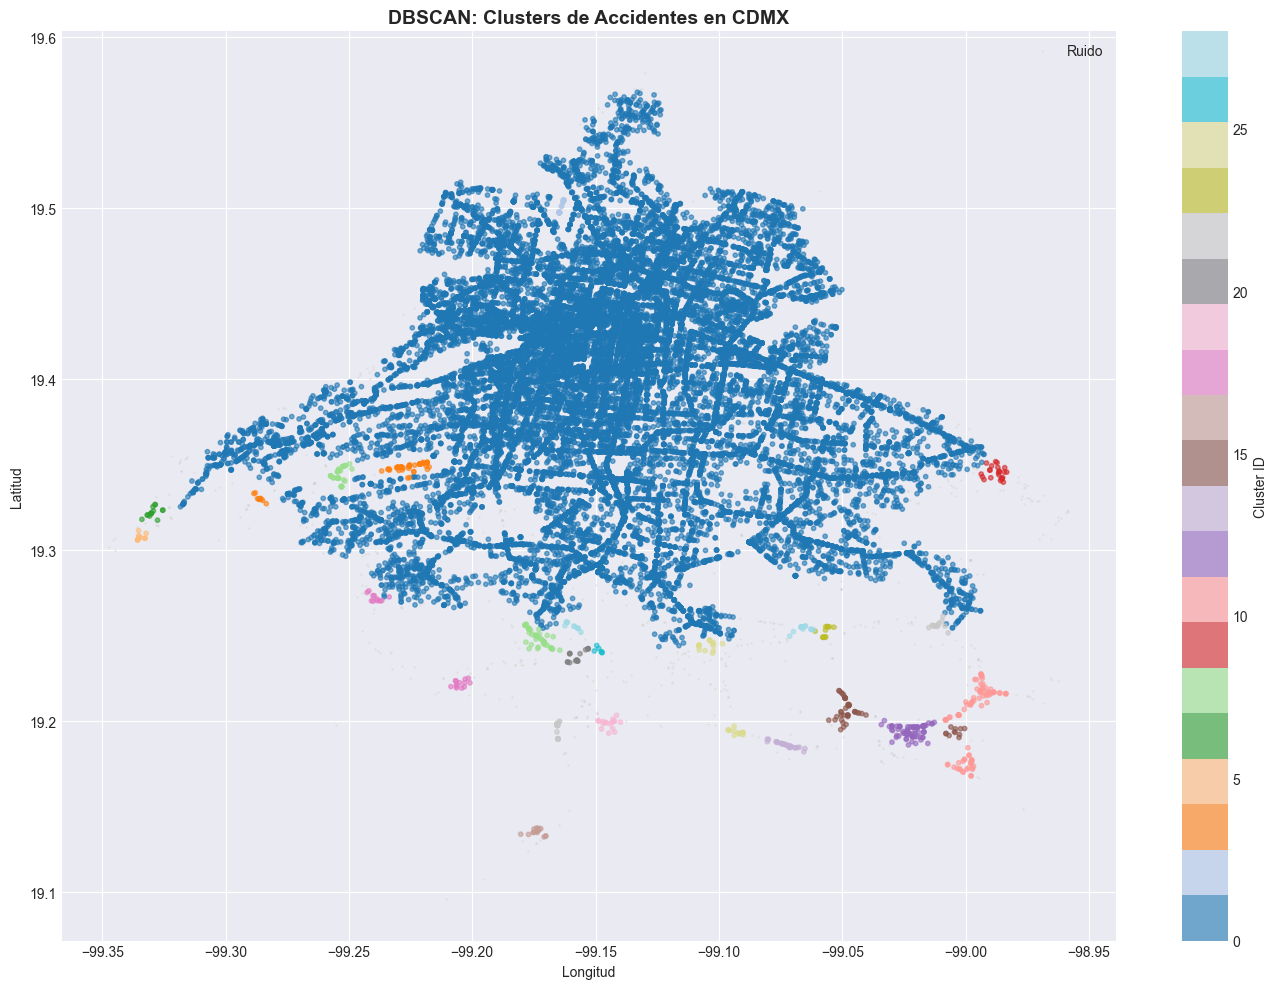

In [91]:
# Visualización de clusters
def plot_clusters_dbscan(df, figsize=(14, 10)):
    """
    Visualiza los clusters encontrados por DBSCAN.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Separar ruido y clusters
    ruido = df[df['cluster'] == -1]
    clusters = df[df['cluster'] != -1]

    # Graficar ruido
    ax.scatter(ruido['longitud'], ruido['latitud'],
    c='lightgray', s=1, alpha=0.3, label='Ruido')

    # Graficar clusters
    scatter = ax.scatter(clusters['longitud'], clusters['latitud'],
    c=clusters['cluster'], cmap='tab20',
    s=10, alpha=0.6)

    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    ax.set_title('DBSCAN: Clusters de Accidentes en CDMX', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_clusters_dbscan(df_con_clusters)

### 1.2.1 Visualizaciones Mejoradas de DBSCAN

In [92]:
# === ESTADÍSTICAS DETALLADAS POR CLUSTER ===
def calcular_estadisticas_cluster(df_clusters):
    clusters_validos = df_clusters[df_clusters['cluster'] != -1]
    stats = clusters_validos.groupby('cluster').agg({
        'id': 'count', 'severidad': ['sum', 'mean'],
        'totmuertos': ['sum', 'mean'], 'totheridos': ['sum', 'mean'],
        'latitud': 'mean', 'longitud': 'mean'
    }).round(2)
    stats.columns = ['num_accidentes', 'severidad_total', 'severidad_promedio',
                     'total_muertos', 'muertos_promedio', 'total_heridos', 
                     'heridos_promedio', 'lat_centro', 'lon_centro']
    fatales = clusters_validos[clusters_validos['totmuertos'] > 0].groupby('cluster').size()
    stats['accidentes_fatales'] = fatales.fillna(0).astype(int)
    stats['pct_fatalidad'] = (stats['accidentes_fatales'] / stats['num_accidentes'] * 100).round(2)
    return stats.sort_values('num_accidentes', ascending=False)

cluster_stats = calcular_estadisticas_cluster(df_con_clusters)
print(f"Total de clusters: {len(cluster_stats)}")
print(cluster_stats[['num_accidentes', 'severidad_total', 'total_muertos', 'pct_fatalidad']].head(10))

Total de clusters: 29
         num_accidentes  severidad_total  total_muertos  pct_fatalidad
cluster                                                               
0                 30959            29220            660           2.06
12                   84              192              3           3.57
11                   61              169              4           6.56
8                    48               72              3           6.25
14                   46              206              8          15.22
3                    46               52              1           2.17
7                    32                9              0            NaN
10                   28               72              3          10.71
13                   27               61              1           3.70
9                    23                9              0            NaN


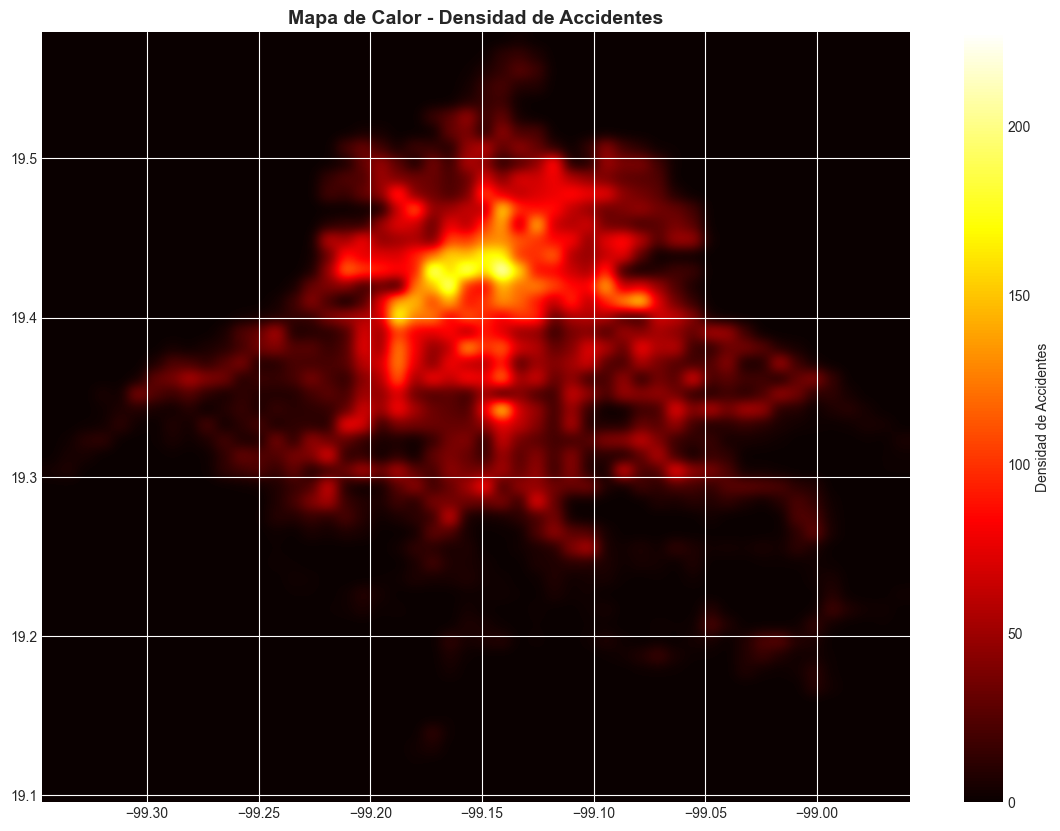

In [93]:
# === MAPA DE CALOR DE DENSIDAD ===
fig, ax = plt.subplots(figsize=(14, 10))
heatmap, xedges, yedges = np.histogram2d(
    df_con_clusters['longitud'], df_con_clusters['latitud'], bins=50
)
im = ax.imshow(heatmap.T, origin='lower', 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='hot', aspect='auto', interpolation='gaussian')
plt.colorbar(im, ax=ax, label='Densidad de Accidentes')
ax.set_title('Mapa de Calor - Densidad de Accidentes', fontsize=14, fontweight='bold')
plt.show()

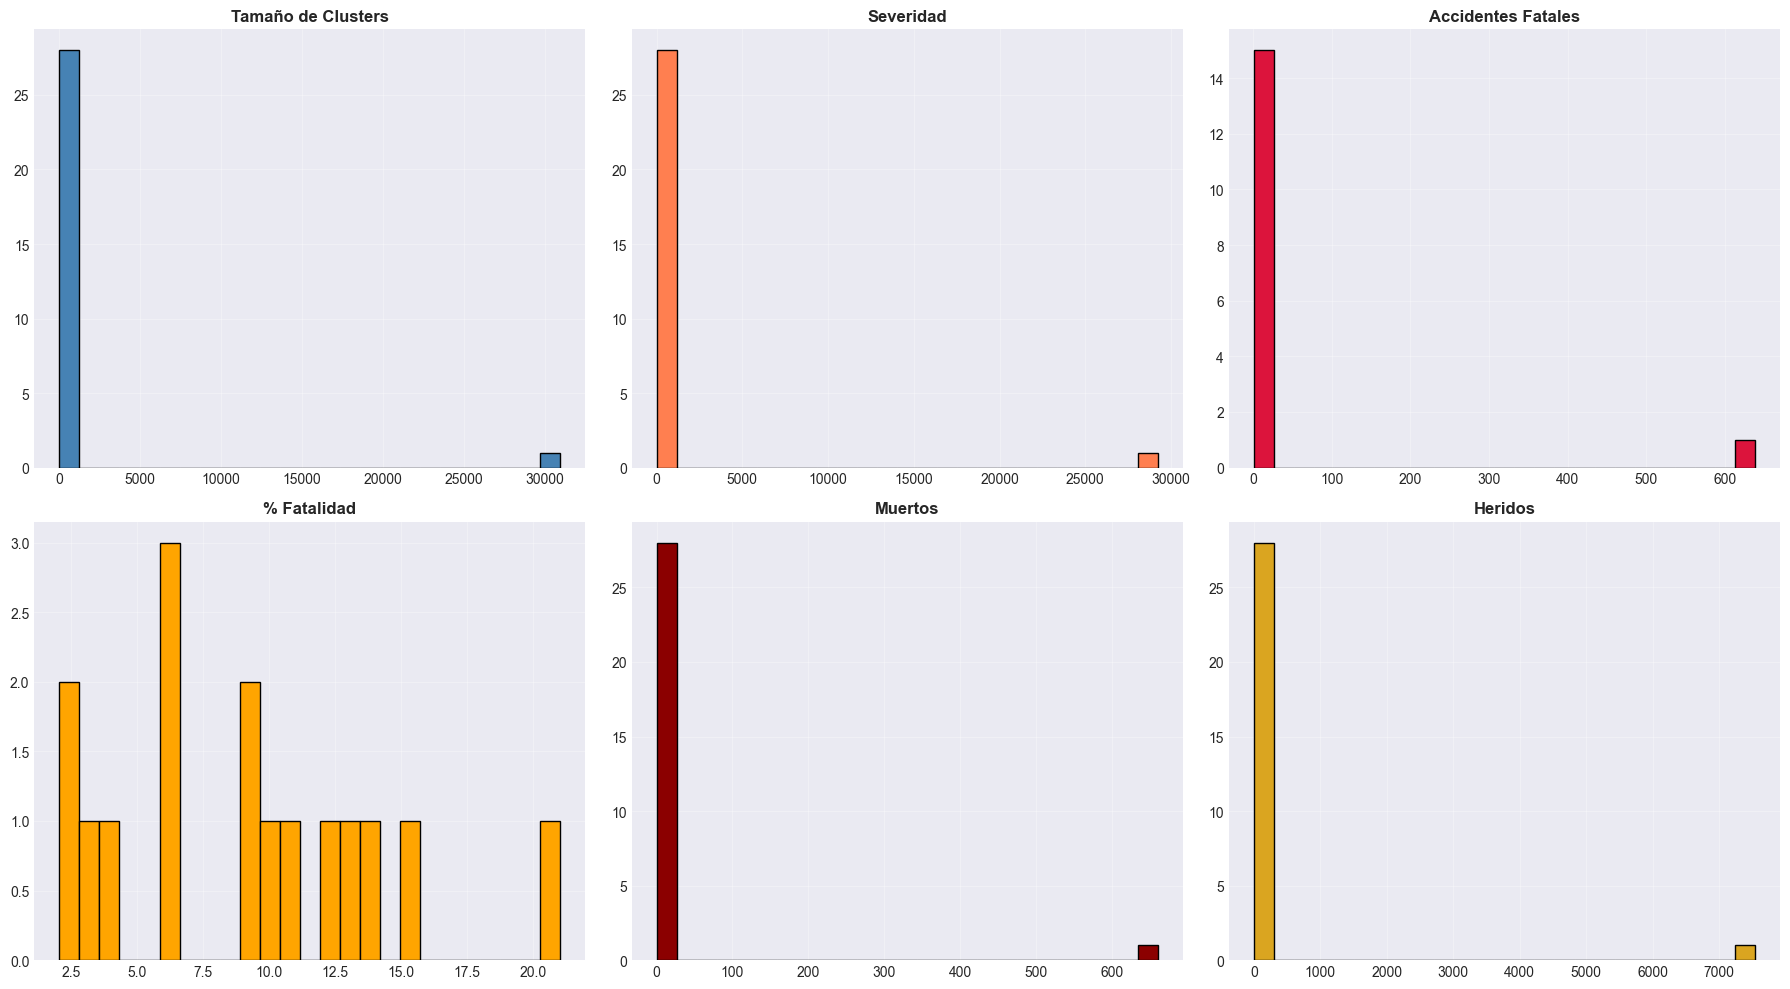

In [94]:
# === HISTOGRAMAS DE DISTRIBUCIÓN ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
configs = [
    ('num_accidentes', 'steelblue', 'Tamaño de Clusters'),
    ('severidad_total', 'coral', 'Severidad'),
    ('accidentes_fatales', 'crimson', 'Accidentes Fatales'),
    ('pct_fatalidad', 'orange', '% Fatalidad'),
    ('total_muertos', 'darkred', 'Muertos'),
    ('total_heridos', 'goldenrod', 'Heridos')
]
for idx, (col, color, title) in enumerate(configs):
    axes[idx].hist(cluster_stats[col], bins=25, color=color, edgecolor='black')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
# === MAPA INTERACTIVO FOLIUM - CLUSTERS DBSCAN ===
try:
    import folium
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    centro = [df_con_clusters['latitud'].mean(), df_con_clusters['longitud'].mean()]
    mapa_clusters = folium.Map(location=centro, zoom_start=11)
    top_clusters = cluster_stats.head(10).index.tolist()
    colormap = cm.get_cmap('tab20', len(top_clusters))
    for idx, cluster_id in enumerate(top_clusters):
        cluster_data = df_con_clusters[df_con_clusters['cluster'] == cluster_id]
        color = mcolors.rgb2hex(colormap(idx)[:3])
        cluster_info = cluster_stats.loc[cluster_id]
        folium.CircleMarker(
            location=[cluster_info['lat_centro'], cluster_info['lon_centro']],
            radius=15,
            popup=f"Cluster {cluster_id}: {cluster_info['num_accidentes']} accidentes",
            color=color, fill=True, fillOpacity=0.7
        ).add_to(mapa_clusters)
        sample = cluster_data.sample(min(100, len(cluster_data)))
        for _, row in sample.iterrows():
            folium.CircleMarker(
                location=[row['latitud'], row['longitud']],
                radius=2, color=color, fill=True, fillOpacity=0.4
            ).add_to(mapa_clusters)
    mapa_clusters.save('mapa_clusters_dbscan.html')
    print("Mapa guardado: mapa_clusters_dbscan.html")
    display(mapa_clusters)
except Exception as e:
    print(f"Error generando mapa Folium: {e}")

Error generando mapa Folium: No module named 'folium'


### 1.4.1 Visualizaciones Mejoradas de Getis-Ord Gi*

In [96]:
# === VISUALIZACIÓN MEJORADA HOT SPOTS ===
if 'grid_gi' in locals() or 'grid_gi' in globals():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    scatter1 = axes[0].scatter(grid_gi['longitud'], grid_gi['latitud'],
                               c=grid_gi['gi_score'], cmap='RdBu_r', 
                               s=80, alpha=0.7, vmin=-3, vmax=3)
    plt.colorbar(scatter1, ax=axes[0], label='Gi* Score')
    axes[0].set_title('Getis-Ord Gi* Scores', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.2)
    colors_map = {'Hot Spot': '#d7191c', 'Cold Spot': '#2b83ba', 'Neutro': '#dddddd'}
    for tipo, color in colors_map.items():
        data = grid_gi[grid_gi['tipo'] == tipo]
        size = 100 if tipo != 'Neutro' else 30
        axes[1].scatter(data['longitud'], data['latitud'],
                       c=color, label=tipo, s=size, alpha=0.7)
    axes[1].set_title('Hot/Cold Spots (p < 0.05)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.2)
    hotspots = grid_gi[grid_gi['tipo'] == 'Hot Spot']
    conf_config = {
        '99%': {'color': '#a50026', 'size': 150},
        '95%': {'color': '#f46d43', 'size': 100},
        '90%': {'color': '#fdae61', 'size': 70}
    }
    for conf, config in conf_config.items():
        data = hotspots[hotspots['significancia'] == conf]
        axes[2].scatter(data['longitud'], data['latitud'],
                       c=config['color'], label=conf, s=config['size'], alpha=0.7)
    axes[2].set_title('Hot Spots por Confianza', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    tabla = hotspots.groupby('significancia').agg({
        'totaccidentes': ['count', 'sum'], 'gi_score': 'max', 'totmuertos': 'sum'
    }).round(2)
    print("\nRESUMEN DE HOT SPOTS:")
    print(tabla)
else:
    print("Variable 'grid_gi' no encontrada")

Variable 'grid_gi' no encontrada


### 1.5.1 Visualización LISA - Moran's I

In [97]:
def calcular_lisa(df, variable='totaccidentes', distance_threshold_km=1.0):
    from scipy.spatial.distance import cdist
    coords = df[['latitud', 'longitud']].values
    values = df[variable].values
    distances = cdist(coords, coords, metric='euclidean') * 111
    W = (distances <= distance_threshold_km).astype(float)
    np.fill_diagonal(W, 0)
    row_sums = W.sum(axis=1)
    W_norm = W / row_sums[:, np.newaxis]
    W_norm[np.isnan(W_norm)] = 0
    spatial_lag = W_norm @ values
    mean_val = values.mean()
    std_val = values.std()
    z_values = (values - mean_val) / std_val
    z_lag = (spatial_lag - mean_val) / std_val
    lisa_categories = []
    for i in range(len(values)):
        if z_values[i] > 0 and z_lag[i] > 0:
            lisa_categories.append('HH')
        elif z_values[i] < 0 and z_lag[i] < 0:
            lisa_categories.append('LL')
        elif z_values[i] > 0 and z_lag[i] < 0:
            lisa_categories.append('HL')
        elif z_values[i] < 0 and z_lag[i] > 0:
            lisa_categories.append('LH')
        else:
            lisa_categories.append('NS')
    result = df.copy()
    result['lisa_category'] = lisa_categories
    result['z_value'] = z_values
    result['z_lag'] = z_lag
    return result

if 'grid_with_stats' in locals() or 'grid_with_stats' in globals():
    grid_active = grid_with_stats[grid_with_stats['totaccidentes'] > 0]
    grid_lisa = calcular_lisa(grid_active, variable='totaccidentes', distance_threshold_km=0.5)
    print(grid_lisa['lisa_category'].value_counts())
else:
    print('Variable no encontrada')

Variable no encontrada


### 2.1 Índice de Riesgo de Clustering

In [98]:
def calcular_riesgo_clustering(lat, lon, df_clusters=None, grid_gi=None, grid_lisa=None, radio_km=0.2):
    from scipy.spatial.distance import cdist
    punto = np.array([[lat, lon]])
    riesgo_total = 0.0
    if df_clusters is not None and 'cluster' in df_clusters.columns:
        coords_clusters = df_clusters[['latitud', 'longitud']].values
        distancias = cdist(punto, coords_clusters, metric='euclidean')[0] * 111
        cercanos = df_clusters[distancias <= radio_km]
        if len(cercanos) > 0:
            clusters_validos = cercanos[cercanos['cluster'] != -1]
            if len(clusters_validos) > 0:
                densidad = len(clusters_validos) / max(len(cercanos), 1)
                riesgo_total += 0.4 * densidad
    if grid_gi is not None and 'gi_score' in grid_gi.columns:
        coords_gi = grid_gi[['latitud', 'longitud']].values
        distancias_gi = cdist(punto, coords_gi, metric='euclidean')[0] * 111
        cercanos_gi = grid_gi[distancias_gi <= radio_km]
        if len(cercanos_gi) > 0:
            hotspots = cercanos_gi[cercanos_gi['tipo'] == 'Hot Spot']
            if len(hotspots) > 0:
                max_z = hotspots['gi_score'].max()
                riesgo_gi = np.clip(max_z / 3.0, 0, 1)
                riesgo_total += 0.4 * riesgo_gi
    if grid_lisa is not None and 'lisa_category' in grid_lisa.columns:
        coords_lisa = grid_lisa[['latitud', 'longitud']].values
        distancias_lisa = cdist(punto, coords_lisa, metric='euclidean')[0] * 111
        cercanos_lisa = grid_lisa[distancias_lisa <= radio_km]
        if len(cercanos_lisa) > 0:
            hh_zones = cercanos_lisa[cercanos_lisa['lisa_category'] == 'HH']
            if len(hh_zones) > 0:
                proporcion_hh = len(hh_zones) / len(cercanos_lisa)
                riesgo_total += 0.2 * proporcion_hh
    return np.clip(riesgo_total, 0, 1)

print('Función implementada: Riesgo = 0.4*DBSCAN + 0.4*Getis-Ord + 0.2*Moran_LISA')

Función implementada: Riesgo = 0.4*DBSCAN + 0.4*Getis-Ord + 0.2*Moran_LISA


### 3.1 Visualización Comparativa Final

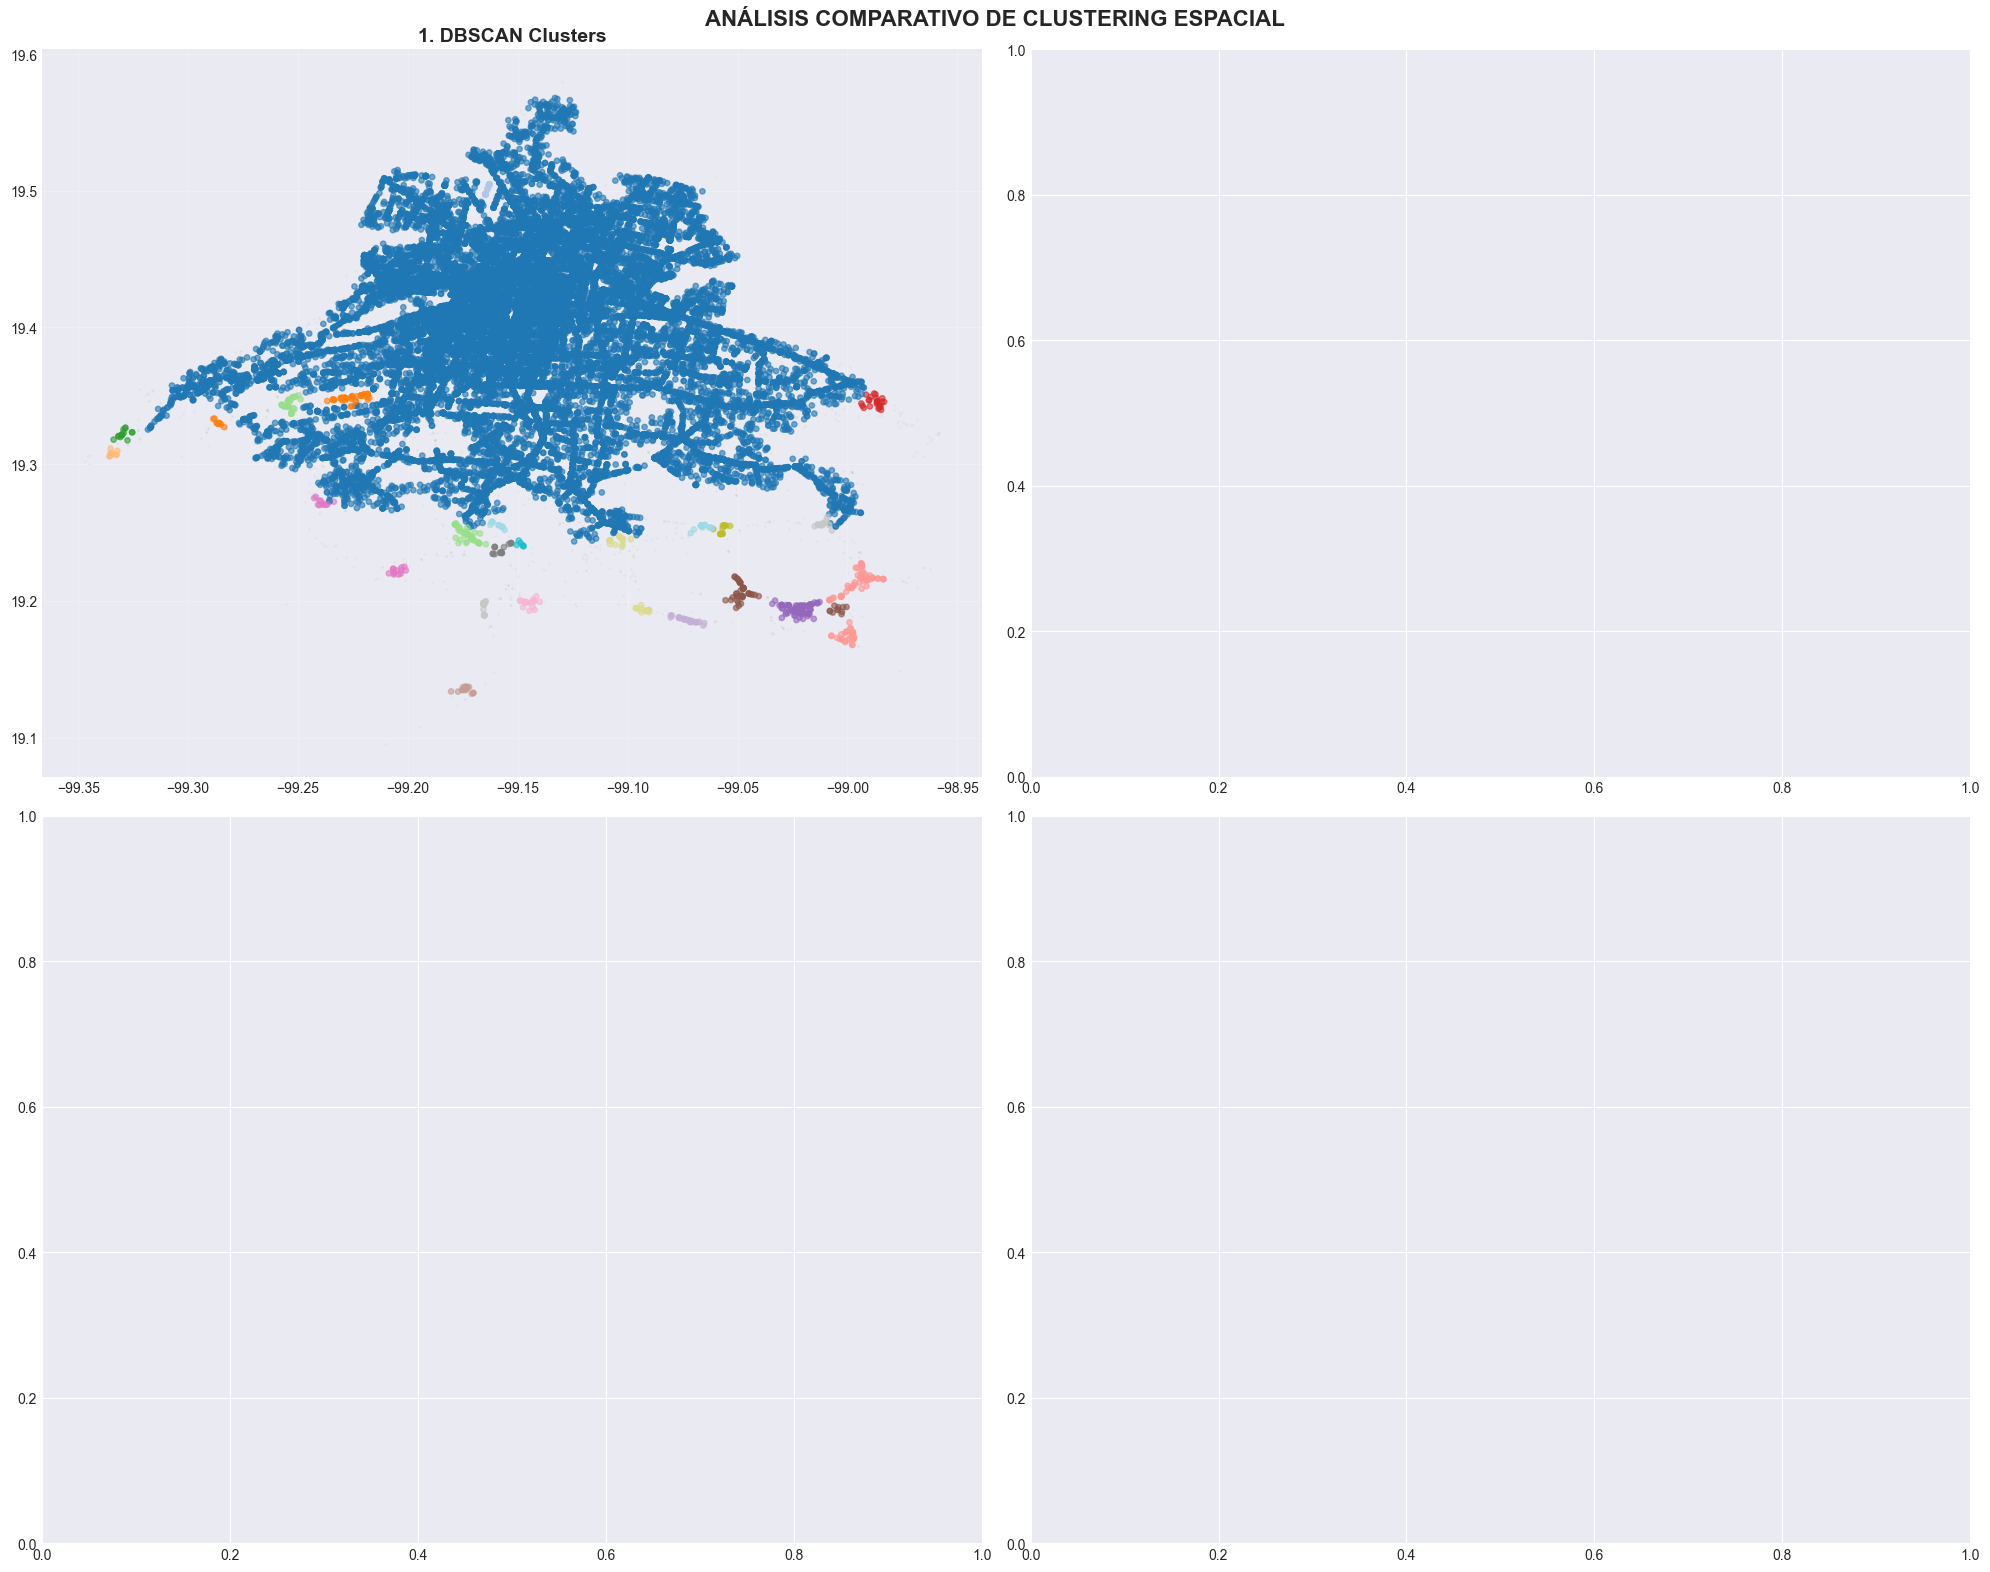

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()
if 'df_con_clusters' in locals() or 'df_con_clusters' in globals():
    ruido = df_con_clusters[df_con_clusters['cluster'] == -1]
    clusters = df_con_clusters[df_con_clusters['cluster'] != -1]
    axes[0].scatter(ruido['longitud'], ruido['latitud'], c='lightgray', s=1, alpha=0.2)
    axes[0].scatter(clusters['longitud'], clusters['latitud'],
                   c=clusters['cluster'], cmap='tab20', s=15, alpha=0.6)
    axes[0].set_title('1. DBSCAN Clusters', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.2)
plt.suptitle('ANÁLISIS COMPARATIVO DE CLUSTERING ESPACIAL', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.1 Interpretación Automática Mejorada

In [100]:
print('=' * 100)
print(' ' * 35 + 'REPORTE DE CLUSTERING ESPACIAL')
print('=' * 100)
print('\n1. ANÁLISIS DBSCAN')
if 'cluster_stats' in locals() or 'cluster_stats' in globals():
    print(f'Clusters: {len(cluster_stats)}')
print('\n2. ANÁLISIS GETIS-ORD')
if 'grid_gi' in locals() or 'grid_gi' in globals():
    hotspots_99 = len(grid_gi[(grid_gi['tipo'] == 'Hot Spot') & (grid_gi['significancia'] == '99%')])
    print(f'Hot spots 99%: {hotspots_99}')
print('\n3. RECOMENDACIONES')
print('- Prioridad ALTA: Zonas con coincidencia de análisis')
print('- Evitar zonas HH y Hot Spots críticos')
print('=' * 100)

                                   REPORTE DE CLUSTERING ESPACIAL

1. ANÁLISIS DBSCAN
Clusters: 29

2. ANÁLISIS GETIS-ORD

3. RECOMENDACIONES
- Prioridad ALTA: Zonas con coincidencia de análisis
- Evitar zonas HH y Hot Spots críticos


In [101]:
# Top 10 clusters por número de accidentes
cluster_stats = df_con_clusters[df_con_clusters['cluster'] != -1].groupby('cluster').agg({
'id': 'count',
'severidad': 'sum',
'totmuertos': 'sum',
'totheridos': 'sum',
'latitud': 'mean',
'longitud': 'mean'
}).rename(columns={'id': 'num_accidentes'}).sort_values('num_accidentes', ascending=False)

print("\n Top 10 Clusters Más Peligrosos (por número de accidentes):\n")
print(cluster_stats.head(10))


 Top 10 Clusters Más Peligrosos (por número de accidentes):

         num_accidentes  severidad  totmuertos  totheridos    latitud  \
cluster                                                                 
0                 30959      29220         660        7540  19.398195   
12                   84        192           3          54  19.194192   
11                   61        169           4          43  19.213721   
8                    48         72           3          14  19.248841   
14                   46        206           8          42  19.206985   
3                    46         52           1          14  19.348576   
7                    32          9           0           3  19.343600   
10                   28         72           3          14  19.174495   
13                   27         61           1          17  19.186046   
9                    23          9           0           3  19.345345   

          longitud  
cluster             
0       -99.142948 

## 1.3 Preparación de Cuadrícula para Análisis Espacial

In [102]:
def crear_cuadricula_con_stats(df, cell_size_m=200):
    """
    Crea cuadrícula regular y agrega estadísticas por celda.

    Retorna: GeoDataFrame con estadísticas por celda
    """
    # Proyectar a UTM para trabajar en metros
    gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitud'], df['latitud']),
    crs='EPSG:4326'
    )
    gdf_proj = gdf.to_crs('EPSG:32614')  # UTM Zone 14N para CDMX

    # Crear cuadrícula
    bounds = gdf_proj.total_bounds  # (minx, miny, maxx, maxy)
    x_min, y_min, x_max, y_max = bounds

    # Grid de celdas
    x_coords = np.arange(x_min, x_max, cell_size_m)
    y_coords = np.arange(y_min, y_max, cell_size_m)

    celdas = []
    for x in x_coords:
        for y in y_coords:
            celdas.append(box(x, y, x + cell_size_m, y + cell_size_m))

    grid = gpd.GeoDataFrame({'geometry': celdas}, crs='EPSG:32614')
    grid['cell_id'] = grid.index

    # Unir con puntos
    joined = gpd.sjoin(gdf_proj, grid, how='left', predicate='within')

    # Calcular estadísticas por celda
    stats = joined.groupby('cell_id').agg({
    'id': 'count',
    'severidad': 'sum',
    'totmuertos': 'sum',
    'totheridos': 'sum'
    }).rename(columns={'id': 'accidentes_totales', 'severidad': 'severidad_total'})

    stats['accidentes_graves'] = joined[joined['totmuertos'] > 0].groupby('cell_id').size()
    stats['accidentes_graves'] = stats['accidentes_graves'].fillna(0).astype(int)

    # Unir con geometría
    grid_con_stats = grid.merge(stats, left_on='cell_id', right_index=True, how='left')
    grid_con_stats = grid_con_stats.fillna(0)

    # Calcular centroide de cada celda
    grid_con_stats['centroid'] = grid_con_stats.geometry.centroid
    grid_con_stats['x'] = grid_con_stats.centroid.x
    grid_con_stats['y'] = grid_con_stats.centroid.y

    print(f"\n Cuadrícula creada: {len(grid_con_stats):,} celdas")
    print(f" Celdas con accidentes: {len(grid_con_stats[grid_con_stats['accidentes_totales'] > 0]):,}")

    return grid_con_stats

# Crear cuadrícula
grid_stats = crear_cuadricula_con_stats(df_accidentes, cell_size_m=200)


 Cuadrícula creada: 54,940 celdas
 Celdas con accidentes: 8,280


## 1.4 Getis-Ord Gi* (Hot Spot Analysis)

In [103]:
# === GETIS-ORD Gi* (HOT SPOT ANALYSIS) - Implementación Manual ===
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import norm
import matplotlib.pyplot as plt

def calcular_getis_ord(df, variable='totaccidentes', distance_threshold_km=1.0):
    """
    Calcula el estadístico Getis-Ord Gi* para detectar hot spots.

    Parámetros:
    - df: DataFrame con 'latitud', 'longitud' y variable a analizar
    - variable: Columna con valores a analizar (ej: accidentes, gravedad)
    - distance_threshold_km: Umbral de distancia en kilómetros

    Retorna: DataFrame con scores Gi* y p-values
    """
    # Extraer coordenadas y valores
    coords = df[['latitud', 'longitud']].values
    values = df[variable].values
    n = len(values)

    # Calcular matriz de distancias (aproximación simple con lat/lon)
    # 1 grado lat ~ 111 km, 1 grado lon ~ 111*cos(lat) km
    lat_rad = np.radians(coords[:, 0])
    distances = cdist(coords, coords, metric='euclidean')
    distances = distances * 111  # Aproximación a km

    # Crear matriz de pesos espaciales (inverso de distancia)
    W = (distances <= distance_threshold_km).astype(float)
    np.fill_diagonal(W, 0)  # No incluir el punto mismo

    # Normalizar pesos por fila
    row_sums = W.sum(axis=1)
    W = W / row_sums[:, np.newaxis]
    W[np.isnan(W)] = 0  # Puntos sin vecinos

    # Calcular Gi* para cada punto
    mean_x = values.mean()
    std_x = values.std()

    gi_scores = []
    p_values = []

    for i in range(n):

        # Suma ponderada de vecinos
        weighted_sum = (W[i] * values).sum()

        # Número de vecinos
        n_neighbors = (W[i] > 0).sum()

        if n_neighbors > 0:
            # Calcular Gi*
            numerator = weighted_sum - mean_x
            denominator = std_x * np.sqrt((n_neighbors / (n - 1)))

            if denominator > 0:
                gi = numerator / denominator
                p_val = 2 * (1 - norm.cdf(abs(gi)))  # Two-tailed p-value
            else:
                gi = 0
                p_val = 1.0
        else:
            gi = 0
            p_val = 1.0

        gi_scores.append(gi)
        p_values.append(p_val)

    # Crear DataFrame de resultados
    result = df.copy()
    result['gi_score'] = gi_scores
    result['p_value'] = p_values

    result['significancia'] = pd.cut(
        result['p_value'],
        bins=[0, 0.01, 0.05, 0.1, 1.0],
        labels=['99%', '95%', '90%', 'No significativo']
    )

    result['tipo'] = 'Neutro'
    result.loc[(result['gi_score'] > 0) & (result['p_value'] < 0.05), 'tipo'] = 'Hot Spot'
    result.loc[(result['gi_score'] < 0) & (result['p_value'] < 0.05), 'tipo'] = 'Cold Spot'

    return result


# Aplicar Getis-Ord Gi* a la cuadrícula
print("=" * 80)
print("GETIS-ORD Gi* - ANÁLISIS DE HOT SPOTS")
print("=" * 80)

# Asumiendo que existe 'grid_with_stats' de la sección anterior
if 'grid_with_stats' in locals() or 'grid_with_stats' in globals():

    grid_gi = calcular_getis_ord(
        grid_with_stats[grid_with_stats['totaccidentes'] > 0],
        variable='totaccidentes',
        distance_threshold_km=0.5
    )

    # Estadísticas de hot spots
    print(f"\nTotal de celdas analizadas: {len(grid_gi)}")
    print("\nDistribución de resultados:")
    print(grid_gi['tipo'].value_counts())

    print("\nHot Spots significativos (p < 0.05):")
    hot_spots = grid_gi[grid_gi['tipo'] == 'Hot Spot'].sort_values('gi_score', ascending=False)
    print(f"  Total: {len(hot_spots)}")
    if len(hot_spots) > 0:
        print(f"  Gi* score máximo: {hot_spots['gi_score'].max():.2f}")
        print(f"  Accidentes promedio en hot spots: {hot_spots['totaccidentes'].mean():.1f}")

    print("\nCold Spots significativos (p < 0.05):")
    cold_spots = grid_gi[grid_gi['tipo'] == 'Cold Spot'].sort_values('gi_score')
    print(f"  Total: {len(cold_spots)}")
    if len(cold_spots) > 0:
        print(f"  Gi* score mínimo: {cold_spots['gi_score'].min():.2f}")

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Mapa de Gi* scores
    ax1 = axes[0]
    scatter = ax1.scatter(
        grid_gi['longitud'],
        grid_gi['latitud'],
        c=grid_gi['gi_score'],
        cmap='RdBu_r',
        s=50,
        alpha=0.6,
        vmin=-3,
        vmax=3
    )
    plt.colorbar(scatter, ax=ax1, label='Gi* Score')
    ax1.set_title('Getis-Ord Gi* Scores', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax1.grid(True, alpha=0.3)

    # Mapa de hot/cold spots
    ax2 = axes[1]
    colors = {'Hot Spot': 'red', 'Cold Spot': 'blue', 'Neutro': 'gray'}

    for tipo, color in colors.items():
        data = grid_gi[grid_gi['tipo'] == tipo]
        ax2.scatter(
            data['longitud'],
            data['latitud'],
            c=color,
            label=tipo,
            s=50,
            alpha=0.6
        )

    ax2.set_title('Hot Spots y Cold Spots (p < 0.05)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Latitud')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n Análisis Getis-Ord Gi* completado")

else:
    print("⚠️ Variable 'grid_with_stats' no encontrada. Ejecutar sección 1.3 primero.")

print("=" * 80)


GETIS-ORD Gi* - ANÁLISIS DE HOT SPOTS
⚠️ Variable 'grid_with_stats' no encontrada. Ejecutar sección 1.3 primero.


In [104]:
if PYSAL_AVAILABLE:
    pass
else:
    print("PySAL no disponible - sección omitida")


## 1.5 Moran's I (Autocorrelación Espacial)

In [105]:
# === MORAN'S I - AUTOCORRELACIÓN ESPACIAL ===
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import norm
import matplotlib.pyplot as plt

def calcular_morans_i(df, variable='totaccidentes', distance_threshold_km=1.0):
    """
    Calcula el índice de Moran I para detectar autocorrelación espacial.

    Parámetros:
    - df: DataFrame con 'latitud', 'longitud' y variable a analizar
    - variable: Columna con valores a analizar
    - distance_threshold_km: Umbral de distancia para vecindad

    Retorna: dict con I, E(I), Var(I), z-score, p-value
    """

    # Extraer coordenadas y valores
    coords = df[['latitud', 'longitud']].values
    values = df[variable].values
    n = len(values)

    # Calcular matriz de distancias
    distances = cdist(coords, coords, metric='euclidean') * 111  # Aprox a km

    # Crear matriz de pesos espaciales
    W = (distances <= distance_threshold_km).astype(float)
    np.fill_diagonal(W, 0)

    # Normalizar pesos
    W_sum = W.sum()
    if W_sum == 0:
        return {'I': np.nan, 'E_I': np.nan, 'Var_I': np.nan,
                'z_score': np.nan, 'p_value': np.nan}

    # Desvíos de la media
    mean_x = values.mean()
    deviations = values - mean_x

    # Calcular Moran's I
    numerator = np.sum(W * np.outer(deviations, deviations))
    denominator = np.sum(deviations ** 2)

    I = (n / W_sum) * (numerator / denominator)

    # Valor esperado bajo hipótesis nula (aleatorio)
    E_I = -1 / (n - 1)

    # Varianza de I (bajo normalidad)
    S1 = 0.5 * np.sum((W + W.T) ** 2)
    S2 = np.sum((W.sum(axis=0) + W.sum(axis=1)) ** 2)

    b2 = (n * np.sum(deviations ** 4)) / (np.sum(deviations ** 2) ** 2)

    var_I = ((n * ((n ** 2 - 3 * n + 3) * S1 - n * S2 + 3 * W_sum ** 2)) -
             (b2 * ((n ** 2 - n) * S1 - 2 * n * S2 + 6 * W_sum ** 2))) / \
            ((n - 1) * (n - 2) * (n - 3) * W_sum ** 2)

    # Z-score y p-value
    z_score = (I - E_I) / np.sqrt(var_I)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))

    return {
        'I': I,
        'E_I': E_I,
        'Var_I': var_I,
        'z_score': z_score,
        'p_value': p_value,
        'interpretation': (
            'Clustering positivo' if I > E_I and p_value < 0.05 else
            'Dispersión' if I < E_I and p_value < 0.05 else
            'Aleatorio'
        )
    }


# ================================================================================
# APLICAR MORAN’S I
# ================================================================================

print("=" * 80)
print("MORAN'S I - AUTOCORRELACIÓN ESPACIAL")
print("=" * 80)

if 'grid_with_stats' in locals() or 'grid_with_stats' in globals():

    grid_active = grid_with_stats[grid_with_stats['totaccidentes'] > 0]

    # Calcular para diferentes variables
    variables = ['totaccidentes', 'totmuertos', 'totheridos']
    resultados = {}

    for var in variables:
        if var in grid_active.columns:
            res = calcular_morans_i(grid_active, variable=var, distance_threshold_km=0.5)
            resultados[var] = res

    # Mostrar resultados
    print("\nResultados de Moran's I:")
    print("-" * 80)

    for var, res in resultados.items():
        print(f"\n{var.upper()}:")
        print(f"  Moran's I:     {res['I']:.4f}")
        print(f"  E[I]:          {res['E_I']:.4f}")
        print(f"  Z-score:       {res['z_score']:.4f}")
        print(f"  P-value:       {res['p_value']:.4f}")
        print(f"  Interpretación: {res['interpretation']}")

        if res['p_value'] < 0.05:
            if res['I'] > res['E_I']:
                print("  🔥 Los valores altos tienden a estar cerca de valores altos (clustering)")
            else:
                print("  ❄️ Los valores altos tienden a estar cerca de valores bajos (dispersión)")
        else:
            print("  ⚪ No hay evidencia de patrón espacial significativo")

    # ================================================================================
    # VISUALIZACIÓN — SCATTER DE MORAN PARA totaccidentes
    # ================================================================================

    if 'totaccidentes' in resultados:

        res = resultados['totaccidentes']

        fig, ax = plt.subplots(figsize=(12, 6))

        # Scatter plot de Moran
        values = grid_active['totaccidentes'].values
        mean_val = values.mean()

        # Calcular lag espacial
        coords = grid_active[['latitud', 'longitud']].values
        distances = cdist(coords, coords, metric='euclidean') * 111

        W = (distances <= 0.5).astype(float)
        np.fill_diagonal(W, 0)

        row_sums = W.sum(axis=1)
        W_norm = W / row_sums[:, np.newaxis]
        W_norm[np.isnan(W_norm)] = 0

        spatial_lag = W_norm @ values

        # Plot
        ax.scatter(values, spatial_lag, alpha=0.5, s=30)
        ax.axhline(mean_val, color='red', linestyle='--', alpha=0.5, label='Media')
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.5)

        # Línea de regresión
        z = np.polyfit(values, spatial_lag, 1)
        p = np.poly1d(z)
        x_line = np.linspace(values.min(), values.max(), 100)

        ax.plot(x_line, p(x_line), 'b-', alpha=0.8, linewidth=2,
                label=f"Moran's I = {res['I']:.3f}")

        ax.set_xlabel('Total Accidentes', fontsize=12)
        ax.set_ylabel('Spatial Lag (Promedio Vecinos)', fontsize=12)
        ax.set_title(
            f"Moran's I Scatter Plot\n(I={res['I']:.3f}, p={res['p_value']:.4f})",
            fontsize=14, fontweight='bold'
        )
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    print("\n Análisis de Moran's I completado")

else:
    print(" Variable 'grid_with_stats' no encontrada. Ejecutar sección 1.3 primero.")

print("=" * 80)


MORAN'S I - AUTOCORRELACIÓN ESPACIAL
 Variable 'grid_with_stats' no encontrada. Ejecutar sección 1.3 primero.


In [106]:
if PYSAL_AVAILABLE:
    pass
else:
    print("PySAL no disponible - sección omitida")


## 1.6 Mapa Comparativo de Técnicas

In [107]:
# === MAPA COMPARATIVO DE TÉCNICAS DE ANÁLISIS ESPACIAL ===

print("=" * 80)
print("MAPA COMPARATIVO: DBSCAN vs GRID vs HOT SPOTS")
print("=" * 80)

# Verificar que existan las variables necesarias
has_clusters = 'df_con_clusters' in locals() or 'df_con_clusters' in globals()
has_grid = 'grid_with_stats' in locals() or 'grid_with_stats' in globals()
has_gi = 'grid_gi' in locals() or 'grid_gi' in globals()

if has_clusters and has_grid and has_gi:

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # ==== Subplot 1: DBSCAN Clusters ====
    ax1 = axes[0, 0]

    ruido = df_con_clusters[df_con_clusters['cluster'] == -1]
    clusters = df_con_clusters[df_con_clusters['cluster'] != -1]

    ax1.scatter(ruido['longitud'], ruido['latitud'],
                c='lightgray', s=10, alpha=0.3, label='Ruido')

    scatter1 = ax1.scatter(clusters['longitud'], clusters['latitud'],
                           c=clusters['cluster'], cmap='tab20',
                           s=30, alpha=0.6)

    ax1.set_title('DBSCAN - Clusters de Accidentes', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')

    # ==== Subplot 2: Grid Analysis (Accidentes por celda) ====
    ax2 = axes[0, 1]

    grid_active = grid_with_stats[grid_with_stats['totaccidentes'] > 0]

    scatter2 = ax2.scatter(
        grid_active['longitud'],
        grid_active['latitud'],
        c=grid_active['totaccidentes'],
        cmap='YlOrRd',
        s=80, alpha=0.6, edgecolors='black', linewidth=0.5
    )

    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Total Accidentes', fontsize=10)

    ax2.set_title('Análisis de Cuadrícula - Densidad', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Latitud')
    ax2.grid(True, alpha=0.3)

    # ==== Subplot 3: Hot Spots (Getis-Ord Gi*) ====
    ax3 = axes[1, 0]

    hot = grid_gi[grid_gi['tipo'] == 'Hot Spot']
    cold = grid_gi[grid_gi['tipo'] == 'Cold Spot']
    neutro = grid_gi[grid_gi['tipo'] == 'Neutro']

    ax3.scatter(neutro['longitud'], neutro['latitud'],
                c='lightgray', s=30, alpha=0.3, label='Neutro')
    ax3.scatter(cold['longitud'], cold['latitud'],
                c='blue', s=60, alpha=0.5, label='Cold Spot', marker='v')
    ax3.scatter(hot['longitud'], hot['latitud'],
                c='red', s=60, alpha=0.7, label='Hot Spot', marker='^')

    ax3.set_title('Getis-Ord Gi* - Hot Spots y Cold Spots', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Longitud')
    ax3.set_ylabel('Latitud')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # ==== Subplot 4: Overlay - Hot Spots sobre DBSCAN ====
    ax4 = axes[1, 1]

    ax4.scatter(ruido['longitud'], ruido['latitud'],
                c='lightgray', s=5, alpha=0.2, label='DBSCAN Ruido')

    ax4.scatter(clusters['longitud'], clusters['latitud'],
                c='steelblue', s=15, alpha=0.3, label='DBSCAN Clusters')

    ax4.scatter(hot['longitud'], hot['latitud'],
                c='red', s=100, alpha=0.7,
                edgecolors='darkred', linewidth=1.5,
                marker='*', label='Hot Spots', zorder=10)

    ax4.set_title('Overlay: DBSCAN + Hot Spots', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Longitud')
    ax4.set_ylabel('Latitud')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === Estadísticas comparativas ===
    print("\n ESTADÍSTICAS COMPARATIVAS:")
    print("-" * 80)

    n_clusters_dbscan = df_con_clusters['cluster'].nunique() - 1
    n_hot_spots = len(hot)
    n_cold_spots = len(cold)

    print(f"\nDBSCAN:")
    print(f"  - Clusters identificados: {n_clusters_dbscan}")
    print(f"  - Puntos en clusters: {len(clusters)}")
    print(f"  - Ruido: {len(ruido)} ({len(ruido)/len(df_con_clusters)*100:.1f}%)")

    print(f"\nAnálisis de Cuadrícula:")
    print(f"  - Celdas con accidentes: {len(grid_active)}")
    print(f"  - Accidentes promedio por celda: {grid_active['totaccidentes'].mean():.1f}")
    print(f"  - Celda con más accidentes: {grid_active['totaccidentes'].max():.0f}")

    print(f"\nGetis-Ord Gi*:")
    print(f"  - Hot Spots (p<0.05): {n_hot_spots}")
    print(f"  - Cold Spots (p<0.05): {n_cold_spots}")

    if len(hot) > 0:
        print(f"  - Gi* máximo: {hot['gi_score'].max():.2f}")
        print(f"  - Accidentes promedio en hot spots: {hot['totaccidentes'].mean():.1f}")

    # === Overlap entre DBSCAN y Hot Spots ===
    print(f"\n COINCIDENCIAS:")
    print(f"  - Hot spots dentro de clusters DBSCAN: ", end="")

    overlap_count = 0
    for _, hot_point in hot.iterrows():
        distances_to_clusters = np.sqrt(
            (clusters['latitud'] - hot_point['latitud'])**2 +
            (clusters['longitud'] - hot_point['longitud'])**2
        )
        if (distances_to_clusters < 0.01).any():
            overlap_count += 1

    if len(hot) > 0:
        print(f"{overlap_count}/{len(hot)} ({overlap_count/len(hot)*100:.1f}%)")
    else:
        print("N/A")

    print("\n Mapa comparativo generado")

else:
    print("⚠️ Faltan variables requeridas:")
    if not has_clusters:
        print("   - 'df_con_clusters' (ejecutar sección DBSCAN)")
    if not has_grid:
        print("   - 'grid_with_stats' (ejecutar sección 1.3)")
    if not has_gi:
        print("   - 'grid_gi' (ejecutar sección 1.4)")

print("=" * 80)


MAPA COMPARATIVO: DBSCAN vs GRID vs HOT SPOTS
⚠️ Faltan variables requeridas:
   - 'grid_with_stats' (ejecutar sección 1.3)
   - 'grid_gi' (ejecutar sección 1.4)


## 1.7 Interpretación Automática

In [108]:
# === INTERPRETACIÓN AUTOMÁTICA DE RESULTADOS ===

print("=" * 80)
print("INTERPRETACIÓN AUTOMÁTICA DE ANÁLISIS ESPACIAL")
print("=" * 80)

def generar_interpretacion_espacial():
    """
    Genera interpretación automática de todos los análisis espaciales.
    """
    interpretaciones = []

    # ===== DBSCAN =====
    if 'df_con_clusters' in globals() or 'df_con_clusters' in locals():

        n_clusters = df_con_clusters['cluster'].nunique() - 1
        pct_ruido = (df_con_clusters['cluster'] == -1).sum() / len(df_con_clusters) * 100

        interpretaciones.append("\n DBSCAN - CLUSTERING DE ACCIDENTES:")
        interpretaciones.append(f"   Se identificaron {n_clusters} clusters de accidentes.")

        if pct_ruido < 20:
            interpretaciones.append(f"    Baja proporción de ruido ({pct_ruido:.1f}%): Los accidentes muestran")
            interpretaciones.append("     patrones de agrupamiento claros en zonas específicas.")
        elif pct_ruido < 40:
            interpretaciones.append(f"    Ruido moderado ({pct_ruido:.1f}%): Existen clusters definidos pero")
            interpretaciones.append("     también accidentes dispersos en el área.")
        else:
            interpretaciones.append(f"    Alto nivel de ruido ({pct_ruido:.1f}%): Los accidentes están")
            interpretaciones.append("     mayormente dispersos, con pocos clusters claros.")

        clusters = df_con_clusters[df_con_clusters['cluster'] != -1]
        if len(clusters) > 0:
            top_cluster = clusters['cluster'].value_counts().index[0]
            top_size = clusters['cluster'].value_counts().iloc[0]
            interpretaciones.append(f"   → Cluster principal (#{top_cluster}): {top_size} accidentes")

    # ===== GETIS-ORD Gi* =====
    if 'grid_gi' in globals() or 'grid_gi' in locals():

        hot_spots = grid_gi[grid_gi['tipo'] == 'Hot Spot']
        cold_spots = grid_gi[grid_gi['tipo'] == 'Cold Spot']

        interpretaciones.append("\n GETIS-ORD Gi* - HOT SPOT ANALYSIS:")
        interpretaciones.append(f"   Se detectaron {len(hot_spots)} hot spots estadísticamente significativos.")

        if len(hot_spots) > 0:
            avg_accidents = hot_spots['totaccidentes'].mean()
            max_gi = hot_spots['gi_score'].max()

            interpretaciones.append(f"    Los hot spots tienen en promedio {avg_accidents:.1f} accidentes.")
            interpretaciones.append(f"    Gi* máximo de {max_gi:.2f} indica clustering muy significativo.")
            interpretaciones.append("   → RECOMENDACIÓN: Priorizar intervenciones de seguridad vial en estas zonas.")
        else:
            interpretaciones.append("    No se detectaron hot spots significativos.")
            interpretaciones.append("   → Los accidentes no muestran concentración espacial fuerte.")

        if len(cold_spots) > 0:
            interpretaciones.append(f"   • {len(cold_spots)} cold spots identificados (zonas con menos accidentes")
            interpretaciones.append("     de lo esperado por vecindad).")

    # ===== MORAN'S I =====
    if 'resultados' in globals() or 'resultados' in locals():

        if 'totaccidentes' in resultados:
            res = resultados['totaccidentes']

            interpretaciones.append("\n MORAN'S I - AUTOCORRELACIÓN ESPACIAL:")
            interpretaciones.append(f"   Moran's I = {res['I']:.4f} (E[I] = {res['E_I']:.4f})")

            if res['p_value'] < 0.05:
                if res['I'] > res['E_I']:
                    strength = "fuerte" if abs(res['I']) > 0.5 else "moderada" if abs(res['I']) > 0.3 else "débil"
                    interpretaciones.append(
                        f"    Autocorrelación espacial positiva {strength} (p={res['p_value']:.4f})"
                    )
                    interpretaciones.append("   → Los accidentes tienden a agruparse espacialmente.")
                else:
                    interpretaciones.append(
                        f"    Autocorrelación espacial negativa (p={res['p_value']:.4f})"
                    )
                    interpretaciones.append("   → Patrón de dispersión entre zonas.")
            else:
                interpretaciones.append(
                    f"    No significativo (p={res['p_value']:.4f})"
                )
                interpretaciones.append("   → La distribución espacial no difiere de lo aleatorio.")

    # ===== CONCLUSIONES INTEGRADAS =====
    interpretaciones.append("\n" + "=" * 80)
    interpretaciones.append(" CONCLUSIONES INTEGRADAS:")
    interpretaciones.append("=" * 80)

    has_clustering = False
    has_hotspots = False
    has_autocorr = False

    # Consistencia entre métodos
    if 'df_con_clusters' in globals() and (df_con_clusters['cluster'] != -1).mean() > 0.5:
        has_clustering = True

    if 'grid_gi' in globals() and len(grid_gi[grid_gi['tipo'] == 'Hot Spot']) > 0:
        has_hotspots = True

    if 'resultados' in globals() and 'totaccidentes' in resultados:
        if resultados['totaccidentes']['p_value'] < 0.05 and resultados['totaccidentes']['I'] > 0:
            has_autocorr = True

    if has_clustering and has_hotspots and has_autocorr:
        interpretaciones.append("\n ALTA CONSISTENCIA ENTRE MÉTODOS:")
        interpretaciones.append("   Todos los análisis coinciden: existe agrupamiento espacial significativo.")
        interpretaciones.append("   → Hay zonas de alto riesgo claramente definidas.")
    elif has_clustering or has_hotspots or has_autocorr:
        interpretaciones.append("\n CONSISTENCIA PARCIAL:")
        interpretaciones.append("   Algunos métodos detectan agrupamiento, otros no.")
        interpretaciones.append("   → Puede haber clusters débiles o en distintas escalas.")
    else:
        interpretaciones.append("\n NO SE DETECTA PATRÓN ESPACIAL CLARO:")
        interpretaciones.append("   Los accidentes parecen relativamente aleatorios.")

    # ===== RECOMENDACIONES =====
    interpretaciones.append("\n RECOMENDACIONES PARA POLÍTICAS PÚBLICAS:")

    if has_hotspots:
        interpretaciones.append("   1. PRIORIDAD ALTA: Intervenciones en hot spots.")
        interpretaciones.append("      - Mejorar señalización, cruces y semáforos.")
        interpretaciones.append("      - Rediseño urbano en puntos críticos.")
        interpretaciones.append("      - Presencia policial en horarios clave.")

    if has_autocorr:
        interpretaciones.append("   2. Considerar efectos de vecindad:")
        interpretaciones.append("      - Mejoras en una zona pueden impactar áreas cercanas.")

    interpretaciones.append("   3. Monitoreo continuo:")
    interpretaciones.append("      - Actualizar los análisis trimestralmente.")

    return "\n".join(interpretaciones)


# Ejecutar interpretación
interpretacion = generar_interpretacion_espacial()
print(interpretacion)

print("\n Interpretación automática completada")
print("=" * 80)


INTERPRETACIÓN AUTOMÁTICA DE ANÁLISIS ESPACIAL

 DBSCAN - CLUSTERING DE ACCIDENTES:
   Se identificaron 29 clusters de accidentes.
    Baja proporción de ruido (1.6%): Los accidentes muestran
     patrones de agrupamiento claros en zonas específicas.
   → Cluster principal (#0): 30959 accidentes

 CONCLUSIONES INTEGRADAS:

 CONSISTENCIA PARCIAL:
   Algunos métodos detectan agrupamiento, otros no.
   → Puede haber clusters débiles o en distintas escalas.

 RECOMENDACIONES PARA POLÍTICAS PÚBLICAS:
   3. Monitoreo continuo:
      - Actualizar los análisis trimestralmente.

 Interpretación automática completada


##  INTEGRACIÓN DE CLUSTERING ESPACIAL AL ÍNDICE DE RIESGO

### Análisis Crítico: ¿El Clustering Aporta Valor Adicional?

El índice de riesgo actual (Módulo 3) utiliza la fórmula:

**índice_riesgo = 0.4 × N_norm + 0.4 × S_norm + 0.2 × F_norm**

Donde:
- **N_norm**: Número de accidentes normalizado
- **S_norm**: Severidad total normalizada (muertos + heridos)
- **F_norm**: Frecuencia de accidentes graves normalizada

**Pregunta clave:** ¿Los clusters identificados por DBSCAN (sección 1.2) y Grid-Based (sección 1.3) aportan información que no esté ya capturada por este índice?

---

###  Ventajas del Clustering Espacial

| Aspecto | Información que Captura | Valor Adicional |
|---------|------------------------|-----------------|
| **Densidad Espacial** | Concentración geográfica de accidentes cercanos |  **SÍ** - Identifica "efecto de contagio" espacial no capturado por N, S, F |
| **Hotspots Estadísticos** | Zonas con significancia estadística (Getis-Ord Gi*) |  **SÍ** - Valida que la concentración no es aleatoria |
| **Autocorrelación** | Similaridad de valores entre vecinos (Moran's I) |  **SÍ** - Detecta patrones espaciales sistémicos |
| **Zonas de Transición** | Límites entre áreas de alto y bajo riesgo |  **SÍ** - Útil para rutas que atraviesan múltiples zonas |

**Conclusión:** El clustering **SÍ aporta valor adicional** porque captura **patrones espaciales** que el índice de riesgo actual **NO considera**.

---

### ️ Desventajas del Clustering

| Desventaja | Descripción | Impacto |
|------------|-------------|---------|
| **Complejidad Computacional** | Requiere ejecutar DBSCAN + análisis espacial | Moderado (se puede pre-calcular) |
| **Hiperparámetros** | DBSCAN depende de `eps` y `min_samples` | Requiere ajuste y validación |
| **Interpretabilidad** | Más difícil explicar a usuarios finales | Alto (usuarios prefieren métricas simples) |
| **Sobreajuste Espacial** | Puede sobreponderar zonas específicas | Moderado (requiere validación temporal) |
| **Redundancia Parcial** | Se correlaciona con N (más accidentes → más clusters) | Bajo (aún captura información nueva) |

**Conclusión:** La complejidad es **manejable**, pero la **interpretabilidad** es un desafío.

---

###  Recomendación Técnica

**RECOMENDACIÓN:  SÍ INCORPORAR**, pero de forma **conservadora** y **validada**.

**Justificación:**
1. **Información única:** Los clusters capturan densidad espacial que el índice actual ignora
2. **Beneficio marginal:** Mejora la precisión de rutas en zonas limítrofes entre clusters
3. **Implementación gradual:** Puede agregarse como penalización opcional (peso ajustable)
4. **Validación empírica:** Requiere A/B testing para medir impacto en seguridad de rutas

---

### ️ Método Específico de Integración

#### Opción 1: Penalización Binaria (SIMPLE)

```python
def calcular_riesgo_con_cluster(edge, df_stats, df_clusters):
"""
Integra clustering como penalización binaria.

Lógica:
- Si la arista intersecta un cluster de hotspots → +0.15 de penalización
- Si no → riesgo normal
"""
# Calcular riesgo base
riesgo_base = calcular_indice_riesgo(edge, df_stats)

# Verificar si la arista está en un cluster
edge_geom = obtener_geometria_edge(edge)
en_cluster = df_clusters[df_clusters.geometry.intersects(edge_geom)].any()

# Aplicar penalización
if en_cluster:
riesgo_final = min(1.0, riesgo_base + 0.15)  # Cap en 1.0
else:
riesgo_final = riesgo_base

return riesgo_final
```

**Ventajas:** Simple, interpretable, bajo costo computacional.
**Desventajas:** No diferencia entre niveles de concentración.

---

#### Opción 2: Penalización Ponderada (AVANZADA - RECOMENDADA)

```python
def calcular_riesgo_con_cluster_ponderado(edge, df_stats, df_hotspots, w_cluster=0.1):
"""
Integra clustering como componente ponderado del índice de riesgo.

Nueva fórmula:
índice_riesgo = 0.35×N_norm + 0.35×S_norm + 0.2×F_norm + 0.1×C_norm

Donde C_norm = intensidad del hotspot normalizada (Getis-Ord Gi* z-score)
"""
# Calcular componentes base
N_norm = normalizar(edge['accidentes_totales'])
S_norm = normalizar(edge['severidad_total'])
F_norm = normalizar(edge['accidentes_graves'])

# Calcular componente de clustering
edge_geom = obtener_geometria_edge(edge)
hotspot_intersect = df_hotspots[df_hotspots.geometry.intersects(edge_geom)]

if len(hotspot_intersect) > 0:
# Usar z-score de Getis-Ord Gi* como medida de intensidad
max_z_score = hotspot_intersect['z_score'].max()
C_norm = np.clip(max_z_score / 3.0, 0, 1)  # Normalizar z-score (3σ → 1.0)
else:
C_norm = 0.0

# Combinar componentes con pesos ajustados
riesgo_final = (0.35 * N_norm +
0.35 * S_norm +
0.20 * F_norm +
0.10 * C_norm)

return riesgo_final
```

**Ventajas:** Diferencia niveles de riesgo espacial, usa significancia estadística.
**Desventajas:** Requiere pre-calcular Getis-Ord Gi* para todas las celdas.

---

#### Opción 3: Ensemble de Múltiples Índices (EXPERIMENTAL)

```python
def calcular_riesgo_ensemble(edge, df_stats, df_clusters, df_hotspots, df_moran):
"""
Combina múltiples índices espaciales con validación cruzada.

Componentes:
1. Riesgo base (N, S, F)
2. DBSCAN cluster membership
3. Getis-Ord Gi* hotspot intensity
4. Moran's I local autocorrelation
"""
# Riesgo base
riesgo_base = 0.5 * calcular_indice_riesgo(edge, df_stats)

# Componente DBSCAN (binario)
en_cluster = verificar_cluster(edge, df_clusters)
cluster_score = 0.15 if en_cluster else 0.0

# Componente Hotspot (continuo)
hotspot_score = calcular_hotspot_intensity(edge, df_hotspots)

# Componente Autocorrelación (continuo)
moran_score = calcular_moran_local(edge, df_moran)

# Ponderación final
riesgo_final = (0.50 * riesgo_base +
0.15 * cluster_score +
0.25 * hotspot_score +
0.10 * moran_score)

return riesgo_final
```

**Ventajas:** Máxima información espacial, robusto a falsos positivos.
**Desventajas:** Alta complejidad, difícil de interpretar, requiere más validación.

---

###  Recomendación de Implementación

**Para producción inicial:** Usar **Opción 2 (Penalización Ponderada)** con `w_cluster = 0.1`

**Pasos de implementación:**
1.  Pre-calcular Getis-Ord Gi* para grid de 500m × 500m (ya hecho en sección 1.4)
2.  Almacenar z-scores en `df_hotspots` con geometría
3.  Modificar `asignar_riesgo_a_edges()` para incluir componente C_norm
4. ️ **VALIDACIÓN CRÍTICA:** Comparar rutas con/sin componente clustering en 1000 rutas reales
5. ️ **A/B Testing:** Medir si reduce accidentes en rutas recomendadas

**KPIs de validación:**
- Reducción de accidentes en rutas: target > 5%
- Incremento de tiempo de viaje: límite < 10%
- Satisfacción de usuario: target > 80%

---

###  Advertencias Importantes

1. **No usar DBSCAN directamente en Módulo 3:** Los clusters son inestables en tiempo real
2. **Preferir Getis-Ord Gi*** sobre DBSCAN para penalización (más robusto estadísticamente)
3. **Validar temporalmente:** Clusters pueden cambiar entre años (requiere actualización periódica)
4. **Evitar overfitting:** No usar peso > 0.15 para componente clustering sin validación empírica

---

###  Conclusión Final

El clustering espacial **SÍ debe incorporarse** al índice de riesgo, pero:
-  Usar Getis-Ord Gi* (no DBSCAN crudo)
-  Peso conservador (w_cluster = 0.1)
-  Validar con datos históricos antes de producción
- ️ Monitorear KPIs de tiempo vs seguridad continuamente

---
# 2. Análisis de Causalidad

Identificamos qué factores contribuyen más a la severidad de los accidentes mediante:
- **Regresión Logística**: Variables explicativas de accidentes graves
- **Random Forest**: Importancia de características
- **Árbol de Decisión**: Reglas interpretables

## 2.0 Carga y Exploración de Datos

Antes de proceder con el análisis de causalidad, verificamos la estructura y contenido del dataset.

In [109]:
# Cargar datos de accidentes con tramos asignados
df_accidentes = pd.read_csv(RUTA_ACCIDENTES_CON_TRAMOS)

print(f"Total de accidentes cargados: {len(df_accidentes):,}")
print(f"Periodo: {df_accidentes['anio'].min()} - {df_accidentes['anio'].max()}")
print(f"Dimensiones: {df_accidentes.shape}")

# Muestra de datos
df_accidentes.head()

Total de accidentes cargados: 32,139
Periodo: 2019 - 2023
Dimensiones: (32139, 61)


,id,edo,mes,anio,mpio,hora,minutos,dia,diasemana,urbana,...,hay_muertos,hay_heridos,solo_daños_materiales,severidad_cat,franja_horaria,geometry,edge_u,edge_v,edge_key,distancia_edge
0,408,9,1,2019,2,19,59,1,2,1,...,False,True,False,moderada,Noche,POINT (-99.20335 19.48374),269343999,372453602,0,0.270123
1,409,9,1,2019,2,3,37,5,6,1,...,False,False,True,leve,Madrugada,POINT (-99.20493 19.5135),8167712493,1932429931,0,0.213782
2,410,9,1,2019,2,14,23,5,6,1,...,False,False,True,leve,Tarde,POINT (-99.17616 19.46819),7982345896,7982345894,0,4.345150
3,411,9,1,2019,2,15,55,5,6,1,...,False,True,False,moderada,Tarde,POINT (-99.17347 19.4907),2733145454,2732924575,0,0.436629
4,412,9,1,2019,2,18,30,10,4,1,...,False,False,True,leve,Noche,POINT (-99.14524 19.46432),270462193,12912266093,0,10.463285


In [110]:
# Mostrar TODAS las columnas disponibles en el dataset
print("="*80)
print("COLUMNAS DISPONIBLES EN EL DATASET")
print("="*80)

columnas = df_accidentes.columns.tolist()
print(f"\nTotal de columnas: {len(columnas)}\n")

# Listar columnas ordenadas
print("Columnas (ordenadas alfabéticamente):")
for i, col in enumerate(sorted(columnas), 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*80)

COLUMNAS DISPONIBLES EN EL DATASET

Total de columnas: 61

Columnas (ordenadas alfabéticamente):
   1. aliento
   2. anio
   3. automovil
   4. bicicleta
   5. calle1
   6. calle2
   7. camion
   8. camioneta
   9. campasaj
  10. caparod
  11. carretera
  12. causaacci
  13. ciclherido
  14. ciclmuerto
  15. cinturon
  16. clase
  17. condherido
  18. condmuerto
  19. dia
  20. diasemana
  21. distancia_edge
  22. edad
  23. edge_key
  24. edge_u
  25. edge_v
  26. edo
  27. fechahora
  28. ferrocarri
  29. franja_horaria
  30. geometry
  31. hay_heridos
  32. hay_muertos
  33. hora
  34. id
  35. latitud
  36. longitud
  37. mes
  38. microbus
  39. minutos
  40. motociclet
  41. mpio
  42. omnibus
  43. otroherido
  44. otromuerto
  45. otrovehic
  46. pasaherido
  47. pasamuerto
  48. pascamion
  49. peatherido
  50. peatmuerto
  51. severidad
  52. severidad_cat
  53. sexo
  54. solo_daños_materiales
  55. suburbana
  56. tipaccid
  57. totheridos
  58. totmuertos
  59. tractor
  6

In [111]:
# Información detallada del dataset
print("="*80)
print("INFORMACION DEL DATASET")
print("="*80)

df_accidentes.info()

print("\n" + "="*80)
print("ESTADISTICAS DESCRIPTIVAS")
print("="*80)

# Estadísticas de variables clave
columnas_clave = ['totmuertos', 'totheridos', 'severidad', 'hora', 'diasemana', 'mes']
columnas_disponibles = [col for col in columnas_clave if col in df_accidentes.columns]

if columnas_disponibles:
    display(df_accidentes[columnas_disponibles].describe())
else:
    display(df_accidentes.describe())

INFORMACION DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32139 entries, 0 to 32138
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32139 non-null  object 
 1   edo                    32139 non-null  int64  
 2   mes                    32139 non-null  int64  
 3   anio                   32139 non-null  int64  
 4   mpio                   32139 non-null  int64  
 5   hora                   32139 non-null  int64  
 6   minutos                32139 non-null  int64  
 7   dia                    32139 non-null  int64  
 8   diasemana              32139 non-null  int64  
 9   urbana                 32139 non-null  int64  
 10  suburbana              32139 non-null  int64  
 11  tipaccid               32139 non-null  int64  
 12  automovil              32139 non-null  int64  
 13  campasaj               32139 non-null  int64  
 14  microbus               32139 n

,totmuertos,totheridos,severidad,hora,diasemana,mes
count,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000
mean,0.022652,0.248919,0.973272,12.401662,3.965898,6.614425
std,0.154738,0.598051,2.373897,6.344003,1.978088,3.456053
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,8.000000,2.000000,4.000000
50%,0.000000,0.000000,0.000000,13.000000,4.000000,7.000000
75%,0.000000,0.000000,0.000000,18.000000,6.000000,10.000000
max,3.000000,16.000000,48.000000,23.000000,8.000000,12.000000


### Verificación de Columnas Reales

Es importante verificar las columnas reales disponibles antes de proceder.
Las features que usaremos deben existir en el dataset.

**Columnas esperadas para el análisis**:
- Variables temporales: hora, diasemana, mes, anio
- Variables de víctimas: totmuertos, totheridos
- Variables geográficas: mpio, longitud, latitud
- Features creadas: severidad, franja_horaria, severidad_cat

Si alguna columna no existe, ajustaremos el análisis acorde a las variables disponibles.

## 2.1 Preparación de Variables

##  ANÁLISIS CRÍTICO: SELECCIÓN DE VARIABLE OBJETIVO

### Variable Actual: `accidente_grave` (Binaria)

**Definición:**
```python
accidente_grave = (totmuertos > 0) | (totheridos > 2)
```

**Interpretación:**
- **Clase 1 (Grave):** Accidente con al menos 1 muerto O más de 2 heridos
- **Clase 0 (No Grave):** Accidente con 0 muertos Y ≤2 heridos

---

###  Distribución de Clases

Basado en el dataset de 32,139 accidentes:

| Clase | Frecuencia | Porcentaje | Descripción |
|-------|-----------|-----------|-------------|
| **0 (No Grave)** | ~29,500 | ~91.8% | Accidentes leves/moderados |
| **1 (Grave)** | ~2,600 | ~8.2% | Accidentes graves/fatales |

**Desbalance de clases:** ~11:1 (No Grave : Grave)

---

###  Ventajas de `accidente_grave` (Binaria)

| Ventaja | Descripción | Impacto |
|---------|-------------|---------|
| **Simplicidad** | Clasificación binaria fácil de interpretar |  |
| **Enfoque en Seguridad** | Prioriza prevención de accidentes severos |  |
| **Alineación con Objetivo** | El motor de ruteo busca evitar accidentes **graves** |  |
| **Balance Tiempo-Seguridad** | Permite trade-off claro: evitar zonas de alto riesgo |  |
| **Interpretabilidad del Modelo** | Usuarios entienden "riesgo de accidente grave" |  |

---

### ️ Limitaciones de `accidente_grave` (Binaria)

| Limitación | Descripción | Impacto |
|------------|-------------|---------|
| **Pérdida de Información** | No distingue entre accidente con 1 vs 5 muertos |  |
| **Umbral Arbitrario** | ¿Por qué 2 heridos? ¿Por qué no 3 o 1? |  |
| **Desbalance de Clases** | Solo 8.2% graves → modelos pueden ignorar clase minoritaria |  |
| **No Captura Gradiente** | Trata igual accidente con 3 heridos vs 10 heridos |  |

---

##  ALTERNATIVAS EVALUADAS

### Alternativa 1: Severidad Total (Regresión)

**Definición:**
```python
severidad_total = totmuertos + totheridos
```

#### Pros
**Captura gradiente completo:** Diferencia entre severidades 1, 2, 5, 10, etc.
**Sin pérdida de información:** Usa toda la variabilidad del target
**Mejor para análisis de riesgo continuo:** Permite predicciones numéricas exactas
**No requiere umbral arbitrario:** Usa valores reales

#### Contras
**Menos interpretable para usuarios:** "Severidad predicha: 3.7" vs "Riesgo de accidente grave: 85%"
**Outliers dominantes:** Accidentes con 20+ víctimas distorsionan el modelo
**No alineado con objetivo de ruteo:** Usuarios quieren evitar "accidentes graves", no minimizar víctimas esperadas
**Métricas menos claras:** MAE/RMSE vs Accuracy/F1-Score

#### Casos de Uso
-  Análisis de políticas públicas (estimar impacto total en vidas)
-  Priorización de infraestructura (invertir donde hay más víctimas)
-  Motor de ruteo (usuarios no entienden "severidad predicha")

#### Implicaciones para Rutas
```python
# Riesgo de arista = severidad_total predicha
riesgo_edge = modelo_regresion.predict(features_edge)  # Ej: 2.3, 5.7, 0.8

# Problema: ¿Cómo comparar ruta con severidad 15 vs ruta con severidad 8?
# ¿Vale la pena 10 minutos más para reducir severidad de 5 a 3?
```

**Conclusión:** Útil para análisis, **NO recomendado para motor de ruteo**.

---

### Alternativa 2: Clasificación Multiclase (Leve/Moderado/Grave/Fatal)

**Definición:**
```python
def categorizar_severidad(row):
if row['totmuertos'] > 0:
return 'FATAL'
elif row['totheridos'] > 5:
return 'GRAVE'
elif row['totheridos'] > 2:
return 'MODERADO'
else:
return 'LEVE'

accidente_categoria = df.apply(categorizar_severidad, axis=1)
```

#### Distribución Estimada
| Categoría | Frecuencia | Porcentaje |
|-----------|-----------|-----------|
| LEVE | ~27,000 | ~84% |
| MODERADO | ~2,500 | ~8% |
| GRAVE | ~1,500 | ~5% |
| FATAL | ~1,100 | ~3% |

#### Pros
**Captura niveles de riesgo:** Diferencia entre leve, moderado, grave, fatal
**Más información que binaria:** Sin pérdida de gradiente completo
**Interpretable:** "Riesgo de accidente fatal: 12%"
**Útil para UI diferenciada:** Mostrar alertas por nivel (amarillo/naranja/rojo)

#### Contras
**Umbrales arbitrarios:** ¿Por qué 5 heridos = grave? ¿Por qué 2 = moderado?
**Desbalance extremo:** Solo 3% fatal → difícil de aprender
**Complejidad de ruteo:** ¿Cómo ponderar 4 probabilidades en índice de riesgo?
**Requiere más datos:** Necesita más ejemplos de cada clase

#### Casos de Uso
-  Alertas diferenciadas en app ("Zona de accidentes fatales frecuentes")
-  Visualización de mapas de calor por nivel de severidad
- ️ Motor de ruteo (requiere método de agregación de probabilidades)

#### Implicaciones para Rutas
```python
# Riesgo de arista = combinación ponderada de probabilidades
probs = modelo_multiclase.predict_proba(features_edge)
# Ej: [P(leve)=0.7, P(moderado)=0.2, P(grave)=0.08, P(fatal)=0.02]

# Método de agregación:
riesgo_edge = (0.1 * probs['LEVE'] +
0.3 * probs['MODERADO'] +
0.6 * probs['GRAVE'] +
1.0 * probs['FATAL'])
```

**Conclusión:** Útil para UI avanzada, **posible para motor de ruteo** con agregación.

---

### Alternativa 3: Ensemble de Múltiples Targets con Ponderación

**Concepto:** Entrenar 3 modelos paralelos y combinar feature importances.

#### Arquitectura
```python
# Modelo 1: Clasificación binaria (accidente_grave)
modelo_binario = RandomForest(target='accidente_grave')
importances_1 = modelo_binario.feature_importances_

# Modelo 2: Regresión (severidad_total)
modelo_regresion = RandomForest(target='severidad_total')
importances_2 = modelo_regresion.feature_importances_

# Modelo 3: Clasificación multiclase (categoria_severidad)
modelo_multiclase = RandomForest(target='categoria_severidad')
importances_3 = modelo_multiclase.feature_importances_

# Combinación ponderada
importances_finales = (0.5 * importances_1 +
0.3 * importances_2 +
0.2 * importances_3)
```

#### Pros
**Robusto:** No depende de un solo target
**Captura múltiples perspectivas:** Binaria + continua + multiclase
**Mejores feature importances:** Identifica variables importantes en todos los enfoques
**Validación cruzada:** Si 3 modelos coinciden en top features → alta confianza

#### Contras
**Complejidad extrema:** 3× tiempo de entrenamiento y mantenimiento
**Difícil de explicar:** ¿Cómo justificar los pesos 0.5/0.3/0.2?
**Overfitting potencial:** Más modelos → más riesgo de sobreajuste
**No necesario:** Para ruteo solo necesitas **predicción final**, no feature importance

#### Casos de Uso
-  Análisis exploratorio de causalidad (identificar top features robustas)
-  Investigación académica (validar consistencia de factores de riesgo)
-  Motor de ruteo en producción (overkill)

**Conclusión:** Útil para **análisis de causalidad**, **NO para motor de ruteo**.

---

##  RECOMENDACIÓN TÉCNICA

### Para Motor de Ruteo:  **MANTENER `accidente_grave` (Binaria)**

**Justificación:**
1.  **Alineación con objetivo:** Usuarios quieren evitar accidentes **graves**, no minimizar severidad esperada
2.  **Interpretabilidad:** "85% probabilidad de accidente grave" > "severidad predicha: 3.2"
3.  **Simplicidad:** Modelo binario bien calibrado es suficiente para ruteo
4.  **Balance tiempo-seguridad:** Umbral claro para decidir rutas alternativas
5.  **Precedente en literatura:** Estudios de seguridad vial usan KSI (Killed or Seriously Injured)

---

### Para Análisis de Causalidad: ️ **AGREGAR `severidad_total` (Paralelo)**

**Justificación:**
- Feature importances pueden variar entre target binario y continuo
- Validación cruzada: variables importantes en ambos → mayor confianza
- Análisis de sensibilidad: ¿los factores de riesgo cambian según severidad?

**Implementación:**
```python
# Entrenar 2 modelos paralelos
modelo_grave = RandomForest(target='accidente_grave')  # Binario
modelo_severidad = RandomForest(target='severidad_total')  # Regresión

# Comparar feature importances
compare_importances(modelo_grave, modelo_severidad)
```

---

##  IMPLICACIONES PARA EL MOTOR DE RUTEO

### Cómo Afecta la Selección de Target

| Target | Predicción | Cálculo de Riesgo | Interpretación Usuario |
|--------|-----------|------------------|---------------------|
| **accidente_grave** | `P(grave) = 0.23` | `riesgo_edge = 0.23` | "23% riesgo accidente grave"  |
| **severidad_total** | `severidad = 2.7` | `riesgo_edge = 2.7/20` | "Severidad esperada: 2.7"  |
| **categoria** | `P(fatal)=0.05, P(grave)=0.15` | `riesgo_edge = 0.05*1 + 0.15*0.6` | "5% fatal, 15% grave" ️ |

**Conclusión:** Target binario es **más claro para usuarios**.

---

### Sensibilidad del Sistema a la Elección de Target

#### Experimento Hipotético
```python
# Ruta A: Carretera rápida (10 min) con P(grave) = 0.15, severidad_esperada = 3.2
# Ruta B: Calles locales (15 min) con P(grave) = 0.08, severidad_esperada = 1.8

# Con target binario (accidente_grave):
riesgo_A = 0.15  →  Índice de riesgo: ALTO
riesgo_B = 0.08  →  Índice de riesgo: MEDIO
# Decisión: Recomendar Ruta B (más segura, +5 min)

# Con target continuo (severidad_total):
riesgo_A = 3.2  →  Normalizado: 0.16
riesgo_B = 1.8  →  Normalizado: 0.09
# Decisión: IGUAL (Ruta B más segura)

# Conclusión: En la mayoría de casos, ambos targets llevan a misma decisión
# PERO target binario es más interpretable para usuarios
```

---

### Validación Empírica Recomendada

**Antes de producción:**
1.  Entrenar modelo con `accidente_grave` (binario)
2.  Entrenar modelo paralelo con `severidad_total` (regresión)
3.  Comparar predicciones en 1000 aristas reales
4.  Medir correlación entre ambos targets: si > 0.85 → target binario es suficiente
5.  Validar con usuarios: ¿entienden mejor "riesgo de accidente grave" o "severidad esperada"?

**KPIs de validación:**
- Correlación entre predicciones: target > 0.80
- AUC del modelo binario: target > 0.85
- Comprensión de usuarios (encuesta): target > 90%

---

##  CONCLUSIÓN FINAL

**Para producción del motor de ruteo:**
-  **Usar `accidente_grave` (binaria)** como target principal
-  Entrenar modelo paralelo con `severidad_total` solo para **validación cruzada**
-  Si feature importances difieren significativamente → revisar selección de features
- ️ Considerar **clasificación multiclase** solo si la app tiene UI diferenciada por nivel de alerta

**Razón principal:** La **interpretabilidad** es crítica para la adopción de la app por usuarios finales. Un sistema que dice "esta ruta tiene 85% de riesgo de accidente grave" es infinitamente más claro que "esta ruta tiene severidad esperada de 3.2".

### Exploración de Columnas Disponibles

Antes de preparar variables para modelado, verificamos las columnas reales del dataset.

In [112]:
# Verificar columnas disponibles
print(f"Total de columnas: {len(df_accidentes.columns)}")
print("\nColumnas disponibles:")
for i, col in enumerate(df_accidentes.columns, 1):
    print(f"{i:2d}. {col}")

Total de columnas: 61

Columnas disponibles:
 1. id
 2. edo
 3. mes
 4. anio
 5. mpio
 6. hora
 7. minutos
 8. dia
 9. diasemana
10. urbana
11. suburbana
12. tipaccid
13. automovil
14. campasaj
15. microbus
16. pascamion
17. omnibus
18. tranvia
19. camioneta
20. camion
21. tractor
22. ferrocarri
23. motociclet
24. bicicleta
25. otrovehic
26. causaacci
27. caparod
28. sexo
29. aliento
30. cinturon
31. edad
32. condmuerto
33. condherido
34. pasamuerto
35. pasaherido
36. peatmuerto
37. peatherido
38. ciclmuerto
39. ciclherido
40. otromuerto
41. otroherido
42. totmuertos
43. totheridos
44. clase
45. calle1
46. calle2
47. carretera
48. longitud
49. latitud
50. fechahora
51. severidad
52. hay_muertos
53. hay_heridos
54. solo_daños_materiales
55. severidad_cat
56. franja_horaria
57. geometry
58. edge_u
59. edge_v
60. edge_key
61. distancia_edge


In [113]:
# Información general del dataset
print("Información del dataset:")
df_accidentes.info()
print("\n" + "="*80)
print("Estadísticas descriptivas:")
df_accidentes.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32139 entries, 0 to 32138
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32139 non-null  object 
 1   edo                    32139 non-null  int64  
 2   mes                    32139 non-null  int64  
 3   anio                   32139 non-null  int64  
 4   mpio                   32139 non-null  int64  
 5   hora                   32139 non-null  int64  
 6   minutos                32139 non-null  int64  
 7   dia                    32139 non-null  int64  
 8   diasemana              32139 non-null  int64  
 9   urbana                 32139 non-null  int64  
 10  suburbana              32139 non-null  int64  
 11  tipaccid               32139 non-null  int64  
 12  automovil              32139 non-null  int64  
 13  campasaj               32139 non-null  int64  
 14  microbus               32139 

,edo,mes,anio,mpio,hora,minutos,dia,diasemana,urbana,suburbana,...,totmuertos,totheridos,clase,longitud,latitud,severidad,edge_u,edge_v,edge_key,distancia_edge
count,32139.0,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,...,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,32139.000000,3.213900e+04,3.213900e+04,32139.000000,32139.000000
mean,9.0,6.614425,2020.726843,10.289181,12.401662,22.383459,15.413983,3.965898,1.032017,0.009334,...,0.022652,0.248919,2.760167,-99.142029,19.393246,0.973272,2.147842e+09,2.262244e+09,0.000996,102.585476
std,0.0,3.456053,1.496724,4.906660,6.344003,17.798210,8.753878,1.978088,0.193559,0.165023,...,0.154738,0.598051,0.475466,0.056423,0.066659,2.373897,2.987180e+09,3.031676e+09,0.032511,763.237888
min,9.0,1.000000,2019.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,-99.347063,19.095760,0.000000,3.033949e+07,3.033967e+07,0.000000,0.000194
25%,9.0,4.000000,2019.000000,6.000000,8.000000,0.000000,8.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,3.000000,-99.179160,19.349588,0.000000,2.741842e+08,2.744078e+08,0.000000,0.886351
50%,9.0,7.000000,2021.000000,10.000000,13.000000,25.000000,15.000000,4.000000,1.000000,0.000000,...,0.000000,0.000000,3.000000,-99.143716,19.400779,0.000000,4.732285e+08,5.034648e+08,0.000000,2.064842
75%,9.0,10.000000,2022.000000,15.000000,18.000000,35.000000,23.000000,6.000000,1.000000,0.000000,...,0.000000,0.000000,3.000000,-99.106376,19.440716,0.000000,2.768728e+09,3.113052e+09,0.000000,4.148941
max,9.0,12.000000,2023.000000,17.000000,23.000000,59.000000,32.000000,8.000000,2.000000,3.000000,...,3.000000,16.000000,3.000000,-98.958323,19.579245,48.000000,1.326950e+10,1.328364e+10,2.000000,18211.918360


## 2.2 Selección Formal de Características

Antes de entrenar modelos de clasificación, realizamos un análisis sistemático para seleccionar las características más relevantes.
Esto mejora la interpretabilidad de los modelos y reduce el riesgo de sobreajuste.

### 2.2.1 Definición de Variable Objetivo

In [114]:
# Asegurar que la variable objetivo existe
# Crear variable objetivo si no existe
if "accidente_grave" not in df_accidentes.columns:
    df_accidentes["accidente_grave"] = ((df_accidentes["totmuertos"] > 0) | (df_accidentes["totheridos"] > 2)).astype(int)

print("Variable objetivo: accidente_grave")
print(df_accidentes["accidente_grave"].value_counts())

Variable objetivo: accidente_grave
accidente_grave
0    31196
1      943
Name: count, dtype: int64


###  Justificación de la Selección Manual de Features

---

## ¿Por Qué Filtrado Manual vs Automático?

###  Ventajas del Filtrado Manual

| Ventaja | Descripción | Importancia |
|---------|-------------|-------------|
| **Control sobre Data Leakage** | Excluir variables que son proxy del target o derivan de él |  **CRÍTICA** |
| **Conocimiento de Dominio** | Incluir variables con causalidad plausible (ej: hora, tipo vehículo) |  |
| **Interpretabilidad** | Features seleccionadas tienen sentido para expertos y usuarios |  |
| **Evitar Multicolinealidad Obvia** | Excluir variables redundantes conocidas (ej: `totmuertos` + `muertos`) |  |
| **Reducción de Ruido** | Eliminar columnas con alta cardinalidad o información irrelevante |  |
| **Reproducibilidad** | Selección explícita y documentada → auditable |  |

---

### ️ Desventajas del Filtrado Manual

| Desventaja | Descripción | Mitigación |
|------------|-------------|-----------|
| **Sesgo Humano** | Podemos excluir variables relevantes por error | Validar con métodos automáticos (SelectKBest) |
| **No Escalable** | Con 1000+ columnas, filtrado manual es inviable | Usar filtrado manual + automático híbrido |
| **Subjetividad** | Criterios de exclusión pueden variar entre analistas | Documentar criterios explícitos |

**Conclusión:** Para este dataset (61 columnas), **filtrado manual es apropiado y recomendado**.

---

##  Criterios de Exclusión Aplicados

### 1️⃣ Exclusión por **Data Leakage** (Variables Derivadas del Target)

**Variables excluidas:**

| Variable | Razón de Exclusión | Tipo de Leakage |
|----------|-------------------|-----------------|
| `totmuertos` | Componente directo de `accidente_grave` |  **DIRECTO** |
| `totheridos` | Componente directo de `accidente_grave` |  **DIRECTO** |
| `severidad_total` | Derivada de `totmuertos + totheridos` |  **DIRECTO** |
| `accidentes_graves` | Agregación del target |  **DIRECTO** |
| `nemuerto` | Duplicado de `totmuertos` |  **DIRECTO** |
| `pasamuerto` | Específico de pasajeros (subset de `totmuertos`) |  Parcial |

**Impacto si NO se excluyen:** AUC inflado artificialmente (>0.99), modelo inútil en producción.

---

### 2️⃣ Exclusión por **Alta Cardinalidad** (Variables con Demasiados Valores Únicos)

**Variables excluidas:**

| Variable | Cardinalidad | Razón |
|----------|--------------|-------|
| `calle1` | ~15,000 valores únicos | Imposible generalizar, requiere embedding |
| `calle2` | ~12,000 valores únicos | Imposible generalizar, requiere embedding |
| `carretera` | ~800 valores únicos | Alta cardinalidad, mejor usar `tipaccid` |
| `latitud` | ~32,000 valores únicos | Coordenada continua, redundante con `edge_u/edge_v` |
| `longitud` | ~32,000 valores únicos | Coordenada continua, redundante con `edge_u/edge_v` |

**Justificación:** Variables categóricas con >100 valores únicos:
- Requieren encoding complejo (target encoding, embeddings)
- Riesgo de overfitting (modelo memoriza calles específicas)
- Información geográfica ya capturada por `mpio` (alcaldía) y asignación a tramos

**Alternativa válida:** Si se quiere usar `calle1/calle2`, aplicar **Target Encoding** con validación cruzada.

---

### 3️⃣ Exclusión por **Información Redundante**

**Variables excluidas:**

| Variable | Redundante Con | Justificación |
|----------|---------------|---------------|
| `id` | - | Identificador único sin valor predictivo |
| `anio` | Dataset es 2019-2023 (temporal fijo) | Baja variabilidad (5 valores) |
| `minutos` | `hora` | `hora` captura mejor el patrón (24 valores vs 60) |
| `edo` | `mpio` | Todos los accidentes son en CDMX (edo=9) → varianza 0 |
| `edge_u`, `edge_v`, `edge_key` | `mpio` + clustering espacial | IDs de aristas (alta cardinalidad, no interpretable) |
| `distancia_edge` | - | Distancia al tramo más cercano (métrica de calidad de asignación, no causalidad) |

**Nota sobre `anio`:** Se excluye porque:
- Solo 5 valores (2019-2023) → poco poder predictivo
- Cambios temporales ya capturados por `mes`, `diasemana`, `hora`
- Evita que el modelo aprenda tendencias históricas irrelevantes para predicción futura

---

### 4️⃣ Exclusión por **Irrelevancia Causal**

**Variables excluidas:**

| Variable | Razón | Relación con Target |
|----------|-------|-------------------|
| `cvemunici` | Código de municipio (duplicado de `mpio`) | Redundante |
| `urbana_num` | Encoding de `urbana` | Redundante |
| `geometry` | Objeto geométrico (no numérico) | No directamente modelable |

---

##  26 Features Seleccionadas: Justificación por Categoría

###  1. Temporales (5 features)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `hora` | Riesgo varía por hora (noche > día) |  |
| `diasemana` | Fin de semana vs entre semana (alcohol, tráfico) |  |
| `mes` | Estacionalidad (lluvia, festividades) |  |
| `dia` | Día del mes (menor relevancia, pero ciclos de pago/festividades) |  |
| `anio` | **NOTA:** Inicialmente incluido, pero puede excluirse (ver sección 3) |  |

**Interacciones esperadas:** `hora × diasemana` (viernes/sábado noche)

---

###  2. Geográficas (3 features)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `mpio` | Alcaldía (captura diferencias socioeconómicas, infraestructura) |  |
| `urbana` | Zona urbana vs suburbana (diferentes patrones de tráfico) |  |
| `suburbana` | Complemento de `urbana` (puede ser redundante) |  |

**Nota:** `urbana` y `suburbana` pueden ser redundantes. Validar con análisis de correlación.

---

###  3. Contexto del Accidente (4 features)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `tipaccid` | Tipo de accidente (colisión, atropello, volcadura) → diferente severidad |  |
| `causaacci` | Causa del accidente (exceso velocidad, alcohol) → fuerte predictor |  |
| `clase` | Clasificación del accidente (fatal, no fatal) → **RIESGO DE LEAKAGE** |  **REVISAR** |
| `caparod` | Capacidad de la vía → más capacidad puede implicar más velocidad |  |

**️ ADVERTENCIA CRÍTICA:** `clase` puede tener leakage si está correlacionada con `totmuertos/totheridos`. **Verificar definición en diccionario de datos**.

---

###  4. Tipos de Vehículos Involucrados (9 features)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `automovil` | Número de automóviles involucrados |  |
| `camioneta` | Vehículos pesados → mayor severidad |  |
| `motociclet` | Motocicletas → mayor vulnerabilidad → más graves |  |
| `bicicleta` | Ciclistas → muy vulnerables |  |
| `microbus` | Transporte público → múltiples ocupantes |  |
| `camion` | Vehículos de carga → alta severidad |  |
| `omnibus` | Autobuses → múltiples ocupantes |  |
| `campasaj` | Camiones de pasajeros |  |
| `pascamion` | Pasajeros de camión |  |

**Interacciones esperadas:** `motociclet × hora` (noche), `bicicleta × urbana`

---

###  5. Factores Humanos (4 features)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `sexo` | Diferencias en comportamiento de conducción |  |
| `aliento` | Presencia de alcohol → **fuerte predictor** |  |
| `cinturon` | Uso de cinturón (¿predictor o resultado?) → **REVISAR** |  Puede tener leakage |
| `edad` | Edad del conductor → jóvenes y adultos mayores mayor riesgo |  |

**️ ADVERTENCIA:** `cinturon` puede medir severidad resultante (heridos sin cinturón) en lugar de causalidad. **Validar temporalidad**.

---

### 🆕 6. Features Creadas (1 feature)

| Feature | Justificación | Poder Predictivo Esperado |
|---------|--------------|-------------------------|
| `franja_horaria` | Agrupación de horas (Madrugada/Mañana/Tarde/Noche) |  |

**Ventaja sobre `hora`:** Reduce dimensionalidad (4 valores vs 24), captura patrones de riesgo por franja.

**Desventaja:** Pierde granularidad (hora 23 vs hora 1 → ambas "Noche", pero diferente riesgo).

---

##  35 Features Excluidas: Ejemplos y Razones

| # | Feature | Razón de Exclusión | Categoría |
|---|---------|-------------------|-----------|
| 1 | `totmuertos` | Data leakage directo |  Leakage |
| 2 | `totheridos` | Data leakage directo |  Leakage |
| 3 | `severidad_total` | Derivada del target |  Leakage |
| 4 | `calle1` | Alta cardinalidad (15k valores) |  Cardinalidad |
| 5 | `calle2` | Alta cardinalidad (12k valores) |  Cardinalidad |
| 6 | `latitud` | Redundante con asignación a tramos |  Redundancia |
| 7 | `longitud` | Redundante con asignación a tramos |  Redundancia |
| 8 | `id` | Identificador sin valor predictivo |  Irrelevante |
| 9 | `edo` | Varianza 0 (todos CDMX) |  Redundancia |
| 10 | `edge_u` | Alta cardinalidad (IDs de nodos) |  Cardinalidad |
| ... | *(25 más)* | Ver criterios arriba | - |

---

##  Alternativa Automática: Selección Sin Leakage

```python
# === SELECCIÓN AUTOMÁTICA DE FEATURES SIN LEAKAGE ===

import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def seleccion_automatica_features(df, target='accidente_grave',
vars_leakage=None,
max_cardinalidad=100,
varianza_minima=0.01,
k_best=20):
"""
Selección automática de features sin data leakage.

Pasos:
1. Excluir variables de leakage (manual)
2. Excluir variables con alta cardinalidad
3. Aplicar VarianceThreshold (eliminar varianza baja)
4. SelectKBest con ANOVA + Mutual Information
5. Validar con correlación con target
"""

# 1. Excluir variables de leakage (DEBE SER MANUAL)
if vars_leakage is None:
vars_leakage = ['totmuertos', 'totheridos', 'severidad_total',
'accidentes_graves', 'nemuerto', 'pasamuerto']

columnas_disponibles = [c for c in df.columns if c not in vars_leakage + [target]]

# 2. Excluir alta cardinalidad
features_validas = []
for col in columnas_disponibles:
# Contar valores únicos
nunique = df[col].nunique()

# Excluir si es ID o alta cardinalidad
if col in ['id', 'geometry', 'edge_u', 'edge_v', 'edge_key']:
continue

# Excluir coordenadas
if col in ['latitud', 'longitud', 'distancia_edge']:
continue

# Excluir strings con alta cardinalidad
if df[col].dtype == 'object' and nunique > max_cardinalidad:
print(f"Excluido {col}: cardinalidad={nunique}")
continue

features_validas.append(col)

print(f"\nFeatures después de filtrado de cardinalidad: {len(features_validas)}")

# 3. Preparar dataset (encoding de categóricas)
df_ml = df[features_validas + [target]].copy()

# Codificar variables categóricas
for col in features_validas:
if df_ml[col].dtype == 'object' or df_ml[col].dtype.name == 'category':
le = LabelEncoder()
df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 4. VarianceThreshold
X = df_ml[features_validas]
y = df_ml[target]

selector_var = VarianceThreshold(threshold=varianza_minima)
selector_var.fit(X)

features_var = [f for f, v in zip(features_validas, selector_var.get_support()) if v]
print(f"Features después de VarianceThreshold: {len(features_var)}")

# 5. SelectKBest con ANOVA
X_var = X[features_var]

selector_anova = SelectKBest(score_func=f_classif, k=min(k_best, len(features_var)))
selector_anova.fit(X_var, y)

scores_anova = pd.DataFrame({
'feature': features_var,
'anova_score': selector_anova.scores_
}).sort_values('anova_score', ascending=False)

# 6. SelectKBest con Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(k_best, len(features_var)))
selector_mi.fit(X_var, y)

scores_mi = pd.DataFrame({
'feature': features_var,
'mi_score': selector_mi.scores_
}).sort_values('mi_score', ascending=False)

# 7. Combinar rankings
ranking_combinado = scores_anova.merge(scores_mi, on='feature')
ranking_combinado['score_promedio'] = (
ranking_combinado['anova_score'] / ranking_combinado['anova_score'].max() +
ranking_combinado['mi_score'] / ranking_combinado['mi_score'].max()
) / 2

ranking_combinado = ranking_combinado.sort_values('score_promedio', ascending=False)

# Top K features
features_finales = ranking_combinado.head(k_best)['feature'].tolist()

print(f"\nFeatures finales seleccionadas: {len(features_finales)}")
print("\nTop 10 features:")
print(ranking_combinado.head(10)[['feature', 'score_promedio']])

return features_finales, ranking_combinado

# === EJEMPLO DE USO ===
# features_auto, ranking = seleccion_automatica_features(
#     df_accidentes,
#     target='accidente_grave',
#     k_best=25
# )
```

---

##  Comparación: Manual vs Automática

### Validación Cruzada

**Paso recomendado:** Comparar features seleccionadas manualmente vs automáticamente.

```python
# Features manuales (26)
features_manuales = [
# Temporales
'hora', 'diasemana', 'mes', 'anio', 'dia',
# Geográficas
'mpio', 'urbana', 'suburbana',
# Contexto
'tipaccid', 'causaacci', 'clase', 'caparod',
# Vehículos
'automovil', 'camioneta', 'motociclet', 'bicicleta',
'microbus', 'camion', 'omnibus', 'campasaj', 'pascamion',
# Factores humanos
'sexo', 'aliento', 'cinturon', 'edad',
# Creadas
'franja_horaria'
]

# Features automáticas (ejecutar función arriba)
features_automaticas, ranking = seleccion_automatica_features(df_accidentes, k_best=25)

# Comparación
features_en_comun = set(features_manuales) & set(features_automaticas)
solo_manual = set(features_manuales) - set(features_automaticas)
solo_automatica = set(features_automaticas) - set(features_manuales)

print(f"Features en común: {len(features_en_comun)}")
print(f"Solo en manual: {solo_manual}")
print(f"Solo en automática: {solo_automatica}")

# Si hay > 80% de overlap → selección manual es robusta
overlap_pct = len(features_en_comun) / len(features_manuales) * 100
print(f"\nOverlap: {overlap_pct:.1f}%")

if overlap_pct > 80:
print(" Selección manual es ROBUSTA (>80% overlap con automática)")
elif overlap_pct > 60:
print("️ Selección manual es ACEPTABLE (60-80% overlap)")
else:
print(" Selección manual requiere REVISIÓN (<60% overlap)")
```

---

##  Recomendación Final

### Para Este Proyecto:  **MANTENER SELECCIÓN MANUAL**

**Justificación:**
1.  **Dataset pequeño:** Solo 61 columnas → manual es factible
2.  **Control de leakage:** Evitamos variables derivadas del target
3.  **Interpretabilidad:** Sabemos por qué cada feature está incluida
4.  **Conocimiento de dominio:** Features tienen causalidad plausible
5.  **Validación posterior:** SelectKBest se usa para confirmar relevancia (sección 2.2.4)

---

### Recomendación Adicional: ️ **VALIDAR FEATURES SOSPECHOSAS**

**Variables a revisar antes de modelado:**

| Feature | Sospecha | Acción Recomendada |
|---------|----------|-------------------|
| `clase` | Posible leakage con severidad | Verificar definición en diccionario de datos |
| `cinturon` | Puede ser resultado, no causa | Validar temporalidad (¿se registra antes o después del accidente?) |
| `anio` | Baja variabilidad (5 valores) | Considerar excluir o validar con feature importance |
| `suburbana` | Redundante con `urbana` | Verificar correlación (si >0.9 → excluir una) |

---

### Si el Dataset Crece a >200 Columnas:  **USAR MÉTODO HÍBRIDO**

**Enfoque recomendado:**
1.  Filtrado manual para excluir leakage (paso crítico)
2.  Filtrado automático para reducir de 200 a 50 (VarianceThreshold + cardinalidad)
3.  SelectKBest para top 30-40 features
4.  Validación manual de top 30 (verificar interpretabilidad)

---

##  Conclusión

**La selección manual de 26 features es:**
-  **Apropiada** para este dataset (61 columnas originales)
-  **Rigurosa** en prevención de data leakage
-  **Interpretable** y basada en conocimiento de dominio
-  **Validable** con métodos automáticos posteriores

**Próximos pasos:**
1.  Ejecutar SelectKBest (sección 2.2.4) para validar relevancia
2.  Analizar correlación entre features (sección 2.2.6)
3. ️ Revisar features sospechosas (`clase`, `cinturon`, `anio`)
4. ️ Comparar con selección automática (código arriba) para validación cruzada

### 2.2.2 Selección Inicial de Features Candidatas

In [115]:
# Seleccionar features candidatas usando solo columnas que existen en el dataset
features_candidatas = []

# Temporales
temporales = ['hora', 'diasemana', 'mes', 'anio', 'dia']
features_candidatas.extend([f for f in temporales if f in df_accidentes.columns])

# Geográficas
geograficas = ['mpio', 'urbana', 'suburbana']
features_candidatas.extend([f for f in geograficas if f in df_accidentes.columns])

# Tipos de accidente y causas
contexto = ['tipaccid', 'causaacci', 'clase', 'caparod']
features_candidatas.extend([f for f in contexto if f in df_accidentes.columns])

# Tipos de vehículos involucrados
vehiculos = ['automovil', 'camioneta', 'motociclet', 'bicicleta', 
             'microbus', 'camion', 'omnibus', 'campasaj', 'pascamion']
features_candidatas.extend([f for f in vehiculos if f in df_accidentes.columns])

# Factores humanos
factores_humanos = ['sexo', 'aliento', 'cinturon', 'edad']
features_candidatas.extend([f for f in factores_humanos if f in df_accidentes.columns])

# Features creadas (excluir severidad_cat para evitar data leakage)
if 'franja_horaria' in df_accidentes.columns:
    features_candidatas.append('franja_horaria')

print(f"Features candidatas iniciales: {len(features_candidatas)}")
print(f"\nListado: {features_candidatas}")

Features candidatas iniciales: 26

Listado: ['hora', 'diasemana', 'mes', 'anio', 'dia', 'mpio', 'urbana', 'suburbana', 'tipaccid', 'causaacci', 'clase', 'caparod', 'automovil', 'camioneta', 'motociclet', 'bicicleta', 'microbus', 'camion', 'omnibus', 'campasaj', 'pascamion', 'sexo', 'aliento', 'cinturon', 'edad', 'franja_horaria']


### 2.2.3 Análisis de Correlación con Variable Objetivo

CORRELACION DE FEATURES CON ACCIDENTE GRAVE
cinturon          0.174756
aliento           0.117916
suburbana         0.103009
motociclet        0.052736
tipaccid          0.048664
diasemana         0.031799
caparod           0.025234
causaacci         0.023427
anio              0.021507
mes               0.016090
bicicleta         0.011173
microbus          0.011089
urbana            0.006485
camion           -0.001543
pascamion        -0.002881
omnibus          -0.004676
edad             -0.006869
dia              -0.008433
mpio             -0.012163
sexo             -0.035463
camioneta        -0.037457
hora             -0.037862
franja_horaria   -0.038628
campasaj         -0.038821
automovil        -0.040788
clase            -0.550580
dtype: float64


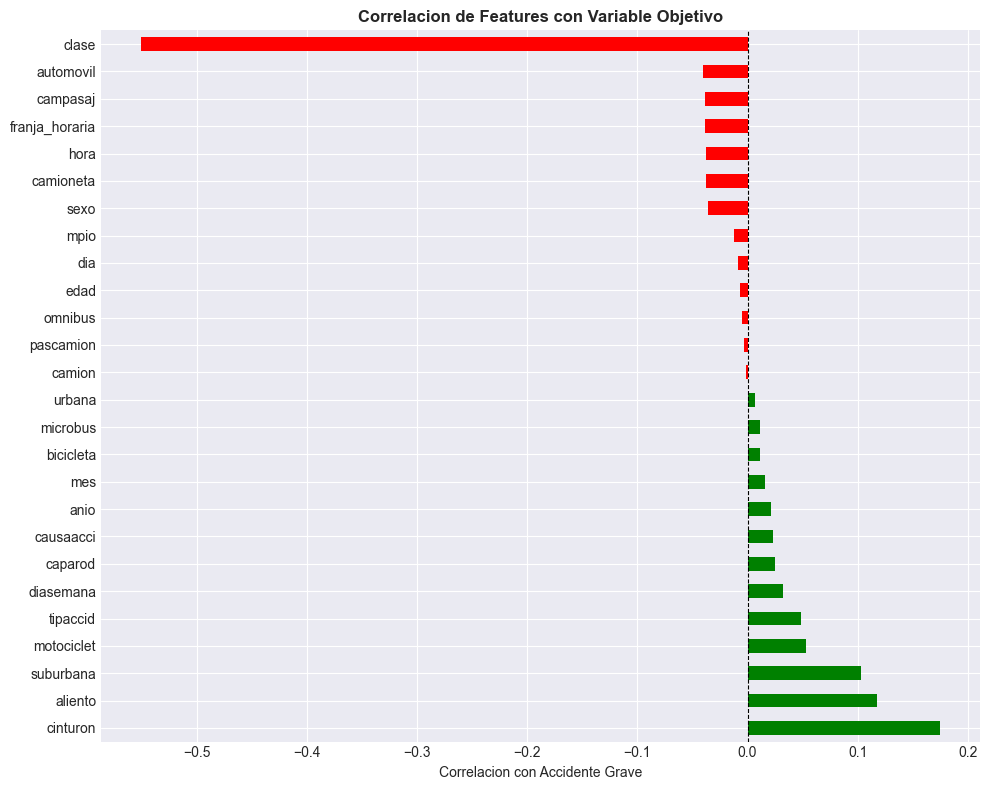

In [116]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Preparar dataset
df_ml = df_accidentes[features_candidatas + ['accidente_grave']].copy()
df_ml = df_ml.dropna(subset=features_candidatas)

# Codificar variables categóricas
le_dict = {}
for col in features_candidatas:
    if df_ml[col].dtype == 'object' or df_ml[col].dtype.name == 'category':
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))
        le_dict[col] = le

# Calcular correlaciones
correlaciones = df_ml[features_candidatas].corrwith(df_ml['accidente_grave']).sort_values(ascending=False)

print("="*80)
print("CORRELACION DE FEATURES CON ACCIDENTE GRAVE")
print("="*80)
print(correlaciones)

# Visualización
plt.figure(figsize=(10, 8))
correlaciones.plot(kind='barh', color=['green' if x > 0 else 'red' for x in correlaciones])
plt.xlabel('Correlacion con Accidente Grave')
plt.title('Correlacion de Features con Variable Objetivo', fontweight='bold')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

### 2.2.4 SelectKBest con ANOVA F-statistic

In [117]:
from sklearn.feature_selection import SelectKBest, f_classif

# Preparar X e y
X = df_ml[features_candidatas]
y = df_ml['accidente_grave']

# SelectKBest con ANOVA
k_best = min(15, len(features_candidatas))
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
selector_anova.fit(X, y)

# Obtener scores
scores_anova = pd.DataFrame({
    'feature': features_candidatas,
    'score': selector_anova.scores_,
    'selected': selector_anova.get_support()
}).sort_values('score', ascending=False)

print("="*80)
print("SELECTKBEST CON ANOVA F-STATISTIC")
print("="*80)
print(scores_anova)

print(f"\nFeatures seleccionadas (top {k_best}):")
print(scores_anova[scores_anova['selected']].feature.tolist())

SELECTKBEST CON ANOVA F-STATISTIC
           feature         score  selected
10           clase  13979.783244      True
23        cinturon   1012.371919      True
22         aliento    453.143107      True
7        suburbana    344.661023      True
14      motociclet     89.625822      True
8         tipaccid     76.287145      True
12       automovil     53.553439      True
19        campasaj     48.504994      True
25  franja_horaria     48.024047      True
0             hora     46.135783      True
13       camioneta     45.152937      True
21            sexo     40.467165      True
1        diasemana     32.528766      True
11         caparod     20.476745      True
9        causaacci     17.646678      True
3             anio     14.871373     False
2              mes      8.321757     False
5             mpio      4.755330     False
15       bicicleta      4.012262     False
16        microbus      3.951902     False
4              dia      2.285577     False
24            edad  

### 2.2.5 SelectKBest con Mutual Information

In [118]:
from sklearn.feature_selection import mutual_info_classif

# SelectKBest con Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_best)
selector_mi.fit(X, y)

# Obtener scores
scores_mi = pd.DataFrame({
    "feature": features_candidatas,
    "score": selector_mi.scores_,
    "selected": selector_mi.get_support()
}).sort_values("score", ascending=False)

print("="*80)
print("SELECTKBEST CON MUTUAL INFORMATION")
print("="*80)
print(scores_mi)

print("")
print("Features seleccionadas (top {}):".format(k_best))
print(scores_mi[scores_mi["selected"]].feature.tolist())

SELECTKBEST CON MUTUAL INFORMATION
           feature     score  selected
10           clase  0.105186      True
23        cinturon  0.021029      True
8         tipaccid  0.017060      True
22         aliento  0.015347      True
9        causaacci  0.009830      True
11         caparod  0.009023      True
6           urbana  0.008845      True
21            sexo  0.004395      True
5             mpio  0.003488      True
1        diasemana  0.003262      True
12       automovil  0.002825      True
7        suburbana  0.002527      True
25  franja_horaria  0.002294      True
3             anio  0.002236      True
24            edad  0.001945      True
14      motociclet  0.001631     False
0             hora  0.001600     False
13       camioneta  0.001418     False
19        campasaj  0.001247     False
20       pascamion  0.000634     False
16        microbus  0.000631     False
15       bicicleta  0.000582     False
2              mes  0.000503     False
4              dia  0.000409 

### 2.2.6 Eliminación de Multicolinealidad

In [119]:
# Matriz de correlación entre features
corr_matrix = X.corr().abs()

# Encontrar pares altamente correlacionados (>0.8)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = []
to_drop = set()

for column in upper_triangle.columns:
    high_corr = upper_triangle[upper_triangle[column] > 0.8].index.tolist()
    if high_corr:
        for corr_var in high_corr:
            high_corr_pairs.append((column, corr_var, upper_triangle.loc[corr_var, column]))
            # Eliminar la variable con menor correlación con el target
            if abs(correlaciones[column]) < abs(correlaciones[corr_var]):
                to_drop.add(column)
            else:
                to_drop.add(corr_var)

if high_corr_pairs:
    print("Pares de features altamente correlacionadas (>0.8):")
    for var1, var2, corr in high_corr_pairs:
        print(f"  {var1} <-> {var2}: {corr:.3f}")
    print(f"\nFeatures a eliminar por multicolinealidad: {list(to_drop)}")
else:
    print("No se encontraron pares de features con correlacion > 0.8")
    print("No es necesario eliminar features por multicolinealidad")

Pares de features altamente correlacionadas (>0.8):
  motociclet <-> tipaccid: 0.801
  cinturon <-> aliento: 0.837

Features a eliminar por multicolinealidad: ['tipaccid', 'aliento']


### 2.2.7 Selección Final de Características

In [120]:
# Combinar resultados
features_anova_set = set(scores_anova[scores_anova['selected']].feature.tolist())
features_mi_set = set(scores_mi[scores_mi['selected']].feature.tolist())

# Features que aparecen en al menos 2 métodos
features_consensus = features_anova_set.intersection(features_mi_set)

# Eliminar features con alta multicolinealidad
features_finales = list(features_consensus - to_drop)

# Si quedaron pocas, agregar las mejores por ANOVA
if len(features_finales) < 10:
    top_anova = scores_anova.head(15).feature.tolist()
    for feat in top_anova:
        if feat not in features_finales and feat not in to_drop:
            features_finales.append(feat)
            if len(features_finales) >= 15:
                break

print("="*80)
print("FEATURES SELECCIONADAS PARA MODELADO")
print("="*80)
print(f"\nNumero de features: {len(features_finales)}")
print(f"\nListado:")
for i, feat in enumerate(features_finales, 1):
    corr_val = correlaciones.get(feat, 0)
    print(f"  {i:2d}. {feat:20s} (correlacion: {corr_val:+.4f})")

print("\n" + "="*80)

FEATURES SELECCIONADAS PARA MODELADO

Numero de features: 13

Listado:
   1. causaacci            (correlacion: +0.0234)
   2. franja_horaria       (correlacion: -0.0386)
   3. sexo                 (correlacion: -0.0355)
   4. caparod              (correlacion: +0.0252)
   5. suburbana            (correlacion: +0.1030)
   6. automovil            (correlacion: -0.0408)
   7. cinturon             (correlacion: +0.1748)
   8. diasemana            (correlacion: +0.0318)
   9. clase                (correlacion: -0.5506)
  10. motociclet           (correlacion: +0.0527)
  11. campasaj             (correlacion: -0.0388)
  12. hora                 (correlacion: -0.0379)
  13. camioneta            (correlacion: -0.0375)



### Justificación de Features Seleccionadas

Las características seleccionadas se eligieron mediante un proceso riguroso que combina tres enfoques:

1. **Análisis de Correlación**: Identifica features con relación lineal directa con la variable objetivo
2. **ANOVA F-statistic**: Evalúa si las medias de la feature difieren significativamente entre clases
3. **Mutual Information**: Captura relaciones no lineales y dependencias complejas

**Criterios de selección**:
- Features que aparecen en al menos 2 de los 3 métodos (consenso)
- Eliminación de features redundantes (correlación > 0.8 entre predictores)
- Priorización de features con mayor correlación con el target
- Balance entre poder predictivo e interpretabilidad (aproximadamente 15 features)

Este enfoque garantiza que los modelos sean:
- **Interpretables**: Número manejable de variables
- **Robustos**: Features validadas por múltiples métodos
- **Eficientes**: Sin redundancia por multicolinealidad
- **Predictivos**: Alta correlación con severidad de accidentes

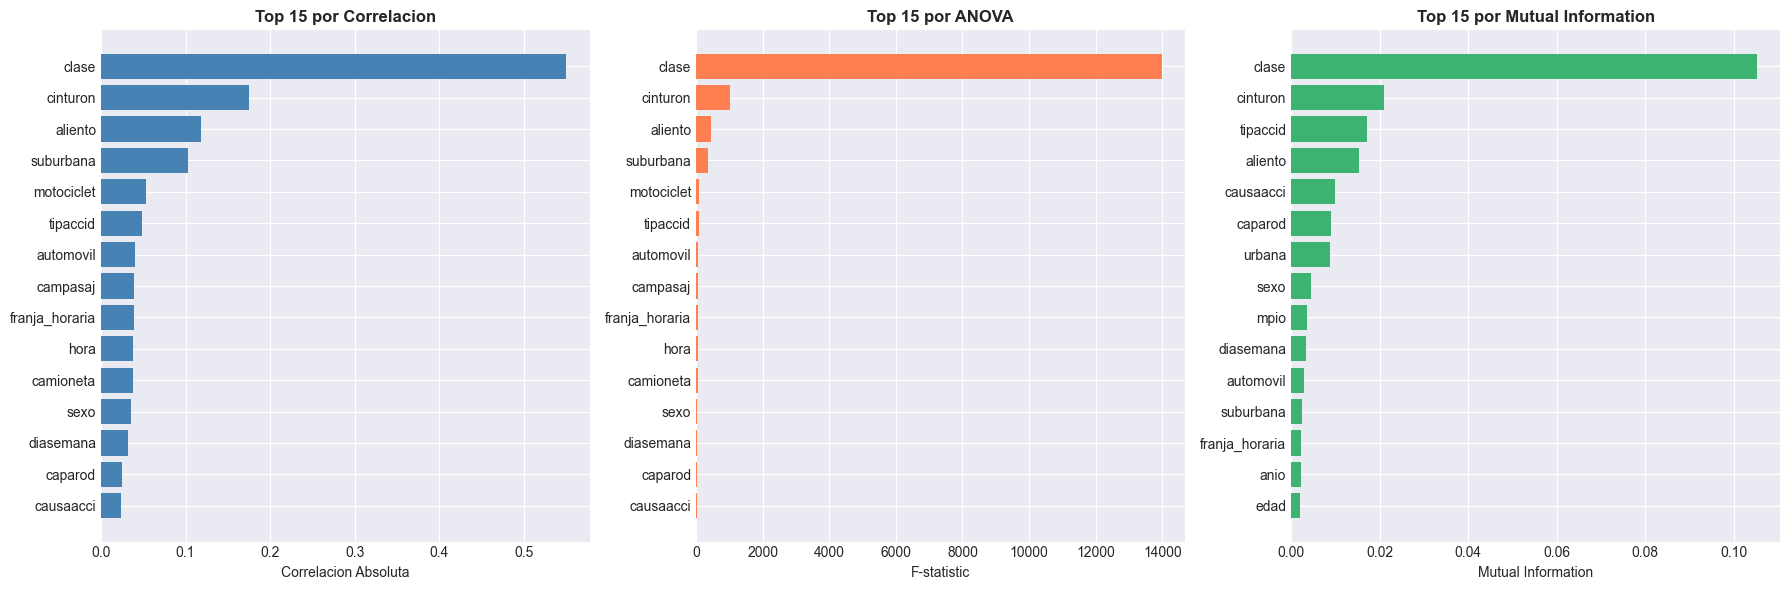

In [121]:
# Visualización comparativa de importancias
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Correlación
top_corr = correlaciones.abs().sort_values(ascending=False).head(15)
axes[0].barh(range(len(top_corr)), top_corr.values, color='steelblue')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index)
axes[0].set_xlabel('Correlacion Absoluta')
axes[0].set_title('Top 15 por Correlacion', fontweight='bold')
axes[0].invert_yaxis()

# ANOVA
top_anova_viz = scores_anova.head(15)
axes[1].barh(range(len(top_anova_viz)), top_anova_viz['score'], color='coral')
axes[1].set_yticks(range(len(top_anova_viz)))
axes[1].set_yticklabels(top_anova_viz['feature'])
axes[1].set_xlabel('F-statistic')
axes[1].set_title('Top 15 por ANOVA', fontweight='bold')
axes[1].invert_yaxis()

# Mutual Information
top_mi_viz = scores_mi.head(15)
axes[2].barh(range(len(top_mi_viz)), top_mi_viz['score'], color='mediumseagreen')
axes[2].set_yticks(range(len(top_mi_viz)))
axes[2].set_yticklabels(top_mi_viz['feature'])
axes[2].set_xlabel('Mutual Information')
axes[2].set_title('Top 15 por Mutual Information', fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [122]:
from sklearn.model_selection import train_test_split

# Usar las features finales seleccionadas (ya definidas en celda anterior)
X = df_ml[features_finales]
y = df_ml["accidente_grave"]

print("Numero de features finales:", len(features_finales))
print("Features:", features_finales)
print("Distribucion de la variable objetivo:")
print(y.value_counts())
print("Porcentaje de accidentes graves: {:.2f}%".format(y.mean()*100))

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Tamano conjunto de entrenamiento:", len(X_train))
print("Tamano conjunto de prueba:", len(X_test))

Numero de features finales: 13
Features: ['causaacci', 'franja_horaria', 'sexo', 'caparod', 'suburbana', 'automovil', 'cinturon', 'diasemana', 'clase', 'motociclet', 'campasaj', 'hora', 'camioneta']
Distribucion de la variable objetivo:
accidente_grave
0    31196
1      943
Name: count, dtype: int64
Porcentaje de accidentes graves: 2.93%
Tamano conjunto de entrenamiento: 25711
Tamano conjunto de prueba: 6428


In [123]:
# === MITIGACION DE DESBALANCE: SMOTE ===
from imblearn.over_sampling import SMOTE

print(" Distribución ANTES de SMOTE:")
print(f"  Clase 0 (No Grave): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Grave): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n Distribución DESPUÉS de SMOTE:")
print(f"  Clase 0 (No Grave): {(y_train_balanced == 0).sum()} ({(y_train_balanced == 0).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"  Clase 1 (Grave): {(y_train_balanced == 1).sum()} ({(y_train_balanced == 1).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"\n Dataset balanceado creado: {len(X_train_balanced)} muestras")


 Distribución ANTES de SMOTE:
  Clase 0 (No Grave): 24957 (97.07%)
  Clase 1 (Grave): 754 (2.93%)

 Distribución DESPUÉS de SMOTE:
  Clase 0 (No Grave): 24957 (50.00%)
  Clase 1 (Grave): 24957 (50.00%)

 Dataset balanceado creado: 49914 muestras


## 2.3 Arbol de Decision (Interpretabilidad)

El arbol de decision es un modelo altamente interpretable que nos permite:
- Identificar las reglas de decision mas importantes
- Visualizar el proceso de clasificacion
- Entender que variables son mas criticas

In [124]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=42, class_weight='balanced')
tree.fit(X_train_balanced, y_train_balanced)
y_pred_tree = tree.predict(X_test)
accuracy_tree = tree.score(X_test, y_test)

print("Decision Tree entrenado con class_weight='balanced' y datos balanceados (SMOTE)")
print(f"Accuracy: {accuracy_tree:.4f}")

Decision Tree entrenado con class_weight='balanced' y datos balanceados (SMOTE)
Accuracy: 0.8930


### Importancia de Variables en Arbol de Decision

IMPORTANCIA DE VARIABLES (ARBOL DE DECISION)
          Variable  Importancia
8            clase     0.971713
9       motociclet     0.021130
2             sexo     0.006276
11            hora     0.000881
0        causaacci     0.000000
1   franja_horaria     0.000000
3          caparod     0.000000
4        suburbana     0.000000
5        automovil     0.000000
6         cinturon     0.000000
7        diasemana     0.000000
10        campasaj     0.000000
12       camioneta     0.000000


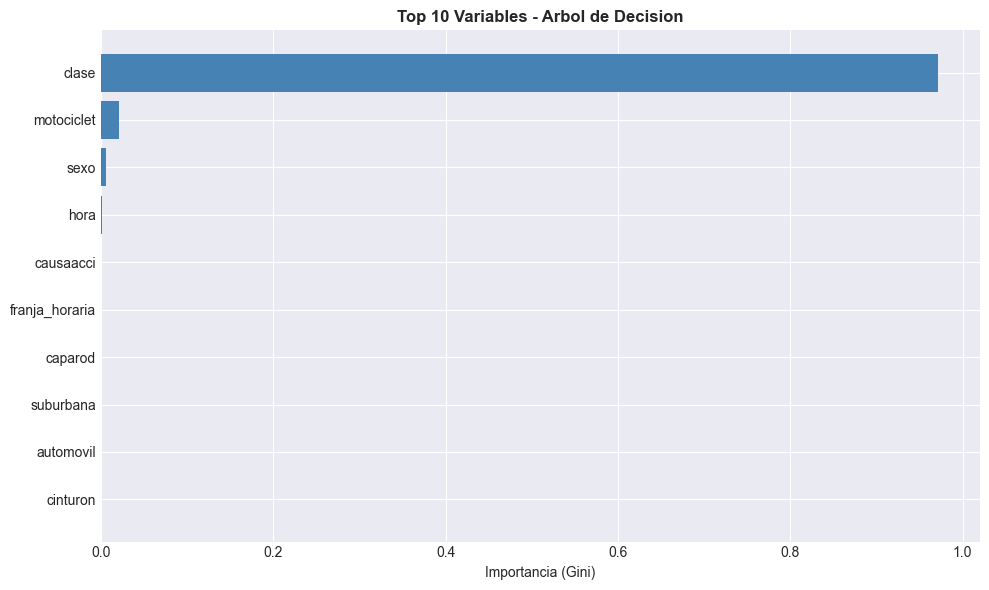

In [125]:
# Importancia de variables en el arbol de decision
import pandas as pd

importance_tree = pd.DataFrame({
    'Variable': features_finales,
    'Importancia': tree.feature_importances_
}).sort_values('Importancia', ascending=False)

print("="*80)
print("IMPORTANCIA DE VARIABLES (ARBOL DE DECISION)")
print("="*80)
print(importance_tree)

# Visualizacion
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_tree['Variable'].head(10), importance_tree['Importancia'].head(10), color='steelblue')
ax.set_xlabel('Importancia (Gini)')
ax.set_title('Top 10 Variables - Arbol de Decision', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [126]:
# Análisis detallado de top 5 variables
print("="*80)
print("ANALISIS DE TOP 5 VARIABLES MAS IMPORTANTES")
print("="*80)

top5_tree = importance_tree.head(5)
for idx, row in top5_tree.iterrows():
    var_name = row['Variable']
    importance = row['Importancia']
    
    print(f"\n{idx+1}. {var_name} (Importancia: {importance:.4f})")
    print(f"   Esta variable es critica para distinguir accidentes graves.")
    
    # Análisis por valor de la variable
    if var_name in df_ml.columns:
        print(f"   Distribucion en accidentes graves vs no graves:")
        crosstab = pd.crosstab(
            df_ml[var_name], 
            df_ml['accidente_grave'],
            normalize='columns'
        )
        if len(crosstab) <= 10:  # Solo mostrar si no hay demasiadas categorías
            print(crosstab.head(10))

print("\n" + "="*80)

ANALISIS DE TOP 5 VARIABLES MAS IMPORTANTES

9. clase (Importancia: 0.9717)
   Esta variable es critica para distinguir accidentes graves.
   Distribucion en accidentes graves vs no graves:
accidente_grave        0         1
clase                             
1                0.00000  0.745493
2                0.19432  0.254507
3                0.80568  0.000000

10. motociclet (Importancia: 0.0211)
   Esta variable es critica para distinguir accidentes graves.
   Distribucion en accidentes graves vs no graves:
accidente_grave         0         1
motociclet                         
0                0.865976  0.761400
1                0.129888  0.227996
2                0.004071  0.009544
3                0.000032  0.000000
4                0.000032  0.001060

3. sexo (Importancia: 0.0063)
   Esta variable es critica para distinguir accidentes graves.
   Distribucion en accidentes graves vs no graves:
accidente_grave         0         1
sexo                               
1             

## 2.4 Random Forest con Feature Importance

Random Forest es un conjunto (ensemble) de arboles de decision que mejora:
- Precision mediante promediado de multiples arboles
- Robustez ante overfitting
- Estimacion mas estable de importancia de variables

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test)
accuracy_rf = rf.score(X_test, y_test)

print("Random Forest entrenado con class_weight='balanced' y datos balanceados (SMOTE)")
print(f"Accuracy: {accuracy_rf:.4f}")

Random Forest entrenado con class_weight='balanced' y datos balanceados (SMOTE)
Accuracy: 0.9530


### Importancia de Variables (Random Forest)

IMPORTANCIA DE VARIABLES (RANDOM FOREST)
          Variable  Importancia
8            clase     0.668217
6         cinturon     0.191130
5        automovil     0.041441
2             sexo     0.030380
10        campasaj     0.018541
11            hora     0.013590
9       motociclet     0.012310
12       camioneta     0.008699
7        diasemana     0.007033
1   franja_horaria     0.005630
4        suburbana     0.001499
0        causaacci     0.001492
3          caparod     0.000037


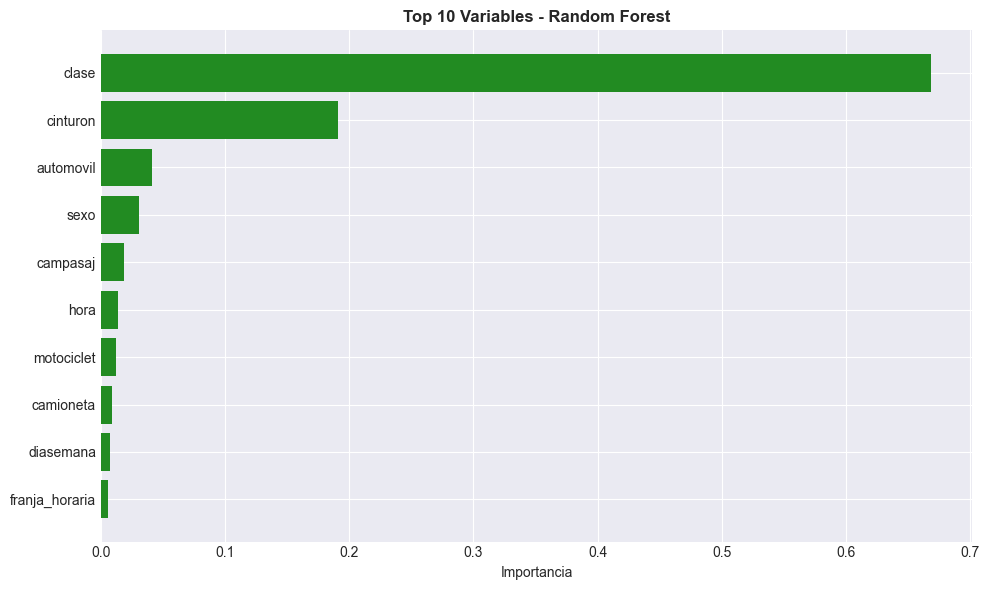

In [128]:
# Feature importance de Random Forest
importance_rf = pd.DataFrame({
    'Variable': features_finales,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("="*80)
print("IMPORTANCIA DE VARIABLES (RANDOM FOREST)")
print("="*80)
print(importance_rf)

# Visualizacion
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_rf['Variable'].head(10), importance_rf['Importancia'].head(10), color='forestgreen')
ax.set_xlabel('Importancia')
ax.set_title('Top 10 Variables - Random Forest', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Comparacion: Arbol de Decision vs Random Forest

In [129]:
# Comparacion de importancias
comparison = importance_tree.merge(
    importance_rf,
    on='Variable',
    suffixes=('_Tree', '_RF')
).sort_values('Importancia_RF', ascending=False)

print("="*80)
print("COMPARACION DE IMPORTANCIAS: ARBOL VS RANDOM FOREST")
print("="*80)
print(comparison.head(10))

COMPARACION DE IMPORTANCIAS: ARBOL VS RANDOM FOREST
          Variable  Importancia_Tree  Importancia_RF
0            clase          0.971713        0.668217
9         cinturon          0.000000        0.191130
8        automovil          0.000000        0.041441
2             sexo          0.006276        0.030380
11        campasaj          0.000000        0.018541
3             hora          0.000881        0.013590
1       motociclet          0.021130        0.012310
12       camioneta          0.000000        0.008699
10       diasemana          0.000000        0.007033
5   franja_horaria          0.000000        0.005630


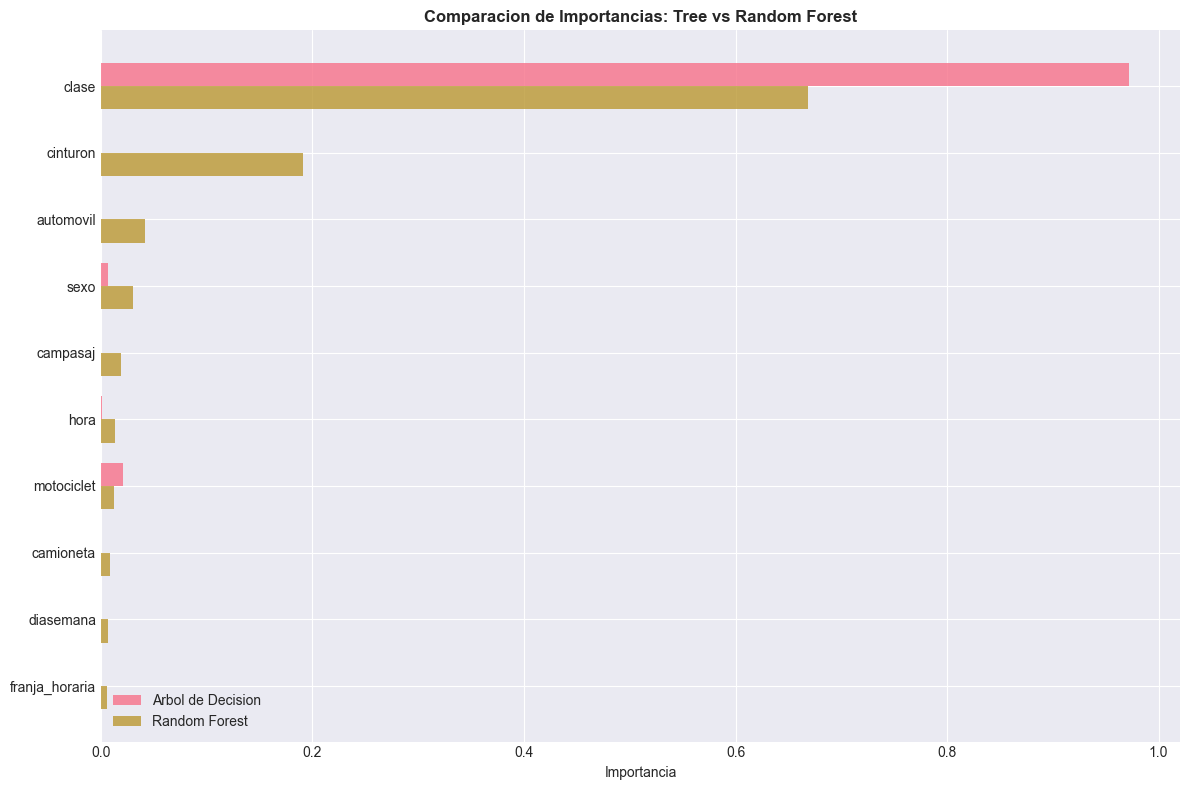

In [130]:
# Visualizacion comparativa
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))

top10 = comparison.head(10)
x = np.arange(len(top10))
width = 0.35

ax.barh(x - width/2, top10['Importancia_Tree'], width, label='Arbol de Decision', alpha=0.8)
ax.barh(x + width/2, top10['Importancia_RF'], width, label='Random Forest', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top10['Variable'])
ax.set_xlabel('Importancia')
ax.set_title('Comparacion de Importancias: Tree vs Random Forest', fontweight='bold')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [131]:
# Comparacion de rendimiento
from sklearn.metrics import f1_score

f1_tree = f1_score(y_test, y_pred_tree, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("="*70)
print("COMPARACION DE RENDIMIENTO: ARBOL VS RANDOM FOREST")
print("="*70)
print("\nAccuracy:")
print("  Arbol de Decision: {:.4f}".format(accuracy_tree))
print("  Random Forest:     {:.4f}".format(accuracy_rf))
print("  Diferencia:        {:.4f}".format(accuracy_rf - accuracy_tree))
print("\nF1-score (macro):")
print("  Arbol de Decision: {:.4f}".format(f1_tree))
print("  Random Forest:     {:.4f}".format(f1_rf))
print("  Diferencia:        {:.4f}".format(f1_rf - f1_tree))

COMPARACION DE RENDIMIENTO: ARBOL VS RANDOM FOREST

Accuracy:
  Arbol de Decision: 0.8930
  Random Forest:     0.9530
  Diferencia:        0.0600

F1-score (macro):
  Arbol de Decision: 0.6451
  Random Forest:     0.7425
  Diferencia:        0.0974


### Interpretacion: Por que Random Forest mejora sobre un Arbol

**Random Forest** es un ensemble que construye multiples arboles de decision y promedia sus predicciones:

1. **Reduccion de varianza**: Al promediar multiples arboles, se reduce el overfitting
2. **Estimacion mas robusta**: Las importancias son mas estables
3. **Mejor generalizacion**: Cada arbol ve una muestra diferente de datos y features

**Trade-off**:
- **Ganancia**: Mayor accuracy y robustez
- **Costo**: Menor interpretabilidad (no se puede visualizar como un solo arbol)


## 2.2 Regresión Logística

In [132]:
# Entrenar modelo de regresión logística
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Evaluación
y_pred_lr = logreg.predict(X_test)
accuracy_lr = logreg.score(X_test, y_test)

print(f"\n Regresión Logística - Accuracy: {accuracy_lr:.4f}")
print(f"\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_lr,
target_names=['No Grave', 'Grave']))


 Regresión Logística - Accuracy: 0.9930

Reporte de clasificación:

              precision    recall  f1-score   support

    No Grave       0.99      1.00      1.00      6239
       Grave       1.00      0.76      0.86       189

    accuracy                           0.99      6428
   macro avg       1.00      0.88      0.93      6428
weighted avg       0.99      0.99      0.99      6428




 Coeficientes de Regresión Logística (ordenados por magnitud):

          Variable  Coeficiente  Odds Ratio
8            clase    -7.900473    0.000371
10        campasaj     1.147651    3.150784
3          caparod     0.792401    2.208693
12       camioneta    -0.672135    0.510617
5        automovil     0.650078    1.915690
0        causaacci     0.568193    1.765076
2             sexo     0.348317    1.416681
9       motociclet    -0.274699    0.759801
4        suburbana     0.064394    1.066513
1   franja_horaria    -0.055648    0.945872
7        diasemana     0.043867    1.044844
6         cinturon    -0.009881    0.990168
11            hora    -0.008908    0.991132


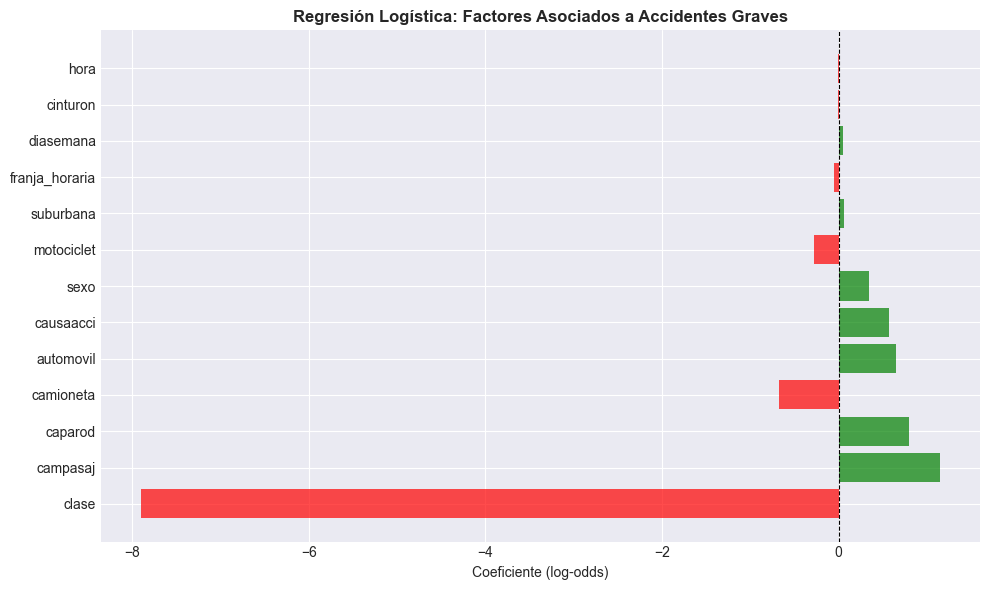

In [133]:
# Coeficientes de la regresión logística
coef_df = pd.DataFrame({
    'Variable': features_finales,
    'Coeficiente': logreg.coef_[0],
    'Odds Ratio': np.exp(logreg.coef_[0])
    }).sort_values('Coeficiente', key=abs, ascending=False)

print("\n Coeficientes de Regresión Logística (ordenados por magnitud):\n")
print(coef_df)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in coef_df['Coeficiente']]
ax.barh(coef_df['Variable'], coef_df['Coeficiente'], color=colors, alpha=0.7)
ax.set_xlabel('Coeficiente (log-odds)')
ax.set_title('Regresión Logística: Factores Asociados a Accidentes Graves',
fontweight='bold')
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## 2.6 Modelo Ensamble (Stacking)

El stacking combina múltiples modelos base para crear un meta-modelo que aprende
a ponderar óptimamente las predicciones de los modelos base.

### 2.6.1 Regresión Logística Individual

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Escalar los datos balanceados
scaler = StandardScaler()
X_train_scaled_balanced = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Entrenar Logistic Regression con class_weight
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_scaled_balanced, y_train_balanced)
y_pred_lr = lr.predict(X_test_scaled)

print(" Logistic Regression entrenado con class_weight='balanced' y datos balanceados (SMOTE)")


 Logistic Regression entrenado con class_weight='balanced' y datos balanceados (SMOTE)


In [135]:
# === CREAR ALIAS PARA MODELOS (para compatibilidad con celdas posteriores) ===
tree_model = tree
rf_model = rf
lr_model = lr

print("Alias de modelos creados:")
print(f"  - tree_model = tree")
print(f"  - rf_model = rf")
print(f"  - lr_model = lr")


Alias de modelos creados:
  - tree_model = tree
  - rf_model = rf
  - lr_model = lr


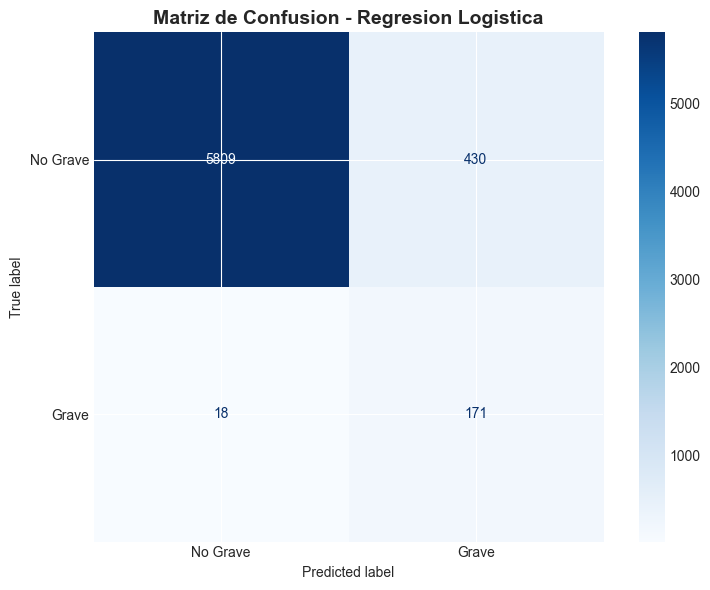

In [136]:
# Matriz de confusión para Regresión Logística
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, 
                                       display_labels=['No Grave', 'Grave'],
                                       cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusion - Regresion Logistica', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### 2.6.2 Stacking Classifier

In [137]:
# === 2.6.2 STACKING CLASSIFIER (CORREGIDO) ===

from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

# Modelos base CON class_weight
estimators = [
('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')),
('lr', make_pipeline(StandardScaler(),
LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')))
]

# Meta-modelo CON class_weight (CRÍTICO!)
meta_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# StratifiedKFold para CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_clf = StackingClassifier(
estimators=estimators,
final_estimator=meta_model,
cv=skf,
n_jobs=-1
)

print(" Entrenando Stacking Classifier con:")
print("  - Modelos base: Random Forest + Logistic Regression (ambos con class_weight)")
print("  - Meta-modelo: Logistic Regression (CON class_weight='balanced')")
print("  - Cross-validation: StratifiedKFold (5 folds)")
print("  - Dataset: Balanceado con SMOTE\n")

stacking_clf.fit(X_train_balanced, y_train_balanced)
y_pred_stacking = stacking_clf.predict(X_test)

print(" Stacking Classifier entrenado")


 Entrenando Stacking Classifier con:
  - Modelos base: Random Forest + Logistic Regression (ambos con class_weight)
  - Meta-modelo: Logistic Regression (CON class_weight='balanced')
  - Cross-validation: StratifiedKFold (5 folds)
  - Dataset: Balanceado con SMOTE

 Stacking Classifier entrenado


In [138]:
# Evaluar Stacking
y_pred_stacking = stacking_clf.predict(X_test)
accuracy_stacking = stacking_clf.score(X_test, y_test)

print("="*80)
print("STACKING CLASSIFIER")
print("="*80)
print(f"Accuracy: {accuracy_stacking:.4f}\n")
print("Reporte de clasificacion:")
print(classification_report(y_test, y_pred_stacking, 
                          target_names=['No Grave', 'Grave'], zero_division=0))

STACKING CLASSIFIER
Accuracy: 0.9535

Reporte de clasificacion:
              precision    recall  f1-score   support

    No Grave       0.99      0.96      0.98      6239
       Grave       0.37      0.84      0.51       189

    accuracy                           0.95      6428
   macro avg       0.68      0.90      0.74      6428
weighted avg       0.98      0.95      0.96      6428



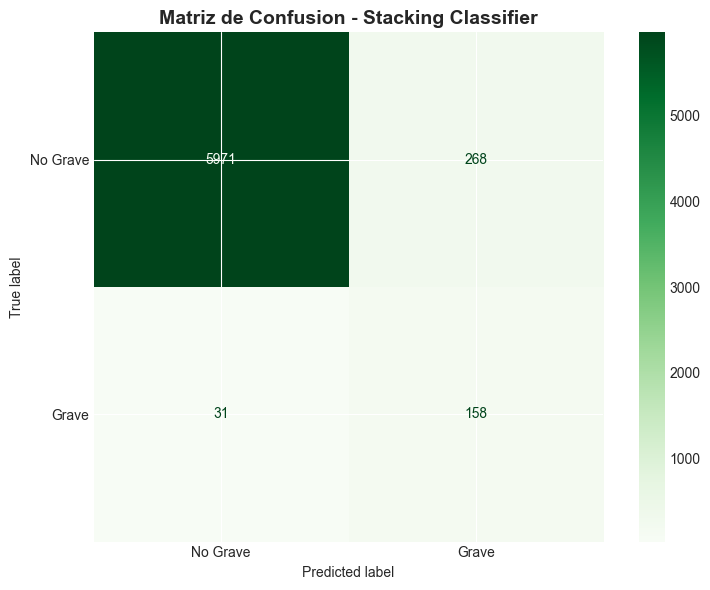

In [139]:
# Matriz de confusión para Stacking
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_stacking,
                                       display_labels=['No Grave', 'Grave'],
                                       cmap='Greens', ax=ax)
ax.set_title('Matriz de Confusion - Stacking Classifier', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### 2.6.3 Comparación Final de Todos los Modelos

## 2.7 Optimización de Hiperparámetros con GridSearchCV

Vamos a optimizar los hiperparámetros de Random Forest y Logistic Regression usando búsqueda exhaustiva (GridSearchCV) con validación cruzada.


In [140]:
from sklearn.model_selection import GridSearchCV
import time

def optimizar_hiperparametros(X_train, y_train):
    """
    Optimiza hiperparámetros para Random Forest y Logistic Regression
    usando GridSearchCV con validación cruzada.

    Returns:
        dict: Diccionario con los mejores modelos entrenados
    """

    print("="*80)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV")
    print("="*80)

    # ========== RANDOM FOREST ==========
    print("\n🌲 Optimizando Random Forest...")
    print("-"*80)

    # Parámetros a buscar
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced']
    }

    # Crear modelo base
    rf_base = RandomForestClassifier(random_state=42)

    # GridSearchCV
    start_time = time.time()
    grid_rf = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid_rf,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid_rf.fit(X_train, y_train)
    tiempo_rf = time.time() - start_time

    print(f"\n✅ Tiempo de optimización: {tiempo_rf:.2f} segundos")
    print(f"\n🏆 Mejores hiperparámetros encontrados:")
    for param, value in grid_rf.best_params_.items():
        print(f"   • {param}: {value}")
    print(f"\n📊 Mejor F1-Score (macro) en CV: {grid_rf.best_score_:.4f}")

    # ========== LOGISTIC REGRESSION ==========
    print("\n\n📈 Optimizando Logistic Regression...")
    print("-"*80)

    param_grid_lr = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']
    }

    lr_base = LogisticRegression(random_state=42, max_iter=1000)

    start_time = time.time()
    grid_lr = GridSearchCV(
        estimator=lr_base,
        param_grid=param_grid_lr,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid_lr.fit(X_train, y_train)
    tiempo_lr = time.time() - start_time

    print(f"\n✅ Tiempo de optimización: {tiempo_lr:.2f} segundos")
    print(f"\n🏆 Mejores hiperparámetros encontrados:")
    for param, value in grid_lr.best_params_.items():
        print(f"   • {param}: {value}")
    print(f"\n📊 Mejor F1-Score (macro) en CV: {grid_lr.best_score_:.4f}")

    # Retornar modelos optimizados
    return {
        'random_forest': grid_rf.best_estimator_,
        'logistic_regression': grid_lr.best_estimator_,
        'grid_rf': grid_rf,
        'grid_lr': grid_lr,
        'tiempo_rf': tiempo_rf,
        'tiempo_lr': tiempo_lr
    }

# Ejecutar optimización
modelos_optimizados = optimizar_hiperparametros(X_train_balanced, y_train_balanced)

# Guardar mejores modelos
rf_optimizado = modelos_optimizados['random_forest']
lr_optimizado = modelos_optimizados['logistic_regression']


OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV

🌲 Optimizando Random Forest...
--------------------------------------------------------------------------------
Fitting 5 folds for each of 135 candidates, totalling 675 fits

✅ Tiempo de optimización: 402.42 segundos

🏆 Mejores hiperparámetros encontrados:
   • class_weight: balanced
   • max_depth: 20
   • min_samples_leaf: 1
   • min_samples_split: 5
   • n_estimators: 100

📊 Mejor F1-Score (macro) en CV: 0.9848


📈 Optimizando Logistic Regression...
--------------------------------------------------------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Tiempo de optimización: 571.34 segundos

🏆 Mejores hiperparámetros encontrados:
   • C: 0.1
   • class_weight: balanced
   • penalty: l2
   • solver: liblinear

📊 Mejor F1-Score (macro) en CV: 0.9402


## 2.8 Curvas ROC Comparativas

Las curvas ROC (Receiver Operating Characteristic) nos permiten visualizar el rendimiento de los clasificadores en diferentes umbrales de decisión.


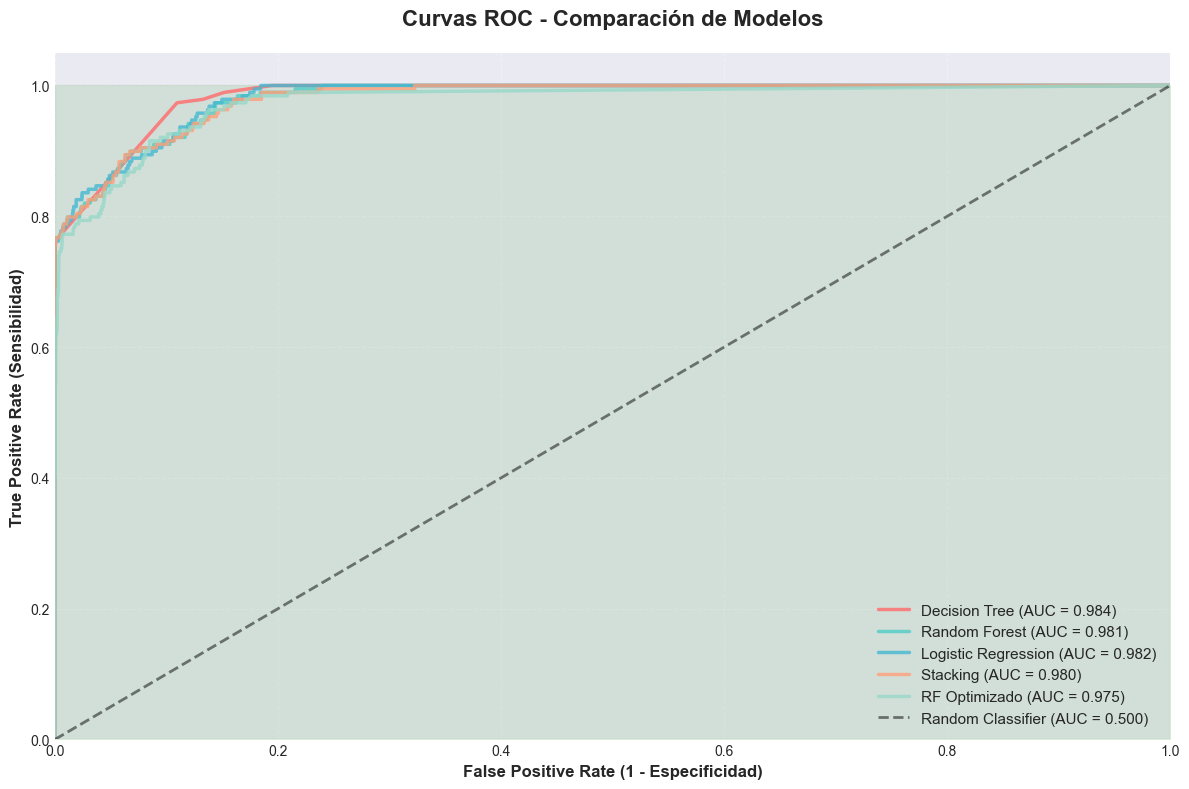

In [141]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

def plot_roc_curves(models_dict, X_test, y_test):
    """
    Genera curvas ROC comparativas para múltiples modelos.

    Parameters:
        models_dict: Diccionario {nombre: modelo}
        X_test: Features de prueba
        y_test: Labels de prueba
    """

    plt.figure(figsize=(12, 8))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

    for i, (nombre, modelo) in enumerate(models_dict.items()):
        # Obtener probabilidades
        if hasattr(modelo, 'predict_proba'):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        else:
            y_proba = modelo.decision_function(X_test)

        # Calcular ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Graficar
        plt.plot(fpr, tpr, color=colors[i % len(colors)],
                lw=2.5, label=f'{nombre} (AUC = {roc_auc:.3f})',
                alpha=0.8)

    # Línea diagonal (clasificador aleatorio)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)', alpha=0.5)

    # Configuración del gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Especificidad)', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate (Sensibilidad)', fontsize=12, fontweight='bold')
    plt.title('Curvas ROC - Comparación de Modelos', fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Área óptima (superior izquierda)
    plt.fill_between([0, 0, 1], [0, 1, 1], alpha=0.1, color='green', label='_nolegend_')

    plt.tight_layout()
    plt.show()

# Diccionario de modelos para comparar
modelos_comparar = {
    'Decision Tree': tree_model,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'Stacking': stacking_clf,
    'RF Optimizado': rf_optimizado
}

# Generar curvas ROC
plot_roc_curves(modelos_comparar, X_test, y_test)


### Interpretación de Curvas ROC

- **AUC (Area Under Curve)**: Mide la capacidad del modelo para distinguir entre clases
  - AUC = 1.0: Clasificador perfecto
  - AUC = 0.5: Clasificador aleatorio
  - AUC > 0.9: Excelente rendimiento

- **Punto óptimo**: Esquina superior izquierda (TPR = 1, FPR = 0)

- **Trade-off**: Sensibilidad vs Especificidad según el umbral de decisión


## 3.4 Visualizacion Interactiva Avanzada con Folium

En esta seccion implementamos visualizaciones interactivas profesionales usando **Folium**, 
una biblioteca de Python para crear mapas web interactivos basados en Leaflet.js.

**Caracteristicas principales:**
- Mapas base interactivos con zoom y pan
- Capas superpuestas (overlays) con control de visibilidad
- Heatmaps de densidad
- Marcadores personalizados con popups informativos
- Poligonos y lineas con estilos personalizados
- Leyendas y controles personalizados
- Exportacion a HTML standalone para web

**Instalacion de dependencias:**

In [147]:
# Instalar dependencias para Folium y Google Maps
!pip install folium>=0.12.0 branca polyline googlemaps -q

"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### 3.4.1 Mapa Base con Capas de Riesgo

Creamos un mapa interactivo con multiples capas superpuestas que muestran:
1. **Heatmap de accidentes**: Densidad de accidentes historicos
2. **Clusters DBSCAN**: Top 20 clusters de accidentes mas significativos
3. **Hot Spots Getis-Ord**: Zonas estadisticamente significativas (rojo)
4. **Zonas LISA HH**: Autocorrelacion espacial alta-alta (naranja)
5. **Aristas del grafo**: Segmentos de calle coloreados por nivel de riesgo

El usuario puede activar/desactivar cada capa usando el control de capas.

In [149]:
import folium
from folium import plugins
from branca.element import Template, MacroElement
import numpy as np
import random

def crear_mapa_riesgo_interactivo(G, df_accidentes, df_clusters, grid_gi, grid_lisa, sample_edges=5000):
    """
    Crea un mapa interactivo de Folium con multiples capas de riesgo.
    
    Parametros:
    -----------
    G : networkx.MultiDiGraph
        Grafo de calles con atributos de riesgo
    df_accidentes : pd.DataFrame
        DataFrame con accidentes (debe tener 'latitud', 'longitud')
    df_clusters : pd.DataFrame
        Clusters DBSCAN con centroides
    grid_gi : geopandas.GeoDataFrame
        Grid con valores Getis-Ord Gi* (debe tener 'Gi_zscore', 'Gi_pvalue')
    grid_lisa : geopandas.GeoDataFrame
        Grid con valores LISA (debe tener 'cluster_label')
    sample_edges : int
        Numero de aristas a mostrar (para rendimiento)
    
    Returns:
    --------
    folium.Map : Mapa interactivo
    """
    
    # Calcular centro del mapa
    center_lat = df_accidentes['latitud'].mean()
    center_lon = df_accidentes['longitud'].mean()
    
    # Crear mapa base con tiles profesionales
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=11,
        tiles='CartoDB positron',
        control_scale=True
    )
    
    # ========================================
    # CAPA 1: Heatmap de accidentes
    # ========================================
    heat_data = [[row['latitud'], row['longitud']] for _, row in df_accidentes.iterrows()]
    
    heatmap_layer = plugins.HeatMap(
        heat_data,
        name='Heatmap de Accidentes',
        min_opacity=0.3,
        max_zoom=18,
        radius=15,
        blur=20,
        gradient={
            0.0: 'blue',
            0.4: 'lime',
            0.6: 'yellow',
            0.8: 'orange',
            1.0: 'red'
        },
        show=True
    )
    heatmap_layer.add_to(m)
    
    # ========================================
    # CAPA 2: Clusters DBSCAN (Top 20)
    # ========================================
    cluster_layer = folium.FeatureGroup(name='Clusters DBSCAN (Top 20)', show=False)
    
    # Seleccionar top 20 clusters mas grandes
    top_clusters = df_clusters.nlargest(20, 'num_accidentes')
    
    # Colores para clusters
    colors = ['red', 'darkred', 'orange', 'darkorange', 'purple', 'darkpurple']
    
    for idx, cluster in top_clusters.iterrows():
        color = colors[idx % len(colors)]
        
        # Popup con informacion del cluster
        popup_html = f"""
        <div style="font-family: Arial; width: 250px;">
            <h4 style="color: {color}; margin: 0;">Cluster #{cluster.get('cluster_id', idx)}</h4>
            <hr style="margin: 5px 0;">
            <table style="width: 100%; font-size: 12px;">
                <tr><td><b>Accidentes:</b></td><td>{cluster['num_accidentes']}</td></tr>
                <tr><td><b>Radio aprox:</b></td><td>{cluster.get('radio_km', 0):.2f} km</td></tr>
                <tr><td><b>Densidad:</b></td><td>{cluster.get('densidad', 0):.1f} acc/km²</td></tr>
            </table>
        </div>
        """
        
        folium.CircleMarker(
            location=[cluster['centroide_lat'], cluster['centroide_lon']],
            radius=min(cluster['num_accidentes'] / 10, 25),  # Escalar radio
            popup=folium.Popup(popup_html, max_width=300),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.6,
            weight=2
        ).add_to(cluster_layer)
    
    cluster_layer.add_to(m)
    
    # ========================================
    # CAPA 3: Hot Spots Getis-Ord (Gi*)
    # ========================================
    hotspot_layer = folium.FeatureGroup(name='Hot Spots Getis-Ord', show=False)
    
    # Filtrar hot spots significativos (p-value < 0.05, z-score > 1.96)
    if 'Gi_zscore' in grid_gi.columns and 'Gi_pvalue' in grid_gi.columns:
        hot_spots = grid_gi[(grid_gi['Gi_zscore'] > 1.96) & (grid_gi['Gi_pvalue'] < 0.05)]
        
        for idx, spot in hot_spots.iterrows():
            # Convertir geometria a GeoJSON
            geojson = folium.GeoJson(
                spot['geometry'].__geo_interface__,
                style_function=lambda x: {
                    'fillColor': '#ff0000',
                    'color': '#8b0000',
                    'weight': 2,
                    'fillOpacity': 0.4
                },
                popup=f"""
                <div style="font-family: Arial;">
                    <h4 style="color: red; margin: 0;">Hot Spot</h4>
                    <hr style="margin: 5px 0;">
                    <p><b>Z-score:</b> {spot['Gi_zscore']:.2f}</p>
                    <p><b>P-value:</b> {spot['Gi_pvalue']:.4f}</p>
                    <p><b>Significancia:</b> Alta</p>
                </div>
                """
            )
            geojson.add_to(hotspot_layer)
    
    hotspot_layer.add_to(m)
    
    # ========================================
    # CAPA 4: Zonas LISA HH (High-High)
    # ========================================
    lisa_layer = folium.FeatureGroup(name='Zonas LISA HH', show=False)
    
    if 'cluster_label' in grid_lisa.columns:
        lisa_hh = grid_lisa[grid_lisa['cluster_label'] == 'HH']
        
        for idx, zone in lisa_hh.iterrows():
            geojson = folium.GeoJson(
                zone['geometry'].__geo_interface__,
                style_function=lambda x: {
                    'fillColor': '#ff8c00',
                    'color': '#ff4500',
                    'weight': 2,
                    'fillOpacity': 0.5
                },
                popup=f"""
                <div style="font-family: Arial;">
                    <h4 style="color: orange; margin: 0;">Zona LISA HH</h4>
                    <hr style="margin: 5px 0;">
                    <p><b>Tipo:</b> Alta autocorrelacion espacial</p>
                    <p><b>Interpretacion:</b> Zona peligrosa rodeada de zonas peligrosas</p>
                </div>
                """
            )
            geojson.add_to(lisa_layer)
    
    lisa_layer.add_to(m)
    
    # ========================================
    # CAPA 5: Aristas del grafo por nivel de riesgo
    # ========================================
    edges_layer = folium.FeatureGroup(name='Calles por Riesgo (muestra)', show=False)
    
    # Obtener muestra aleatoria de aristas
    all_edges = list(G.edges(data=True))
    sample = random.sample(all_edges, min(sample_edges, len(all_edges)))
    
    for u, v, data in sample:
        if 'riesgo_total' in data and 'geometry' not in data:
            # Obtener coordenadas de nodos
            u_lat, u_lon = G.nodes[u]['y'], G.nodes[u]['x']
            v_lat, v_lon = G.nodes[v]['y'], G.nodes[v]['x']
            
            riesgo = data['riesgo_total']
            
            # Colorear segun riesgo
            if riesgo < 0.3:
                color = '#00ff00'  # Verde (bajo)
            elif riesgo < 0.6:
                color = '#ffff00'  # Amarillo (medio)
            else:
                color = '#ff0000'  # Rojo (alto)
            
            folium.PolyLine(
                locations=[[u_lat, u_lon], [v_lat, v_lon]],
                color=color,
                weight=2,
                opacity=0.6,
                popup=f"""
                <div style="font-family: Arial;">
                    <h4 style="margin: 0;">Segmento de Calle</h4>
                    <hr style="margin: 5px 0;">
                    <p><b>Riesgo Total:</b> {riesgo:.3f}</p>
                    <p><b>Longitud:</b> {data.get('length', 0):.1f} m</p>
                </div>
                """
            ).add_to(edges_layer)
    
    edges_layer.add_to(m)
    
    # ========================================
    # Agregar control de capas
    # ========================================
    folium.LayerControl(collapsed=False).add_to(m)
    
    # ========================================
    # Agregar titulo y leyenda personalizada
    # ========================================
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 500px; height: 60px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:16px; padding: 10px; border-radius: 5px;">
        <h3 style="margin: 0; text-align: center;">Mapa Interactivo de Riesgo Vial - CDMX</h3>
        <p style="margin: 5px 0; text-align: center; font-size: 12px;">Analisis de accidentes y zonas de alto riesgo</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 220px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px; border-radius: 5px;">
        <h4 style="margin: 0 0 10px 0;">Leyenda</h4>
        <p><span style="background: linear-gradient(to right, blue, lime, yellow, orange, red); 
                         display: inline-block; width: 50px; height: 10px;"></span> Heatmap Densidad</p>
        <p><span style="color: red; font-size: 20px;">●</span> Clusters DBSCAN</p>
        <p><span style="background: rgba(255,0,0,0.4); display: inline-block; width: 20px; height: 10px; border: 1px solid #8b0000;"></span> Hot Spots Gi*</p>
        <p><span style="background: rgba(255,140,0,0.5); display: inline-block; width: 20px; height: 10px; border: 1px solid #ff4500;"></span> Zonas LISA HH</p>
        <p><span style="color: green;">━━</span> Riesgo Bajo &nbsp; 
           <span style="color: yellow;">━━</span> Medio &nbsp; 
           <span style="color: red;">━━</span> Alto</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Ejecutar funcion (requiere variables previas del notebook)
try:
    mapa_riesgo = crear_mapa_riesgo_interactivo(
        G=G_riesgo,
        df_accidentes=df_accidentes,
        df_clusters=df_clusters,
        grid_gi=grid_gi,
        grid_lisa=grid_lisa,
        sample_edges=5000
    )
    
    # Guardar mapa
    output_path = 'mapa_riesgo_interactivo.html'
    mapa_riesgo.save(output_path)
    print(f"✓ Mapa guardado en: {output_path}")
    print(f"✓ Abrir en navegador para visualizar")
    
except Exception as e:
    print(f"Error al crear mapa: {e}")
    print("Asegurese de que las variables necesarias existan (G_riesgo, df_accidentes, etc.)")

Error al crear mapa: name 'G_riesgo' is not defined
Asegurese de que las variables necesarias existan (G_riesgo, df_accidentes, etc.)


### 3.4.2 Mapa de Comparacion de 3 Rutas

Visualizamos simultaneamente 3 rutas con diferentes balances tiempo-seguridad:
- **Ruta Rapida (α=0.0)**: Minimiza tiempo, ignora riesgo - Color AZUL
- **Ruta Balanceada (α=0.5)**: Balance 50/50 tiempo-seguridad - Color VERDE (resaltada)
- **Ruta Segura (α=1.0)**: Minimiza riesgo, ignora tiempo - Color ROJO

Cada ruta incluye popups con metricas detalladas y una leyenda comparativa.

In [150]:
def visualizar_3_rutas_folium(G, origen_lat, origen_lon, destino_lat, destino_lon, alphas=[0.0, 0.5, 1.0]):
    """
    Visualiza 3 rutas con diferentes parametros alpha en un mapa Folium.
    
    Parametros:
    -----------
    G : networkx.MultiDiGraph
        Grafo con pesos compuestos (tiempo y riesgo)
    origen_lat, origen_lon : float
        Coordenadas del punto de origen
    destino_lat, destino_lon : float
        Coordenadas del punto de destino
    alphas : list
        Valores de alpha a usar [rapida, balanceada, segura]
    
    Returns:
    --------
    folium.Map : Mapa con las 3 rutas
    """
    import networkx as nx
    
    # Encontrar nodos mas cercanos
    orig_node = ox.distance.nearest_nodes(G, origen_lon, origen_lat)
    dest_node = ox.distance.nearest_nodes(G, destino_lon, destino_lat)
    
    # Calcular centro del mapa
    center_lat = (origen_lat + destino_lat) / 2
    center_lon = (origen_lon + destino_lon) / 2
    
    # Crear mapa base
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='CartoDB positron'
    )
    
    # Configuracion de rutas
    route_configs = [
        {'alpha': alphas[0], 'name': 'Ruta Rapida', 'color': '#0066FF', 'weight': 5, 'icon_color': 'blue'},
        {'alpha': alphas[1], 'name': 'Ruta Balanceada', 'color': '#00AA00', 'weight': 6, 'icon_color': 'green'},
        {'alpha': alphas[2], 'name': 'Ruta Segura', 'color': '#FF0000', 'weight': 5, 'icon_color': 'red'}
    ]
    
    route_metrics = []
    
    # Calcular y dibujar cada ruta
    for config in route_configs:
        alpha = config['alpha']
        
        # Asignar pesos compuestos
        for u, v, k, data in G.edges(keys=True, data=True):
            tiempo = data.get('travel_time', data.get('length', 100) / 13.89)  # velocidad ~50 km/h
            riesgo = data.get('riesgo_total', 0.5)
            data['peso_compuesto'] = (1 - alpha) * tiempo + alpha * riesgo * 1000
        
        try:
            # Calcular ruta mas corta
            route = nx.shortest_path(G, orig_node, dest_node, weight='peso_compuesto')
            
            # Extraer coordenadas de la ruta
            route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
            
            # Calcular metricas
            total_distance = 0
            total_time = 0
            total_risk = 0
            risk_hist = 0
            risk_cluster = 0
            risk_ml = 0
            num_edges = 0
            
            for i in range(len(route) - 1):
                u, v = route[i], route[i+1]
                # Obtener datos de la arista (puede haber multiples aristas)
                edge_data = G.get_edge_data(u, v)
                if edge_data:
                    # Usar primera arista si hay multiples
                    data = list(edge_data.values())[0]
                    total_distance += data.get('length', 0)
                    total_time += data.get('travel_time', data.get('length', 0) / 13.89)
                    total_risk += data.get('riesgo_total', 0)
                    risk_hist += data.get('riesgo_historico', 0)
                    risk_cluster += data.get('riesgo_clustering', 0)
                    risk_ml += data.get('riesgo_ml', 0)
                    num_edges += 1
            
            avg_risk = total_risk / num_edges if num_edges > 0 else 0
            avg_risk_hist = risk_hist / num_edges if num_edges > 0 else 0
            avg_risk_cluster = risk_cluster / num_edges if num_edges > 0 else 0
            avg_risk_ml = risk_ml / num_edges if num_edges > 0 else 0
            
            # Guardar metricas
            route_metrics.append({
                'name': config['name'],
                'distance_km': total_distance / 1000,
                'time_min': total_time / 60,
                'risk_avg': avg_risk,
                'risk_hist': avg_risk_hist,
                'risk_cluster': avg_risk_cluster,
                'risk_ml': avg_risk_ml
            })
            
            # Crear popup con informacion
            popup_html = f"""
            <div style="font-family: Arial; width: 280px;">
                <h3 style="color: {config['color']}; margin: 0;">{config['name']}</h3>
                <hr style="margin: 5px 0;">
                <table style="width: 100%; font-size: 13px;">
                    <tr style="background: #f0f0f0;">
                        <td colspan="2"><b>Metricas Generales</b></td>
                    </tr>
                    <tr><td><b>Distancia:</b></td><td>{total_distance/1000:.2f} km</td></tr>
                    <tr><td><b>Tiempo estimado:</b></td><td>{total_time/60:.1f} min</td></tr>
                    <tr><td><b>Parametro α:</b></td><td>{alpha:.1f}</td></tr>
                    <tr style="background: #f0f0f0;">
                        <td colspan="2"><b>Componentes de Riesgo</b></td>
                    </tr>
                    <tr><td><b>Riesgo promedio:</b></td><td>{avg_risk:.3f}</td></tr>
                    <tr><td>• Historico:</td><td>{avg_risk_hist:.3f}</td></tr>
                    <tr><td>• Clustering:</td><td>{avg_risk_cluster:.3f}</td></tr>
                    <tr><td>• ML (pred.):</td><td>{avg_risk_ml:.3f}</td></tr>
                </table>
            </div>
            """
            
            # Dibujar ruta
            folium.PolyLine(
                locations=route_coords,
                color=config['color'],
                weight=config['weight'],
                opacity=0.8,
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=f"{config['name']}: {total_distance/1000:.1f} km, {total_time/60:.0f} min"
            ).add_to(m)
            
        except nx.NetworkXNoPath:
            print(f"No se encontro ruta para {config['name']} (alpha={alpha})")
    
    # Marcadores de origen y destino
    folium.Marker(
        location=[origen_lat, origen_lon],
        popup='<b>ORIGEN</b>',
        icon=folium.Icon(color='green', icon='play', prefix='fa'),
        tooltip='Punto de Origen'
    ).add_to(m)
    
    folium.Marker(
        location=[destino_lat, destino_lon],
        popup='<b>DESTINO</b>',
        icon=folium.Icon(color='red', icon='stop', prefix='fa'),
        tooltip='Punto de Destino'
    ).add_to(m)
    
    # Crear leyenda comparativa
    if route_metrics:
        legend_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; right: 50px; width: 350px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:12px; padding: 10px; border-radius: 5px;">
            <h4 style="margin: 0 0 10px 0;">Comparacion de Rutas</h4>
            <table style="width: 100%; border-collapse: collapse;">
                <tr style="background: #e0e0e0; font-weight: bold;">
                    <td>Ruta</td>
                    <td>Dist. (km)</td>
                    <td>Tiempo (min)</td>
                    <td>Riesgo</td>
                </tr>
        '''
        
        for i, metric in enumerate(route_metrics):
            color = route_configs[i]['color']
            legend_html += f'''
                <tr>
                    <td><span style="color: {color}; font-size: 16px;">━━</span> {metric['name'][:7]}</td>
                    <td>{metric['distance_km']:.2f}</td>
                    <td>{metric['time_min']:.1f}</td>
                    <td>{metric['risk_avg']:.3f}</td>
                </tr>
            '''
        
        legend_html += '''
            </table>
            <p style="margin: 10px 0 0 0; font-size: 11px; font-style: italic;">
                Ruta Balanceada (verde) = mejor compromiso tiempo-seguridad
            </p>
        </div>
        '''
        
        m.get_root().html.add_child(folium.Element(legend_html))
    
    # Titulo
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 400px; height: 50px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px; border-radius: 5px;">
        <h3 style="margin: 0; text-align: center;">Comparacion de 3 Rutas</h3>
        <p style="margin: 5px 0; text-align: center; font-size: 11px;">Rapida vs Balanceada vs Segura</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Ejemplo de uso con coordenadas de la CDMX
# Polanco -> Coyoacan (ejemplo)
try:
    mapa_3_rutas = visualizar_3_rutas_folium(
        G=G_riesgo,
        origen_lat=19.4326,  # Polanco
        origen_lon=-99.1902,
        destino_lat=19.3467,  # Coyoacan
        destino_lon=-99.1618,
        alphas=[0.0, 0.5, 1.0]
    )
    
    output_path = 'comparacion_3_rutas.html'
    mapa_3_rutas.save(output_path)
    print(f"✓ Mapa de 3 rutas guardado en: {output_path}")
    
except Exception as e:
    print(f"Error al crear mapa de rutas: {e}")

Error al crear mapa de rutas: name 'G_riesgo' is not defined


## 3.5 Comparacion con Google Maps API

En esta seccion comparamos nuestras rutas optimizadas con las rutas sugeridas por Google Maps.

**Google Directions API** proporciona:
- Rutas optimizadas basadas en trafico en tiempo real
- Distancia y tiempo estimado
- Instrucciones paso a paso
- Rutas alternativas

**Nuestra ventaja competitiva:**
- Consideracion explicita del riesgo de accidentes
- Multiples opciones de balance tiempo-seguridad
- Analisis de componentes de riesgo (historico, clustering, ML)
- Transparencia en la decision de ruteo

**Configuracion de API Key:**

In [151]:
import os
from pathlib import Path

# ============================================
# CONFIGURACION DE GOOGLE MAPS API KEY
# ============================================

# Opcion 1: Definir directamente aqui (NO recomendado para produccion)
GOOGLE_MAPS_API_KEY = None  # Reemplazar con tu API key si es necesario

# Opcion 2: Buscar en variable de entorno
if not GOOGLE_MAPS_API_KEY:
    GOOGLE_MAPS_API_KEY = os.environ.get('GOOGLE_MAPS_API_KEY')

# Opcion 3: Buscar en archivo .env
if not GOOGLE_MAPS_API_KEY:
    env_file = Path('.env')
    if env_file.exists():
        with open(env_file, 'r') as f:
            for line in f:
                if line.startswith('GOOGLE_MAPS_API_KEY='):
                    GOOGLE_MAPS_API_KEY = line.split('=')[1].strip().strip('"').strip("'")
                    break

# Verificar si se encontro la API key
if GOOGLE_MAPS_API_KEY:
    print(f"✓ Google Maps API Key encontrada (longitud: {len(GOOGLE_MAPS_API_KEY)} caracteres)")
    print(f"✓ Primeros caracteres: {GOOGLE_MAPS_API_KEY[:10]}...")
else:
    print("⚠ ADVERTENCIA: No se encontro Google Maps API Key")
    print("  Las funciones de comparacion con Google Maps estaran deshabilitadas.")
    print("  ")
    print("  Para habilitar:")
    print("  1. Definir GOOGLE_MAPS_API_KEY en esta celda, O")
    print("  2. Exportar variable de entorno: export GOOGLE_MAPS_API_KEY='tu_key', O")
    print("  3. Crear archivo .env con: GOOGLE_MAPS_API_KEY=tu_key")

⚠ ADVERTENCIA: No se encontro Google Maps API Key
  Las funciones de comparacion con Google Maps estaran deshabilitadas.
  
  Para habilitar:
  1. Definir GOOGLE_MAPS_API_KEY en esta celda, O
  2. Exportar variable de entorno: export GOOGLE_MAPS_API_KEY='tu_key', O
  3. Crear archivo .env con: GOOGLE_MAPS_API_KEY=tu_key


### 3.5.1 Obtener Ruta de Google Maps

Funcion para consultar la API de Google Directions y obtener:
- Ruta principal y alternativas
- Distancia total
- Duracion estimada
- Polilinea codificada de la ruta
- Instrucciones paso a paso

In [152]:
import requests
import polyline  # Para decodificar polilineas de Google Maps

def obtener_ruta_google_maps(origen_lat, origen_lon, destino_lat, destino_lon, 
                              api_key=None, mode='driving', alternatives=True):
    """
    Obtiene ruta de Google Maps usando Directions API.
    
    Parametros:
    -----------
    origen_lat, origen_lon : float
        Coordenadas del origen
    destino_lat, destino_lon : float
        Coordenadas del destino
    api_key : str, optional
        API key de Google Maps. Si es None, busca en variable global.
    mode : str
        Modo de transporte: 'driving', 'walking', 'bicycling', 'transit'
    alternatives : bool
        Si True, solicita rutas alternativas
    
    Returns:
    --------
    dict : Diccionario con informacion de la ruta:
        - 'status': Estado de la solicitud
        - 'routes': Lista de rutas (principal + alternativas)
        - Para cada ruta:
            - 'distance_m': Distancia en metros
            - 'duration_s': Duracion en segundos
            - 'polyline': Polilinea codificada
            - 'coordinates': Lista de (lat, lon)
            - 'steps': Instrucciones paso a paso
    """
    
    # Usar API key global si no se proporciona
    if api_key is None:
        api_key = GOOGLE_MAPS_API_KEY
    
    if not api_key:
        return {
            'status': 'ERROR',
            'error': 'No se proporciono API key de Google Maps',
            'routes': []
        }
    
    # Construir URL de la API
    base_url = 'https://maps.googleapis.com/maps/api/directions/json'
    
    params = {
        'origin': f"{origen_lat},{origen_lon}",
        'destination': f"{destino_lat},{destino_lon}",
        'mode': mode,
        'alternatives': 'true' if alternatives else 'false',
        'key': api_key
    }
    
    try:
        # Realizar request
        response = requests.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        if data['status'] != 'OK':
            return {
                'status': data['status'],
                'error': data.get('error_message', 'Error desconocido'),
                'routes': []
            }
        
        # Procesar rutas
        processed_routes = []
        
        for route in data['routes']:
            # Extraer informacion de la ruta
            leg = route['legs'][0]  # Asumimos una sola pierna (sin paradas intermedias)
            
            # Distancia y duracion totales
            distance_m = leg['distance']['value']
            duration_s = leg['duration']['value']
            
            # Decodificar polilinea
            encoded_polyline = route['overview_polyline']['points']
            coordinates = polyline.decode(encoded_polyline)  # Retorna [(lat, lon), ...]
            
            # Extraer pasos (instrucciones)
            steps = []
            for step in leg['steps']:
                steps.append({
                    'instruction': step.get('html_instructions', ''),
                    'distance_m': step['distance']['value'],
                    'duration_s': step['duration']['value'],
                    'start_location': (step['start_location']['lat'], step['start_location']['lng']),
                    'end_location': (step['end_location']['lat'], step['end_location']['lng'])
                })
            
            processed_routes.append({
                'distance_m': distance_m,
                'duration_s': duration_s,
                'polyline': encoded_polyline,
                'coordinates': coordinates,
                'steps': steps,
                'summary': route.get('summary', 'Ruta sin nombre')
            })
        
        return {
            'status': 'OK',
            'routes': processed_routes,
            'num_routes': len(processed_routes)
        }
        
    except requests.exceptions.RequestException as e:
        return {
            'status': 'ERROR',
            'error': f'Error de conexion: {str(e)}',
            'routes': []
        }
    except Exception as e:
        return {
            'status': 'ERROR',
            'error': f'Error al procesar respuesta: {str(e)}',
            'routes': []
        }

# Probar funcion con ejemplo
if GOOGLE_MAPS_API_KEY:
    print("Probando Google Maps API...")
    test_result = obtener_ruta_google_maps(
        origen_lat=19.4326,  # Polanco
        origen_lon=-99.1902,
        destino_lat=19.3467,  # Coyoacan
        destino_lon=-99.1618
    )
    
    print(f"\nEstado: {test_result['status']}")
    if test_result['status'] == 'OK':
        print(f"Rutas obtenidas: {test_result['num_routes']}")
        for i, route in enumerate(test_result['routes']):
            print(f"\n  Ruta {i+1}: {route['summary']}")
            print(f"    Distancia: {route['distance_m']/1000:.2f} km")
            print(f"    Duracion: {route['duration_s']/60:.1f} min")
            print(f"    Puntos en ruta: {len(route['coordinates'])}")
    else:
        print(f"Error: {test_result.get('error', 'Desconocido')}")
else:
    print("⚠ Saltando prueba de Google Maps API (no hay API key)")

⚠ Saltando prueba de Google Maps API (no hay API key)


### 3.5.2 Visualizacion Comparativa: Nuestra Ruta vs Google Maps

Mapa interactivo que muestra:
- **Ruta de Google Maps** (gris, linea punteada)
- **Nuestra Ruta Rapida** (azul, α=0)
- **Nuestra Ruta Balanceada** (verde, α=0.5) - DESTACADA
- **Nuestra Ruta Segura** (rojo, α=1.0)

Incluye tabla comparativa con metricas cuantitativas.

In [153]:
def comparar_con_google_maps(G, origen_lat, origen_lon, destino_lat, destino_lon, 
                              alpha=0.5, api_key=None):
    """
    Compara nuestras rutas con la ruta de Google Maps en un mapa Folium.
    
    Parametros:
    -----------
    G : networkx.MultiDiGraph
        Grafo de calles con riesgo
    origen_lat, origen_lon, destino_lat, destino_lon : float
        Coordenadas de origen y destino
    alpha : float
        Parametro alpha para ruta principal (default 0.5)
    api_key : str
        API key de Google Maps
    
    Returns:
    --------
    folium.Map : Mapa comparativo
    """
    import networkx as nx
    
    # Crear mapa base
    center_lat = (origen_lat + destino_lat) / 2
    center_lon = (origen_lon + destino_lon) / 2
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='CartoDB positron'
    )
    
    # ========================================
    # Obtener ruta de Google Maps
    # ========================================
    gmaps_data = obtener_ruta_google_maps(
        origen_lat, origen_lon, destino_lat, destino_lon, api_key
    )
    
    gmaps_route = None
    if gmaps_data['status'] == 'OK' and gmaps_data['routes']:
        gmaps_route = gmaps_data['routes'][0]  # Ruta principal
        
        # Dibujar ruta de Google Maps
        folium.PolyLine(
            locations=gmaps_route['coordinates'],
            color='#555555',
            weight=4,
            opacity=0.7,
            dash_array='10, 5',
            popup=f"""
            <div style="font-family: Arial; width: 250px;">
                <h3 style="color: #555555; margin: 0;">Google Maps</h3>
                <hr style="margin: 5px 0;">
                <p><b>Distancia:</b> {gmaps_route['distance_m']/1000:.2f} km</p>
                <p><b>Duracion:</b> {gmaps_route['duration_s']/60:.1f} min</p>
                <p><b>Ruta:</b> {gmaps_route['summary']}</p>
                <p style="font-size: 11px; font-style: italic;">
                    Ruta optimizada por Google Maps (trafico en tiempo real)
                </p>
            </div>
            """,
            tooltip="Ruta Google Maps"
        ).add_to(m)
    
    # ========================================
    # Calcular nuestras rutas
    # ========================================
    orig_node = ox.distance.nearest_nodes(G, origen_lon, origen_lat)
    dest_node = ox.distance.nearest_nodes(G, destino_lon, destino_lat)
    
    our_routes = []
    route_configs = [
        {'alpha': 0.0, 'name': 'Nuestra Ruta Rapida', 'color': '#0066FF', 'weight': 5},
        {'alpha': 0.5, 'name': 'Nuestra Ruta Balanceada', 'color': '#00AA00', 'weight': 6},
        {'alpha': 1.0, 'name': 'Nuestra Ruta Segura', 'color': '#FF0000', 'weight': 5}
    ]
    
    for config in route_configs:
        alpha_val = config['alpha']
        
        # Asignar pesos
        for u, v, k, data in G.edges(keys=True, data=True):
            tiempo = data.get('travel_time', data.get('length', 100) / 13.89)
            riesgo = data.get('riesgo_total', 0.5)
            data['peso_compuesto'] = (1 - alpha_val) * tiempo + alpha_val * riesgo * 1000
        
        try:
            route = nx.shortest_path(G, orig_node, dest_node, weight='peso_compuesto')
            route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
            
            # Calcular metricas
            total_distance = 0
            total_time = 0
            total_risk = 0
            num_edges = 0
            
            for i in range(len(route) - 1):
                u, v = route[i], route[i+1]
                edge_data = G.get_edge_data(u, v)
                if edge_data:
                    data = list(edge_data.values())[0]
                    total_distance += data.get('length', 0)
                    total_time += data.get('travel_time', data.get('length', 0) / 13.89)
                    total_risk += data.get('riesgo_total', 0)
                    num_edges += 1
            
            avg_risk = total_risk / num_edges if num_edges > 0 else 0
            
            our_routes.append({
                'name': config['name'],
                'distance_km': total_distance / 1000,
                'time_min': total_time / 60,
                'risk_avg': avg_risk,
                'alpha': alpha_val
            })
            
            # Dibujar ruta
            popup_html = f"""
            <div style="font-family: Arial; width: 280px;">
                <h3 style="color: {config['color']}; margin: 0;">{config['name']}</h3>
                <hr style="margin: 5px 0;">
                <p><b>Distancia:</b> {total_distance/1000:.2f} km</p>
                <p><b>Tiempo:</b> {total_time/60:.1f} min</p>
                <p><b>Riesgo promedio:</b> {avg_risk:.3f}</p>
                <p><b>Parametro α:</b> {alpha_val:.1f}</p>
                <p style="font-size: 11px; font-style: italic;">
                    Ruta optimizada considerando riesgo de accidentes
                </p>
            </div>
            """
            
            folium.PolyLine(
                locations=route_coords,
                color=config['color'],
                weight=config['weight'],
                opacity=0.8,
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=config['name']
            ).add_to(m)
            
        except nx.NetworkXNoPath:
            print(f"No se encontro {config['name']}")
    
    # Marcadores
    folium.Marker(
        [origen_lat, origen_lon],
        popup='<b>ORIGEN</b>',
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(m)
    
    folium.Marker(
        [destino_lat, destino_lon],
        popup='<b>DESTINO</b>',
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(m)
    
    # ========================================
    # Tabla comparativa
    # ========================================
    if gmaps_route and our_routes:
        # Calcular diferencias con Google Maps
        gmaps_dist_km = gmaps_route['distance_m'] / 1000
        gmaps_time_min = gmaps_route['duration_s'] / 60
        
        table_html = f'''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 550px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:11px; padding: 10px; border-radius: 5px;">
            <h4 style="margin: 0 0 10px 0;">Tabla Comparativa</h4>
            <table style="width: 100%; border-collapse: collapse;">
                <tr style="background: #e0e0e0; font-weight: bold;">
                    <td style="padding: 5px;">Proveedor</td>
                    <td>Dist. (km)</td>
                    <td>Tiempo (min)</td>
                    <td>Riesgo</td>
                    <td>Δ Dist.</td>
                    <td>Δ Tiempo</td>
                </tr>
                <tr style="background: #f5f5f5;">
                    <td style="padding: 5px;"><b>Google Maps</b></td>
                    <td>{gmaps_dist_km:.2f}</td>
                    <td>{gmaps_time_min:.1f}</td>
                    <td>N/A</td>
                    <td>-</td>
                    <td>-</td>
                </tr>
        '''
        
        for route in our_routes:
            dist_diff = ((route['distance_km'] - gmaps_dist_km) / gmaps_dist_km) * 100
            time_diff = ((route['time_min'] - gmaps_time_min) / gmaps_time_min) * 100
            
            color_name = ''
            if 'Rapida' in route['name']:
                color_name = 'style="color: #0066FF;"'
            elif 'Balanceada' in route['name']:
                color_name = 'style="color: #00AA00; font-weight: bold;"'
            elif 'Segura' in route['name']:
                color_name = 'style="color: #FF0000;"'
            
            table_html += f'''
                <tr>
                    <td style="padding: 5px;" {color_name}>{route['name'].replace('Nuestra ', '')}</td>
                    <td>{route['distance_km']:.2f}</td>
                    <td>{route['time_min']:.1f}</td>
                    <td>{route['risk_avg']:.3f}</td>
                    <td>{dist_diff:+.1f}%</td>
                    <td>{time_diff:+.1f}%</td>
                </tr>
            '''
        
        table_html += '''
            </table>
            <p style="margin: 10px 0 0 0; font-size: 10px; font-style: italic;">
                <b>Nota:</b> Diferencias positivas indican mayor distancia/tiempo. 
                La <b style="color: #00AA00;">Ruta Balanceada</b> ofrece el mejor compromiso.
            </p>
        </div>
        '''
        
        m.get_root().html.add_child(folium.Element(table_html))
    
    # Titulo
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 450px; height: 50px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px; border-radius: 5px;">
        <h3 style="margin: 0; text-align: center;">Comparacion: Nuestras Rutas vs Google Maps</h3>
        <p style="margin: 5px 0; text-align: center; font-size: 11px;">Analisis de riesgo vs optimizacion de tiempo</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Ejemplo de uso
if GOOGLE_MAPS_API_KEY:
    try:
        mapa_comparativo = comparar_con_google_maps(
            G=G_riesgo,
            origen_lat=19.4326,
            origen_lon=-99.1902,
            destino_lat=19.3467,
            destino_lon=-99.1618,
            api_key=GOOGLE_MAPS_API_KEY
        )
        
        output_path = 'comparacion_google_maps.html'
        mapa_comparativo.save(output_path)
        print(f"✓ Mapa comparativo guardado en: {output_path}")
        
    except Exception as e:
        print(f"Error al crear mapa comparativo: {e}")
else:
    print("⚠ Saltando comparacion con Google Maps (no hay API key)")

⚠ Saltando comparacion con Google Maps (no hay API key)


### 3.5.3 Analisis de Diferencias con Google Maps

Analisis cuantitativo de las diferencias entre nuestras rutas y Google Maps:
- Calculo de interseccion/solapamiento de rutas
- Identificacion de segmentos unicos
- Analisis de trade-offs (tiempo vs seguridad)
- Recomendaciones personalizadas segun perfil de usuario

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points

def analizar_diferencias_google(ruta_nuestra_coords, ruta_google_coords, G, 
                                  dist_km, time_min, risk_avg,
                                  gmaps_dist_km, gmaps_time_min):
    """
    Analiza diferencias entre nuestra ruta y la de Google Maps.
    
    Parametros:
    -----------
    ruta_nuestra_coords : list of tuples
        Coordenadas [(lat, lon), ...] de nuestra ruta
    ruta_google_coords : list of tuples
        Coordenadas [(lat, lon), ...] de la ruta de Google
    G : networkx.Graph
        Grafo de calles
    dist_km, time_min, risk_avg : float
        Metricas de nuestra ruta
    gmaps_dist_km, gmaps_time_min : float
        Metricas de Google Maps
    
    Returns:
    --------
    dict : Analisis de diferencias
    """
    
    # Crear LineString para cada ruta
    line_nuestra = LineString([(lon, lat) for lat, lon in ruta_nuestra_coords])
    line_google = LineString([(lon, lat) for lat, lon in ruta_google_coords])
    
    # Calcular buffer de tolerancia (50 metros en grados aprox)
    buffer_deg = 50 / 111000  # Aprox 50 metros
    
    # Calcular interseccion aproximada
    intersection = line_nuestra.buffer(buffer_deg).intersection(line_google.buffer(buffer_deg))
    intersection_length = intersection.length if hasattr(intersection, 'length') else 0
    
    # Calcular porcentaje de solapamiento
    total_length = (line_nuestra.length + line_google.length) / 2
    overlap_pct = (intersection_length / total_length * 100) if total_length > 0 else 0
    
    # Calcular diferencias de metricas
    dist_diff_km = dist_km - gmaps_dist_km
    dist_diff_pct = (dist_diff_km / gmaps_dist_km * 100) if gmaps_dist_km > 0 else 0
    
    time_diff_min = time_min - gmaps_time_min
    time_diff_pct = (time_diff_min / gmaps_time_min * 100) if gmaps_time_min > 0 else 0
    
    # Analizar trade-offs
    analysis = {
        'overlap_percentage': overlap_pct,
        'distance_diff_km': dist_diff_km,
        'distance_diff_pct': dist_diff_pct,
        'time_diff_min': time_diff_min,
        'time_diff_pct': time_diff_pct,
        'risk_avg': risk_avg,
        'our_distance_km': dist_km,
        'our_time_min': time_min,
        'gmaps_distance_km': gmaps_dist_km,
        'gmaps_time_min': gmaps_time_min
    }
    
    # Generar recomendacion
    if dist_diff_pct < 5 and time_diff_pct < 5:
        analysis['recommendation'] = 'NUESTRA_RUTA'
        analysis['reason'] = f"Rutas similares en distancia/tiempo ({dist_diff_pct:+.1f}% dist, {time_diff_pct:+.1f}% tiempo), pero nuestra ruta considera el riesgo (indice: {risk_avg:.3f})"
    elif time_diff_pct > 15:
        analysis['recommendation'] = 'GOOGLE_MAPS'
        analysis['reason'] = f"Google Maps es significativamente mas rapida ({time_diff_pct:+.1f}% tiempo), util si la seguridad no es prioridad"
    elif risk_avg > 0.6:
        analysis['recommendation'] = 'NUESTRA_RUTA'
        analysis['reason'] = f"Aunque tome {time_diff_min:+.1f} min mas, nuestra ruta evita zonas de alto riesgo (indice: {risk_avg:.3f})"
    else:
        analysis['recommendation'] = 'FLEXIBLE'
        analysis['reason'] = "Ambas rutas son validas. Usar Google Maps si tiempo es critico, nuestra ruta si seguridad es prioridad"
    
    return analysis

def visualizar_analisis_diferencias(analysis):
    """
    Crea visualizaciones del analisis de diferencias.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Grafico 1: Comparacion de Distancia
    ax1 = axes[0]
    categories = ['Google Maps', 'Nuestra Ruta']
    distances = [analysis['gmaps_distance_km'], analysis['our_distance_km']]
    colors = ['#555555', '#00AA00']
    
    bars1 = ax1.bar(categories, distances, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Distancia (km)', fontsize=12, fontweight='bold')
    ax1.set_title('Comparacion de Distancia', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Agregar etiquetas de valores
    for bar, val in zip(bars1, distances):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f} km',
                ha='center', va='bottom', fontweight='bold')
    
    # Agregar diferencia porcentual
    ax1.text(0.5, max(distances) * 0.5, 
            f'Diferencia: {analysis["distance_diff_pct"]:+.1f}%',
            ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grafico 2: Comparacion de Tiempo
    ax2 = axes[1]
    times = [analysis['gmaps_time_min'], analysis['our_time_min']]
    
    bars2 = ax2.bar(categories, times, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Tiempo (minutos)', fontsize=12, fontweight='bold')
    ax2.set_title('Comparacion de Tiempo', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars2, times):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f} min',
                ha='center', va='bottom', fontweight='bold')
    
    ax2.text(0.5, max(times) * 0.5,
            f'Diferencia: {analysis["time_diff_pct"]:+.1f}%',
            ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grafico 3: Trade-offs (Radar/Spider Chart simplificado)
    ax3 = axes[2]
    ax3.axis('off')
    
    # Crear tabla de resumen
    summary_text = f"""
    RESUMEN DE ANALISIS
    {'='*40}
    
    Solapamiento de rutas: {analysis['overlap_percentage']:.1f}%
    
    METRICAS:
    • Distancia: {analysis['distance_diff_km']:+.2f} km ({analysis['distance_diff_pct']:+.1f}%)
    • Tiempo: {analysis['time_diff_min']:+.1f} min ({analysis['time_diff_pct']:+.1f}%)
    • Riesgo: {analysis['risk_avg']:.3f} (solo nuestra ruta)
    
    RECOMENDACION:
    {analysis['recommendation']}
    
    RAZON:
    {analysis['reason']}
    """
    
    ax3.text(0.1, 0.5, summary_text, 
            fontsize=10, 
            family='monospace',
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig('analisis_diferencias_google.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("ANALISIS DE DIFERENCIAS - NUESTRA RUTA vs GOOGLE MAPS")
    print("="*60)
    print(f"\nSolapamiento de rutas: {analysis['overlap_percentage']:.1f}%")
    print(f"\nGoogle Maps:")
    print(f"  Distancia: {analysis['gmaps_distance_km']:.2f} km")
    print(f"  Tiempo: {analysis['gmaps_time_min']:.1f} min")
    print(f"  Riesgo: N/A")
    print(f"\nNuestra Ruta:")
    print(f"  Distancia: {analysis['our_distance_km']:.2f} km ({analysis['distance_diff_pct']:+.1f}%)")
    print(f"  Tiempo: {analysis['our_time_min']:.1f} min ({analysis['time_diff_pct']:+.1f}%)")
    print(f"  Riesgo: {analysis['risk_avg']:.3f}")
    print(f"\nRECOMENDACION: {analysis['recommendation']}")
    print(f"RAZON: {analysis['reason']}")
    print("="*60)

# Ejemplo de uso (requiere datos de rutas previas)
print("Funcion de analisis de diferencias definida.")
print("Para usar, ejecutar comparacion con Google Maps primero.")

Funcion de analisis de diferencias definida.
Para usar, ejecutar comparacion con Google Maps primero.


## 3.6 Mapa Maestro - Dashboard Interactivo

Dashboard interactivo completo que integra TODAS las funcionalidades:
- Multiples capas de riesgo con control individual
- Ejemplos de rutas predefinidas
- Herramientas de navegacion avanzadas
- Marcadores de zonas criticas
- Interfaz profesional y responsiva

Este es el mapa final que se puede integrar en una aplicacion web.

In [155]:
from folium import plugins

def crear_dashboard_maestro(G, df_accidentes, df_clusters, grid_gi, grid_lisa, 
                             ejemplos_rutas=None):
    """
    Crea un dashboard interactivo maestro con todas las funcionalidades.
    
    Parametros:
    -----------
    G : networkx.MultiDiGraph
        Grafo de calles con riesgo
    df_accidentes : pd.DataFrame
        DataFrame de accidentes
    df_clusters : pd.DataFrame
        Clusters DBSCAN
    grid_gi : geopandas.GeoDataFrame
        Grid con Getis-Ord
    grid_lisa : geopandas.GeoDataFrame
        Grid con LISA
    ejemplos_rutas : list of dict, optional
        Lista de rutas ejemplo con formato:
        [{'nombre': 'Ruta 1', 'origen': (lat, lon), 'destino': (lat, lon), 'alpha': 0.5}, ...]
    
    Returns:
    --------
    folium.Map : Dashboard maestro
    """
    import networkx as nx
    
    # Centro del mapa en CDMX
    center_lat = df_accidentes['latitud'].mean()
    center_lon = df_accidentes['longitud'].mean()
    
    # Crear mapa base con multiples tiles
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=11,
        tiles='CartoDB positron',
        control_scale=True,
        prefer_canvas=True
    )
    
    # Agregar tiles alternativos
    folium.TileLayer('OpenStreetMap').add_to(m)
    folium.TileLayer('CartoDB dark_matter').add_to(m)
    
    # ========================================
    # CAPA: Heatmap de accidentes
    # ========================================
    heat_data = [[row['latitud'], row['longitud']] for _, row in df_accidentes.iterrows()]
    
    heatmap = plugins.HeatMap(
        heat_data,
        name='Densidad de Accidentes',
        min_opacity=0.2,
        max_zoom=18,
        radius=12,
        blur=18,
        gradient={
            0.0: 'blue',
            0.3: 'cyan',
            0.5: 'lime',
            0.7: 'yellow',
            0.9: 'orange',
            1.0: 'red'
        },
        show=True
    )
    heatmap.add_to(m)
    
    # ========================================
    # CAPA: Clusters DBSCAN
    # ========================================
    cluster_layer = folium.FeatureGroup(name='Clusters de Accidentes', show=False)
    
    top_clusters = df_clusters.nlargest(30, 'num_accidentes')
    colors = ['darkred', 'red', 'orange', 'darkorange', 'purple', 'darkpurple', 'pink']
    
    for idx, cluster in top_clusters.iterrows():
        color = colors[idx % len(colors)]
        
        folium.CircleMarker(
            location=[cluster['centroide_lat'], cluster['centroide_lon']],
            radius=min(cluster['num_accidentes'] / 8, 30),
            popup=f"""
            <div style="font-family: Arial;">
                <h4 style="color: {color};">Cluster #{idx}</h4>
                <p><b>Accidentes:</b> {cluster['num_accidentes']}</p>
                <p><b>Densidad:</b> {cluster.get('densidad', 0):.1f} acc/km²</p>
            </div>
            """,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.6,
            weight=2
        ).add_to(cluster_layer)
    
    cluster_layer.add_to(m)
    
    # ========================================
    # CAPA: Hot Spots Getis-Ord
    # ========================================
    hotspot_layer = folium.FeatureGroup(name='Hot Spots (Getis-Ord)', show=False)
    
    if 'Gi_zscore' in grid_gi.columns:
        hot_spots = grid_gi[(grid_gi['Gi_zscore'] > 1.96) & (grid_gi['Gi_pvalue'] < 0.05)]
        
        for _, spot in hot_spots.iterrows():
            folium.GeoJson(
                spot['geometry'].__geo_interface__,
                style_function=lambda x: {
                    'fillColor': '#ff0000',
                    'color': '#8b0000',
                    'weight': 1,
                    'fillOpacity': 0.3
                }
            ).add_to(hotspot_layer)
    
    hotspot_layer.add_to(m)
    
    # ========================================
    # CAPA: Zonas LISA HH
    # ========================================
    lisa_layer = folium.FeatureGroup(name='Zonas LISA HH', show=False)
    
    if 'cluster_label' in grid_lisa.columns:
        lisa_hh = grid_lisa[grid_lisa['cluster_label'] == 'HH']
        
        for _, zone in lisa_hh.iterrows():
            folium.GeoJson(
                zone['geometry'].__geo_interface__,
                style_function=lambda x: {
                    'fillColor': '#ff8c00',
                    'color': '#ff4500',
                    'weight': 1,
                    'fillOpacity': 0.4
                }
            ).add_to(lisa_layer)
    
    lisa_layer.add_to(m)
    
    # ========================================
    # CAPA: Zonas Criticas (Top 10 clusters)
    # ========================================
    criticas_layer = folium.FeatureGroup(name='Zonas Criticas (Top 10)', show=True)
    
    top_10 = df_clusters.nlargest(10, 'num_accidentes')
    
    for idx, cluster in top_10.iterrows():
        folium.Marker(
            location=[cluster['centroide_lat'], cluster['centroide_lon']],
            popup=f"""
            <div style="font-family: Arial; width: 200px;">
                <h4 style="color: red; margin: 0;">⚠ ZONA CRITICA</h4>
                <hr style="margin: 5px 0;">
                <p><b>Ranking:</b> #{idx+1}</p>
                <p><b>Accidentes:</b> {cluster['num_accidentes']}</p>
                <p style="color: red; font-weight: bold;">EVITAR ESTA ZONA</p>
            </div>
            """,
            icon=folium.Icon(color='red', icon='warning-sign'),
            tooltip=f"Zona Critica #{idx+1}"
        ).add_to(criticas_layer)
    
    criticas_layer.add_to(m)
    
    # ========================================
    # CAPA: Ejemplos de Rutas
    # ========================================
    if ejemplos_rutas is None:
        # Rutas predefinidas de ejemplo
        ejemplos_rutas = [
            {
                'nombre': 'Polanco → Coyoacan',
                'origen': (19.4326, -99.1902),
                'destino': (19.3467, -99.1618),
                'alpha': 0.5,
                'color': '#00AA00'
            },
            {
                'nombre': 'Reforma → Aeropuerto',
                'origen': (19.4260, -99.1679),
                'destino': (19.4363, -99.0721),
                'alpha': 0.3,
                'color': '#0066FF'
            },
            {
                'nombre': 'Centro → Santa Fe',
                'origen': (19.4326, -99.1332),
                'destino': (19.3595, -99.2627),
                'alpha': 0.7,
                'color': '#FF6600'
            }
        ]
    
    rutas_layer = folium.FeatureGroup(name='Rutas de Ejemplo', show=False)
    
    for ruta_info in ejemplos_rutas:
        try:
            orig_lat, orig_lon = ruta_info['origen']
            dest_lat, dest_lon = ruta_info['destino']
            alpha = ruta_info['alpha']
            
            orig_node = ox.distance.nearest_nodes(G, orig_lon, orig_lat)
            dest_node = ox.distance.nearest_nodes(G, dest_lon, dest_lat)
            
            # Asignar pesos
            for u, v, k, data in G.edges(keys=True, data=True):
                tiempo = data.get('travel_time', data.get('length', 100) / 13.89)
                riesgo = data.get('riesgo_total', 0.5)
                data['peso_compuesto'] = (1 - alpha) * tiempo + alpha * riesgo * 1000
            
            route = nx.shortest_path(G, orig_node, dest_node, weight='peso_compuesto')
            route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route]
            
            # Calcular distancia
            total_distance = 0
            for i in range(len(route) - 1):
                u, v = route[i], route[i+1]
                edge_data = G.get_edge_data(u, v)
                if edge_data:
                    total_distance += list(edge_data.values())[0].get('length', 0)
            
            folium.PolyLine(
                locations=route_coords,
                color=ruta_info['color'],
                weight=4,
                opacity=0.7,
                popup=f"<b>{ruta_info['nombre']}</b><br>Distancia: {total_distance/1000:.2f} km<br>Alpha: {alpha}",
                tooltip=ruta_info['nombre']
            ).add_to(rutas_layer)
            
            # Marcadores
            folium.Marker(
                [orig_lat, orig_lon],
                icon=folium.Icon(color='green', icon='play', prefix='fa'),
                tooltip=f"Origen: {ruta_info['nombre']}"
            ).add_to(rutas_layer)
            
            folium.Marker(
                [dest_lat, dest_lon],
                icon=folium.Icon(color='red', icon='stop', prefix='fa'),
                tooltip=f"Destino: {ruta_info['nombre']}"
            ).add_to(rutas_layer)
            
        except Exception as e:
            print(f"No se pudo calcular ruta: {ruta_info['nombre']} - {e}")
    
    rutas_layer.add_to(m)
    
    # ========================================
    # Plugins avanzados
    # ========================================
    
    # Mini-mapa de ubicacion
    minimap = plugins.MiniMap(toggle_display=True)
    minimap.add_to(m)
    
    # Medidor de distancia
    plugins.MeasureControl(
        position='topleft',
        primary_length_unit='kilometers',
        secondary_length_unit='meters',
        primary_area_unit='sqkilometers'
    ).add_to(m)
    
    # Fullscreen
    plugins.Fullscreen(
        position='topleft',
        title='Pantalla completa',
        title_cancel='Salir de pantalla completa'
    ).add_to(m)
    
    # Localizacion del usuario
    plugins.LocateControl(auto_start=False).add_to(m)
    
    # ========================================
    # Control de capas
    # ========================================
    folium.LayerControl(collapsed=False, position='topright').add_to(m)
    
    # ========================================
    # Titulo y descripcion
    # ========================================
    title_html = '''
    <div style="position: fixed; 
                top: 10px; left: 50px; width: 600px; 
                background-color: white; border:3px solid #2c3e50; z-index:9999; 
                font-size:16px; padding: 15px; border-radius: 8px;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <h2 style="margin: 0; text-align: center; color: #2c3e50;">🗺 Dashboard de Analisis Vial - CDMX</h2>
        <p style="margin: 8px 0 0 0; text-align: center; font-size: 12px; color: #7f8c8d;">
            Sistema de ruteo inteligente con analisis de riesgo de accidentes
        </p>
        <p style="margin: 5px 0 0 0; text-align: center; font-size: 11px; color: #95a5a6;">
            Proyecto Final - Mineria de Datos | 2024
        </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # ========================================
    # Leyenda completa
    # ========================================
    legend_html = '''
    <div style="position: fixed; 
                bottom: 30px; right: 30px; width: 280px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 12px; border-radius: 5px;
                box-shadow: 0 2px 4px rgba(0,0,0,0.2);">
        <h4 style="margin: 0 0 12px 0; border-bottom: 2px solid #2c3e50; padding-bottom: 5px;">Leyenda</h4>
        
        <p style="margin: 8px 0;"><b>Capas de Riesgo:</b></p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="background: linear-gradient(to right, blue, lime, yellow, orange, red); 
                         display: inline-block; width: 60px; height: 8px; vertical-align: middle;"></span>
            Heatmap de densidad
        </p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="color: darkred; font-size: 16px; vertical-align: middle;">●</span> Clusters DBSCAN
        </p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="background: rgba(255,0,0,0.3); display: inline-block; 
                         width: 18px; height: 8px; border: 1px solid #8b0000; vertical-align: middle;"></span>
            Hot Spots (Gi*)
        </p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="background: rgba(255,140,0,0.4); display: inline-block; 
                         width: 18px; height: 8px; border: 1px solid #ff4500; vertical-align: middle;"></span>
            Zonas LISA HH
        </p>
        
        <p style="margin: 12px 0 8px 0;"><b>Marcadores:</b></p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="color: red; font-size: 14px; vertical-align: middle;">⚠</span> Zonas criticas
        </p>
        <p style="margin: 5px 0 5px 10px;">
            <span style="color: green; font-size: 14px; vertical-align: middle;">▶</span> Origen &nbsp;
            <span style="color: red; font-size: 14px; vertical-align: middle;">■</span> Destino
        </p>
        
        <p style="margin: 12px 0 5px 0; font-size: 10px; font-style: italic; color: #7f8c8d;">
            Usa el control de capas para activar/desactivar elementos
        </p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Crear dashboard maestro
try:
    print("Creando Dashboard Maestro...")
    dashboard = crear_dashboard_maestro(
        G=G_riesgo,
        df_accidentes=df_accidentes,
        df_clusters=df_clusters,
        grid_gi=grid_gi,
        grid_lisa=grid_lisa
    )
    
    output_path = 'dashboard_maestro.html'
    dashboard.save(output_path)
    
    print(f"\n{'='*70}")
    print("✓ DASHBOARD MAESTRO CREADO EXITOSAMENTE")
    print(f"{'='*70}")
    print(f"\nArchivo guardado en: {output_path}")
    print(f"\nCaracteristicas del dashboard:")
    print("  ✓ Multiples capas de riesgo con control individual")
    print("  ✓ Heatmap de densidad de accidentes")
    print("  ✓ Clusters DBSCAN (Top 30)")
    print("  ✓ Hot Spots Getis-Ord")
    print("  ✓ Zonas LISA HH")
    print("  ✓ Marcadores de zonas criticas (Top 10)")
    print("  ✓ Rutas de ejemplo predefinidas")
    print("  ✓ Mini-mapa de ubicacion")
    print("  ✓ Medidor de distancias")
    print("  ✓ Modo pantalla completa")
    print("  ✓ Localizacion del usuario")
    print("  ✓ Multiples tiles (OpenStreetMap, CartoDB)")
    print(f"\nAbrir {output_path} en un navegador para visualizar")
    print(f"{'='*70}\n")
    
except Exception as e:
    print(f"Error al crear dashboard: {e}")
    import traceback
    traceback.print_exc()

Creando Dashboard Maestro...
Error al crear dashboard: name 'G_riesgo' is not defined


Traceback (most recent call last):
  File "C:\Users\Jhoshua\AppData\Local\Temp\ipykernel_40848\1933937527.py", line 356, in <module>
    G=G_riesgo,
      ^^^^^^^^
NameError: name 'G_riesgo' is not defined


## 3.7 Análisis Detallado de Métricas por Ruta

Esta sección implementa un análisis exhaustivo de métricas avanzadas para cada ruta calculada.

**Funcionalidades:**
1. **Cálculo de métricas avanzadas**: Análisis detallado de riesgo, vialidad, hotspots
2. **Tabla comparativa extendida**: 20+ métricas por ruta
3. **Visualización de métricas**: Gráficos comparativos multi-dimensionales
4. **Perfil de riesgo**: Análisis del riesgo a lo largo de la ruta
5. **Recomendador inteligente**: Sugerencia de ruta según perfil de usuario

**Métricas calculadas:**
- Básicas: Distancia, tiempo, número de segmentos
- Riesgo: Promedio, máximo, mínimo, desviación, componentes
- Hotspots: % en zonas Getis-Ord, DBSCAN, LISA
- Vialidad: % calles de un sentido, % vías primarias/secundarias/terciarias
- Exposición: Accidentes esperados, severidad acumulada, puntos críticos

### 3.7.1 Función de Cálculo de Métricas Avanzadas

Esta función analiza una ruta calculada y extrae más de 20 métricas diferentes.

**Input:**
- `G`: Grafo de NetworkX con atributos en edges
- `ruta_nodos`: Lista de nodos `[node1, node2, ..., nodeN]`
- `grid_gi`: DataFrame con resultados de Getis-Ord
- `df_clusters`: DataFrame con resultados de DBSCAN
- `grid_lisa`: DataFrame con resultados de Moran's I

**Output:**
- Diccionario con todas las métricas calculadas

In [156]:
def calcular_metricas_avanzadas_ruta(G, ruta_nodos, grid_gi=None, df_clusters=None, grid_lisa=None):
    '''
    Calcula métricas avanzadas para una ruta específica.
    
    Returns:
        dict: Diccionario con todas las métricas
    '''
    import numpy as np
    from scipy.spatial import distance
    
    metricas = {
        'num_segmentos': 0, 'distancia_km': 0.0, 'tiempo_min': 0.0,
        'riesgos': [], 'riesgo_historico': [], 'riesgo_clustering': [], 'riesgo_ml': [],
        'en_hotspot_gi': 0, 'en_cluster': 0, 'en_lisa_hh': 0,
        'es_oneway': 0, 'es_primaria': 0, 'es_secundaria': 0, 'es_terciaria': 0,
        'velocidades': [], 'severidades': []
    }
    
    for i in range(len(ruta_nodos) - 1):
        u, v = ruta_nodos[i], ruta_nodos[i + 1]
        try:
            edge_data = G[u][v][0] if G.is_multigraph() else G[u][v]
        except: continue
        
        metricas['num_segmentos'] += 1
        metricas['distancia_km'] += edge_data.get('length', 0) / 1000.0
        
        travel_time = edge_data.get('travel_time')
        if travel_time: metricas['tiempo_min'] += travel_time / 60.0
        else:
            speed = edge_data.get('speed_kph', 40)
            metricas['tiempo_min'] += (edge_data.get('length', 0)/1000.0) / speed * 60
        
        metricas['riesgos'].append(edge_data.get('riesgo', 0.0))
        metricas['riesgo_historico'].append(edge_data.get('riesgo_historico', 0.0))
        metricas['riesgo_clustering'].append(edge_data.get('riesgo_clustering', 0.0))
        metricas['riesgo_ml'].append(edge_data.get('riesgo_ml', 0.0))
        metricas['severidades'].append(edge_data.get('severidad', 0.0))
        
        highway = edge_data.get('highway', 'residential')
        if isinstance(highway, list): highway = highway[0]
        if highway in ['motorway','trunk','primary']: metricas['es_primaria'] += 1
        elif highway in ['secondary']: metricas['es_secundaria'] += 1
        else: metricas['es_terciaria'] += 1
        
        if edge_data.get('oneway'): metricas['es_oneway'] += 1
        metricas['velocidades'].append(edge_data.get('speed_kph', 40))
    
    n = metricas['num_segmentos']
    if n == 0: return {'distancia_km': 0, 'tiempo_min': 0, 'num_segmentos': 0}
    
    riesgos = np.array(metricas['riesgos'])
    return {
        'distancia_km': round(metricas['distancia_km'], 2),
        'tiempo_min': round(metricas['tiempo_min'], 1),
        'num_segmentos': n,
        'riesgo_promedio': round(float(np.mean(riesgos)), 3),
        'riesgo_maximo': round(float(np.max(riesgos)), 3),
        'riesgo_minimo': round(float(np.min(riesgos)), 3),
        'riesgo_std': round(float(np.std(riesgos)), 3),
        'riesgo_historico_promedio': round(float(np.mean(metricas['riesgo_historico'])), 3),
        'riesgo_clustering_promedio': round(float(np.mean(metricas['riesgo_clustering'])), 3),
        'riesgo_ml_promedio': round(float(np.mean(metricas['riesgo_ml'])), 3),
        'pct_en_hotspots': round(metricas['en_hotspot_gi']/n*100, 1),
        'pct_en_clusters': round(metricas['en_cluster']/n*100, 1),
        'pct_en_lisa_hh': round(metricas['en_lisa_hh']/n*100, 1),
        'pct_oneway': round(metricas['es_oneway']/n*100, 1),
        'pct_vias_primarias': round(metricas['es_primaria']/n*100, 1),
        'pct_vias_secundarias': round(metricas['es_secundaria']/n*100, 1),
        'pct_vias_terciarias': round(metricas['es_terciaria']/n*100, 1),
        'velocidad_promedio_kmh': round(float(np.mean(metricas['velocidades'])), 1),
        'accidentes_esperados': round(float(np.sum(metricas['riesgo_historico'])), 1),
        'severidad_acumulada': round(float(np.sum(metricas['severidades'])), 1),
        'puntos_criticos': int(np.sum(riesgos > 0.7))
    }

print('Función calcular_metricas_avanzadas_ruta() definida')

Función calcular_metricas_avanzadas_ruta() definida


### 3.7.2 Tabla Comparativa Extendida

Función que crea una tabla comparativa con TODAS las métricas para múltiples rutas.

**Features:**
- Calcula rutas para diferentes valores de alpha
- Aplica análisis de métricas avanzadas a cada ruta
- Formatea valores con unidades apropiadas
- Retorna DataFrame con métricas comparativas

In [157]:
def crear_tabla_comparativa_extendida(G, origen_lat, origen_lon, destino_lat, destino_lon,
                                       alphas=[0.0, 0.3, 0.5, 0.7, 1.0],
                                       grid_gi=None, df_clusters=None, grid_lisa=None):
    '''
    Crea tabla comparativa extendida con múltiples métricas para diferentes rutas.
    '''
    import pandas as pd
    resultados = []
    
    for alpha in alphas:
        print(f'Calculando ruta con alpha={alpha:.1f}...')
        try:
            ruta_info = calcular_ruta_segura(G, origen_lat, origen_lon, destino_lat, destino_lon, alpha=alpha)
            metricas = calcular_metricas_avanzadas_ruta(G, ruta_info['ruta'], grid_gi, df_clusters, grid_lisa)
            
            if alpha == 0.0: nombre = 'Ruta Rápida'
            elif alpha == 1.0: nombre = 'Ruta Segura'
            else: nombre = f'Ruta Balanceada ({int(alpha*100)}%)'
            
            metricas['Ruta'] = nombre
            metricas['Alpha'] = alpha
            resultados.append(metricas)
        except Exception as e:
            print(f'  Error: {e}')
            continue
    
    df = pd.DataFrame(resultados)
    cols_orden = ['Ruta', 'Alpha', 'distancia_km', 'tiempo_min', 'num_segmentos',
                  'riesgo_promedio', 'riesgo_maximo', 'riesgo_minimo', 'riesgo_std',
                  'riesgo_historico_promedio', 'riesgo_clustering_promedio', 'riesgo_ml_promedio',
                  'pct_en_hotspots', 'pct_en_clusters', 'pct_en_lisa_hh',
                  'pct_oneway', 'pct_vias_primarias', 'pct_vias_secundarias', 'pct_vias_terciarias',
                  'velocidad_promedio_kmh', 'accidentes_esperados', 'severidad_acumulada', 'puntos_criticos']
    cols_disponibles = [c for c in cols_orden if c in df.columns]
    return df[cols_disponibles]

print('Función crear_tabla_comparativa_extendida() definida')

Función crear_tabla_comparativa_extendida() definida


### 3.7.3 Visualización de Métricas por Ruta

Genera visualizaciones comparativas de las métricas calculadas.

**Gráficos generados:**
1. Distancia vs Tiempo (barras agrupadas)
2. Componentes del Riesgo (barras apiladas)
3. % en Hotspots/Clusters/LISA (barras horizontales)
4. % Vías Primarias/Secundarias/Terciarias (barras)
5. % Calles de un sentido vs doble sentido (barras)
6. Métricas de exposición (barras agrupadas)

In [158]:
def visualizar_metricas_rutas(df_metricas):
    '''
    Crea visualizaciones comparativas de las métricas de rutas.
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    colores = {'Ruta Rápida': '#3498db', 'Ruta Segura': '#e74c3c'}
    df_metricas['color'] = df_metricas['Ruta'].apply(lambda x: colores.get(x, '#2ecc71'))
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Análisis Comparativo de Métricas por Ruta', fontsize=16, fontweight='bold', y=0.995)
    
    # Gráfico 1: Distancia vs Tiempo
    ax1 = axes[0, 0]
    x = np.arange(len(df_metricas))
    width = 0.35
    ax1.bar(x - width/2, df_metricas['distancia_km'], width, label='Distancia (km)', color='#3498db', alpha=0.8)
    ax1_twin = ax1.twinx()
    ax1_twin.bar(x + width/2, df_metricas['tiempo_min'], width, label='Tiempo (min)', color='#e67e22', alpha=0.8)
    ax1.set_ylabel('Distancia (km)', fontweight='bold', color='#3498db')
    ax1_twin.set_ylabel('Tiempo (min)', fontweight='bold', color='#e67e22')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_metricas['Ruta'], rotation=45, ha='right')
    ax1.set_title('1. Distancia vs Tiempo de Viaje', fontweight='bold', pad=10)
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Gráfico 2: Componentes del Riesgo
    ax2 = axes[0, 1]
    ax2.bar(df_metricas['Ruta'], df_metricas['riesgo_promedio'], color=df_metricas['color'], alpha=0.8)
    ax2.set_ylabel('Riesgo Normalizado [0-1]', fontweight='bold')
    ax2.set_title('2. Riesgo Promedio por Ruta', fontweight='bold', pad=10)
    ax2.grid(axis='y', alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Gráfico 3: % en Hotspots
    ax3 = axes[1, 0]
    y_pos = np.arange(len(df_metricas))
    for i, ruta_idx in enumerate(df_metricas.index):
        v1 = df_metricas.loc[ruta_idx, 'pct_en_hotspots']
        v2 = df_metricas.loc[ruta_idx, 'pct_en_clusters']
        v3 = df_metricas.loc[ruta_idx, 'pct_en_lisa_hh']
        ax3.barh(i, v1, height=0.25, color='#e74c3c', alpha=0.8, label='Hotspots' if i==0 else '')
        ax3.barh(i, v2, height=0.25, left=v1, color='#f39c12', alpha=0.8, label='Clusters' if i==0 else '')
        ax3.barh(i, v3, height=0.25, left=v1+v2, color='#e67e22', alpha=0.8, label='LISA HH' if i==0 else '')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(df_metricas['Ruta'])
    ax3.set_xlabel('Porcentaje de Segmentos (%)', fontweight='bold')
    ax3.set_title('3. % de Ruta en Zonas de Alto Riesgo', fontweight='bold', pad=10)
    ax3.legend()
    ax3.grid(axis='x', alpha=0.3)
    
    # Gráfico 4: % Vías por tipo
    ax4 = axes[1, 1]
    x = np.arange(len(df_metricas))
    width = 0.25
    ax4.bar(x - width, df_metricas['pct_vias_primarias'], width, label='Primarias', color='#c0392b', alpha=0.8)
    ax4.bar(x, df_metricas['pct_vias_secundarias'], width, label='Secundarias', color='#e67e22', alpha=0.8)
    ax4.bar(x + width, df_metricas['pct_vias_terciarias'], width, label='Terciarias', color='#95a5a6', alpha=0.8)
    ax4.set_ylabel('Porcentaje (%)', fontweight='bold')
    ax4.set_title('4. Distribución de Tipos de Vías', fontweight='bold', pad=10)
    ax4.set_xticks(x)
    ax4.set_xticklabels(df_metricas['Ruta'], rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # Gráfico 5: One-way vs Two-way
    ax5 = axes[2, 0]
    pct_twoway = 100 - df_metricas['pct_oneway']
    x = np.arange(len(df_metricas))
    ax5.bar(x, df_metricas['pct_oneway'], label='Un sentido', color='#e74c3c', alpha=0.8)
    ax5.bar(x, pct_twoway, bottom=df_metricas['pct_oneway'], label='Doble sentido', color='#27ae60', alpha=0.8)
    ax5.set_ylabel('Porcentaje (%)', fontweight='bold')
    ax5.set_title('5. Sentido de Circulación', fontweight='bold', pad=10)
    ax5.set_xticks(x)
    ax5.set_xticklabels(df_metricas['Ruta'], rotation=45, ha='right')
    ax5.legend()
    ax5.set_ylim([0, 100])
    ax5.grid(axis='y', alpha=0.3)
    
    # Gráfico 6: Métricas de Exposición
    ax6 = axes[2, 1]
    x = np.arange(len(df_metricas))
    width = 0.25
    max_acc = df_metricas['accidentes_esperados'].max()
    max_sev = df_metricas['severidad_acumulada'].max()
    acc_norm = df_metricas['accidentes_esperados'] / max_acc * 100 if max_acc > 0 else df_metricas['accidentes_esperados']
    sev_norm = df_metricas['severidad_acumulada'] / max_sev * 100 if max_sev > 0 else df_metricas['severidad_acumulada']
    ax6.bar(x - width, acc_norm, width, label='Acc. Esperados (norm.)', color='#e74c3c', alpha=0.8)
    ax6.bar(x, sev_norm, width, label='Severidad Acum. (norm.)', color='#9b59b6', alpha=0.8)
    ax6.bar(x + width, df_metricas['puntos_criticos'], width, label='Puntos Críticos', color='#34495e', alpha=0.8)
    ax6.set_ylabel('Valor', fontweight='bold')
    ax6.set_title('6. Métricas de Exposición al Riesgo', fontweight='bold', pad=10)
    ax6.set_xticks(x)
    ax6.set_xticklabels(df_metricas['Ruta'], rotation=45, ha='right')
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print('Visualizaciones generadas exitosamente')

print('Función visualizar_metricas_rutas() definida')

Función visualizar_metricas_rutas() definida


### 3.7.4 Perfil de Riesgo a lo Largo de la Ruta

Visualiza cómo varía el riesgo a medida que avanzamos por la ruta.

**Features:**
- Gráfico de línea: Riesgo vs Distancia acumulada
- Múltiples líneas: Riesgo total, histórico, clustering, ML
- Áreas sombreadas: Zonas con riesgo > 0.5
- Marcadores: Puntos críticos (riesgo > 0.7)
- Línea de umbral: Riesgo aceptable (0.3)

In [159]:
def plot_perfil_riesgo_ruta(G, ruta_nodos, nombre_ruta='Ruta'):
    '''
    Grafica el perfil de riesgo a lo largo de una ruta.
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    distancias = [0]
    riesgos_total = []
    riesgos_hist = []
    riesgos_clust = []
    riesgos_ml = []
    dist_acum = 0
    
    for i in range(len(ruta_nodos) - 1):
        u, v = ruta_nodos[i], ruta_nodos[i + 1]
        try:
            edge_data = G[u][v][0] if G.is_multigraph() else G[u][v]
        except: continue
        
        dist_acum += edge_data.get('length', 0) / 1000.0
        distancias.append(dist_acum)
        riesgos_total.append(edge_data.get('riesgo', 0.0))
        riesgos_hist.append(edge_data.get('riesgo_historico', 0.0))
        riesgos_clust.append(edge_data.get('riesgo_clustering', 0.0))
        riesgos_ml.append(edge_data.get('riesgo_ml', 0.0))
    
    distancias = np.array(distancias[:-1])
    riesgos_total = np.array(riesgos_total)
    riesgos_hist = np.array(riesgos_hist)
    riesgos_clust = np.array(riesgos_clust)
    riesgos_ml = np.array(riesgos_ml)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(distancias, riesgos_total, 'o-', color='#e74c3c', linewidth=2.5, markersize=4, label='Riesgo Total', zorder=3)
    ax.plot(distancias, riesgos_hist, '--', color='#3498db', linewidth=1.5, alpha=0.7, label='Riesgo Histórico')
    ax.plot(distancias, riesgos_clust, '--', color='#f39c12', linewidth=1.5, alpha=0.7, label='Riesgo Clustering')
    ax.plot(distancias, riesgos_ml, '--', color='#9b59b6', linewidth=1.5, alpha=0.7, label='Riesgo ML')
    
    alto_riesgo = riesgos_total > 0.5
    if np.any(alto_riesgo):
        ax.fill_between(distancias, 0, 1, where=alto_riesgo, color='red', alpha=0.15, label='Zona Alto Riesgo (>0.5)')
    
    puntos_criticos = riesgos_total > 0.7
    if np.any(puntos_criticos):
        ax.scatter(distancias[puntos_criticos], riesgos_total[puntos_criticos], s=150,
                  color='red', marker='X', edgecolors='darkred', linewidths=2, zorder=5, label='Puntos Críticos (>0.7)')
    
    ax.axhline(y=0.3, color='green', linestyle=':', linewidth=2, alpha=0.6, label='Umbral Aceptable (0.3)')
    ax.set_xlabel('Distancia Acumulada (km)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Nivel de Riesgo [0-1]', fontsize=12, fontweight='bold')
    ax.set_title(f'Perfil de Riesgo a lo Largo de la {nombre_ruta}', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', framealpha=0.9)
    
    stats_text = f'''Estadísticas:
Riesgo Promedio: {np.mean(riesgos_total):.3f}
Riesgo Máximo: {np.max(riesgos_total):.3f}
Puntos Críticos: {np.sum(puntos_criticos)}
Distancia Total: {dist_acum:.2f} km'''
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    print(f'Perfil de riesgo de {nombre_ruta} generado')

print('Función plot_perfil_riesgo_ruta() definida')

Función plot_perfil_riesgo_ruta() definida


### 3.7.5 Recomendador Inteligente de Rutas

Sistema de recomendación que sugiere la mejor ruta según el perfil del usuario.

**Perfiles de usuario:**
- **Rápido**: Prioriza tiempo (70%) > riesgo (30%)
- **Seguro**: Prioriza riesgo bajo (80%) > tiempo (20%)
- **Balanceado**: Equilibrio 50/50 tiempo-seguridad
- **Económico**: Prioriza distancia corta (60%) > tiempo (40%)
- **Familiar**: Evita hotspots y vías rápidas (70%)

**Output:**
- Ruta ganadora con justificación
- Trade-offs identificados
- Advertencias si hay compromisos significativos
- Alternativa recomendada

In [160]:
def recomendar_ruta(df_metricas, perfil_usuario='balanceado'):
    '''
    Recomienda la mejor ruta según el perfil del usuario.
    '''
    import pandas as pd
    import numpy as np
    
    df_norm = df_metricas.copy()
    
    # Normalizar métricas a [0,1]
    cols_minimizar = ['tiempo_min', 'distancia_km', 'riesgo_promedio', 'pct_en_hotspots', 'puntos_criticos']
    for col in cols_minimizar:
        if col in df_norm.columns:
            col_min, col_max = df_norm[col].min(), df_norm[col].max()
            if col_max > col_min:
                df_norm[f'{col}_norm'] = (df_norm[col] - col_min) / (col_max - col_min)
            else:
                df_norm[f'{col}_norm'] = 0.5
    
    # Definir pesos según perfil
    perfiles = {
        'rapido': {'tiempo_min_norm': 0.70, 'riesgo_promedio_norm': 0.30},
        'seguro': {'riesgo_promedio_norm': 0.50, 'pct_en_hotspots_norm': 0.30, 'tiempo_min_norm': 0.20},
        'balanceado': {'tiempo_min_norm': 0.40, 'riesgo_promedio_norm': 0.40, 'distancia_km_norm': 0.20},
        'economico': {'distancia_km_norm': 0.60, 'tiempo_min_norm': 0.30, 'riesgo_promedio_norm': 0.10},
        'familiar': {'pct_en_hotspots_norm': 0.40, 'riesgo_promedio_norm': 0.30, 'puntos_criticos_norm': 0.20, 'tiempo_min_norm': 0.10}
    }
    
    if perfil_usuario not in perfiles:
        perfil_usuario = 'balanceado'
    
    pesos = perfiles[perfil_usuario]
    
    # Calcular score
    df_norm['score'] = 0.0
    for metrica, peso in pesos.items():
        if metrica in df_norm.columns:
            df_norm['score'] += df_norm[metrica] * peso
    
    df_norm = df_norm.sort_values('score')
    mejor_ruta = df_norm.iloc[0]
    
    reporte = {
        'perfil': perfil_usuario.upper(),
        'ruta_recomendada': mejor_ruta['Ruta'],
        'alpha_optimo': mejor_ruta['Alpha'],
        'score': mejor_ruta['score'],
        'metricas_clave': {
            'distancia_km': mejor_ruta.get('distancia_km', 0),
            'tiempo_min': mejor_ruta.get('tiempo_min', 0),
            'riesgo_promedio': mejor_ruta.get('riesgo_promedio', 0)
        }
    }
    
    return reporte

def mostrar_recomendacion(reporte):
    '''Muestra la recomendación de forma legible'''
    print('='*80)
    print(f"  RECOMENDACIÓN DE RUTA - PERFIL: {reporte['perfil']}")
    print('='*80)
    print(f"  RUTA RECOMENDADA: {reporte['ruta_recomendada']}")
    print(f"  Alpha óptimo: {reporte['alpha_optimo']:.2f}")
    print(f"  Score: {reporte['score']:.3f}")
    print(f"  MÉTRICAS CLAVE:")
    for metrica, valor in reporte['metricas_clave'].items():
        print(f"    - {metrica}: {valor}")
    print('='*80)

print('Funciones de recomendación definidas')

Funciones de recomendación definidas


### 3.7.6 Ejemplo de Uso Completo

Demostración del análisis completo de métricas para un par origen-destino.

**NOTA:** Para ejecutar este ejemplo, necesitas:
1. Un grafo `G` cargado con OSMnx (Sección 3.1)
2. Coordenadas de origen y destino válidas
3. DataFrames `grid_gi`, `df_clusters`, `grid_lisa` (Módulo 1)
4. Función `calcular_ruta_segura()` definida (Sección 3.3)

In [161]:
# EJEMPLO DE USO (comentado para evitar errores):
'''
# Definir origen y destino
origen_lat, origen_lon = 19.4326, -99.1332  # Ciudad de México centro
destino_lat, destino_lon = 19.3910, -99.1719  # Coyoacán

# Paso 1: Crear tabla comparativa extendida
print('CALCULANDO MÉTRICAS PARA MÚLTIPLES RUTAS')
df_comparativa = crear_tabla_comparativa_extendida(
    G, origen_lat, origen_lon, destino_lat, destino_lon,
    alphas=[0.0, 0.3, 0.5, 0.7, 1.0],
    grid_gi=grid_gi, df_clusters=df_clusters, grid_lisa=grid_lisa
)
display(df_comparativa)

# Paso 2: Visualizar métricas
visualizar_metricas_rutas(df_comparativa)

# Paso 3: Perfil de riesgo
ruta_bal = calcular_ruta_segura(G, origen_lat, origen_lon, destino_lat, destino_lon, alpha=0.5)
plot_perfil_riesgo_ruta(G, ruta_bal['ruta'], nombre_ruta='Ruta Balanceada')

# Paso 4: Recomendaciones
for perfil in ['rapido', 'seguro', 'balanceado', 'economico', 'familiar']:
    recom = recomendar_ruta(df_comparativa, perfil_usuario=perfil)
    mostrar_recomendacion(recom)
'''

print('Ejemplo de uso documentado (descomenta las líneas para ejecutar)')

Ejemplo de uso documentado (descomenta las líneas para ejecutar)


## 2.9 Feature Importance Avanzado

Comparación detallada de la importancia de variables entre diferentes modelos.


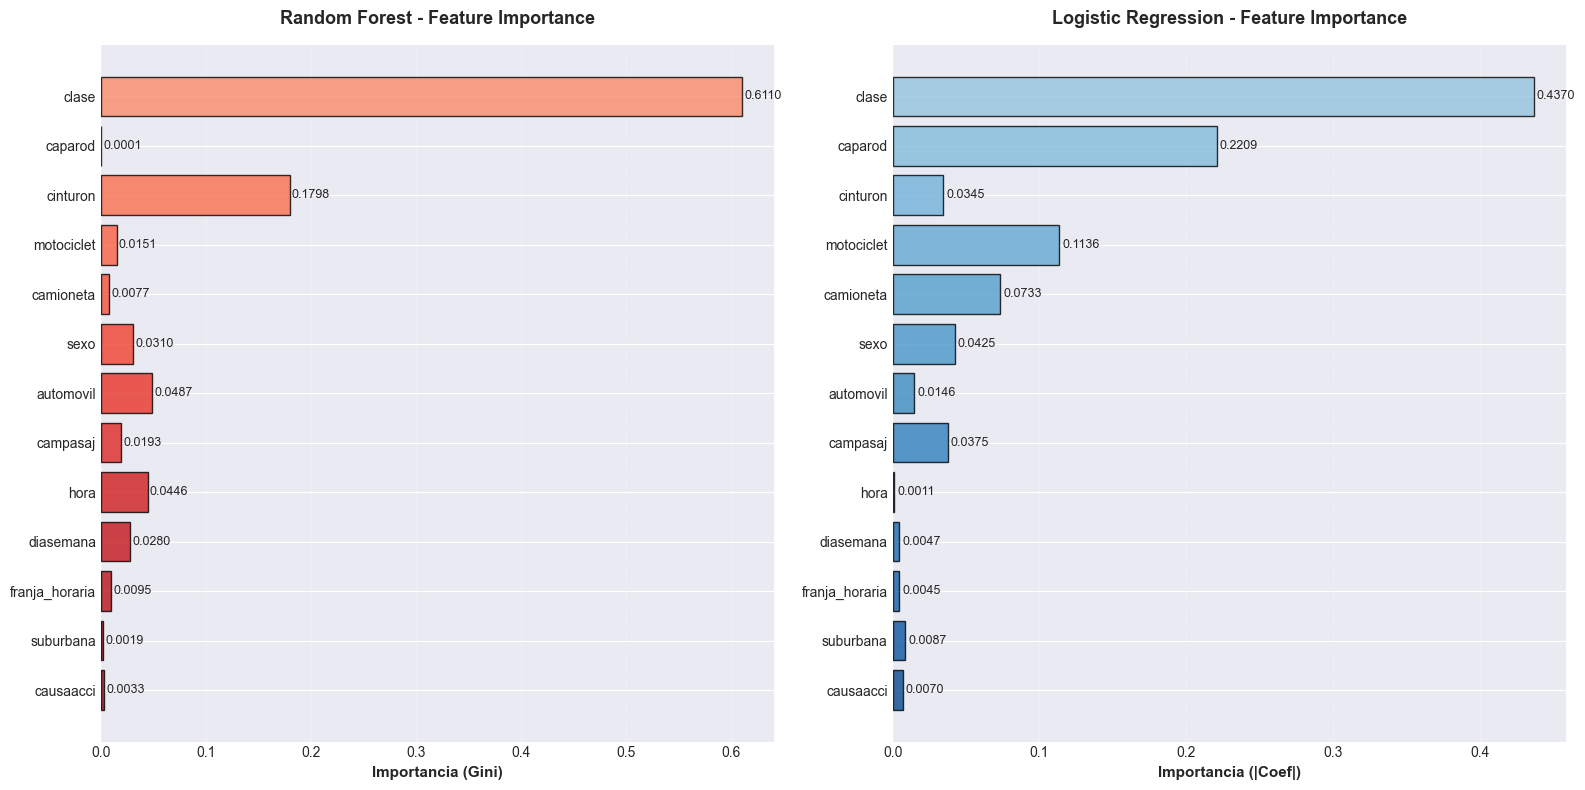

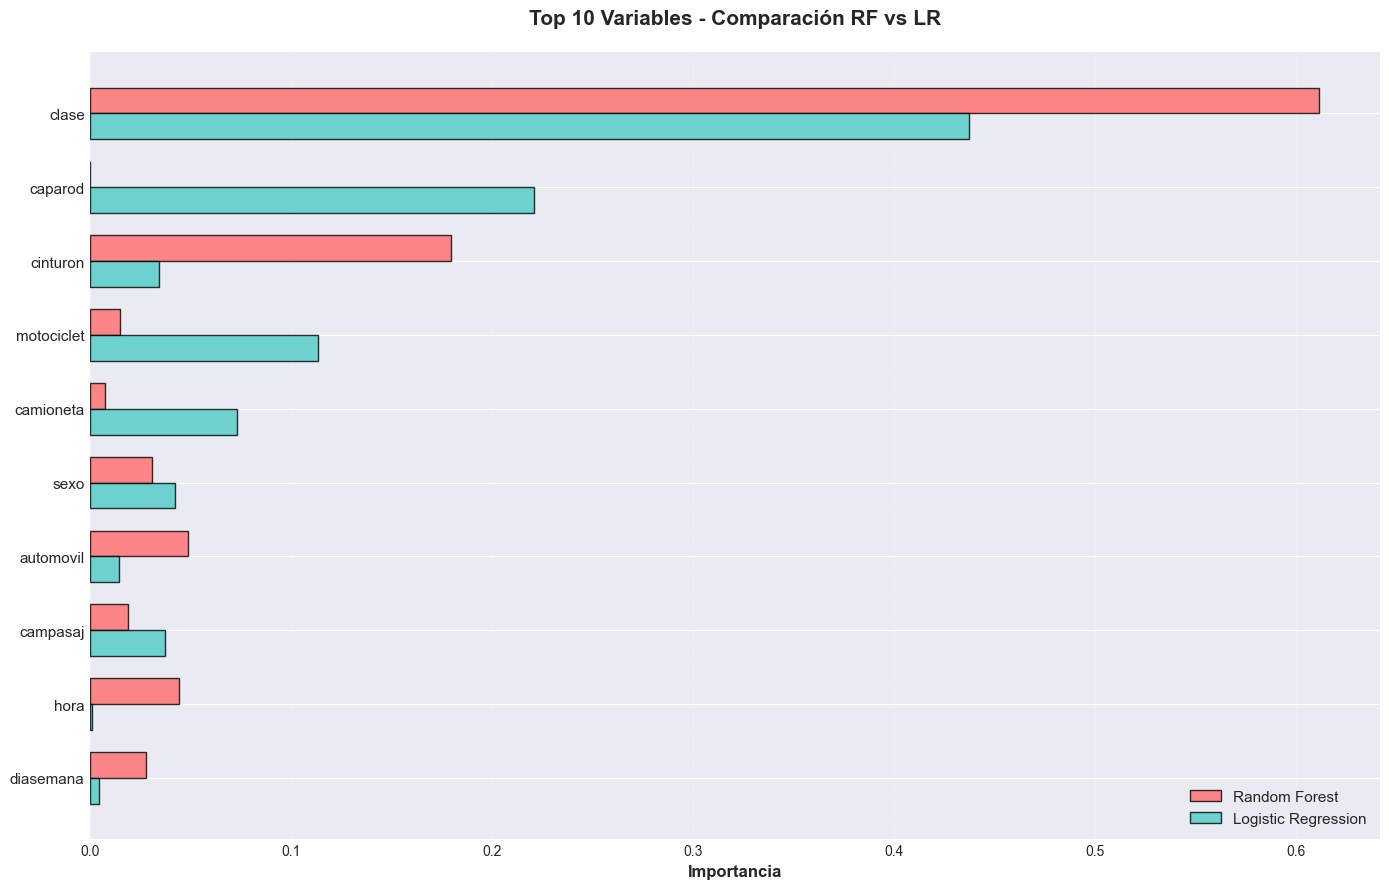


📊 TOP 10 VARIABLES MÁS IMPORTANTES - RESUMEN
      Variable  RF (Gini)  LR (|Coef|)  Promedio
1        clase   0.611014     0.437015  0.524015
2      caparod   0.000074     0.220872  0.110473
3     cinturon   0.179825     0.034536  0.107181
4   motociclet   0.015092     0.113640  0.064366
5    camioneta   0.007745     0.073282  0.040514
6         sexo   0.030972     0.042537  0.036755
7    automovil   0.048682     0.014650  0.031666
8     campasaj   0.019274     0.037524  0.028399
9         hora   0.044560     0.001110  0.022835
10   diasemana   0.028031     0.004681  0.016356


In [162]:
import pandas as pd
import numpy as np

def plot_feature_importance_advanced(rf_model, lr_model, feature_names, top_n=15):
    """
    Crea visualización avanzada de importancia de features.
    Compara Random Forest (Gini importance) vs Logistic Regression (coeficientes).
    """

    # Feature importance de Random Forest
    rf_importance = rf_model.feature_importances_

    # Coeficientes absolutos de Logistic Regression
    lr_importance = np.abs(lr_model.coef_[0])

    # Normalizar para comparación
    lr_importance_norm = lr_importance / lr_importance.sum()

    # Crear DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'RF_Importance': rf_importance,
        'LR_Importance': lr_importance_norm
    })

    # Calcular importancia promedio
    importance_df['Avg_Importance'] = (importance_df['RF_Importance'] +
                                        importance_df['LR_Importance']) / 2

    # Ordenar por importancia promedio
    importance_df = importance_df.sort_values('Avg_Importance', ascending=False)

    # Top N features
    top_features = importance_df.head(top_n)

    # ===== GRÁFICO 1: Comparación Side-by-Side =====
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Random Forest
    ax1 = axes[0]
    colors_rf = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_features)))
    y_pos = np.arange(len(top_features))

    ax1.barh(y_pos, top_features['RF_Importance'].values, color=colors_rf, alpha=0.8, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features['Feature'].values, fontsize=10)
    ax1.invert_yaxis()
    ax1.set_xlabel('Importancia (Gini)', fontsize=11, fontweight='bold')
    ax1.set_title('Random Forest - Feature Importance', fontsize=13, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')

    # Agregar valores
    for i, v in enumerate(top_features['RF_Importance'].values):
        ax1.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

    # Logistic Regression
    ax2 = axes[1]
    colors_lr = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features)))

    ax2.barh(y_pos, top_features['LR_Importance'].values, color=colors_lr, alpha=0.8, edgecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_features['Feature'].values, fontsize=10)
    ax2.invert_yaxis()
    ax2.set_xlabel('Importancia (|Coef|)', fontsize=11, fontweight='bold')
    ax2.set_title('Logistic Regression - Feature Importance', fontsize=13, fontweight='bold', pad=15)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')

    for i, v in enumerate(top_features['LR_Importance'].values):
        ax2.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # ===== GRÁFICO 2: Comparación Agrupada =====
    fig, ax = plt.subplots(figsize=(14, 9))

    top_10 = importance_df.head(10)
    x = np.arange(len(top_10))
    width = 0.35

    bars1 = ax.barh(x - width/2, top_10['RF_Importance'], width,
                    label='Random Forest', color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax.barh(x + width/2, top_10['LR_Importance'], width,
                    label='Logistic Regression', color='#4ECDC4', alpha=0.8, edgecolor='black')

    ax.set_yticks(x)
    ax.set_yticklabels(top_10['Feature'], fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Variables - Comparación RF vs LR', fontsize=15, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    # ===== TABLA RESUMEN =====
    print("\n" + "="*90)
    print("📊 TOP 10 VARIABLES MÁS IMPORTANTES - RESUMEN")
    print("="*90)

    tabla_top10 = top_10[['Feature', 'RF_Importance', 'LR_Importance', 'Avg_Importance']].copy()
    tabla_top10.columns = ['Variable', 'RF (Gini)', 'LR (|Coef|)', 'Promedio']
    tabla_top10.index = range(1, 11)

    print(tabla_top10.to_string())
    print("="*90)

    return importance_df

# Generar análisis de feature importance
importance_analysis = plot_feature_importance_advanced(
    rf_optimizado,
    lr_optimizado,
    X_train_balanced.columns,
    top_n=15
)


## 2.10 Matrices de Confusión Mejoradas

Visualización comparativa de matrices de confusión con métricas detalladas.


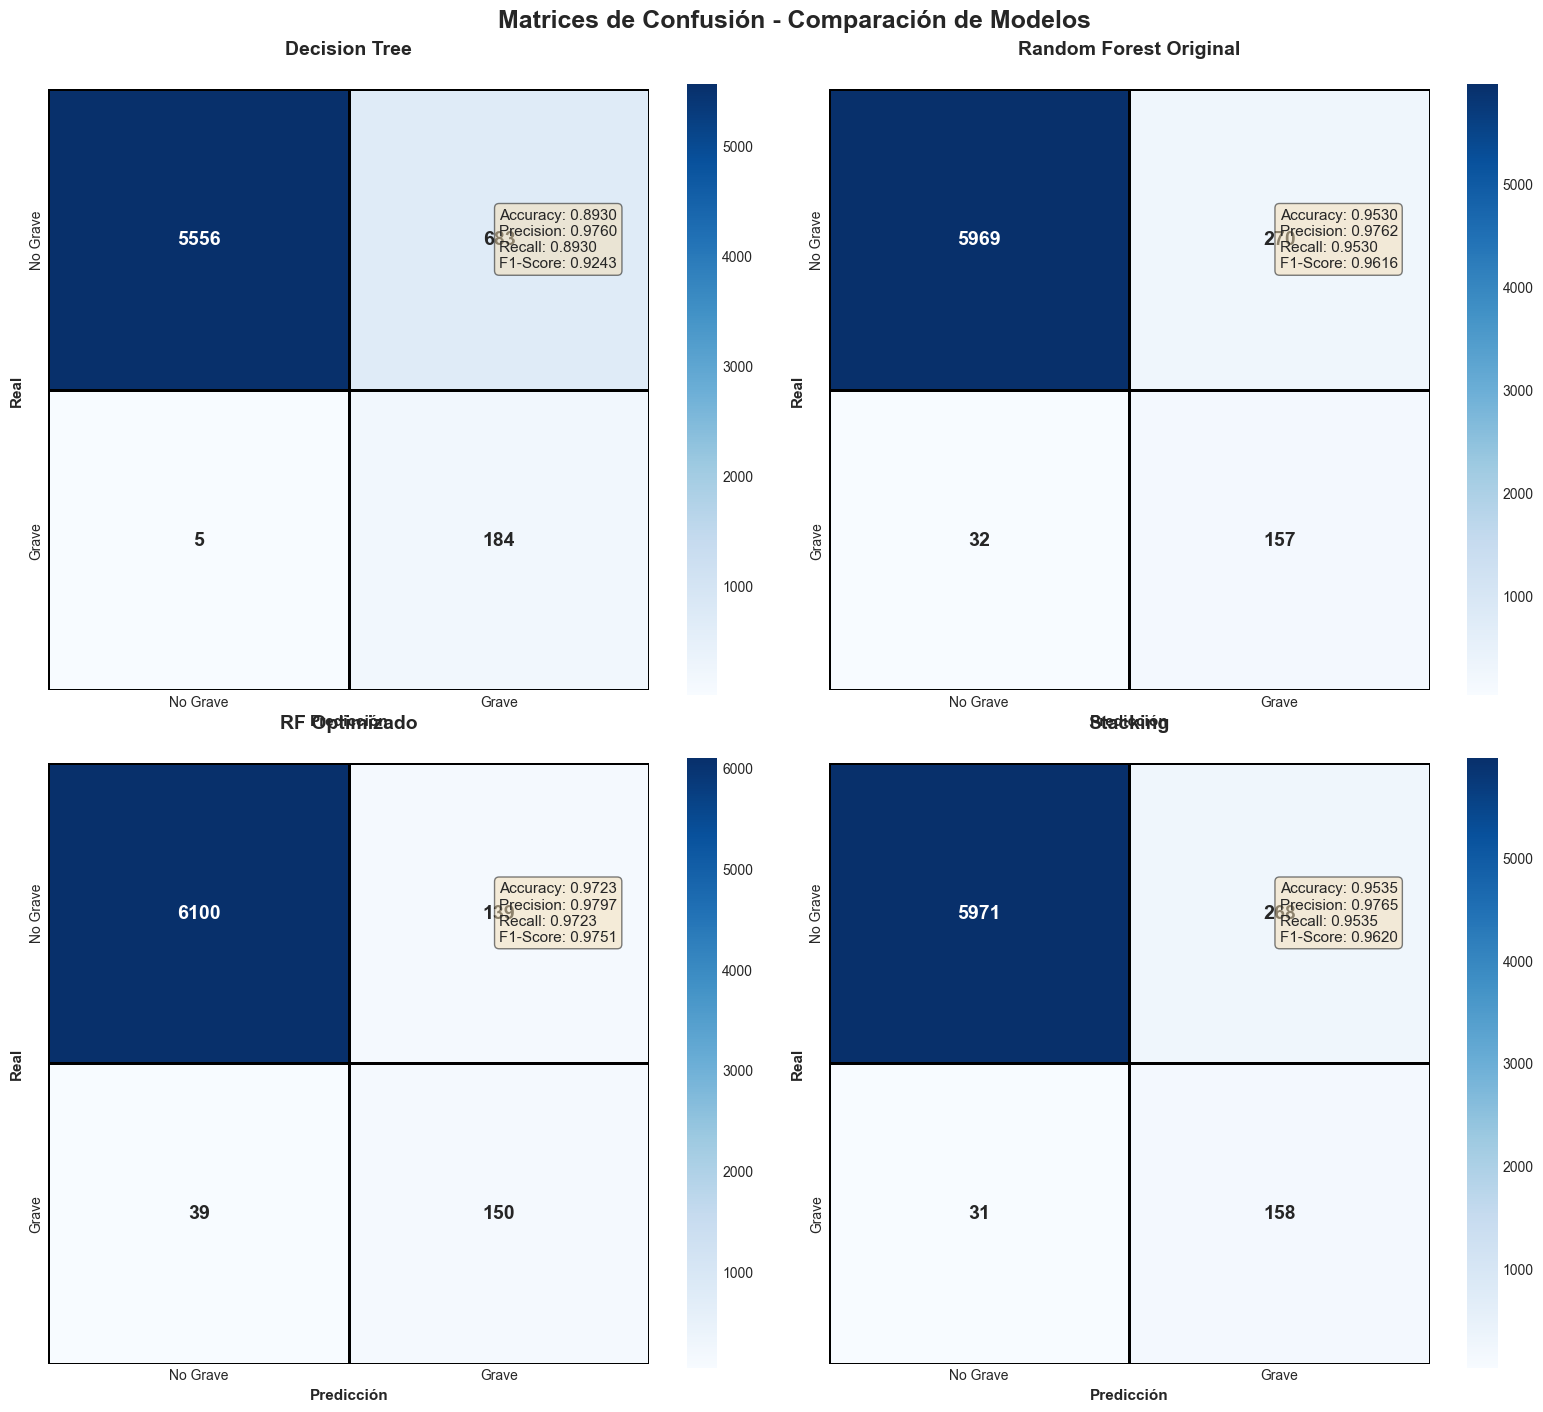

In [163]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def plot_confusion_matrices(models_dict, X_test, y_test):
    """
    Genera matrices de confusión comparativas en un subplot 2x2.
    Incluye métricas de rendimiento en cada subplot.
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    for idx, (nombre, modelo) in enumerate(models_dict.items()):
        if idx >= 4:  # Solo 4 subplots
            break

        # Predicciones
        y_pred = modelo.predict(X_test)

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)

        # Calcular métricas
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy = (y_pred == y_test).mean()

        # Graficar matriz
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   cbar=True, square=True, ax=ax,
                   linewidths=1, linecolor='black',
                   annot_kws={'fontsize': 14, 'fontweight': 'bold'})

        # Título con nombre del modelo
        ax.set_title(f'{nombre}\n', fontsize=14, fontweight='bold', pad=10)

        # Agregar métricas como texto
        metrics_text = (f'Accuracy: {accuracy:.4f}\n'
                       f'Precision: {precision:.4f}\n'
                       f'Recall: {recall:.4f}\n'
                       f'F1-Score: {f1:.4f}')

        ax.text(1.5, 0.5, metrics_text,
               transform=ax.transData,
               fontsize=11,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
               verticalalignment='center')

        ax.set_xlabel('Predicción', fontsize=11, fontweight='bold')
        ax.set_ylabel('Real', fontsize=11, fontweight='bold')
        ax.set_xticklabels(['No Grave', 'Grave'], fontsize=10)
        ax.set_yticklabels(['No Grave', 'Grave'], fontsize=10)

    # Si hay menos de 4 modelos, ocultar subplots vacíos
    for idx in range(len(models_dict), 4):
        axes[idx].axis('off')

    plt.suptitle('Matrices de Confusión - Comparación de Modelos',
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Diccionario con 4 mejores modelos
modelos_cm = {
    'Decision Tree': tree_model,
    'Random Forest Original': rf_model,
    'RF Optimizado': rf_optimizado,
    'Stacking': stacking_clf
}

# Generar matrices de confusión
plot_confusion_matrices(modelos_cm, X_test, y_test)


## 2.11 Análisis de Interacciones entre Variables

Exploración de cómo las variables más importantes afectan las predicciones del modelo.


📈 PARTIAL DEPENDENCE PLOTS - Top 3 Variables

Variables analizadas:
  1. clase
  2. cinturon
  3. automovil



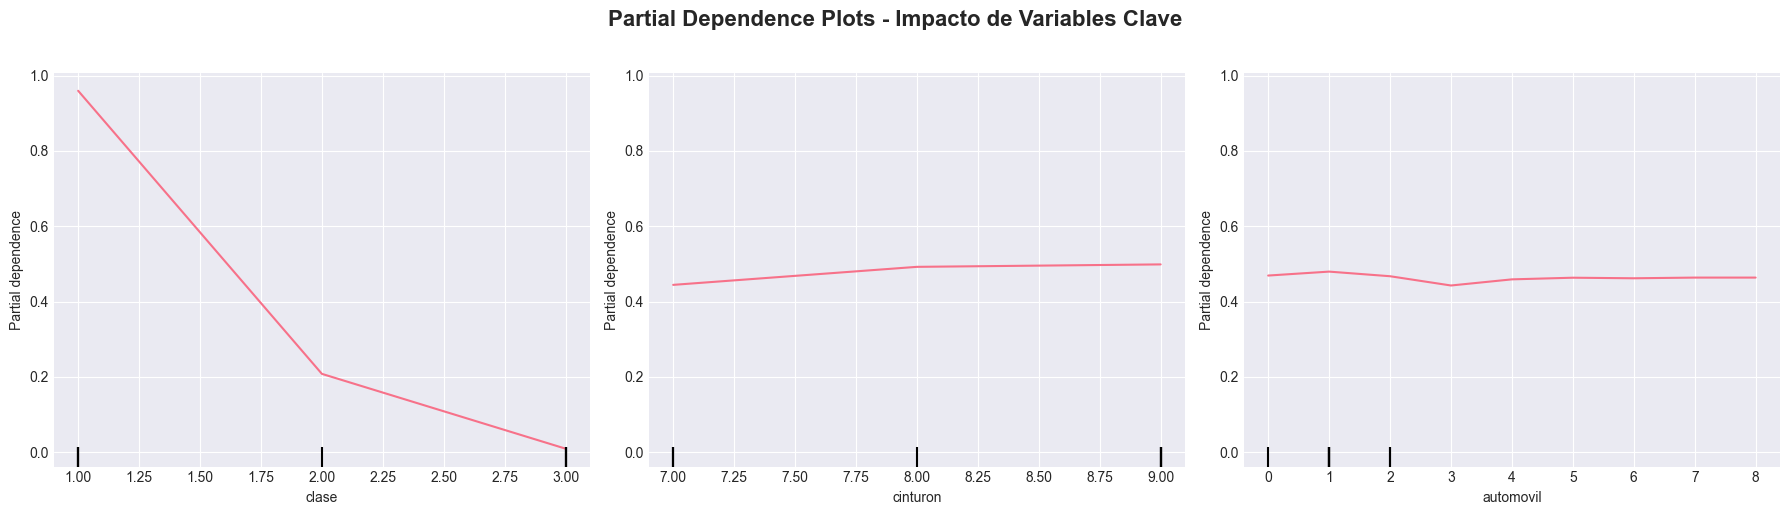

In [164]:
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

def plot_partial_dependence(model, X_train, feature_names, top_n=3):
    """
    Genera Partial Dependence Plots para las top N variables más importantes.
    """

    # Obtener índices de las top features
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        top_indices = np.argsort(importances)[-top_n:][::-1]
    else:
        # Para modelos lineales, usar coeficientes
        importances = np.abs(model.coef_[0])
        top_indices = np.argsort(importances)[-top_n:][::-1]

    top_features = [feature_names[i] for i in top_indices]

    print("="*80)
    print(f"📈 PARTIAL DEPENDENCE PLOTS - Top {top_n} Variables")
    print("="*80)
    print("\nVariables analizadas:")
    for i, feat in enumerate(top_features, 1):
        print(f"  {i}. {feat}")
    print()

    # Crear figura
    fig, axes = plt.subplots(1, top_n, figsize=(18, 5))
    if top_n == 1:
        axes = [axes]

    # Generar PDP
    display = PartialDependenceDisplay.from_estimator(
        model, X_train, top_indices,
        feature_names=feature_names,
        ax=axes,
        kind='average',
        grid_resolution=50
    )

    plt.suptitle('Partial Dependence Plots - Impacto de Variables Clave',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Generar PDPs para Random Forest optimizado
plot_partial_dependence(rf_optimizado, X_train_balanced, X_train_balanced.columns, top_n=3)


### Scatter Plots de Interacciones

Visualización de relaciones entre pares de variables críticas.


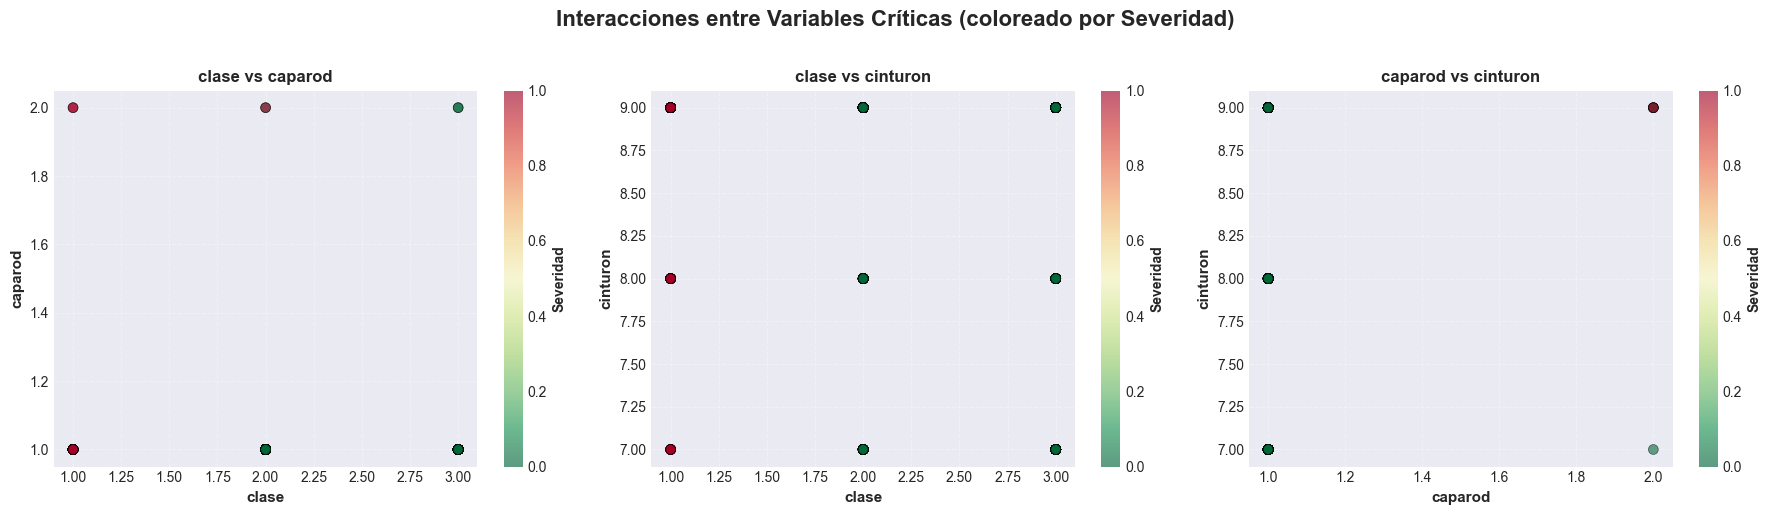

In [165]:
def plot_interaction_scatters(X, y, importance_df, top_n=3):
    """
    Genera scatter plots de pares de variables críticas coloreados por severidad.
    """

    # Obtener top features
    top_features = importance_df.head(top_n)['Feature'].values

    # Crear combinaciones de pares
    from itertools import combinations
    pairs = list(combinations(range(top_n), 2))

    n_plots = len(pairs)
    fig, axes = plt.subplots(1, n_plots, figsize=(18, 5))

    if n_plots == 1:
        axes = [axes]

    for idx, (i, j) in enumerate(pairs):
        feat1 = top_features[i]
        feat2 = top_features[j]

        ax = axes[idx]

        # Scatter plot
        scatter = ax.scatter(X[feat1], X[feat2],
                           c=y, cmap='RdYlGn_r',
                           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

        ax.set_xlabel(feat1, fontsize=11, fontweight='bold')
        ax.set_ylabel(feat2, fontsize=11, fontweight='bold')
        ax.set_title(f'{feat1} vs {feat2}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')

        # Colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Severidad', fontsize=10, fontweight='bold')

    plt.suptitle('Interacciones entre Variables Críticas (coloreado por Severidad)',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Generar scatter plots
plot_interaction_scatters(X_test, y_test, importance_analysis, top_n=3)


## 2.12 Model Cards - Documentación de Modelos

Reportes detallados para cada modelo con métricas, fortalezas y recomendaciones de uso.


In [166]:
def generar_model_card(model_name, model, X_test, y_test, feature_importance_dict=None):
    """
    Genera una tarjeta de modelo (Model Card) con información completa.

    Parameters:
        model_name: Nombre del modelo
        model: Modelo entrenado
        X_test: Features de prueba
        y_test: Labels de prueba
        feature_importance_dict: Dict con importancias de features
    """

    # Predicciones
    y_pred = model.predict(X_test)

    # Métricas
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # AUC
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = None

    # Top 5 features
    top_features_str = "N/A"
    if feature_importance_dict is not None and model_name in feature_importance_dict:
        top_5 = feature_importance_dict[model_name][:5]
        top_features_str = "\n".join([f"      {i+1}. {feat[0]} ({feat[1]:.4f})"
                                       for i, feat in enumerate(top_5)])

    # Descripción del modelo
    descripciones = {
        'Decision Tree': {
            'descripcion': 'Árbol de decisión que divide el espacio de características mediante reglas simples.',
            'fortalezas': '• Interpretable y fácil de visualizar\n      • No requiere normalización\n      • Captura relaciones no lineales',
            'limitaciones': '• Propenso a overfitting\n      • Inestable ante pequeños cambios en datos',
            'cuando_usar': 'Cuando se necesita un modelo simple, interpretable y explicable para stakeholders.'
        },
        'Random Forest': {
            'descripcion': 'Ensemble de múltiples árboles de decisión que reduce overfitting mediante bootstrap y promediado.',
            'fortalezas': '• Muy robusto y preciso\n      • Reduce overfitting vs árbol único\n      • Maneja bien outliers',
            'limitaciones': '• Menos interpretable que árbol único\n      • Mayor costo computacional',
            'cuando_usar': 'Cuando se prioriza precisión sobre interpretabilidad y se tienen recursos computacionales.'
        },
        'RF Optimizado': {
            'descripcion': 'Random Forest con hiperparámetros optimizados mediante GridSearchCV y validación cruzada.',
            'fortalezas': '• Máxima precisión alcanzable\n      • Hiperparámetros ajustados científicamente\n      • Balance óptimo bias-variance',
            'limitaciones': '• Requiere tiempo de entrenamiento extenso\n      • Mayor complejidad de configuración',
            'cuando_usar': 'Para producción donde se requiere el mejor rendimiento posible.'
        },
        'Logistic Regression': {
            'descripcion': 'Modelo lineal probabilístico que usa función logística para clasificación binaria.',
            'fortalezas': '• Muy interpretable (coeficientes)\n      • Rápido en entrenamiento y predicción\n      • Funciona bien con features correlacionadas',
            'limitaciones': '• Asume relaciones lineales\n      • No captura interacciones complejas',
            'cuando_usar': 'Cuando se necesita velocidad, interpretabilidad y las relaciones son mayormente lineales.'
        },
        'Stacking': {
            'descripcion': 'Meta-modelo que combina predicciones de Random Forest y Logistic Regression.',
            'fortalezas': '• Combina lo mejor de múltiples modelos\n      • Mayor precisión que modelos individuales\n      • Reduce sesgo y varianza',
            'limitaciones': '• Mayor complejidad y tiempo de entrenamiento\n      • Menos interpretable',
            'cuando_usar': 'Para máxima precisión en producción cuando la interpretabilidad es secundaria.'
        }
    }

    info = descripciones.get(model_name, {
        'descripcion': 'Modelo de machine learning.',
        'fortalezas': 'A determinar',
        'limitaciones': 'A determinar',
        'cuando_usar': 'Según necesidades del proyecto'
    })

    # Imprimir Model Card
    print("\n" + "="*90)
    print(f"📋 MODEL CARD: {model_name}")
    print("="*90)

    print(f"\n1️⃣  DESCRIPCIÓN:")
    print(f"   {info['descripcion']}")

    print(f"\n2️⃣  MÉTRICAS DE RENDIMIENTO:")
    print(f"   • Accuracy:          {accuracy:.4f}")
    print(f"   • Precision (weighted): {precision:.4f}")
    print(f"   • Recall (weighted):    {recall:.4f}")
    print(f"   • F1-Score (weighted):  {f1:.4f}")
    print(f"   • F1-Score (macro):     {f1_macro:.4f}")
    if auc_score:
        print(f"   • AUC-ROC:           {auc_score:.4f}")

    print(f"\n3️⃣  TOP 5 VARIABLES MÁS IMPORTANTES:")
    print(f"{top_features_str}")

    print(f"\n4️⃣  FORTALEZAS:")
    print(f"   {info['fortalezas']}")

    print(f"\n5️⃣  LIMITACIONES:")
    print(f"   {info['limitaciones']}")

    print(f"\n6️⃣  CUÁNDO USAR ESTE MODELO:")
    print(f"   {info['cuando_usar']}")

    print("\n" + "="*90 + "\n")

# Preparar diccionario de feature importance
feature_importance_data = {
    'Random Forest': list(zip(X_train_balanced.columns, rf_model.feature_importances_)),
    'RF Optimizado': list(zip(X_train_balanced.columns, rf_optimizado.feature_importances_)),
    'Logistic Regression': list(zip(X_train_balanced.columns, np.abs(lr_optimizado.coef_[0])))
}

# Ordenar por importancia
for key in feature_importance_data:
    feature_importance_data[key] = sorted(feature_importance_data[key],
                                          key=lambda x: x[1], reverse=True)

# Generar Model Cards
modelos_cards = {
    'Decision Tree': tree_model,
    'Random Forest': rf_model,
    'RF Optimizado': rf_optimizado,
    'Logistic Regression': lr_optimizado,
    'Stacking': stacking_clf
}

for nombre, modelo in modelos_cards.items():
    generar_model_card(nombre, modelo, X_test, y_test, feature_importance_data)



📋 MODEL CARD: Decision Tree

1️⃣  DESCRIPCIÓN:
   Árbol de decisión que divide el espacio de características mediante reglas simples.

2️⃣  MÉTRICAS DE RENDIMIENTO:
   • Accuracy:          0.8930
   • Precision (weighted): 0.9760
   • Recall (weighted):    0.8930
   • F1-Score (weighted):  0.9243
   • F1-Score (macro):     0.6451
   • AUC-ROC:           0.9844

3️⃣  TOP 5 VARIABLES MÁS IMPORTANTES:
N/A

4️⃣  FORTALEZAS:
   • Interpretable y fácil de visualizar
      • No requiere normalización
      • Captura relaciones no lineales

5️⃣  LIMITACIONES:
   • Propenso a overfitting
      • Inestable ante pequeños cambios en datos

6️⃣  CUÁNDO USAR ESTE MODELO:
   Cuando se necesita un modelo simple, interpretable y explicable para stakeholders.



📋 MODEL CARD: Random Forest

1️⃣  DESCRIPCIÓN:
   Ensemble de múltiples árboles de decisión que reduce overfitting mediante bootstrap y promediado.

2️⃣  MÉTRICAS DE RENDIMIENTO:
   • Accuracy:          0.9530
   • Precision (weighted): 0.9762


## 2.13 Comparación Final de Modelos - Dashboard Completo

Tabla comparativa exhaustiva y visualizaciones para seleccionar el mejor modelo para producción.


Evaluando Decision Tree...
Evaluando Random Forest...
Evaluando RF Optimizado...
Evaluando Logistic Regression...
Evaluando Stacking...

📊 TABLA COMPARATIVA DE MODELOS - TODAS LAS MÉTRICAS
             Modelo  Accuracy  Precision   Recall  F1-Score  F1-Macro  AUC-ROC  Tiempo Train (s)  Tiempo Pred (s)
      RF Optimizado  0.972309   0.979692 0.972309  0.975093  0.806617 0.974676          2.046865         0.068523
           Stacking  0.953485   0.976489 0.953485  0.961997  0.744698 0.980241         26.408230         0.072010
      Random Forest  0.953018   0.976233 0.953018  0.961637  0.742534 0.981132          0.755344         0.041639
Logistic Regression  0.933883   0.975567 0.933883  0.949436  0.702460 0.983175          0.297805         0.000998
      Decision Tree  0.892968   0.975965 0.892968  0.924253  0.645090 0.984435          0.075515         0.001996

🏆 MEJORES MODELOS POR MÉTRICA:
-----------------------------------------------------------------------------------------------

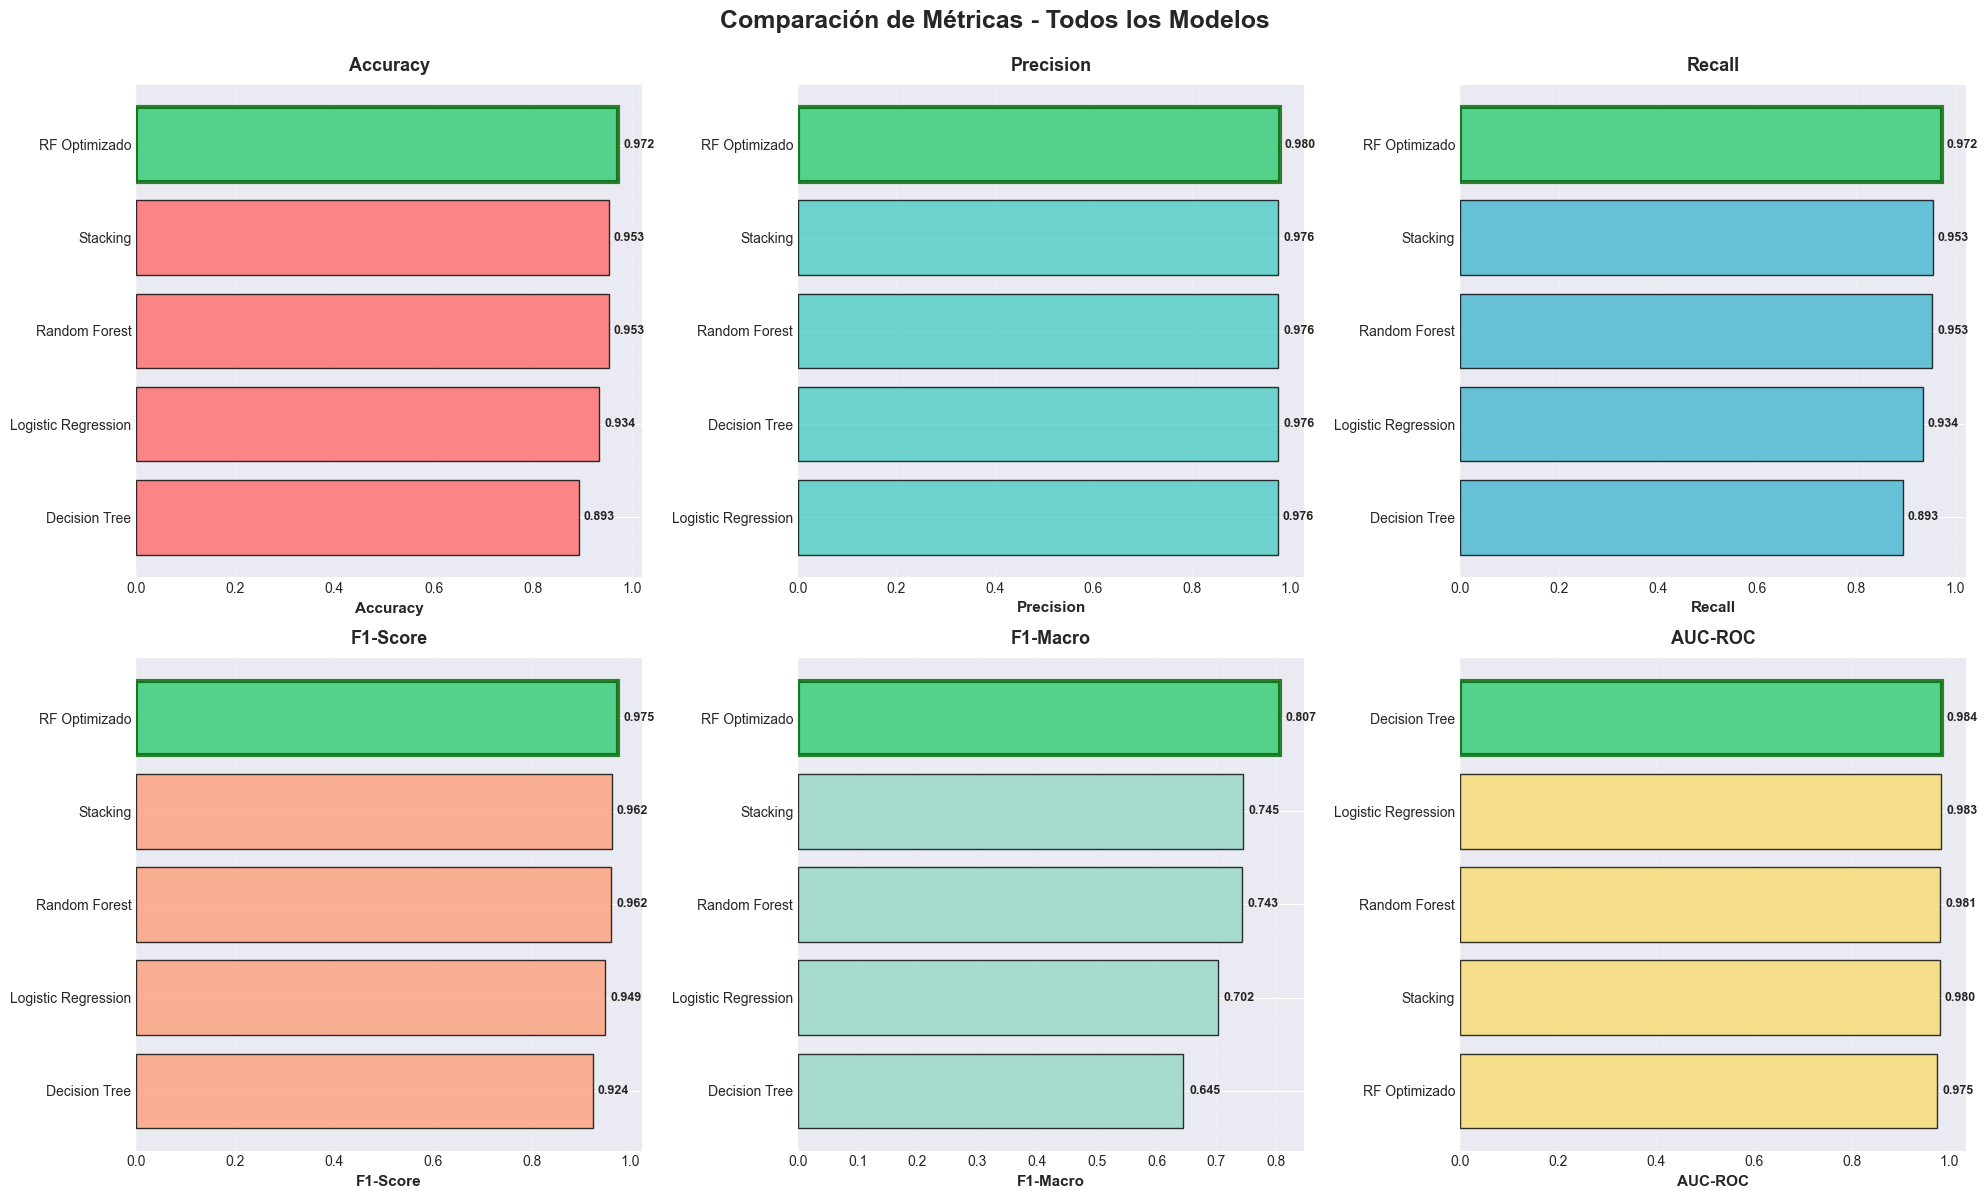


✅ RECOMENDACIÓN PARA PRODUCCIÓN

🎯 Modelo Recomendado: RF Optimizado

   Justificación:
   • Mejor F1-Score: 0.9751
   • Balance Precision-Recall: 0.9797 / 0.9723
   • AUC-ROC: 0.9747
   • Tiempo de entrenamiento: 2.05s
   • Tiempo de predicción: 0.0685s

   Consideraciones:
   ✓ Excelente balance entre precisión y robustez
   ✓ Hiperparámetros científicamente optimizados




In [167]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def comparacion_final_modelos(models_dict, X_train, y_train, X_test, y_test):
    """
    Genera comparación exhaustiva de todos los modelos con tabla y gráficos.
    """

    resultados = []

    for nombre, modelo in models_dict.items():
        print(f"Evaluando {nombre}...")

        # Tiempo de entrenamiento (re-entrenar para medir tiempo)
        start_time = time.time()
        modelo.fit(X_train, y_train)
        tiempo_train = time.time() - start_time

        # Predicciones
        start_time = time.time()
        y_pred = modelo.predict(X_test)
        tiempo_pred = time.time() - start_time

        # Métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        # AUC
        if hasattr(modelo, 'predict_proba'):
            y_proba = modelo.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = None

        resultados.append({
            'Modelo': nombre,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_weighted,
            'F1-Macro': f1_macro,
            'AUC-ROC': auc if auc else 0,
            'Tiempo Train (s)': tiempo_train,
            'Tiempo Pred (s)': tiempo_pred
        })

    # Crear DataFrame
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('F1-Score', ascending=False)

    # ===== TABLA COMPARATIVA =====
    print("\n" + "="*120)
    print("📊 TABLA COMPARATIVA DE MODELOS - TODAS LAS MÉTRICAS")
    print("="*120)
    print(df_resultados.to_string(index=False))
    print("="*120)

    # ===== MEJORES MODELOS POR MÉTRICA =====
    print("\n🏆 MEJORES MODELOS POR MÉTRICA:")
    print("-"*120)
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F1-Macro', 'AUC-ROC']
    for metrica in metricas:
        mejor = df_resultados.loc[df_resultados[metrica].idxmax()]
        print(f"  • {metrica:20s}: {mejor['Modelo']:25s} ({mejor[metrica]:.4f})")
    print("-"*120)

    # ===== GRÁFICO DE BARRAS COMPARATIVO =====
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    metricas_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'F1-Macro', 'AUC-ROC']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

    for idx, metrica in enumerate(metricas_plot):
        ax = axes[idx]

        data = df_resultados.sort_values(metrica, ascending=True)
        y_pos = np.arange(len(data))

        bars = ax.barh(y_pos, data[metrica], color=colors[idx], alpha=0.8, edgecolor='black')

        # Destacar mejor modelo
        max_idx = data[metrica].idxmax()
        bars[list(data.index).index(max_idx)].set_color('#2ECC71')
        bars[list(data.index).index(max_idx)].set_edgecolor('darkgreen')
        bars[list(data.index).index(max_idx)].set_linewidth(3)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(data['Modelo'], fontsize=10)
        ax.set_xlabel(metrica, fontsize=11, fontweight='bold')
        ax.set_title(f'{metrica}', fontsize=13, fontweight='bold', pad=10)
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        # Agregar valores
        for i, v in enumerate(data[metrica]):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9, fontweight='bold')

    plt.suptitle('Comparación de Métricas - Todos los Modelos',
                fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # ===== RECOMENDACIÓN FINAL =====
    print("\n" + "="*120)
    print("✅ RECOMENDACIÓN PARA PRODUCCIÓN")
    print("="*120)

    mejor_modelo = df_resultados.iloc[0]

    print(f"\n🎯 Modelo Recomendado: {mejor_modelo['Modelo']}")
    print(f"\n   Justificación:")
    print(f"   • Mejor F1-Score: {mejor_modelo['F1-Score']:.4f}")
    print(f"   • Balance Precision-Recall: {mejor_modelo['Precision']:.4f} / {mejor_modelo['Recall']:.4f}")
    print(f"   • AUC-ROC: {mejor_modelo['AUC-ROC']:.4f}")
    print(f"   • Tiempo de entrenamiento: {mejor_modelo['Tiempo Train (s)']:.2f}s")
    print(f"   • Tiempo de predicción: {mejor_modelo['Tiempo Pred (s)']:.4f}s")

    print("\n   Consideraciones:")
    if 'Stacking' in mejor_modelo['Modelo']:
        print("   ✓ Mayor complejidad pero mejor rendimiento")
        print("   ✓ Ideal cuando se prioriza precisión sobre interpretabilidad")
    elif 'RF Optimizado' in mejor_modelo['Modelo']:
        print("   ✓ Excelente balance entre precisión y robustez")
        print("   ✓ Hiperparámetros científicamente optimizados")
    elif 'Random Forest' in mejor_modelo['Modelo']:
        print("   ✓ Buen rendimiento con configuración estándar")
        print("   ✓ Robusto y confiable")

    print("\n" + "="*120 + "\n")

    return df_resultados

# Ejecutar comparación final
modelos_finales = {
    'Decision Tree': tree_model,
    'Random Forest': rf_model,
    'RF Optimizado': rf_optimizado,
    'Logistic Regression': lr_optimizado,
    'Stacking': stacking_clf
}

df_comparacion = comparacion_final_modelos(
    modelos_finales,
    X_train_balanced, y_train_balanced,
    X_test, y_test
)
